In [1]:
# disable the annoying noise with red background color
import logging
logging.disable(logging.INFO)
logging.disable(logging.WARNING)

In [2]:
! pip install datasets
! pip install transformers

  Using cached datasets-2.5.2-py3-none-any.whl (432 kB)
  Using cached dill-0.3.5.1-py2.py3-none-any.whl (95 kB)
  Using cached xxhash-3.0.0-cp38-cp38-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (212 kB)
  Using cached responses-0.18.0-py3-none-any.whl (38 kB)
  Using cached multiprocess-0.70.13-py38-none-any.whl (131 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 163.5/163.5 kB 3.5 MB/s eta 0:00:00a 0:00:01
  Using cached filelock-3.8.0-py3-none-any.whl (10 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.3/5.3 MB 34.0 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 99.2 MB/s eta 0:00:00:00:0100:01
  Using cached regex-2022.9.13-cp38-cp38-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (772 kB)


In [3]:
!pip install rdkit-pypi

  Using cached rdkit_pypi-2022.3.5-cp38-cp38-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (37.0 MB)


In [4]:
!pip install biopython

  Using cached biopython-1.79-cp38-cp38-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (2.7 MB)


In [5]:
import torch
from torch.utils.data import Dataset
import datasets
from datasets import load_dataset
from transformers import AutoTokenizer, Trainer
from transformers import EvalPrediction
from transformers import TrainingArguments

from tokenizers import Regex
from tokenizers import pre_tokenizers
from tokenizers import normalizers
from tokenizers.normalizers import Replace

from tokenizers.pre_tokenizers import BertPreTokenizer
from tokenizers.pre_tokenizers import Digits
from tokenizers.pre_tokenizers import Sequence
from tokenizers.pre_tokenizers import WhitespaceSplit
from tokenizers.pre_tokenizers import Split

from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import StandardScaler
 
from sklearn.metrics import precision_recall_curve, roc_curve
import pandas as pd
import numpy as np
import json
import re
import tqdm
import os

2022-10-11 12:32:53.334959: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [6]:
assert torch.cuda.is_available()

In [7]:
import sys
sys.path.append('../')
from contact_pred.models import StructurePrediction, ProteinLigandConfigStructure
from contact_pred.structure import IPAConfig
from contact_pred.data_utils import StructurePredictionPipeline

In [8]:
sys.path.append('/gpfs/alpine/world-shared/bif136/pdb_structures')

In [9]:
amino_acids = {'L': 'LEU', 'A': 'ALA', 'G': 'GLY', 'V': 'VAL', 'E': 'GLU', 'S': 'SER', 'I': 'ILE', 'K': 'LYS',
               'R': 'ARG', 'D': 'ASP', 'T': 'THR', 'P': 'PRO', 'N': 'ASN', 'Q': 'GLN', 'F': 'PHE', 'Y': 'TYR',
               'M': 'MET', 'H': 'HIS', 'C': 'CYS', 'W': 'TRP'}

from atomic_renamer import AtomicNamer
aa = {k: AtomicNamer(amino_acids[k]) for k in amino_acids}

**Load models**

In [10]:
from transformers import BertConfig

seq_model_name = 'Rostlab/prot_bert_bfd'
seq_tokenizer = AutoTokenizer.from_pretrained(seq_model_name)
normalizer = normalizers.Sequence([Replace(Regex('[UZOB]'),'X'),Replace(Regex('\s'),'')])
pre_tokenizer = pre_tokenizers.Split(Regex(''),behavior='isolated')
seq_tokenizer = AutoTokenizer.from_pretrained(seq_model_name, do_lower_case=False)
seq_tokenizer.backend_tokenizer.normalizer = normalizer
seq_tokenizer.backend_tokenizer.pre_tokenizer = pre_tokenizer

smiles_tokenizer_directory = '/gpfs/alpine/world-shared/med106/blnchrd/models/bert_large_plus_clean_regex/tokenizer'
smiles_model_directory = '/gpfs/alpine/world-shared/med106/blnchrd/automatedmutations/pretraining/run/job_86neeM/output'
tokenizer_config = json.load(open(smiles_tokenizer_directory+'/config.json','r'))
smiles_tokenizer =  AutoTokenizer.from_pretrained(smiles_tokenizer_directory, **tokenizer_config)
smiles_tokenizer.backend_tokenizer.pre_tokenizer = Sequence([WhitespaceSplit(),Split(Regex(r"""(\[[^\]]+]|Br?|Cl?|N|O|S|P|F|I|b|c|n|o|s|p|\(|\)|\.|=|#|-|\+|\\|\/|:|~|@|\?|>>?|\*|\$|\%[0-9]{2}|[0-9])"""), behavior='isolated')])

In [11]:
models = []

#output_dir = '/gpfs/alpine/world-shared/bif136/contact_pred/train/results_summit_bs96_lr3e-5_ncross_3_1_tag0.1'
#output_dir = '/gpfs/alpine/world-shared/bif136/contact_pred/train/results_crusher_bs96_lr3e-5_ncross_3_kabsch'
#output_dir = '/gpfs/alpine/world-shared/bif136/contact_pred/train/results_summit_bs96_lr3e-5_ncross_3_1_hm'
#output_dir = '/gpfs/alpine/world-shared/bif136/contact_pred/train/results_summit_bs96_lr3e-5_ncross_3_1'
# output_dir = '/gpfs/alpine/world-shared/bif136/djh992/contact_pred_torsion_CNdist11/train/results_summit_bs96_lr1e-5_ncross_3_1/checkpoint-79200'
output_dir = '/gpfs/alpine/world-shared/bif136/djh992/contact_pred_torsion_CNdist11/train/results_summit_bs96_lr1e-5_ncross_3_1'

from transformers.trainer_utils import get_last_checkpoint
last_checkpoint = get_last_checkpoint(output_dir)
if last_checkpoint is None:
    last_checkpoint = output_dir
step_num = last_checkpoint.split('-')[-1]
print('Loading checkpoint {}'.format(last_checkpoint))
with open(os.path.join(output_dir,'config.json'),'r') as f:
    config = ProteinLigandConfigStructure.from_dict(json.load(f))

checkpoint = torch.load((os.path.join(last_checkpoint,'pytorch_model.bin')))

model = StructurePrediction(config=config)
model.load_state_dict(checkpoint,strict=True)
#model.float()
del checkpoint
#model.load_state_dict(checkpoint,strict=False)

models.append(StructurePredictionPipeline(model,
               seq_tokenizer=seq_tokenizer,
               smiles_tokenizer=smiles_tokenizer,
               device=0,
               batch_size=1))

Loading checkpoint /gpfs/alpine/world-shared/bif136/djh992/contact_pred_torsion_CNdist11/train/results_summit_bs96_lr1e-5_ncross_3_1/checkpoint-109300


In [12]:
class ProteinLigandDataset(Dataset):
    def __init__(self, dataset, smiles_name='smiles', seq_name='seq'):
        self.dataset = dataset
        self.seq_name = seq_name
        self.smiles_name = smiles_name

    def __getitem__(self, idx):
        try:
            item = self.dataset[idx]
        except:
            item = self.dataset.iloc[idx]
        
        try:
            # make canonical
            smiles_canonical = str(Chem.MolToSmiles(Chem.MolFromSmiles(item[self.smiles_name])))
        except:
            smiles_canonical = str(item[self.smiles_name])
        
        result = {'ligand': smiles_canonical, 
#        result = {'ligand': '', 
                  'protein': item[self.seq_name]}
                
        return result

    def __len__(self):
        return len(self.dataset)

**Load tokenizers and submodels**

In [13]:
# align the prediction with the ground truth
def align(T_true, T_pred):
    from scipy.spatial.transform import Rotation as R
    weights = (~np.any(np.isnan(T_true),axis=-1))
    T_true_cm = np.mean(T_true * weights[:, :, None],axis=1) / np.mean(weights,axis=1)
    T_pred_cm =  np.mean(T_pred * weights[:, :, None],axis=1) / np.mean(weights,axis=1)
    T_true_cen = (T_true - T_true_cm) * weights[:,:,None]
    T_pred_cen = (T_pred - T_pred_cm) * weights[:,:,None]

    # batched Kabsch algorithm
    res = [R.align_vectors(t, p) for (t,p) in zip(T_true_cen, T_pred_cen)]
    C = np.array([r[0].as_matrix() for r in res])

#    rmsd = np.mean(np.linalg.norm(np.einsum('bij,bnj->bni',C, T_pred_cen)-T_true_cen,axis=-1),axis=1)
    # https://github.com/scipy/scipy/issues/15907
    rmsd = np.mean([r[1]/np.sqrt(len(p)) for r,p in zip(res,T_pred_cen)])

    return C, T_true_cm - np.einsum('bij,bj->bi',C,T_pred_cm), rmsd

**Test dataset**

In [14]:
def map_dataset(item):
    item.update({'protein': item['seq'],
#                 'ligand': [''],
                 'ligand': item['smiles'],
                })
    
    if 'ligand_xyz' in item:
        item['ligand_xyz_pad'] = np.pad(item['ligand_xyz'],((0,0),(1,1),(0,0)),constant_values=None).astype(np.float32)
        item['receptor_xyz_pad'] = np.pad(item['receptor_xyz'],((0,0),(1,1),(0,0))).astype(np.float32)
        item.pop('ligand_xyz')
        item.pop('receptor_xyz')
    return item

In [15]:
! pip install webdataset

  Using cached webdataset-0.2.26-py3-none-any.whl (49 kB)
  Using cached braceexpand-0.1.7-py2.py3-none-any.whl (5.9 kB)


### Investigate short peptides

In [16]:
from contact_pred.residue_constants import restype_name_to_atom14_names, restype_1to3
def write_pdb_no_ref(f, seq, feat):
    k = 0
    resid = 1
    i = 1
    for s in seq:
        res = restype_1to3[s]
        for idx, atom in enumerate(restype_name_to_atom14_names[res]):
            if atom != '':
                xyz = feat[0,k+1,idx]
                write_pdb_line(f,'ATOM', str(i), atom, res, 'A', str(resid), *xyz, 1.0, 1.0, atom[0])
                i+=1
        k+=1
        resid+=1


        
        
def write_pdb_line(f,*j):
    j = list(j)
    j[0] = j[0].ljust(6)#atom#6s
    j[1] = j[1].rjust(5)#aomnum#5d
    j[2] = j[2].center(4)#atomname$#4s
    j[3] = j[3].ljust(3)#resname#1s
    j[4] = j[4].rjust(1) #Astring
    j[5] = j[5].rjust(4) #resnum
    j[6] = str('%8.3f' % (float(j[6]))).rjust(8) #x
    j[7] = str('%8.3f' % (float(j[7]))).rjust(8)#y
    j[8] = str('%8.3f' % (float(j[8]))).rjust(8) #z\
    j[9] =str('%6.2f'%(float(j[9]))).rjust(6)#occ
    j[10]=str('%6.2f'%(float(j[10]))).ljust(6)#temp
    j[11]=j[11].rjust(12)#elname
    f.write("%s%s %s %s %s%s    %s%s%s%s%s%s\n"% (j[0],j[1],j[2],j[3],j[4],j[5],j[6],j[7],j[8],j[9],j[10],j[11]))

In [405]:
import webdataset as wd, glob
from rdkit import Chem
test_data = wd.WebDataset(glob.glob('../../../pdbbind_complexes_djh992_revert/test/part-*.tar'), nodesplitter=lambda src: (s for s in src)).shuffle(1000).decode('torch')
train_data = wd.WebDataset(glob.glob('../../../pdbbind_complexes_djh992_revert/train/part-*.tar'), nodesplitter=lambda src: (s for s in src)).shuffle(1000).decode('torch')



In [17]:
from rdkit.Geometry import Point3D
from Bio.PDB import PDBParser
from Bio.PDB import PDBList
from Bio.PDB import CaPPBuilder
from rdkit import Chem
from rdkit.Chem import AllChem
path = '../utils'
if path not in sys.path:
    sys.path.append(path)
from token_coords import get_token_coords

In [417]:
from rdkit.Geometry import Point3D
from Bio.PDB import PDBParser
from Bio.PDB import PDBList
from Bio.PDB import CaPPBuilder
from rdkit import Chem
from rdkit.Chem import AllChem
path = '../utils'
if path not in sys.path:
    sys.path.append(path)
from token_coords import get_token_coords
complex_name = []
receptor_RMSD = []
ligand_RMSD = []
ligand_len = []
ligand_cent_RMSD = []
ligand_kabsch_RMSD = []
protein_len = []

models[0].model.enable_cross = False

import os
os.makedirs('../examples/test/',exist_ok=True)

for item in iter(test_data):
    try:
        df = pd.DataFrame({'seq': [item['seq.txt']], 'smiles': [item['smiles.txt']]})
        dataset = ProteinLigandDataset(df)
        output = list(models[0](dataset))
        pred = output[0]
        # C, t, receptor_rmsd = align(item['rec_xyz.pyd'][None],pred['receptor_xyz'][:,1:-1,1])
        C, t, receptor_rmsd = align(item['rec_xyz.pyd'][None],pred['receptor_frames_xyz'][:, 1:-1])

        ligand_xyz = pred['ligand_frames_xyz']
        ligand_xyz = np.einsum('bij,bnj->bni',C,ligand_xyz)+t
        ligand_rmsd = np.nanmean(np.linalg.norm(np.pad(item['lig_xyz.pyd'],((1,1),(0,0)),constant_values=np.nan)-ligand_xyz,axis=-1)[:,1:-1])
        ligand_cent_rmsd = np.linalg.norm(np.nanmean(np.pad(item['lig_xyz.pyd'],((1,1),(0,0)),constant_values=np.nan), axis=0) 
                                          - np.nanmean(ligand_xyz,axis=1),axis=-1)[0]
        _, _, ligand_kabsch_rmsd = align(np.array(item['lig_xyz.pyd'])[~np.isnan(np.mean(np.array(item['lig_xyz.pyd']), axis=1))][None, :],
                                   ligand_xyz[:,1:-1][:, ~np.isnan(np.mean(np.array(item['lig_xyz.pyd']), axis=1))])
        ligand_kabsch_RMSD.append(ligand_kabsch_rmsd/10)
        print(item['name.txt'], receptor_rmsd/10, ligand_rmsd/10, ligand_cent_rmsd/10)
        complex_name.append(item['name.txt'])
        receptor_RMSD.append(receptor_rmsd/10)
        ligand_RMSD.append(ligand_rmsd/10)
        ligand_cent_RMSD.append(ligand_cent_rmsd/10)
        protein_len.append(len(item['seq.txt']))
        ligand_len.append(len(item['smiles.txt']))
        

        item_name = item['name.txt']
        mol = Chem.MolFromSmiles(item['smiles.txt'])
        Chem.AllChem.EmbedMolecule(mol)
        smi, _, tokens, atom_map = get_token_coords(mol)
        conf = mol.GetConformer()
        for i, xyz in enumerate(ligand_xyz.squeeze(0)[1:-1]):
            idx = atom_map[i]
            if idx is not None:
                conf.SetAtomPosition(idx,Point3D(*xyz.astype(np.double)))

        # with Chem.SDWriter(f'../examples/test/ligand_pred_{item_name}.sdf') as w:
        #     w.write(mol)
        # with open(f'../examples/test/pred_{item_name}.pdb','w') as f:
        #     feat =  np.einsum('bij,bnaj->bnai',C,pred['receptor_xyz'])+t
        #     write_pdb_no_ref(f, item['seq.txt'], feat)
    except Exception as e:
        print(e)


6np5 1.4896802962181799 1.032004905431314 0.8141850752360715
6i8m 0.07593438643794864 0.7543034240903906 0.5984963007553549


[18:37:10] Molecule does not have explicit Hs. Consider calling AddHs()
[18:37:10] Molecule does not have explicit Hs. Consider calling AddHs()


6g5u 0.039110926153421516 0.7063672889163631 0.36597026958969237
6j9w 0.639977449466502 0.49058281411556076 0.24313069924596836
6i66 0.2987172146217901 0.8386175922575829 0.6658465533249578


[18:37:10] Molecule does not have explicit Hs. Consider calling AddHs()
[18:37:11] Molecule does not have explicit Hs. Consider calling AddHs()
[18:37:11] Molecule does not have explicit Hs. Consider calling AddHs()


6fcj 0.07871622444246532 0.6016749143181487 0.4604165653854723
6jaq 0.6374892552861742 0.4450221549614411 0.21304664465181222
6py0 1.6879180355532708 1.0793918004768623 0.9934067604543533


[18:37:11] Molecule does not have explicit Hs. Consider calling AddHs()
[18:37:11] Molecule does not have explicit Hs. Consider calling AddHs()
[18:37:11] Molecule does not have explicit Hs. Consider calling AddHs()


6e3m 0.062109956061081516 0.7915246880583668 0.591432632496304
6cjr 0.12646647426636243 0.7708920060488244 0.5229403266780324
6ggb 0.03729680518469514 1.1934280277179128 0.9028624495416263


[18:37:11] Molecule does not have explicit Hs. Consider calling AddHs()
[18:37:11] Molecule does not have explicit Hs. Consider calling AddHs()
[18:37:11] Molecule does not have explicit Hs. Consider calling AddHs()


6a87 1.1579697393210044 2.402690339212255 2.288780385714098
6a6k 0.05832293542109161 1.0056451453032325 0.7711593993720753
6o5u 1.490705235614969 1.02397292930924 0.8094810598074771


[18:37:11] Molecule does not have explicit Hs. Consider calling AddHs()
[18:37:11] Molecule does not have explicit Hs. Consider calling AddHs()
[18:37:11] Molecule does not have explicit Hs. Consider calling AddHs()


6quv 1.3998086457049816 1.096768448686083 0.9588464889001361
6hoq 0.03738639134763698 1.077169280910114 0.8257307970384847
6g2o 1.1409411772319564 0.7547430150564975 0.4650460370990797


[18:37:12] Molecule does not have explicit Hs. Consider calling AddHs()
[18:37:12] Molecule does not have explicit Hs. Consider calling AddHs()
[18:37:12] Molecule does not have explicit Hs. Consider calling AddHs()


6g27 1.0986505348911537 0.6069960713034501 0.3261550768371295
6rot 0.019124815018682684 1.0019626231104937 0.854389995284729


[18:37:12] Molecule does not have explicit Hs. Consider calling AddHs()
[18:37:12] Molecule does not have explicit Hs. Consider calling AddHs()


6r4k 2.738008395111665 1.5453171305431315 1.5991419006980583
6i61 0.2586618522369824 0.6842854670546108 0.5676940122439678
6jap 0.6432778325980156 0.4932085299965032 0.18296937809634337


[18:37:12] Molecule does not have explicit Hs. Consider calling AddHs()
[18:37:12] Molecule does not have explicit Hs. Consider calling AddHs()
[18:37:12] Molecule does not have explicit Hs. Consider calling AddHs()


6s56 0.04005654593034918 0.9771421970261802 0.7343273136717763
6hzb 0.031911256045742895 1.1330388383632397 0.7773612627631101


[18:37:12] Molecule does not have explicit Hs. Consider calling AddHs()
[18:37:13] Molecule does not have explicit Hs. Consider calling AddHs()


6md6 0.07388196933146748 1.386302249966917 1.123743132253865
6e4c 0.05308178596913963 0.6877408639958716 0.5315953271820582
6g24 1.0914767259618456 1.470183615712664 1.2587656461738903


[18:37:13] Molecule does not have explicit Hs. Consider calling AddHs()
[18:37:13] Molecule does not have explicit Hs. Consider calling AddHs()
[18:37:13] Molecule does not have explicit Hs. Consider calling AddHs()


6g9f 1.634956836581877 2.1295938785745445 1.9233987822936087
6jag 0.6424622118404245 0.49505330969939865 0.1852457818111691


[18:37:13] Molecule does not have explicit Hs. Consider calling AddHs()
[18:37:13] Molecule does not have explicit Hs. Consider calling AddHs()


6h12 0.07361947698528808 1.3642553441885108 0.9629292322439605
6hor 0.04037630304835867 0.9248238593254442 0.7276073488160819


[18:37:13] Molecule does not have explicit Hs. Consider calling AddHs()
[18:37:13] Molecule does not have explicit Hs. Consider calling AddHs()


5zml 0.11456786297914252 2.2037291471465217 1.5919199790329408


[18:37:13] Molecule does not have explicit Hs. Consider calling AddHs()


6fe5 0.04072040249530187 0.6034218175563483 0.28978864543338145
6e4v 0.47418779697696 1.0793996909666306 0.6655492230088107


[18:37:14] Molecule does not have explicit Hs. Consider calling AddHs()
[18:37:14] Molecule does not have explicit Hs. Consider calling AddHs()
[18:37:14] UFFTYPER: Unrecognized hybridization for atom: 17
[18:37:14] UFFTYPER: Unrecognized atom type: Fe (17)


6a1c 0.09351983035988079 0.9046846079264945 0.7584265664775329
6fff 0.03763731376291235 0.7883382229237876 0.6514808902745466
6jao 0.6426925151383628 0.5248112730708681 0.2201659225888369


[18:37:14] Molecule does not have explicit Hs. Consider calling AddHs()
[18:37:14] Molecule does not have explicit Hs. Consider calling AddHs()
[18:37:14] Molecule does not have explicit Hs. Consider calling AddHs()


6k3l 0.09663377055521233 1.0307120683266584 0.7600407508458845
6cjs 2.3264958710270585 1.1569888679305587 1.0446630219499116
6e6v 0.0698694074026341 0.7378588369313405 0.4810164758202804


[18:37:15] Molecule does not have explicit Hs. Consider calling AddHs()
[18:37:15] Molecule does not have explicit Hs. Consider calling AddHs()
[18:37:15] Molecule does not have explicit Hs. Consider calling AddHs()
[18:37:15] Molecule does not have explicit Hs. Consider calling AddHs()


6nv7 0.041407847087466726 0.7555568991825946 0.42677225364350574
6s57 0.031406714487670455 0.8072121933799135 0.5599730696233668


[18:37:15] Molecule does not have explicit Hs. Consider calling AddHs()
[18:37:15] Molecule does not have explicit Hs. Consider calling AddHs()
[18:37:15] Molecule does not have explicit Hs. Consider calling AddHs()


6e7m 2.161242423085692 1.8837486508117585 1.8521658298982309
6i9a 2.2171914793807437 1.8993025390790514 1.7534510958288805
6nxz 1.680486846722563 0.7303722677187895 0.6475377240285672
5zjy 0.08178512925846208 2.1731710400908812 1.5757328036594234


[18:37:15] Molecule does not have explicit Hs. Consider calling AddHs()
[18:37:15] Molecule does not have explicit Hs. Consider calling AddHs()


6g2c 1.1613328514765286 0.611608399124081 0.35675460280077786
6mhc 0.37660833619261525 0.8299135973347382 0.7389906512933819
5zr3 0.13189998627032956 0.7795766542322131 0.4993177525284829


[18:37:16] Molecule does not have explicit Hs. Consider calling AddHs()
[18:37:16] Molecule does not have explicit Hs. Consider calling AddHs()
[18:37:16] Molecule does not have explicit Hs. Consider calling AddHs()


6i62 0.25833768638631804 0.8400569321818143 0.6123156049537827


[18:37:16] Molecule does not have explicit Hs. Consider calling AddHs()


6agt 0.3953337896302659 0.831599004716758 0.5860299176404798
6g2b 1.127710325406246 0.5584452192984217 0.31649671010583336
6mo8 0.04381830983501903 0.8018789242074279 0.6459376246341957


[18:37:16] Molecule does not have explicit Hs. Consider calling AddHs()
[18:37:16] Molecule does not have explicit Hs. Consider calling AddHs()
[18:37:16] Molecule does not have explicit Hs. Consider calling AddHs()


6i5p 0.11552729232088428 1.0669287451736662 0.7968369151948502
6i64 0.26154919506804836 0.9651641255789324 0.6839032129723475


[18:37:17] Molecule does not have explicit Hs. Consider calling AddHs()
[18:37:17] Molecule does not have explicit Hs. Consider calling AddHs()


5zlf 1.03005453900873 0.9822903244928762 0.5387635491296641
6jib 0.9918621883513407 1.2515819486479187 1.042354332953124


[18:37:17] Molecule does not have explicit Hs. Consider calling AddHs()
[18:37:17] Molecule does not have explicit Hs. Consider calling AddHs()


6i8t 0.07480282567041638 0.7543419512747684 0.5895314077910899
6jt3 0.05510083618801841 0.7692484162684761 0.3542099232037315


[18:37:17] Molecule does not have explicit Hs. Consider calling AddHs()
[18:37:17] Molecule does not have explicit Hs. Consider calling AddHs()


5zk9 0.1019532352278509 2.2732334474996287 1.5345543921633396


[18:37:17] Molecule does not have explicit Hs. Consider calling AddHs()


Bad Conformer Id
6hhh 0.38922692750370735 0.8906377842528113 0.4650593414237817
6i74 0.02756086932264708 0.9434765817573616 0.5594594584934734


[18:37:18] Molecule does not have explicit Hs. Consider calling AddHs()
[18:37:18] Molecule does not have explicit Hs. Consider calling AddHs()


6hhp 0.05794012411009776 1.1996817625166853 1.0617025577700923
6d3z 0.11498067538021932 1.7353346373503094 1.2756883509226808


[18:37:18] Molecule does not have explicit Hs. Consider calling AddHs()
[18:37:18] Molecule does not have explicit Hs. Consider calling AddHs()


6d5w 1.727115369959714 1.427925552573861 1.288152688407039
6oie 0.08786019124083946 1.3391811346160207 0.6419903211664988


[18:37:18] Molecule does not have explicit Hs. Consider calling AddHs()
[18:37:18] Molecule does not have explicit Hs. Consider calling AddHs()


6qlu 0.02762189744969018 0.9230652349188485 0.57259895880432
5zcu 1.8965213138229569 0.7614799544808986 0.52666695437163
6np3 1.4891174549439128 1.1470314085654487 0.7707481106599092


[18:37:19] Molecule does not have explicit Hs. Consider calling AddHs()
[18:37:19] Molecule does not have explicit Hs. Consider calling AddHs()
[18:37:19] Molecule does not have explicit Hs. Consider calling AddHs()


6hot 0.044451610794844734 0.9025626064346941 0.7549378692931235
6m7h 0.35650318491990657 1.2569172126455166 1.0273684833338075


[18:37:19] Molecule does not have explicit Hs. Consider calling AddHs()
[18:37:19] Molecule does not have explicit Hs. Consider calling AddHs()


6jsz 2.2674074049806707 1.378028389307906 1.0689140749606412
6gbw 0.019523808006067046 1.0730071307350475 0.9174291362947692


[18:37:20] Molecule does not have explicit Hs. Consider calling AddHs()
[18:37:20] Molecule does not have explicit Hs. Consider calling AddHs()


6jsn 0.08653933303948559 0.8651417579955281 0.41957342943875997
6om4 1.777057500476057 1.7419181494343827 1.227172248431553


[18:37:20] Molecule does not have explicit Hs. Consider calling AddHs()
[18:37:20] Molecule does not have explicit Hs. Consider calling AddHs()


6g2e 1.0882051189650168 0.7670875153515567 0.47061006061681965
6hzd 0.0314903540808923 1.2667198226329446 0.9422711212284154


[18:37:20] Molecule does not have explicit Hs. Consider calling AddHs()
[18:37:20] Molecule does not have explicit Hs. Consider calling AddHs()


6oir 1.5325561278579483 1.0527601705933023 1.003136768037065
6ggd 0.029773664380115146 1.1655529270103737 0.881093354490907
6oxr 0.03421038489802168 0.8446843984272594 0.46993187507720496


[18:37:20] Molecule does not have explicit Hs. Consider calling AddHs()
[18:37:20] Molecule does not have explicit Hs. Consider calling AddHs()
[18:37:20] Molecule does not have explicit Hs. Consider calling AddHs()


6gge 0.030233686284875067 1.191595153767325 0.86887781901888
6ic0 0.07918757388429622 0.9940796278055964 0.5995347585881797


[18:37:21] Molecule does not have explicit Hs. Consider calling AddHs()
[18:37:21] Molecule does not have explicit Hs. Consider calling AddHs()


6olx 0.031787734066731514 0.5988723426705109 0.3152018310553705
6h14 0.04957533611183194 1.3674321673662582 0.9097490319018989


[18:37:21] Molecule does not have explicit Hs. Consider calling AddHs()
[18:37:21] Molecule does not have explicit Hs. Consider calling AddHs()


6n0m 1.8075785177283783 1.795405764928563 1.5395985506607484
6mhd 0.37378191107761205 0.7544826531429415 0.6282041699160044
6qto 0.4721391799058625 1.2876431145106177 0.7665413399970293


[18:37:21] Molecule does not have explicit Hs. Consider calling AddHs()
[18:37:21] Molecule does not have explicit Hs. Consider calling AddHs()
[18:37:21] Molecule does not have explicit Hs. Consider calling AddHs()


6inz 0.10460319130992883 0.6388268869365679 0.38069410885884963
6npi 1.7799028678823656 2.592548779852949 2.6202204576519366
6quw 1.400518089400181 1.1828084255048399 1.021746725442706


[18:37:21] Molecule does not have explicit Hs. Consider calling AddHs()
[18:37:22] Molecule does not have explicit Hs. Consider calling AddHs()
[18:37:22] Molecule does not have explicit Hs. Consider calling AddHs()


6jmf 0.3905793684585549 1.017580053733511 0.8048403991915309
6ahs 0.026817556156359862 0.8590684567936178 0.6679645126250078


[18:37:22] Molecule does not have explicit Hs. Consider calling AddHs()
[18:37:22] Molecule does not have explicit Hs. Consider calling AddHs()


6qwi 2.7357884677557083 1.4700090175819183 1.5253100844578424
6oxw 0.03613178541383609 0.8397507552025759 0.45775624136714094


[18:37:22] Molecule does not have explicit Hs. Consider calling AddHs()
[18:37:22] Molecule does not have explicit Hs. Consider calling AddHs()


6jam 0.6469366037091376 0.48979700419850775 0.2374164251842819
6oiq 1.5316312292400405 1.0125250218252897 0.9851470117241998


[18:37:22] Molecule does not have explicit Hs. Consider calling AddHs()
[18:37:22] Molecule does not have explicit Hs. Consider calling AddHs()


6n93 2.012997748246988 1.7842954801523359 1.7663249928013047
6op9 0.25435875224499355 1.0099310952034135 0.7451844241774246


[18:37:22] Molecule does not have explicit Hs. Consider calling AddHs()
[18:37:23] Molecule does not have explicit Hs. Consider calling AddHs()


6o3y 0.25718359484139885 1.2973310028691982 0.8654524325529775
6qtm 1.1088587665302274 1.7342612171834653 1.6517497203059406


[18:37:23] Molecule does not have explicit Hs. Consider calling AddHs()
[18:37:23] Molecule does not have explicit Hs. Consider calling AddHs()


6qtx 0.4272499402855492 1.2486087632882112 0.7468555501755115
6uwp 0.03299448776849003 0.7023065406203364 0.4690516261794405


[18:37:23] Molecule does not have explicit Hs. Consider calling AddHs()
[18:37:23] Molecule does not have explicit Hs. Consider calling AddHs()


6jsg 0.07947160901798256 0.701238988323766 0.3553894198747954
6qts 0.3238440292762838 1.2300346099735666 0.7817249755693663


[18:37:23] Molecule does not have explicit Hs. Consider calling AddHs()
[18:37:23] Molecule does not have explicit Hs. Consider calling AddHs()


6i68 0.19580290403736256 1.07406168032107 0.779546914443934
6rr0 1.157710622932326 1.4295652853124934 1.424363458091018


[18:37:23] Molecule does not have explicit Hs. Consider calling AddHs()
[18:37:24] Molecule does not have explicit Hs. Consider calling AddHs()


6jbb 0.638320206169446 0.4963021777410881 0.18002638545945232
6np4 1.4906550709092932 1.0215961311338835 0.7972246979096486
6oxp 0.027910952740321272 0.827495206183072 0.4803377157072205


[18:37:24] Molecule does not have explicit Hs. Consider calling AddHs()
[18:37:24] Molecule does not have explicit Hs. Consider calling AddHs()
[18:37:24] Molecule does not have explicit Hs. Consider calling AddHs()


6qmt 0.07495805784048794 0.9166952202138487 0.6696434511261294
6qmr 0.05699568604051856 0.9209444689692402 0.6169187166426977


[18:37:24] Molecule does not have explicit Hs. Consider calling AddHs()
[18:37:24] Molecule does not have explicit Hs. Consider calling AddHs()


6ott 3.1239092630778957 1.7008868345254704 1.577961576934159
6g2f 1.1424280972651757 0.6481587986758164 0.40479114532403154


[18:37:25] Molecule does not have explicit Hs. Consider calling AddHs()
[18:37:25] Molecule does not have explicit Hs. Consider calling AddHs()


6uil 1.5146482193109145 1.2383110071651708 0.9969230712691131
6hbn 0.15828685786871838 0.9733174734831144 0.7591367660194823
6jbe 0.6393444076841959 0.43934393278069334 0.19963597252076573


[18:37:25] Molecule does not have explicit Hs. Consider calling AddHs()
[18:37:25] Molecule does not have explicit Hs. Consider calling AddHs()
[18:37:25] Molecule does not have explicit Hs. Consider calling AddHs()


6hhi 0.4294568767900352 0.8688486990621629 0.5200526814735968
6npp 1.8375397286290656 2.933763475990435 2.8469252921320067


[18:37:25] Molecule does not have explicit Hs. Consider calling AddHs()
[18:37:25] Molecule does not have explicit Hs. Consider calling AddHs()


6e13 2.071964782333549 1.3578692877765373 1.090615642355368
6i41 0.11271897983468207 1.059487554428892 0.7880923764651062
6k05 0.17178432921856113 0.9870588209940783 0.7726033420148062


[18:37:25] Molecule does not have explicit Hs. Consider calling AddHs()
[18:37:25] Molecule does not have explicit Hs. Consider calling AddHs()
[18:37:25] Molecule does not have explicit Hs. Consider calling AddHs()


6oy2 0.0318116318694185 0.8685130820929295 0.50955494057426
6uii 1.6409202108007004 1.4579820883867005 1.3498915203064141


[18:37:26] Molecule does not have explicit Hs. Consider calling AddHs()
[18:37:26] Molecule does not have explicit Hs. Consider calling AddHs()


6pka 4.245077860558615 3.023779383987611 2.889592929707884
6hhr 0.08381346864526651 0.6722792543550636 0.5411787425458985


[18:37:27] Molecule does not have explicit Hs. Consider calling AddHs()
[18:37:27] Molecule does not have explicit Hs. Consider calling AddHs()


6miy 1.980260905233753 1.2273420300962576 0.54711898723297
Bad Conformer Id
6g3c 0.0821440147089649 0.9727411224023175 0.743055750914588


[18:37:27] Molecule does not have explicit Hs. Consider calling AddHs()
[18:37:27] Molecule does not have explicit Hs. Consider calling AddHs()


6nlj 2.280535558029201 2.1959301428047078 2.198858598069932
6qtw 0.40881643772067405 1.1751727024672283 0.6622111811261044


[18:37:27] Molecule does not have explicit Hs. Consider calling AddHs()
[18:37:27] Molecule does not have explicit Hs. Consider calling AddHs()


6oin 1.5318799827365164 1.269518999559741 1.229755034470956
6qln 0.02790739927944283 0.9070622862103338 0.5974962922474111
6n53 0.9654150338903943 0.6228103885617507 0.4092221647790704


[18:37:27] Molecule does not have explicit Hs. Consider calling AddHs()
[18:37:27] Molecule does not have explicit Hs. Consider calling AddHs()
[18:37:27] Molecule does not have explicit Hs. Consider calling AddHs()


6hmy 0.07176339140142349 1.9122478457081127 1.7685953782147483


[18:37:28] Molecule does not have explicit Hs. Consider calling AddHs()


6s9x 0.2897476471682552 0.8552108640646358 0.4877628373670989
6oxv 0.03594914196238768 0.8555415177151098 0.4946969807079798


[18:37:28] Molecule does not have explicit Hs. Consider calling AddHs()
[18:37:28] Molecule does not have explicit Hs. Consider calling AddHs()


6e3n 0.07248406191581187 0.6684707306537054 0.46589257926491506
6n94 2.0127643837696234 1.6632821984008501 1.5222847438469564


[18:37:28] Molecule does not have explicit Hs. Consider calling AddHs()
[18:37:28] Molecule does not have explicit Hs. Consider calling AddHs()


6uim 1.568921835747833 1.4158664659830227 1.204425556932104
6qtq 0.3876100013571643 1.187608775526938 0.8434452236605781


[18:37:28] Molecule does not have explicit Hs. Consider calling AddHs()
[18:37:28] Molecule does not have explicit Hs. Consider calling AddHs()


6nw3 0.05473074559532927 0.934107316769313 0.41231469935807236
6pnm 0.24299300548009137 0.8760135926575228 0.7609765306941311


[18:37:29] Molecule does not have explicit Hs. Consider calling AddHs()
[18:37:29] Molecule does not have explicit Hs. Consider calling AddHs()


6mo0 1.1688622859654094 1.318603612218729 1.0880899141712652
6pz4 0.04158683323987788 0.6318303567647157 0.3793869811564847


[18:37:29] Molecule does not have explicit Hs. Consider calling AddHs()
[18:37:29] Molecule does not have explicit Hs. Consider calling AddHs()


6d3y 0.06785056047967539 1.7677034459030465 1.2802311251845435


[18:37:29] Molecule does not have explicit Hs. Consider calling AddHs()


6k04 0.026661966156208604 0.7686467956202901 0.6025471317500165
6j06 0.0711074661435391 0.9160518049700259 0.7650866651466566


[18:37:29] Molecule does not have explicit Hs. Consider calling AddHs()
[18:37:29] Molecule does not have explicit Hs. Consider calling AddHs()


6uhv 1.5824765407334196 1.3979420158546416 1.2087549686195118
6uvp 0.061199099473132644 0.6524299550293767 0.31419330662930606
6s9w 0.7784483340627882 1.1522243773689822 0.4408583333470985


[18:37:29] Molecule does not have explicit Hs. Consider calling AddHs()
[18:37:30] Molecule does not have explicit Hs. Consider calling AddHs()
[18:37:30] Molecule does not have explicit Hs. Consider calling AddHs()


6k1s 0.11405176315913028 2.186627955671553 2.100305530727713
6oxq 0.028121360180821904 0.8324172967691161 0.4801181686559321


[18:37:30] Molecule does not have explicit Hs. Consider calling AddHs()
[18:37:30] Molecule does not have explicit Hs. Consider calling AddHs()


6r7d 1.9565249168695371 1.019420909057661 0.9065789808578135
6i78 0.02396367367535501 0.9306223626321894 0.6389515385313014


[18:37:30] Molecule does not have explicit Hs. Consider calling AddHs()
[18:37:30] Molecule does not have explicit Hs. Consider calling AddHs()


6sfc 2.192516395750236 3.755817237731738 3.636257246678695
6ueg 2.7200630265945707 1.1728467577668793 1.1820137731723732


[18:37:30] Molecule does not have explicit Hs. Consider calling AddHs()
[18:37:31] Molecule does not have explicit Hs. Consider calling AddHs()


6d40 0.06674318572528118 1.7182882817487293 1.2668209174955125


[18:37:31] Molecule does not have explicit Hs. Consider calling AddHs()


6e5s 2.173337089142289 1.880207086243623 1.84951455092936
6c85 2.0225471818898644 0.8775527965955556 0.9617286710543572


[18:37:31] Molecule does not have explicit Hs. Consider calling AddHs()
[18:37:31] Molecule does not have explicit Hs. Consider calling AddHs()


6n9l 2.2982305360271784 1.6890064951663804 1.509249151032543
6gdy 2.2789525297614355 0.878301089416551 0.8063242728766399


[18:37:31] Molecule does not have explicit Hs. Consider calling AddHs()
[18:37:31] Molecule does not have explicit Hs. Consider calling AddHs()


6ufo 1.6327681891395547 1.2422091944256606 1.2154809770549129
6qlp 0.02444067667074543 0.9282975159538122 0.5331119546462463
6e3o 0.07139368880206368 0.7175294262996481 0.5089194894085165


[18:37:32] Molecule does not have explicit Hs. Consider calling AddHs()
[18:37:32] Molecule does not have explicit Hs. Consider calling AddHs()
[18:37:32] Molecule does not have explicit Hs. Consider calling AddHs()


6qtr 0.36219824599194095 1.6884154927078192 1.0800530493962897


[18:37:32] Molecule does not have explicit Hs. Consider calling AddHs()


6n4e 0.06870766943040109 1.4765135779797582 1.2862439696375516
6n92 2.011063640365373 1.6532315112906688 1.505849890339938


[18:37:32] Molecule does not have explicit Hs. Consider calling AddHs()
[18:37:32] Molecule does not have explicit Hs. Consider calling AddHs()


6ggf 0.02964400702554721 1.1871313346962518 0.8721959298537845
6uwv 0.04124793112701431 0.7287298058474089 0.48305403749408404
6oxz 0.031103959050120457 0.8569831766131074 0.496629001052632


[18:37:32] Molecule does not have explicit Hs. Consider calling AddHs()
[18:37:32] Molecule does not have explicit Hs. Consider calling AddHs()
[18:37:33] Molecule does not have explicit Hs. Consider calling AddHs()


6p8z 0.1797077708394989 1.2631236416550446 1.05946576686317
6qlr 0.027793950997645513 0.9282740085587002 0.572587874066651


[18:37:33] Molecule does not have explicit Hs. Consider calling AddHs()
[18:37:33] Molecule does not have explicit Hs. Consider calling AddHs()


6o9b 0.32238074460317645 1.4256763814573532 0.9488471246884502
6efk 0.28290511561771814 0.9692370255193827 0.5502179869795898


[18:37:33] Molecule does not have explicit Hs. Consider calling AddHs()
[18:37:33] Molecule does not have explicit Hs. Consider calling AddHs()


6jid 0.989636115391644 1.1552988334332177 0.8916440379822737
6te6 0.05586690335490008 0.9934014283082746 0.7797362979095046


[18:37:33] Molecule does not have explicit Hs. Consider calling AddHs()
[18:37:33] Molecule does not have explicit Hs. Consider calling AddHs()


6hzc 0.03302019507972863 1.1676173948964217 0.98155347731147


[18:37:33] Molecule does not have explicit Hs. Consider calling AddHs()


6iby 0.11220752763370316 1.003303565073128 0.6539072879365299
6oxs 0.034951135335082505 0.8412793463209992 0.4770793991071721


[18:37:34] Molecule does not have explicit Hs. Consider calling AddHs()
[18:37:34] Molecule does not have explicit Hs. Consider calling AddHs()


6qxd 0.06573265698168507 1.107961584002518 0.8254794212928449
6seo 0.9648110875850898 2.1599655046223862 1.9718208441257676


[18:37:34] Molecule does not have explicit Hs. Consider calling AddHs()
[18:37:34] Molecule does not have explicit Hs. Consider calling AddHs()


6oxy 0.03313458023150738 0.8550755815540322 0.48878371578325286
6np2 1.4892052718113857 1.1645360238065723 0.7948575698314346
6hou 0.03728254357124987 0.8175167311758678 0.6902253437722125


[18:37:34] Molecule does not have explicit Hs. Consider calling AddHs()
[18:37:34] Molecule does not have explicit Hs. Consider calling AddHs()
[18:37:34] Molecule does not have explicit Hs. Consider calling AddHs()


6ovz 1.4796502702724839 0.45576449861192614 0.49827806592670737
6i65 0.26400520233205377 0.8184604120910718 0.6998994827385048
6cjj 0.07623399479312468 0.8246123796589622 0.4757903210334088


[18:37:35] Molecule does not have explicit Hs. Consider calling AddHs()
[18:37:35] Molecule does not have explicit Hs. Consider calling AddHs()
[18:37:35] Molecule does not have explicit Hs. Consider calling AddHs()


6ibx 0.07684660843828688 1.025811305371571 0.6631476962514152
6qlo 0.02359238734953044 0.9200826426861919 0.5589242054761188


[18:37:35] Molecule does not have explicit Hs. Consider calling AddHs()
[18:37:35] Molecule does not have explicit Hs. Consider calling AddHs()


6izq 0.06695645631395014 0.5150089351072582 0.44134925308363504
6i67 0.22220836174939568 0.7401390314482601 0.6854850166830271
6oxt 0.03232462127007282 0.8450001897426984 0.4645504725970773


[18:37:35] Molecule does not have explicit Hs. Consider calling AddHs()
[18:37:35] Molecule does not have explicit Hs. Consider calling AddHs()
[18:37:35] Molecule does not have explicit Hs. Consider calling AddHs()


6hmt 0.05935275169718033 1.2055089137957011 1.067336117673298
6mjq 1.8747228912262766 1.3186838576270408 0.6464068144203295


[18:37:35] Molecule does not have explicit Hs. Consider calling AddHs()
[18:37:36] Molecule does not have explicit Hs. Consider calling AddHs()


Bad Conformer Id
6nri 0.23781722453846116 1.015600995229371 0.6744038448609742
6g29 1.1174878215979767 0.5887784772352198 0.3511140320223452


[18:37:36] Molecule does not have explicit Hs. Consider calling AddHs()
[18:37:36] Molecule does not have explicit Hs. Consider calling AddHs()
[18:37:36] Molecule does not have explicit Hs. Consider calling AddHs()


6ooy 1.830756979313239 0.9496125618113362 0.7726769515771148
6jb4 0.6393852774040296 0.5607007055596237 0.24814610218991512
6n4b 0.42726874270171245 0.9812776617044655 0.7765660158097861


[18:37:36] Molecule does not have explicit Hs. Consider calling AddHs()
[18:37:36] Molecule does not have explicit Hs. Consider calling AddHs()
[18:37:36] Molecule does not have explicit Hs. Consider calling AddHs()


6o3x 0.2272997440358652 1.1863931434687474 0.7535680041497248
6qw8 0.03645167556160066 0.7130339673888082 0.6369668475756085


[18:37:36] Molecule does not have explicit Hs. Consider calling AddHs()
[18:37:36] Molecule does not have explicit Hs. Consider calling AddHs()
[18:37:36] Molecule does not have explicit Hs. Consider calling AddHs()


6jb0 0.6385005701703694 0.49286513004301485 0.24181420105867885
6hhg 0.40802682326711126 0.8708039501329408 0.5289157297576389
6oxu 0.032830805033365704 0.8548993610711915 0.49680135157132554
6h13 0.07376595238795114 1.2643337760947992 0.8405678598279553


[18:37:37] Molecule does not have explicit Hs. Consider calling AddHs()
[18:37:37] Molecule does not have explicit Hs. Consider calling AddHs()


6qsz 1.0693445838457978 1.552460526548807 1.542529668153968
6oio 1.5270659196405718 1.0144495549918595 0.9454521234681762


[18:37:37] Molecule does not have explicit Hs. Consider calling AddHs()
[18:37:37] Molecule does not have explicit Hs. Consider calling AddHs()


6hld 0.053415144801191174 1.3217070424914033 1.0805334778697362


[18:37:37] Molecule does not have explicit Hs. Consider calling AddHs()


6pno 0.23920186931462012 0.8693160264520042 0.7052717669652534
5zk7 0.36269785962178247 1.7850402362441251 1.67090961626841


[18:37:37] Molecule does not have explicit Hs. Consider calling AddHs()
[18:37:37] Molecule does not have explicit Hs. Consider calling AddHs()


6k2n 2.810961555576979 1.691224916858621 1.6536952905110631
6p8x 0.05527250822306719 1.1438702429237053 0.898655548865196


[18:37:38] Molecule does not have explicit Hs. Consider calling AddHs()
[18:37:38] Molecule does not have explicit Hs. Consider calling AddHs()


5ze6 1.1123293623861914 0.5807943966076677 0.3203240407267052
6n97 2.0079828453318935 1.6581593452154066 1.501847214432896


[18:37:38] Molecule does not have explicit Hs. Consider calling AddHs()
[18:37:38] Molecule does not have explicit Hs. Consider calling AddHs()


6jsf 0.03234526646385467 0.863549744847224 0.4472570150079834
6ten 0.0578703132113455 1.0142225230219144 0.7588513523506197


[18:37:38] Molecule does not have explicit Hs. Consider calling AddHs()
[18:37:38] Molecule does not have explicit Hs. Consider calling AddHs()


6st3 0.23958420097652197 0.9114228174222798 0.6733909241605558
6ffe 0.19410070163258458 0.9297704432100374 0.7613411004289139
6oy0 0.032945460736195684 0.8627995262921555 0.48798280098254165


[18:37:38] Molecule does not have explicit Hs. Consider calling AddHs()
[18:37:39] Molecule does not have explicit Hs. Consider calling AddHs()
[18:37:39] Molecule does not have explicit Hs. Consider calling AddHs()


6nd3 2.51860553376195 0.6204024681766156 0.7048623028142121
6hv2 0.3378959145380835 1.26888910036631 1.1025804870638867
6kjd 1.0885080850481157 0.75669741466465 0.4588337047563568


[18:37:39] Molecule does not have explicit Hs. Consider calling AddHs()
[18:37:39] Molecule does not have explicit Hs. Consider calling AddHs()
[18:37:39] Molecule does not have explicit Hs. Consider calling AddHs()


6ffg 0.18953062017832717 0.8142352105474325 0.6845752708965128
6tel 0.10416891251551981 1.1876625505327385 0.8733908786179049


[18:37:39] Molecule does not have explicit Hs. Consider calling AddHs()
[18:37:39] Molecule does not have explicit Hs. Consider calling AddHs()


6h9v 1.8991015645718317 2.2396038304593473 2.5227299930634652
6s07 1.6464172349234367 2.054623839311428 1.5476605689600365


[18:37:39] Molecule does not have explicit Hs. Consider calling AddHs()
[18:37:39] Molecule does not have explicit Hs. Consider calling AddHs()


6jwa 0.08929258220981881 1.1502091436684392 0.9138804074980088
6oi8 0.22891915187355744 0.7474135933709156 0.6062355041053833
5zxk 0.05106474242934885 0.714222137400916 0.5926462514869184


[18:37:40] Molecule does not have explicit Hs. Consider calling AddHs()
[18:37:40] Molecule does not have explicit Hs. Consider calling AddHs()
[18:37:40] Molecule does not have explicit Hs. Consider calling AddHs()


6qgf 0.02307907094838815 1.1343557474781751 0.7430864955842563
6qls 0.0292821806085242 0.9651173482518551 0.6461348191793582


[18:37:40] Molecule does not have explicit Hs. Consider calling AddHs()
[18:37:40] Molecule does not have explicit Hs. Consider calling AddHs()


6pyb 0.14553816790791846 1.0354525209623238 0.9085455042796579
6hza 0.031129509044377612 1.1719871883298973 0.7880449148201031


[18:37:40] Molecule does not have explicit Hs. Consider calling AddHs()
[18:37:40] Molecule does not have explicit Hs. Consider calling AddHs()


6a73 1.7065722296714239 2.4025096988045744 2.466697475788563
6rz6 0.6062559512650187 1.696822058815492 1.238150705417651


[18:37:40] Molecule does not have explicit Hs. Consider calling AddHs()
[18:37:41] Molecule does not have explicit Hs. Consider calling AddHs()


6e3z 0.10260367042169512 0.7461716727636309 0.39670830223395676
6oy1 0.029629104216078273 0.8552197603648514 0.49093122310789566


[18:37:41] Molecule does not have explicit Hs. Consider calling AddHs()
[18:37:41] Molecule does not have explicit Hs. Consider calling AddHs()


5zk5 0.10385346402685329 2.0429273195195874 1.6691652385922608


[18:37:41] Molecule does not have explicit Hs. Consider calling AddHs()


6hlb 0.05259140201687825 1.3311066580309738 1.072893330746935


[18:37:41] Molecule does not have explicit Hs. Consider calling AddHs()


6p8y 0.16564542475792965 1.2508764617011887 0.9954581113066207
6rpg 0.28619763901014916 0.9488657618840317 0.2348365982167544


[18:37:42] Molecule does not have explicit Hs. Consider calling AddHs()
[18:37:42] Molecule does not have explicit Hs. Consider calling AddHs()


6qi7 0.22214690822437094 1.0965593876662816 0.9960465663093918
6rnu 2.722628775807733 2.1243978403699155 2.165248095966152
6n8x 0.03055815216515001 0.5992232639145556 0.3151541222686982


[18:37:42] Molecule does not have explicit Hs. Consider calling AddHs()
[18:37:42] Molecule does not have explicit Hs. Consider calling AddHs()
[18:37:42] Molecule does not have explicit Hs. Consider calling AddHs()


6jon 1.8018938851374675 0.5881677719902687 0.5662201761726716
6o9c 0.250851200720805 1.4907564681667058 1.0716502033234954


[18:37:42] Molecule does not have explicit Hs. Consider calling AddHs()
[18:37:42] Molecule does not have explicit Hs. Consider calling AddHs()


6d3x 0.07648383959185132 1.71614995176479 1.28693024660695


[18:37:42] Molecule does not have explicit Hs. Consider calling AddHs()


6mj4 1.989205642668971 1.190240997774814 0.5490581992111764
6oim 0.16981702538605165 1.1410927951443037 0.9688671563258227


[18:37:43] Molecule does not have explicit Hs. Consider calling AddHs()
[18:37:43] Molecule does not have explicit Hs. Consider calling AddHs()


6kqi 0.8126130155595199 1.1093854063595856 0.9355120475478413


[18:37:43] Molecule does not have explicit Hs. Consider calling AddHs()


6o0h 2.824009655290091 1.0874991735697574 0.9533820881631423
6hop 0.03765667170731219 1.0770619056858792 0.8255590846581148
6ooz 1.982113804075518 0.9980796970009344 0.8634951895891799


[18:37:43] Molecule does not have explicit Hs. Consider calling AddHs()
[18:37:44] Molecule does not have explicit Hs. Consider calling AddHs()
[18:37:44] Molecule does not have explicit Hs. Consider calling AddHs()


6ckl 1.7262767565495636 2.315810650074037 2.272890315246109
6i77 0.023932211569686807 0.963940967995668 0.5898477312209635
6jad 0.6415757468371114 0.5246237971173986 0.21922277896774406


[18:37:44] Molecule does not have explicit Hs. Consider calling AddHs()
[18:37:44] Molecule does not have explicit Hs. Consider calling AddHs()
[18:37:44] Molecule does not have explicit Hs. Consider calling AddHs()


6mo9 0.040230504037212206 3.1291398031681714 3.1585237927715917
6mja 2.0168471565076014 1.2521284897434615 0.5025961237228358


[18:37:44] Molecule does not have explicit Hs. Consider calling AddHs()
[18:37:44] Molecule does not have explicit Hs. Consider calling AddHs()


Bad Conformer Id
6npm 1.837903791524867 2.8994310154510776 2.756701564251634
6nrh 0.1548350611893171 0.9458456478833813 0.529351597556796


[18:37:44] Molecule does not have explicit Hs. Consider calling AddHs()
[18:37:44] Molecule does not have explicit Hs. Consider calling AddHs()


6miv 1.9446443387664563 1.296933133518238 0.6229374808130533
Bad Conformer Id
6oxx 0.03029962085161973 0.8450894647410019 0.47889621081950795


[18:37:45] Molecule does not have explicit Hs. Consider calling AddHs()
[18:37:45] Molecule does not have explicit Hs. Consider calling AddHs()


6qzh 2.9524092552393353 2.7242463962013113 2.665641455390049
6i75 0.035004439490038834 0.9607245507873803 0.5929839778428515


[18:37:45] Molecule does not have explicit Hs. Consider calling AddHs()
[18:37:45] Molecule does not have explicit Hs. Consider calling AddHs()


6kjf 1.0839170108413314 0.7835689537623295 0.47094563170708953
6qlt 0.023563962873135183 0.9054685205925231 0.6361521683904927


[18:37:45] Molecule does not have explicit Hs. Consider calling AddHs()
[18:37:45] Molecule does not have explicit Hs. Consider calling AddHs()


6mji 1.867745496360704 1.2255985564651886 0.5783977063208481
Bad Conformer Id
6hhj 0.775214688628428 0.756320084494343 0.4370376153280101


[18:37:45] Molecule does not have explicit Hs. Consider calling AddHs()
[18:37:45] Molecule does not have explicit Hs. Consider calling AddHs()


6n96 2.008128282024937 3.7378442171708257 3.8408327509422797
6i76 0.02322476098283523 0.9810968356009848 0.5746367226242933
6d08 0.10980448373551063 1.5344968198046336 0.6592467700675094


[18:37:46] Molecule does not have explicit Hs. Consider calling AddHs()
[18:37:46] Molecule does not have explicit Hs. Consider calling AddHs()
[18:37:46] Molecule does not have explicit Hs. Consider calling AddHs()


6s55 0.030046956501425377 0.7797361368518188 0.49825162546490465
6cyg 0.09706660608443886 0.6941974429412215 0.46183483011597026
6hle 0.0507366838972626 1.232793507153707 0.9906908392177398


[18:37:46] Molecule does not have explicit Hs. Consider calling AddHs()
[18:37:46] Molecule does not have explicit Hs. Consider calling AddHs()
[18:37:46] Molecule does not have explicit Hs. Consider calling AddHs()


6uvy 0.026896884469230352 0.6250290415412876 0.4680294123869221
6jse 0.05259416904678438 0.8141228884527669 0.3690197139367742
6cyh 0.10017126080906666 0.6998610162935316 0.4651324332519529


[18:37:46] Molecule does not have explicit Hs. Consider calling AddHs()
[18:37:46] Molecule does not have explicit Hs. Consider calling AddHs()
[18:37:47] Molecule does not have explicit Hs. Consider calling AddHs()


6j9y 0.6429283813567828 0.5621798564538548 0.2602738804852662
6nv9 0.043651573461301774 0.9270804533863879 0.3987683041646276


[18:37:47] Molecule does not have explicit Hs. Consider calling AddHs()
[18:37:47] Molecule does not have explicit Hs. Consider calling AddHs()


6mo7 0.04436630978988055 0.8626675069966316 0.620616957853452
6n55 0.9757679997513214 0.6655018716165826 0.5667172404154829
6d07 0.10581787056610983 1.619818127929311 0.8176987850080636


[18:37:47] Molecule does not have explicit Hs. Consider calling AddHs()
[18:37:47] Molecule does not have explicit Hs. Consider calling AddHs()
[18:37:47] Molecule does not have explicit Hs. Consider calling AddHs()


6i63 0.2190576625568768 0.7109215835528625 0.6106293749494424
6uvv 0.03881439587216911 0.6559071979380485 0.5010515649543595


[18:37:47] Molecule does not have explicit Hs. Consider calling AddHs()
[18:37:47] Molecule does not have explicit Hs. Consider calling AddHs()


6cf7 2.694251538907863 5.749978928370629 5.766771284100687
6od6 0.10281692542422823 0.7405151314962446 0.34040125388861786


[18:37:48] Molecule does not have explicit Hs. Consider calling AddHs()
[18:37:48] Molecule does not have explicit Hs. Consider calling AddHs()


6pnn 0.17600356103488968 0.8903794734149567 0.6606371428700479
6h7d 1.1057487204315875 0.6817809590277165 0.5614736688447605
6gga 0.028742727580112364 1.0662692373206144 0.8721198823326868


[18:37:48] Molecule does not have explicit Hs. Consider calling AddHs()
[18:37:48] Molecule does not have explicit Hs. Consider calling AddHs()
[18:37:48] Molecule does not have explicit Hs. Consider calling AddHs()


6gzy 1.5845782788699243 0.9861423364648386 0.8467150644326787
6cjp 0.4841276037054573 0.66276447777391 0.3283889860147708


[18:37:48] Molecule does not have explicit Hs. Consider calling AddHs()
[18:37:48] Molecule does not have explicit Hs. Consider calling AddHs()


6ufn 1.5877789266859093 1.2006717372538434 1.1657700691631123
6pgp 0.06916604827638065 1.0567720590498788 0.8404057094645287


[18:37:48] Molecule does not have explicit Hs. Consider calling AddHs()
[18:37:48] Molecule does not have explicit Hs. Consider calling AddHs()


6mjj 2.0835825281251528 1.2477914993664327 0.5879007646174185
Bad Conformer Id
6op0 1.9261266804518502 1.0530876864065077 0.9449191227606206


[18:37:49] Molecule does not have explicit Hs. Consider calling AddHs()
[18:37:49] Molecule does not have explicit Hs. Consider calling AddHs()


6ibz 0.06428299019046234 1.0496343629365517 0.7602439959509703
6mhb 0.15220940081347795 0.9946982861516254 0.8453433680077342


[18:37:49] Molecule does not have explicit Hs. Consider calling AddHs()
[18:37:49] Molecule does not have explicit Hs. Consider calling AddHs()


6jan 0.6405985757146595 0.5644509683872239 0.25910839434261057
6oip 1.5393792653023906 1.2473469699459634 1.1717368877028358
6pgo 0.23598905346181343 1.1746980039013224 0.9363108707780705


[18:37:49] Molecule does not have explicit Hs. Consider calling AddHs()
[18:37:49] Molecule does not have explicit Hs. Consider calling AddHs()
[18:37:49] Molecule does not have explicit Hs. Consider calling AddHs()


6ftf 1.010242337586758 2.549606328842269 2.4142617662370425
6qlq 0.024816260512177134 0.9147685350400818 0.6004522756525759


[18:37:49] Molecule does not have explicit Hs. Consider calling AddHs()
[18:37:49] Molecule does not have explicit Hs. Consider calling AddHs()


In [410]:
pred['receptor_frames_xyz'].shape

(1, 134, 3)

In [152]:
for item in iter(test_data):
    if item['name.txt'] == '6oxx':
        print(item['smiles.txt'])
        print(item['seq.txt'])

CC(C)CN(CC(O)C(CC1CCCCC1)NC(=O)OC1COC2OCCC12)S(=O)(=O)c1ccc(C(O)CO)cc1
PQITLWKRPLVTIKIGGQLKEALLDTGADDTVLEEMNLPGRWKPKMIGGIGGFIKVRQYDQILIEICGHKAIGTVLVGPTPVNIIGRNLLTQIGCTLNFPQITLWKRPLVTIKIGGQLKEALLDTGADDTVLEEMNLPGRWKPKMIGGIGGFIKVRQYDQILIEICGHKAIGTVLVGPTPVNIIGRNLLTQIGCTLNF


In [155]:
mol_draw = Chem.MolFromSmiles('CC(C)CN(CC(O)C(CC1CCCCC1)NC(=O)OC1COC2OCCC12)S(=O)(=O)c1ccc(C(O)CO)cc1')

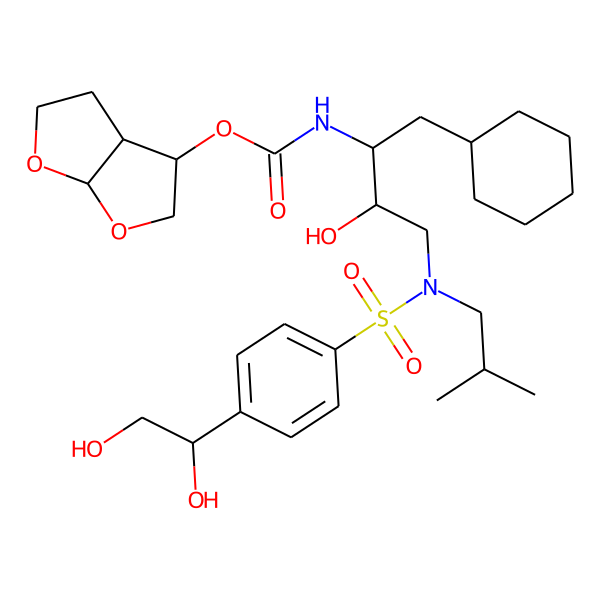

In [159]:
Chem.Draw.MolToImage(mol_draw,(600,600))

In [21]:
# Include UFF optimization of ligand after alignment
from rdkit.Geometry import Point3D
from Bio.PDB import PDBParser
from Bio.PDB import PDBList
from Bio.PDB import CaPPBuilder
from rdkit import Chem
from rdkit.Chem import AllChem
path = '../utils'
if path not in sys.path:
    sys.path.append(path)
from token_coords import get_token_coords
ligand_RMSD_UFF = []
ligand_cent_RMSD_UFF = []
ligand_kabsch_RMSD_UFF = []


import os
os.makedirs('../examples/test/',exist_ok=True)

for item in iter(test_data):
    try:
        df = pd.DataFrame({'seq': [item['seq.txt']], 'smiles': [item['smiles.txt']]})
        dataset = ProteinLigandDataset(df)
        output = list(models[0](dataset))
        pred = output[0]
        C, t, receptor_rmsd = align(item['rec_xyz.pyd'][None],pred['receptor_xyz'][:,1:-1,1])
        ligand_xyz = pred['ligand_frames_xyz']
        ligand_xyz = np.einsum('bij,bnj->bni',C,ligand_xyz)+t
        
        mol = Chem.MolFromSmiles(item['smiles.txt'])
        Chem.AllChem.EmbedMolecule(mol)
        smi, _, tokens, atom_map = get_token_coords(mol)
        conf = mol.GetConformer()
        for i, xyz in enumerate(ligand_xyz.squeeze(0)[1:-1]):
            idx = atom_map[i]
            if idx is not None:
                conf.SetAtomPosition(idx,Point3D(*xyz.astype(np.double)))
        AllChem.UFFOptimizeMolecule(mol)
        mol_pos = mol.GetConformer().GetPositions()
        for idx, idy in enumerate(atom_map):
            if idy is not None:
                ligand_xyz[0, idx+1] = mol_pos[idy]
        
        
        ligand_rmsd = np.nanmean(np.linalg.norm(np.pad(item['lig_xyz.pyd'],((1,1),(0,0)),constant_values=np.nan)-ligand_xyz,axis=-1)[:,1:-1])
        ligand_cent_rmsd = np.linalg.norm(np.nanmean(np.pad(item['lig_xyz.pyd'],((1,1),(0,0)),constant_values=np.nan), axis=0) 
                                          - np.nanmean(ligand_xyz,axis=1),axis=-1)[0]
        _, _, ligand_kabsch_rmsd = align(np.array(item['lig_xyz.pyd'])[~np.isnan(np.mean(np.array(item['lig_xyz.pyd']), axis=1))][None, :],
                                   ligand_xyz[:,1:-1][:, ~np.isnan(np.mean(np.array(item['lig_xyz.pyd']), axis=1))])

        print(item['name.txt'], ligand_rmsd/10, ligand_cent_rmsd/10, ligand_kabsch_rmsd/10)
        ligand_RMSD_UFF.append(ligand_rmsd/10)
        ligand_cent_RMSD_UFF.append(ligand_cent_rmsd/10)
        ligand_kabsch_RMSD_UFF.append(ligand_kabsch_rmsd/10)

        
        
        
    except Exception as e:
        print(e)


[11:15:21] Molecule does not have explicit Hs. Consider calling AddHs()
[11:15:21] Molecule does not have explicit Hs. Consider calling AddHs()
[11:15:21] Molecule does not have explicit Hs. Consider calling AddHs()


6cf7 6.605985427943757 6.555892965468907 0.31693596093791493
6nv7 0.3103162404772014 0.11147332284846678 0.25222439634883065


[11:15:21] Molecule does not have explicit Hs. Consider calling AddHs()
[11:15:22] Molecule does not have explicit Hs. Consider calling AddHs()
[11:15:22] Molecule does not have explicit Hs. Consider calling AddHs()
[11:15:22] Molecule does not have explicit Hs. Consider calling AddHs()
[11:15:22] Molecule does not have explicit Hs. Consider calling AddHs()


6agt 0.6177386370644874 0.1716104596549511 0.18156415387944752
6a87 3.4651289379831938 3.361257376803681 0.21222285655228806


[11:15:22] Molecule does not have explicit Hs. Consider calling AddHs()
[11:15:22] Molecule does not have explicit Hs. Consider calling AddHs()
[11:15:22] Molecule does not have explicit Hs. Consider calling AddHs()


6nw3 0.41546606941581327 0.1311529094474543 0.4272754304635334
6a1c 0.6140506938776774 0.30867016283396154 0.20240667457529232


[11:15:22] Molecule does not have explicit Hs. Consider calling AddHs()
[11:15:22] Molecule does not have explicit Hs. Consider calling AddHs()
[11:15:22] Molecule does not have explicit Hs. Consider calling AddHs()


6jan 0.507513280295271 0.35479500786057955 0.11284106793368695


[11:15:22] Molecule does not have explicit Hs. Consider calling AddHs()
[11:15:23] Molecule does not have explicit Hs. Consider calling AddHs()


5zjy 1.0885439340631253 0.07947276891495751 0.7900756048601149
6jaq 0.517814340135129 0.44862583024203484 0.07699678191385828


[11:15:23] Molecule does not have explicit Hs. Consider calling AddHs()
[11:15:23] Molecule does not have explicit Hs. Consider calling AddHs()
[11:15:23] Molecule does not have explicit Hs. Consider calling AddHs()
[11:15:23] Molecule does not have explicit Hs. Consider calling AddHs()


6i61 0.40367256438643234 0.09444187966815104 0.11309474564314899
5zr3 0.8117537889045072 0.5096041910459477 0.21344301660180315


[11:15:23] Molecule does not have explicit Hs. Consider calling AddHs()
[11:15:23] Molecule does not have explicit Hs. Consider calling AddHs()
[11:15:24] Molecule does not have explicit Hs. Consider calling AddHs()
[11:15:24] Molecule does not have explicit Hs. Consider calling AddHs()


6g27 0.8367141476205788 0.634964763349234 0.13829681064196747
6np2 1.0238074243118878 0.9405635777587408 0.2436507052410553


[11:15:24] Molecule does not have explicit Hs. Consider calling AddHs()
[11:15:24] Molecule does not have explicit Hs. Consider calling AddHs()
[11:15:24] Molecule does not have explicit Hs. Consider calling AddHs()
[11:15:24] Molecule does not have explicit Hs. Consider calling AddHs()


6qgf 0.21295458021651825 0.07420711114301407 0.18409844865977043
6gga 0.5794238255043846 0.20214644986378225 0.01013829159707852


[11:15:24] Molecule does not have explicit Hs. Consider calling AddHs()
[11:15:24] Molecule does not have explicit Hs. Consider calling AddHs()
[11:15:24] Molecule does not have explicit Hs. Consider calling AddHs()
[11:15:24] Molecule does not have explicit Hs. Consider calling AddHs()


6ffe 0.27476349516029314 0.18241202648521412 0.21406423311605627
6jao 0.4143714027558348 0.3973326373102234 0.22306594576608124


[11:15:24] Molecule does not have explicit Hs. Consider calling AddHs()
[11:15:24] Molecule does not have explicit Hs. Consider calling AddHs()
[11:15:24] Molecule does not have explicit Hs. Consider calling AddHs()
[11:15:24] Molecule does not have explicit Hs. Consider calling AddHs()


6gge 0.47037799102423705 0.0853517373969659 0.10611062902973781
6ahs 0.40904220615490444 0.16532405968721187 0.2526867377702855


[11:15:25] Molecule does not have explicit Hs. Consider calling AddHs()
[11:15:25] Molecule does not have explicit Hs. Consider calling AddHs()
[11:15:25] Molecule does not have explicit Hs. Consider calling AddHs()
[11:15:25] Molecule does not have explicit Hs. Consider calling AddHs()


6e7m 2.4593270931858937 2.403679010921501 0.19610750099765853
6k04 0.0942611683920486 0.06394824071655544 0.10475792744920479


[11:15:25] Molecule does not have explicit Hs. Consider calling AddHs()
[11:15:25] Molecule does not have explicit Hs. Consider calling AddHs()
[11:15:25] Molecule does not have explicit Hs. Consider calling AddHs()
[11:15:25] Molecule does not have explicit Hs. Consider calling AddHs()


6e3z 0.1363296290725247 0.03825143478204655 0.05936139392789145
6i64 0.25106235886738537 0.07640310908162681 0.09492574872574881


[11:15:25] Molecule does not have explicit Hs. Consider calling AddHs()
[11:15:25] Molecule does not have explicit Hs. Consider calling AddHs()
[11:15:25] Molecule does not have explicit Hs. Consider calling AddHs()
[11:15:25] Molecule does not have explicit Hs. Consider calling AddHs()


6qlq 0.4179487746906682 0.12481510896164656 0.19861486056508615
6fff 0.36815762471485536 0.0672287157663135 0.21579884650076217


[11:15:25] Molecule does not have explicit Hs. Consider calling AddHs()
[11:15:25] Molecule does not have explicit Hs. Consider calling AddHs()
[11:15:26] Molecule does not have explicit Hs. Consider calling AddHs()
[11:15:26] Molecule does not have explicit Hs. Consider calling AddHs()


6jag 0.5100894512586989 0.40370268954480304 0.08354167620289206
6g2f 0.7510274126686552 0.6425485642208149 0.2453793904192869


[11:15:26] Molecule does not have explicit Hs. Consider calling AddHs()
[11:15:26] Molecule does not have explicit Hs. Consider calling AddHs()
[11:15:26] Molecule does not have explicit Hs. Consider calling AddHs()
[11:15:26] Molecule does not have explicit Hs. Consider calling AddHs()


6i8m 0.3292768267912883 0.2054720279020291 0.15084772038861222
6np5 1.0334899403786735 1.0158713008422686 0.23535509257756373


[11:15:26] Molecule does not have explicit Hs. Consider calling AddHs()
[11:15:26] Molecule does not have explicit Hs. Consider calling AddHs()
[11:15:26] Molecule does not have explicit Hs. Consider calling AddHs()
[11:15:26] Molecule does not have explicit Hs. Consider calling AddHs()


6hop 0.1440659604102995 0.08676992026795101 0.05761736713134756
6i41 0.42961637037561873 0.3818215410348091 0.30755371132200315


[11:15:26] Molecule does not have explicit Hs. Consider calling AddHs()
[11:15:26] Molecule does not have explicit Hs. Consider calling AddHs()
[11:15:26] Molecule does not have explicit Hs. Consider calling AddHs()
[11:15:27] Molecule does not have explicit Hs. Consider calling AddHs()
[11:15:27] Molecule does not have explicit Hs. Consider calling AddHs()
[11:15:27] Molecule does not have explicit Hs. Consider calling AddHs()


6kjd 0.9278124965209695 0.27386078082062537 0.2767265462742613
6gzy 0.7951366269268474 0.6221475837456851 0.14587512423579813


[11:15:27] Molecule does not have explicit Hs. Consider calling AddHs()
[11:15:27] Molecule does not have explicit Hs. Consider calling AddHs()
[11:15:27] Molecule does not have explicit Hs. Consider calling AddHs()
[11:15:27] Molecule does not have explicit Hs. Consider calling AddHs()


5zlf 0.8120452204665518 0.8003300825491474 0.18558010763279942
6g2o 0.6585483439855907 0.6328567011003603 0.25953275483520966


[11:15:27] Molecule does not have explicit Hs. Consider calling AddHs()
[11:15:27] Molecule does not have explicit Hs. Consider calling AddHs()
[11:15:27] Molecule does not have explicit Hs. Consider calling AddHs()


6qlt 0.31894172610042737 0.16338667693007994 0.2154091953019337


[11:15:27] Molecule does not have explicit Hs. Consider calling AddHs()
[11:15:28] Molecule does not have explicit Hs. Consider calling AddHs()
[11:15:28] Molecule does not have explicit Hs. Consider calling AddHs()


6d08 0.30225284054012963 0.23298459393959484 0.24841546886156135
6qlp 0.351231256183011 0.1347138515379372 0.1512537044815285


[11:15:28] Molecule does not have explicit Hs. Consider calling AddHs()
[11:15:28] Molecule does not have explicit Hs. Consider calling AddHs()
[11:15:28] Molecule does not have explicit Hs. Consider calling AddHs()
[11:15:28] Molecule does not have explicit Hs. Consider calling AddHs()


6e3m 0.19525475707953543 0.16983399601546353 0.07033721712003063
6i78 0.4234698628651663 0.18636682589843126 0.3153377982219403


[11:15:28] Molecule does not have explicit Hs. Consider calling AddHs()
[11:15:28] Molecule does not have explicit Hs. Consider calling AddHs()
[11:15:28] Molecule does not have explicit Hs. Consider calling AddHs()


6hhh 0.999942841731774 0.8371166557624189 0.26075638325928313


[11:15:28] Molecule does not have explicit Hs. Consider calling AddHs()
[11:15:28] Molecule does not have explicit Hs. Consider calling AddHs()
[11:15:28] Molecule does not have explicit Hs. Consider calling AddHs()


6hzb 0.8177747500231323 0.34462368862032344 0.3622003510840542
6s56 0.4649020802970771 0.29234334116383887 0.2603400192942334


[11:15:29] Molecule does not have explicit Hs. Consider calling AddHs()
[11:15:29] Molecule does not have explicit Hs. Consider calling AddHs()
[11:15:29] Molecule does not have explicit Hs. Consider calling AddHs()
[11:15:29] Molecule does not have explicit Hs. Consider calling AddHs()


6ggb 0.6922321266058283 0.07110767002076289 0.05630068821361236
6hhp 0.758228321209503 0.4172935720179282 0.33487394532175


[11:15:29] Molecule does not have explicit Hs. Consider calling AddHs()
[11:15:29] Molecule does not have explicit Hs. Consider calling AddHs()


6h13 0.6792792873610507 0.307666848192132 0.2965781366956941
6ibz 0.16341825949960198 0.11037502408261166 0.15986867442626623


[11:15:29] Molecule does not have explicit Hs. Consider calling AddHs()
[11:15:29] Molecule does not have explicit Hs. Consider calling AddHs()
[11:15:29] Molecule does not have explicit Hs. Consider calling AddHs()
[11:15:29] Molecule does not have explicit Hs. Consider calling AddHs()


6i74 0.2177027943439048 0.14978118395886403 0.13751240985940313
6jsf 0.27758121774783984 0.09156051475877564 0.20205135499729693


[11:15:30] Molecule does not have explicit Hs. Consider calling AddHs()
[11:15:30] Molecule does not have explicit Hs. Consider calling AddHs()
[11:15:30] Molecule does not have explicit Hs. Consider calling AddHs()
[11:15:30] Molecule does not have explicit Hs. Consider calling AddHs()


6g2e 0.7726309288100691 0.7157158907265817 0.1998883868533441
6qln 0.1899009492515638 0.12765358449023584 0.11967335321806086


[11:15:30] Molecule does not have explicit Hs. Consider calling AddHs()
[11:15:30] Molecule does not have explicit Hs. Consider calling AddHs()
[11:15:30] Molecule does not have explicit Hs. Consider calling AddHs()


Bad Conformer Id


[11:15:30] Molecule does not have explicit Hs. Consider calling AddHs()
[11:15:30] Molecule does not have explicit Hs. Consider calling AddHs()
[11:15:30] Molecule does not have explicit Hs. Consider calling AddHs()


Bad Conformer Id
6mhb 0.2520358481168997 0.17746951670431793 0.13783603943272482


[11:15:31] Molecule does not have explicit Hs. Consider calling AddHs()
[11:15:31] Molecule does not have explicit Hs. Consider calling AddHs()
[11:15:31] Molecule does not have explicit Hs. Consider calling AddHs()
[11:15:31] Molecule does not have explicit Hs. Consider calling AddHs()


6rot 0.4600379650096519 0.06834677332199887 0.208771176399418
6a6k 0.34458232380734255 0.035827989843897304 0.1519552857156012


[11:15:31] Molecule does not have explicit Hs. Consider calling AddHs()
[11:15:31] Molecule does not have explicit Hs. Consider calling AddHs()
[11:15:31] Molecule does not have explicit Hs. Consider calling AddHs()
[11:15:31] Molecule does not have explicit Hs. Consider calling AddHs()


5zcu 0.31325443429876143 0.1756304259570781 0.209794423564775
6j9y 0.48137511430789165 0.3564374613485344 0.23531533381727548


[11:15:31] Molecule does not have explicit Hs. Consider calling AddHs()
[11:15:31] Molecule does not have explicit Hs. Consider calling AddHs()
[11:15:31] Molecule does not have explicit Hs. Consider calling AddHs()
[11:15:31] Molecule does not have explicit Hs. Consider calling AddHs()


6hv2 1.3703460461664225 0.4755074543804511 0.42657144476260445
6npi 3.4111242973456206 3.4744213780260322 0.08881282432452052


[11:15:32] Molecule does not have explicit Hs. Consider calling AddHs()
[11:15:32] Molecule does not have explicit Hs. Consider calling AddHs()
[11:15:32] Molecule does not have explicit Hs. Consider calling AddHs()
[11:15:32] Molecule does not have explicit Hs. Consider calling AddHs()


6nlj 2.9010946589931033 2.8711683171288986 0.13859973623308536
6n55 0.36676778798561877 0.2885879555038752 0.15613739562093482


[11:15:32] Molecule does not have explicit Hs. Consider calling AddHs()
[11:15:32] Molecule does not have explicit Hs. Consider calling AddHs()
[11:15:32] Molecule does not have explicit Hs. Consider calling AddHs()
[11:15:32] Molecule does not have explicit Hs. Consider calling AddHs()


6g29 0.8276119099805872 0.7580013962982666 0.14142970430141685
6gdy 0.48435481064463237 0.39821895334111906 0.09262337188737159


[11:15:32] Molecule does not have explicit Hs. Consider calling AddHs()
[11:15:32] Molecule does not have explicit Hs. Consider calling AddHs()
[11:15:32] Molecule does not have explicit Hs. Consider calling AddHs()
[11:15:32] Molecule does not have explicit Hs. Consider calling AddHs()


6qlu 0.43171614626734056 0.11053420638577569 0.27593273716246536
6j9w 0.5147615375954422 0.3977974990584868 0.20083618308878629


[11:15:32] Molecule does not have explicit Hs. Consider calling AddHs()
[11:15:32] Molecule does not have explicit Hs. Consider calling AddHs()
[11:15:33] Molecule does not have explicit Hs. Consider calling AddHs()
[11:15:33] Molecule does not have explicit Hs. Consider calling AddHs()


6cjj 0.39124228983730613 0.14720373038646134 0.19926399344809637
6n4e 0.8996965628421503 0.7868023055206413 0.14515150590635828


[11:15:33] Molecule does not have explicit Hs. Consider calling AddHs()
[11:15:33] Molecule does not have explicit Hs. Consider calling AddHs()


6mj4 1.3929851681544991 0.6353699095887302 0.6157852828274818


[11:15:33] Molecule does not have explicit Hs. Consider calling AddHs()
[11:15:33] Molecule does not have explicit Hs. Consider calling AddHs()
[11:15:34] Molecule does not have explicit Hs. Consider calling AddHs()
[11:15:34] Molecule does not have explicit Hs. Consider calling AddHs()


6ott 2.446700451264295 2.4011792534449192 0.26502548834832507
6op0 1.4813756653045236 1.4174429543353544 0.22466502690157902


[11:15:34] Molecule does not have explicit Hs. Consider calling AddHs()
[11:15:34] Molecule does not have explicit Hs. Consider calling AddHs()
[11:15:34] Molecule does not have explicit Hs. Consider calling AddHs()
[11:15:34] Molecule does not have explicit Hs. Consider calling AddHs()


6ooy 1.3221155401728322 1.318031769768312 0.13952813048269255
6nri 0.5950005845320664 0.4329794851346425 0.18014025403315592


[11:15:34] Molecule does not have explicit Hs. Consider calling AddHs()
[11:15:34] Molecule does not have explicit Hs. Consider calling AddHs()


5zk5 1.300145869838393 0.3522566163892652 1.3351380371021755
6hoq 0.1437535896361795 0.0863024010073745 0.05761555068566866


[11:15:35] Molecule does not have explicit Hs. Consider calling AddHs()
[11:15:35] Molecule does not have explicit Hs. Consider calling AddHs()
[11:15:35] Molecule does not have explicit Hs. Consider calling AddHs()
[11:15:35] Molecule does not have explicit Hs. Consider calling AddHs()


6i67 0.24134317433584496 0.21976694471945515 0.05968489741542417
6j06 0.42121412358274657 0.30725150421098407 0.16755416621185523


[11:15:35] Molecule does not have explicit Hs. Consider calling AddHs()
[11:15:35] Molecule does not have explicit Hs. Consider calling AddHs()
[11:15:35] Molecule does not have explicit Hs. Consider calling AddHs()
[11:15:35] Molecule does not have explicit Hs. Consider calling AddHs()


6efk 0.3890793129540662 0.212321304762794 0.2732258520733965


[11:15:35] Molecule does not have explicit Hs. Consider calling AddHs()
[11:15:35] Molecule does not have explicit Hs. Consider calling AddHs()


6hzd 0.8853913239710873 0.3979670505734063 0.6113669774985826
6hhj 1.2018090244622264 1.0482297683132769 0.5294510459554578


[11:15:35] Molecule does not have explicit Hs. Consider calling AddHs()
[11:15:35] Molecule does not have explicit Hs. Consider calling AddHs()
[11:15:36] Molecule does not have explicit Hs. Consider calling AddHs()
[11:15:36] Molecule does not have explicit Hs. Consider calling AddHs()
[11:15:36] Molecule does not have explicit Hs. Consider calling AddHs()
[11:15:36] Molecule does not have explicit Hs. Consider calling AddHs()


6np3 0.9921747373525494 0.9506141067689 0.2652215146608302
6g2c 0.802684146625784 0.6938888537151141 0.20084088761567903


[11:15:36] Molecule does not have explicit Hs. Consider calling AddHs()
[11:15:36] Molecule does not have explicit Hs. Consider calling AddHs()
[11:15:36] Molecule does not have explicit Hs. Consider calling AddHs()
[11:15:36] Molecule does not have explicit Hs. Consider calling AddHs()


6i75 0.18904629863985906 0.13220901015101622 0.19107559953404984
6g3c 0.5839528921459223 0.07433150372522367 0.19464424093354302


[11:15:36] Molecule does not have explicit Hs. Consider calling AddHs()
[11:15:36] Molecule does not have explicit Hs. Consider calling AddHs()


6nd3 1.1540068267539283 1.2080335364964605 0.06432127903468851


[11:15:37] Molecule does not have explicit Hs. Consider calling AddHs()
[11:15:37] Molecule does not have explicit Hs. Consider calling AddHs()


6pka 1.5894055273534218 1.5675131844835675 0.4053729112795269
6h9v 2.8800776667949908 3.101555074847893 0.10541919188826698


[11:15:37] Molecule does not have explicit Hs. Consider calling AddHs()
[11:15:37] Molecule does not have explicit Hs. Consider calling AddHs()
[11:15:38] Molecule does not have explicit Hs. Consider calling AddHs()
[11:15:38] Molecule does not have explicit Hs. Consider calling AddHs()


6k05 0.42305285252030933 0.06619105836245745 0.11786331008314432
6ic0 0.10039770996869583 0.09752089033198655 0.06976008842947587


[11:15:38] Molecule does not have explicit Hs. Consider calling AddHs()
[11:15:38] Molecule does not have explicit Hs. Consider calling AddHs()
[11:15:38] Molecule does not have explicit Hs. Consider calling AddHs()
[11:15:38] Molecule does not have explicit Hs. Consider calling AddHs()


6oxx 0.14223494679760593 0.13079909910977575 0.13314304344048047
6g2b 0.7423141947508372 0.6883922087701897 0.1333044756890593


[11:15:38] Molecule does not have explicit Hs. Consider calling AddHs()
[11:15:38] Molecule does not have explicit Hs. Consider calling AddHs()
[11:15:38] Molecule does not have explicit Hs. Consider calling AddHs()
[11:15:38] Molecule does not have explicit Hs. Consider calling AddHs()


6ftf 2.5127976466276176 2.5121504994961845 0.09532493109290108
6mo0 1.2574970289966414 1.212560414156367 0.18346687017065114


[11:15:38] Molecule does not have explicit Hs. Consider calling AddHs()
[11:15:38] Molecule does not have explicit Hs. Consider calling AddHs()
[11:15:39] Molecule does not have explicit Hs. Consider calling AddHs()
[11:15:39] Molecule does not have explicit Hs. Consider calling AddHs()
[11:15:39] Molecule does not have explicit Hs. Consider calling AddHs()
[11:15:39] Molecule does not have explicit Hs. Consider calling AddHs()


6h14 0.5936749923457876 0.25656442919758254 0.4539378643407745
6m7h 1.1973994405028328 0.8933663195626584 0.2890853683518221


[11:15:39] Molecule does not have explicit Hs. Consider calling AddHs()
[11:15:39] Molecule does not have explicit Hs. Consider calling AddHs()
[11:15:39] Molecule does not have explicit Hs. Consider calling AddHs()
[11:15:39] Molecule does not have explicit Hs. Consider calling AddHs()


6ovz 1.3237980638697087 1.2279277805988484 0.1733235787339705
6oiq 1.901526081936621 1.8802438743913654 0.24793706371068458


[11:15:39] Molecule does not have explicit Hs. Consider calling AddHs()
[11:15:39] Molecule does not have explicit Hs. Consider calling AddHs()


6oxs 0.10248879248390923 0.1106636835409122 0.11521414379935353


[11:15:39] Molecule does not have explicit Hs. Consider calling AddHs()
[11:15:39] Molecule does not have explicit Hs. Consider calling AddHs()


6n94 1.7883530004332506 0.9752989551135695 1.5632638628263715
6ooz 1.403229269721375 1.3897510777122506 0.21832584088179313


[11:15:40] Molecule does not have explicit Hs. Consider calling AddHs()
[11:15:40] Molecule does not have explicit Hs. Consider calling AddHs()
[11:15:40] Molecule does not have explicit Hs. Consider calling AddHs()
[11:15:40] Molecule does not have explicit Hs. Consider calling AddHs()
[11:15:40] Molecule does not have explicit Hs. Consider calling AddHs()
[11:15:40] Molecule does not have explicit Hs. Consider calling AddHs()


6qsz 2.402323898591494 2.249963586678042 0.6879455309175413
6jwa 0.12613603971707732 0.14684809999302945 0.053936672836909574


[11:15:40] Molecule does not have explicit Hs. Consider calling AddHs()
[11:15:40] Molecule does not have explicit Hs. Consider calling AddHs()


6pgp 0.30660783432762184 0.16646999273264088 0.18790147600434387
6e13 1.3802010915518137 1.3466808948105378 0.1496699083857173


[11:15:40] Molecule does not have explicit Hs. Consider calling AddHs()
[11:15:40] Molecule does not have explicit Hs. Consider calling AddHs()
[11:15:41] Molecule does not have explicit Hs. Consider calling AddHs()
[11:15:41] Molecule does not have explicit Hs. Consider calling AddHs()


6s9w 0.9728771767285721 0.9354289799846068 0.29654952792817174


[11:15:41] Molecule does not have explicit Hs. Consider calling AddHs()
[11:15:41] Molecule does not have explicit Hs. Consider calling AddHs()


6d40 0.5899226321076597 0.10354580653921171 0.6060303357610847
6jbe 0.4925522724788377 0.43556226390645125 0.10677891220010449


[11:15:41] Molecule does not have explicit Hs. Consider calling AddHs()
[11:15:41] Molecule does not have explicit Hs. Consider calling AddHs()
[11:15:41] Molecule does not have explicit Hs. Consider calling AddHs()
[11:15:41] Molecule does not have explicit Hs. Consider calling AddHs()


6e5s 2.4263052307482442 2.360653222653206 0.295264375302004


[11:15:42] Molecule does not have explicit Hs. Consider calling AddHs()
[11:15:42] Molecule does not have explicit Hs. Consider calling AddHs()
[11:15:42] Molecule does not have explicit Hs. Consider calling AddHs()


Bad Conformer Id
6oi8 0.2545028384946958 0.042902992686055255 0.3216531180868397


[11:15:42] Molecule does not have explicit Hs. Consider calling AddHs()
[11:15:42] Molecule does not have explicit Hs. Consider calling AddHs()
[11:15:42] Molecule does not have explicit Hs. Consider calling AddHs()
[11:15:42] Molecule does not have explicit Hs. Consider calling AddHs()


6nxz 1.7583570234904584 1.752172885296361 0.08680194422023976
6cjr 0.6343328944824027 0.1740301487284326 0.2103575953808836


[11:15:42] Molecule does not have explicit Hs. Consider calling AddHs()
[11:15:42] Molecule does not have explicit Hs. Consider calling AddHs()
[11:15:42] Molecule does not have explicit Hs. Consider calling AddHs()
[11:15:42] Molecule does not have explicit Hs. Consider calling AddHs()


6kqi 0.7220324530821158 0.11629154370062911 0.23639807153582285
6qtq 0.6065838509823159 0.11554234065876134 0.41714195651601316


[11:15:43] Molecule does not have explicit Hs. Consider calling AddHs()
[11:15:43] Molecule does not have explicit Hs. Consider calling AddHs()
[11:15:43] Molecule does not have explicit Hs. Consider calling AddHs()


6jam 0.44961369333992174 0.4069685431836678 0.19347166410226607


[11:15:43] Molecule does not have explicit Hs. Consider calling AddHs()
[11:15:43] Molecule does not have explicit Hs. Consider calling AddHs()
[11:15:43] Molecule does not have explicit Hs. Consider calling AddHs()


6o9c 0.42560989779247427 0.09714616000955735 0.3231337013977029
6i76 0.5943172758517595 0.3182331910034219 0.3547073966014517


[11:15:43] Molecule does not have explicit Hs. Consider calling AddHs()
[11:15:43] Molecule does not have explicit Hs. Consider calling AddHs()
[11:15:43] Molecule does not have explicit Hs. Consider calling AddHs()
[11:15:43] Molecule does not have explicit Hs. Consider calling AddHs()


6oxq 0.8957294778495057 0.17014968569753278 0.15311989361431835
6jbb 0.41978311649110456 0.3967941381468476 0.19823474676253533


[11:15:43] Molecule does not have explicit Hs. Consider calling AddHs()
[11:15:43] Molecule does not have explicit Hs. Consider calling AddHs()
[11:15:44] Molecule does not have explicit Hs. Consider calling AddHs()
[11:15:44] Molecule does not have explicit Hs. Consider calling AddHs()


6oxt 0.7346662936974805 0.1208625679195344 0.2802329303106935
6n0m 1.5619959082801693 1.6202683554088337 0.11944107927712903


[11:15:44] Molecule does not have explicit Hs. Consider calling AddHs()
[11:15:44] Molecule does not have explicit Hs. Consider calling AddHs()


6a73 2.2974054843030016 2.2399342229767627 0.1792231223983249


[11:15:44] Molecule does not have explicit Hs. Consider calling AddHs()
[11:15:44] Molecule does not have explicit Hs. Consider calling AddHs()
[11:15:44] Molecule does not have explicit Hs. Consider calling AddHs()
[11:15:44] Molecule does not have explicit Hs. Consider calling AddHs()


6r4k 2.1321316883271004 1.9779865744845861 0.2359600188354379
6i66 0.2801052953633028 0.13158144125694088 0.0718022463007281


[11:15:44] Molecule does not have explicit Hs. Consider calling AddHs()
[11:15:44] Molecule does not have explicit Hs. Consider calling AddHs()
[11:15:44] Molecule does not have explicit Hs. Consider calling AddHs()
[11:15:44] Molecule does not have explicit Hs. Consider calling AddHs()


6cyg 0.39384053593036183 0.14932743533194986 0.13357874308458922
6oir 1.904645069340874 1.880177421507825 0.20236966042003587


[11:15:45] Molecule does not have explicit Hs. Consider calling AddHs()
[11:15:45] Molecule does not have explicit Hs. Consider calling AddHs()
[11:15:45] Molecule does not have explicit Hs. Consider calling AddHs()
[11:15:45] Molecule does not have explicit Hs. Consider calling AddHs()


6e3o 0.18240366833877902 0.04386275675839947 0.09483107940059532
6hhr 0.24639897844187653 0.043988435565366434 0.11131941778508274


[11:15:45] Molecule does not have explicit Hs. Consider calling AddHs()
[11:15:45] Molecule does not have explicit Hs. Consider calling AddHs()


6oxw 0.255873195648744 0.0867082839457952 0.27186501860417733
6md6 0.760495723426537 0.6352321909171749 0.1782030610979867


[11:15:45] Molecule does not have explicit Hs. Consider calling AddHs()
[11:15:45] Molecule does not have explicit Hs. Consider calling AddHs()
[11:15:45] Molecule does not have explicit Hs. Consider calling AddHs()
[11:15:45] Molecule does not have explicit Hs. Consider calling AddHs()


6tel 0.7135928964727573 0.2339088354213569 0.30069078170211855


[11:15:45] Molecule does not have explicit Hs. Consider calling AddHs()
[11:15:45] Molecule does not have explicit Hs. Consider calling AddHs()
[11:15:46] Molecule does not have explicit Hs. Consider calling AddHs()
[11:15:46] Molecule does not have explicit Hs. Consider calling AddHs()


6k1s 1.3505080898528856 1.3233276136382013 0.26272147763410436
6npp 3.6462063343068705 3.6317834907920234 0.1307712836906419


[11:15:46] Molecule does not have explicit Hs. Consider calling AddHs()
[11:15:46] Molecule does not have explicit Hs. Consider calling AddHs()
[11:15:46] Molecule does not have explicit Hs. Consider calling AddHs()
[11:15:46] Molecule does not have explicit Hs. Consider calling AddHs()


6uii 0.8507630822471064 0.7719237716750862 0.09958671792661312
6op9 0.3225434262629494 0.1364750713880509 0.1803167282231011


[11:15:46] Molecule does not have explicit Hs. Consider calling AddHs()
[11:15:46] Molecule does not have explicit Hs. Consider calling AddHs()
[11:15:46] Molecule does not have explicit Hs. Consider calling AddHs()


6uvp 0.152726439173803 0.05479046087609433 0.14981734421117784


[11:15:46] Molecule does not have explicit Hs. Consider calling AddHs()


6s07 2.333780795041942 1.84899541515944 1.5411408783973672
6s55 0.7630567445810629 0.2730860857793747 0.27949862530513464


[11:15:47] Molecule does not have explicit Hs. Consider calling AddHs()
[11:15:47] Molecule does not have explicit Hs. Consider calling AddHs()
[11:15:47] Molecule does not have explicit Hs. Consider calling AddHs()
[11:15:47] Molecule does not have explicit Hs. Consider calling AddHs()


6nrh 0.4001658507119415 0.39147495371915964 0.21066380503615142
6i8t 0.32426712030698635 0.19341493458989656 0.1612316932022136


[11:15:47] Molecule does not have explicit Hs. Consider calling AddHs()
[11:15:47] Molecule does not have explicit Hs. Consider calling AddHs()
[11:15:47] Molecule does not have explicit Hs. Consider calling AddHs()
[11:15:47] Molecule does not have explicit Hs. Consider calling AddHs()


6jsz 1.0443650404230316 0.9525102259175352 0.32049891495465566
6jsg 0.050654040606492964 0.019777471675519583 0.05398321977592204


[11:15:47] Molecule does not have explicit Hs. Consider calling AddHs()
[11:15:47] Molecule does not have explicit Hs. Consider calling AddHs()
[11:15:47] Molecule does not have explicit Hs. Consider calling AddHs()
[11:15:47] Molecule does not have explicit Hs. Consider calling AddHs()


6oy2 0.9417116928706388 0.13073002493755045 0.132035265215278
6oio 1.8653029188368193 1.8485675123203578 0.09696686982924142


[11:15:48] Molecule does not have explicit Hs. Consider calling AddHs()
[11:15:48] Molecule does not have explicit Hs. Consider calling AddHs()
[11:15:48] Molecule does not have explicit Hs. Consider calling AddHs()
[11:15:48] Molecule does not have explicit Hs. Consider calling AddHs()


6inz 0.093201706499251 0.07797134529827479 0.09313697174223763
6mo7 0.3234048101146675 0.14236828152698802 0.26095203817427814


[11:15:48] Molecule does not have explicit Hs. Consider calling AddHs()
[11:15:48] Molecule does not have explicit Hs. Consider calling AddHs()
[11:15:48] Molecule does not have explicit Hs. Consider calling AddHs()
[11:15:48] Molecule does not have explicit Hs. Consider calling AddHs()


6uvy 0.5837296819790364 0.11356693797297046 0.20056782698558745
6g9f 1.6779050292505862 1.6405530292768806 0.17571729312644202


[11:15:48] Molecule does not have explicit Hs. Consider calling AddHs()
[11:15:48] Molecule does not have explicit Hs. Consider calling AddHs()
[11:15:48] Molecule does not have explicit Hs. Consider calling AddHs()
[11:15:48] Molecule does not have explicit Hs. Consider calling AddHs()


6ffg 0.6065738935099663 0.12677354343289196 0.25039489114908786
6o3x 0.5333066575706767 0.18694877278143018 0.30179261086638187


[11:15:49] Molecule does not have explicit Hs. Consider calling AddHs()
[11:15:49] Molecule does not have explicit Hs. Consider calling AddHs()
[11:15:49] Molecule does not have explicit Hs. Consider calling AddHs()
[11:15:49] Molecule does not have explicit Hs. Consider calling AddHs()
[11:15:49] Molecule does not have explicit Hs. Consider calling AddHs()
[11:15:49] Molecule does not have explicit Hs. Consider calling AddHs()


6i63 0.38046906938558 0.09998844070584831 0.04127597238724285
6n4b 0.4744303133062958 0.2702704574246533 0.25056642626706493


[11:15:49] Molecule does not have explicit Hs. Consider calling AddHs()
[11:15:49] Molecule does not have explicit Hs. Consider calling AddHs()


6rpg 1.618108104119783 0.5912246461815874 0.8456966009277901


[11:15:49] Molecule does not have explicit Hs. Consider calling AddHs()
[11:15:49] Molecule does not have explicit Hs. Consider calling AddHs()


6qto 0.9008842427015464 0.21225905841285408 1.031086413730407
6quw 1.6480077430622544 1.7246574778812611 0.1550961227941145


[11:15:50] Molecule does not have explicit Hs. Consider calling AddHs()
[11:15:50] Molecule does not have explicit Hs. Consider calling AddHs()
[11:15:50] Molecule does not have explicit Hs. Consider calling AddHs()
[11:15:50] Molecule does not have explicit Hs. Consider calling AddHs()


6st3 0.7444938244549854 0.4978147431777572 0.27189659376730047


[11:15:50] Molecule does not have explicit Hs. Consider calling AddHs()
[11:15:50] Molecule does not have explicit Hs. Consider calling AddHs()


5zk9 2.3803717330608767 0.06852535396775127 2.2292786917411727
6oin 2.0434541377991 2.0446775362753664 0.2010195266014163


[11:15:51] Molecule does not have explicit Hs. Consider calling AddHs()
[11:15:51] Molecule does not have explicit Hs. Consider calling AddHs()
[11:15:51] Molecule does not have explicit Hs. Consider calling AddHs()
[11:15:51] Molecule does not have explicit Hs. Consider calling AddHs()


Bad Conformer Id
6mhc 0.4007132503244385 0.23707290455329866 0.21413350445843865


[11:15:51] Molecule does not have explicit Hs. Consider calling AddHs()
[11:15:51] Molecule does not have explicit Hs. Consider calling AddHs()
[11:15:51] Molecule does not have explicit Hs. Consider calling AddHs()


6oxu 0.925892513643318 0.16200789477508473 0.11198511084204432
6e4c 0.6580310608448909 0.21213066381463533 0.12274482586424092


[11:15:52] Molecule does not have explicit Hs. Consider calling AddHs()
[11:15:52] Molecule does not have explicit Hs. Consider calling AddHs()
[11:15:52] Molecule does not have explicit Hs. Consider calling AddHs()
[11:15:52] Molecule does not have explicit Hs. Consider calling AddHs()


6mo9 3.6539405508519254 3.617501102966627 0.1332476419420432
6jad 0.41135194520504725 0.39697010885115447 0.19448322532063278


[11:15:52] Molecule does not have explicit Hs. Consider calling AddHs()
[11:15:52] Molecule does not have explicit Hs. Consider calling AddHs()
[11:15:52] Molecule does not have explicit Hs. Consider calling AddHs()
[11:15:52] Molecule does not have explicit Hs. Consider calling AddHs()


6quv 1.4676791874313364 1.4470359569295808 0.17090245578000116


[11:15:52] Molecule does not have explicit Hs. Consider calling AddHs()
[11:15:52] Molecule does not have explicit Hs. Consider calling AddHs()


6hlb 1.0202291578844964 0.5429770443934869 0.6212721951606941
6i62 0.4499439732007401 0.11485956113365078 0.11490554818636686


[11:15:53] Molecule does not have explicit Hs. Consider calling AddHs()
[11:15:53] Molecule does not have explicit Hs. Consider calling AddHs()
[11:15:53] Molecule does not have explicit Hs. Consider calling AddHs()
[11:15:53] Molecule does not have explicit Hs. Consider calling AddHs()
[11:15:53] Molecule does not have explicit Hs. Consider calling AddHs()


6i68 0.6839059683374281 0.17844226281846695 0.31315869649282935
6oxr 0.1570610737653134 0.11080970034977422 0.14669681475388816


[11:15:53] Molecule does not have explicit Hs. Consider calling AddHs()
[11:15:53] Molecule does not have explicit Hs. Consider calling AddHs()
[11:15:53] Molecule does not have explicit Hs. Consider calling AddHs()


6qls 0.13121189590972288 0.03497893876093417 0.12311037359770009


[11:15:53] Molecule does not have explicit Hs. Consider calling AddHs()
[11:15:53] Molecule does not have explicit Hs. Consider calling AddHs()


6hld 1.0643474526090162 0.3743183566174902 0.5293348259942057
6pgo 0.49441865805789426 0.3456911623832531 0.1787284373491436


[11:15:54] Molecule does not have explicit Hs. Consider calling AddHs()
[11:15:54] Molecule does not have explicit Hs. Consider calling AddHs()
[11:15:54] Molecule does not have explicit Hs. Consider calling AddHs()
[11:15:54] Molecule does not have explicit Hs. Consider calling AddHs()
[11:15:54] Molecule does not have explicit Hs. Consider calling AddHs()
[11:15:54] Molecule does not have explicit Hs. Consider calling AddHs()


6jmf 0.19468515260364722 0.19038100722300255 0.026312389880927288
6hou 0.4017593229840136 0.22185147848438694 0.006280030757621502


[11:15:54] Molecule does not have explicit Hs. Consider calling AddHs()
[11:15:54] Molecule does not have explicit Hs. Consider calling AddHs()
[11:15:54] Molecule does not have explicit Hs. Consider calling AddHs()
[11:15:54] Molecule does not have explicit Hs. Consider calling AddHs()


6hot 0.5373955632220547 0.20690547057132633 0.11874072899306236
6i9a 1.2114297854609237 0.7823258868405172 0.7103157720349262


[11:15:55] Molecule does not have explicit Hs. Consider calling AddHs()
[11:15:55] Molecule does not have explicit Hs. Consider calling AddHs()


6n97 1.1791219426936963 0.9650716696190154 0.551143640251083


[11:15:55] Molecule does not have explicit Hs. Consider calling AddHs()
[11:15:55] Molecule does not have explicit Hs. Consider calling AddHs()
[11:15:55] Molecule does not have explicit Hs. Consider calling AddHs()
[11:15:55] Molecule does not have explicit Hs. Consider calling AddHs()


6qxd 0.6530444931958316 0.1989978780069999 0.20328409985686516
6hbn 0.46858902782165135 0.18139469933691538 0.15867173148014932


[11:15:55] Molecule does not have explicit Hs. Consider calling AddHs()
[11:15:55] Molecule does not have explicit Hs. Consider calling AddHs()
[11:15:55] Molecule does not have explicit Hs. Consider calling AddHs()
[11:15:55] Molecule does not have explicit Hs. Consider calling AddHs()


6olx 0.1995887808387295 0.022306129277114065 0.22045187044842018
6kjf 0.5623379862369153 0.3162548180535 0.17821510063345175


[11:15:56] Molecule does not have explicit Hs. Consider calling AddHs()


Bad Conformer Id
6qmr 0.4317040627464298 0.09138334619876651 0.23612367401301407


[11:15:56] Molecule does not have explicit Hs. Consider calling AddHs()
[11:15:56] Molecule does not have explicit Hs. Consider calling AddHs()
[11:15:56] Molecule does not have explicit Hs. Consider calling AddHs()
[11:15:56] Molecule does not have explicit Hs. Consider calling AddHs()


6qmt 0.5723472380975381 0.30587661483384015 0.2782720845215426


[11:15:57] Molecule does not have explicit Hs. Consider calling AddHs()
[11:15:57] Molecule does not have explicit Hs. Consider calling AddHs()


6sfc 4.202655246082845 4.221782296043248 0.14199620930785725
6uil 0.7176566968954877 0.5484383640682485 0.19122423090713053


[11:15:57] Molecule does not have explicit Hs. Consider calling AddHs()
[11:15:57] Molecule does not have explicit Hs. Consider calling AddHs()
[11:15:57] Molecule does not have explicit Hs. Consider calling AddHs()
[11:15:57] Molecule does not have explicit Hs. Consider calling AddHs()


6mo8 0.3073448001348641 0.09195127003291284 0.17499714051840945
6p8x 0.8339858695773872 0.31622447579398283 0.1924428500718674


[11:15:57] Molecule does not have explicit Hs. Consider calling AddHs()
[11:15:57] Molecule does not have explicit Hs. Consider calling AddHs()
[11:15:57] Molecule does not have explicit Hs. Consider calling AddHs()
[11:15:57] Molecule does not have explicit Hs. Consider calling AddHs()


6jid 0.31917616456658265 0.2333372565726623 0.19183097097293664


[11:15:58] Molecule does not have explicit Hs. Consider calling AddHs()
[11:15:58] Molecule does not have explicit Hs. Consider calling AddHs()


5ze6 1.0453123137477136 0.9220233183214062 0.34505647900499536


[11:15:58] Molecule does not have explicit Hs. Consider calling AddHs()
[11:15:58] UFFTYPER: Unrecognized hybridization for atom: 17
[11:15:58] UFFTYPER: Unrecognized atom type: Fe (17)
[11:15:58] UFFTYPER: Unrecognized hybridization for atom: 17
[11:15:58] UFFTYPER: Unrecognized atom type: Fe (17)
[11:15:58] Molecule does not have explicit Hs. Consider calling AddHs()


6e4v 1.1827022714409217 0.61452327188961 0.5809367337368138


[11:15:58] Molecule does not have explicit Hs. Consider calling AddHs()
[11:15:58] Molecule does not have explicit Hs. Consider calling AddHs()


6hmy 1.5738697120143246 0.7705786849256673 1.3859422630243872
6pyb 0.5418618274562821 0.25890958506136935 0.20960642382476147


[11:15:58] Molecule does not have explicit Hs. Consider calling AddHs()
[11:15:58] Molecule does not have explicit Hs. Consider calling AddHs()
[11:15:59] Molecule does not have explicit Hs. Consider calling AddHs()
[11:15:59] Molecule does not have explicit Hs. Consider calling AddHs()
[11:15:59] Molecule does not have explicit Hs. Consider calling AddHs()
[11:15:59] Molecule does not have explicit Hs. Consider calling AddHs()


6rz6 1.2073060918161185 1.113964793489989 0.4717962749515272
6pz4 0.1528337510733363 0.0496679971856268 0.11276659629040324


[11:15:59] Molecule does not have explicit Hs. Consider calling AddHs()
[11:15:59] Molecule does not have explicit Hs. Consider calling AddHs()
[11:15:59] Molecule does not have explicit Hs. Consider calling AddHs()


6fe5 0.09566384248601148 0.12212373683545259 0.0783796003268332


[11:15:59] Molecule does not have explicit Hs. Consider calling AddHs()


6om4 1.7038733865269289 1.2965649684035139 0.6914123327245905


[11:15:59] Molecule does not have explicit Hs. Consider calling AddHs()
[11:15:59] Molecule does not have explicit Hs. Consider calling AddHs()


6nv9 0.3683633179540177 0.1507544002998038 0.3577933328580195
6cyh 0.4088796797386983 0.18042607642270586 0.1577315173734531


[11:16:00] Molecule does not have explicit Hs. Consider calling AddHs()
[11:16:00] Molecule does not have explicit Hs. Consider calling AddHs()
[11:16:00] Molecule does not have explicit Hs. Consider calling AddHs()
[11:16:00] Molecule does not have explicit Hs. Consider calling AddHs()
[11:16:00] Molecule does not have explicit Hs. Consider calling AddHs()


6qwi 2.0101812942617228 1.8170234033271595 0.12872325471377874
6te6 0.7901074950757141 0.41993637112392806 0.23777608722886936


[11:16:00] Molecule does not have explicit Hs. Consider calling AddHs()
[11:16:00] Molecule does not have explicit Hs. Consider calling AddHs()
[11:16:00] Molecule does not have explicit Hs. Consider calling AddHs()


6qi7 0.19953160114835963 0.10148678048656093 0.1005237288551915
6oip 2.0719197690356266 2.024978912983902 0.1304241048176094


[11:16:00] Molecule does not have explicit Hs. Consider calling AddHs()
[11:16:00] Molecule does not have explicit Hs. Consider calling AddHs()
[11:16:01] Molecule does not have explicit Hs. Consider calling AddHs()
[11:16:01] Molecule does not have explicit Hs. Consider calling AddHs()


6h12 0.7720618125282389 0.15944079794789734 0.3257256176815416
6s57 0.7785920551034174 0.3958947902621195 0.17708531587204301


[11:16:01] Molecule does not have explicit Hs. Consider calling AddHs()
[11:16:01] Molecule does not have explicit Hs. Consider calling AddHs()
[11:16:01] Molecule does not have explicit Hs. Consider calling AddHs()
[11:16:01] Molecule does not have explicit Hs. Consider calling AddHs()


6k2n 2.240479113253329 2.021917376361767 0.4257475382965124


[11:16:01] Molecule does not have explicit Hs. Consider calling AddHs()
[11:16:01] Molecule does not have explicit Hs. Consider calling AddHs()


6oxz 0.9355205260369027 0.1430270297885543 0.13802095478399337
6jb0 0.6597903000271181 0.39568544102109315 0.19688882023304508


[11:16:02] Molecule does not have explicit Hs. Consider calling AddHs()
[11:16:02] Molecule does not have explicit Hs. Consider calling AddHs()
[11:16:02] Molecule does not have explicit Hs. Consider calling AddHs()
[11:16:02] Molecule does not have explicit Hs. Consider calling AddHs()
[11:16:02] Molecule does not have explicit Hs. Consider calling AddHs()


6o3y 0.5111773349960264 0.041091550269832355 0.49773102818028453
6g5u 0.2555466246949725 0.14977667071034684 0.14887324515309558


[11:16:02] Molecule does not have explicit Hs. Consider calling AddHs()
[11:16:02] Molecule does not have explicit Hs. Consider calling AddHs()
[11:16:02] Molecule does not have explicit Hs. Consider calling AddHs()


6qtr 0.7533458614252789 0.34366163128707433 0.7603531958507477


[11:16:03] Molecule does not have explicit Hs. Consider calling AddHs()
[11:16:03] Molecule does not have explicit Hs. Consider calling AddHs()
[11:16:03] Molecule does not have explicit Hs. Consider calling AddHs()
[11:16:03] Molecule does not have explicit Hs. Consider calling AddHs()


6d5w 0.45229504352765504 0.3700613619930265 0.12804478937216177
6pnm 0.2455004918490249 0.14697213230722003 0.22196197091297862


[11:16:03] Molecule does not have explicit Hs. Consider calling AddHs()
[11:16:03] Molecule does not have explicit Hs. Consider calling AddHs()
[11:16:03] Molecule does not have explicit Hs. Consider calling AddHs()


6p8y 0.7372707165927306 0.33373415891975655 0.33224243000435916


[11:16:03] Molecule does not have explicit Hs. Consider calling AddHs()
[11:16:04] Molecule does not have explicit Hs. Consider calling AddHs()


6i5p 0.34562892992392286 0.279869297776652 0.32925065642549334


[11:16:04] Molecule does not have explicit Hs. Consider calling AddHs()


6qts 0.5672543014855739 0.15681088586337283 0.43582057370943605


[11:16:04] Molecule does not have explicit Hs. Consider calling AddHs()
[11:16:04] Molecule does not have explicit Hs. Consider calling AddHs()


Bad Conformer Id
6iby 0.13815322212878145 0.10060383522180713 0.14470081039740518


[11:16:04] Molecule does not have explicit Hs. Consider calling AddHs()
[11:16:04] Molecule does not have explicit Hs. Consider calling AddHs()
[11:16:04] Molecule does not have explicit Hs. Consider calling AddHs()


6i65 0.1725898149095965 0.1267646058211428 0.11127621913014749
6e3n 0.18610156809756234 0.06172939710711667 0.13345264506557575


[11:16:04] Molecule does not have explicit Hs. Consider calling AddHs()
[11:16:04] Molecule does not have explicit Hs. Consider calling AddHs()
[11:16:05] Molecule does not have explicit Hs. Consider calling AddHs()
[11:16:05] Molecule does not have explicit Hs. Consider calling AddHs()
[11:16:05] Molecule does not have explicit Hs. Consider calling AddHs()
[11:16:05] Molecule does not have explicit Hs. Consider calling AddHs()


6ueg 1.89106178058241 1.7707968424545215 0.1815505191829096
6oxp 0.9018742058081759 0.19050067673255766 0.11189105644312433


[11:16:05] Molecule does not have explicit Hs. Consider calling AddHs()
[11:16:05] Molecule does not have explicit Hs. Consider calling AddHs()


6oy0 0.9888181877984412 0.08847197929160362 0.24889358267574516


[11:16:05] Molecule does not have explicit Hs. Consider calling AddHs()
[11:16:05] Molecule does not have explicit Hs. Consider calling AddHs()


6hle 1.1177048021609255 0.4718374642662792 0.455829784117425
6ibx 0.15457266324443544 0.13466293325136258 0.1453477126975009


[11:16:05] Molecule does not have explicit Hs. Consider calling AddHs()
[11:16:05] Molecule does not have explicit Hs. Consider calling AddHs()
[11:16:06] Molecule does not have explicit Hs. Consider calling AddHs()
[11:16:06] Molecule does not have explicit Hs. Consider calling AddHs()
[11:16:06] Molecule does not have explicit Hs. Consider calling AddHs()
[11:16:06] Molecule does not have explicit Hs. Consider calling AddHs()


6qlo 0.2019528516807858 0.12255481879834933 0.11630561517918336
6rnu 3.217231049090176 3.1557567795053485 0.09866199469386193


[11:16:06] Molecule does not have explicit Hs. Consider calling AddHs()
[11:16:06] Molecule does not have explicit Hs. Consider calling AddHs()
[11:16:06] Molecule does not have explicit Hs. Consider calling AddHs()
[11:16:06] Molecule does not have explicit Hs. Consider calling AddHs()


6ckl 3.1632979744934078 3.1314281020966312 0.1662643577586484
6uwp 0.6975582094091702 0.14075318573523163 0.2065451067230532


[11:16:06] Molecule does not have explicit Hs. Consider calling AddHs()
[11:16:06] Molecule does not have explicit Hs. Consider calling AddHs()
[11:16:07] Molecule does not have explicit Hs. Consider calling AddHs()
[11:16:07] Molecule does not have explicit Hs. Consider calling AddHs()


6uwv 0.7353247538650177 0.14912591752774532 0.17492640562447215
6n53 0.5037345038145034 0.18954051187556276 0.2187834998346813


[11:16:07] Molecule does not have explicit Hs. Consider calling AddHs()
[11:16:07] Molecule does not have explicit Hs. Consider calling AddHs()


6d3y 0.6764028713233514 0.11144144109941342 0.6213298307594454


[11:16:07] Molecule does not have explicit Hs. Consider calling AddHs()
[11:16:08] Molecule does not have explicit Hs. Consider calling AddHs()


6d3z 2.575843190413778 0.04174907903981493 2.7128783979255298


[11:16:08] Molecule does not have explicit Hs. Consider calling AddHs()
[11:16:08] Molecule does not have explicit Hs. Consider calling AddHs()


6hza 0.893628678994577 0.36999376789894173 0.6967952803774523
6e6v 0.0867338439247716 0.08226486129716312 0.04255470965310178


[11:16:08] Molecule does not have explicit Hs. Consider calling AddHs()
[11:16:08] Molecule does not have explicit Hs. Consider calling AddHs()
[11:16:08] Molecule does not have explicit Hs. Consider calling AddHs()
[11:16:08] Molecule does not have explicit Hs. Consider calling AddHs()
[11:16:09] Molecule does not have explicit Hs. Consider calling AddHs()
[11:16:09] Molecule does not have explicit Hs. Consider calling AddHs()


5zk7 1.8112449314490178 1.5127438430974194 0.3461753649540167
6pno 0.3792244903013655 0.19050675255410449 0.20686143677948152


[11:16:09] Molecule does not have explicit Hs. Consider calling AddHs()
[11:16:09] Molecule does not have explicit Hs. Consider calling AddHs()
[11:16:09] Molecule does not have explicit Hs. Consider calling AddHs()


6qzh 2.6621187084613873 2.675836229171673 0.3070289293254565
6qlr 0.24082460531557787 0.11844133930301744 0.13768501159216387


[11:16:09] Molecule does not have explicit Hs. Consider calling AddHs()
[11:16:09] Molecule does not have explicit Hs. Consider calling AddHs()
[11:16:09] Molecule does not have explicit Hs. Consider calling AddHs()


6oim 0.44559172913044093 0.35146097465834664 0.24727881013247038


[11:16:09] Molecule does not have explicit Hs. Consider calling AddHs()
[11:16:09] Molecule does not have explicit Hs. Consider calling AddHs()
[11:16:09] Molecule does not have explicit Hs. Consider calling AddHs()
[11:16:10] Molecule does not have explicit Hs. Consider calling AddHs()


6ufo 0.8939691717296844 0.7023899108099226 0.16370044363253772
6i77 0.2612870891333839 0.15163651795664662 0.22185932508157555


[11:16:10] Molecule does not have explicit Hs. Consider calling AddHs()
[11:16:10] Molecule does not have explicit Hs. Consider calling AddHs()


6o9b 0.3275542960332153 0.15855098889944147 0.3037485551067137
6pnn 0.4454170962925502 0.15676605071815902 0.2629322337625736


[11:16:10] Molecule does not have explicit Hs. Consider calling AddHs()
[11:16:10] Molecule does not have explicit Hs. Consider calling AddHs()
[11:16:10] Molecule does not have explicit Hs. Consider calling AddHs()
[11:16:10] Molecule does not have explicit Hs. Consider calling AddHs()
[11:16:10] Molecule does not have explicit Hs. Consider calling AddHs()


6d07 0.3338363579806357 0.24260558579185063 0.2715923792304111
6mhd 0.5951290149326011 0.2989385896538776 0.15081930291604942


[11:16:10] Molecule does not have explicit Hs. Consider calling AddHs()
[11:16:11] Molecule does not have explicit Hs. Consider calling AddHs()
[11:16:11] Molecule does not have explicit Hs. Consider calling AddHs()


6oy1 0.9279401983295928 0.1291073905744837 0.18301723360833771


[11:16:11] Molecule does not have explicit Hs. Consider calling AddHs()
[11:16:11] Molecule does not have explicit Hs. Consider calling AddHs()


6hzc 0.9534110345614778 0.1763091830097228 0.6399412984945505
6fcj 0.40469636394821273 0.048568502530961476 0.17010033574935665


[11:16:11] Molecule does not have explicit Hs. Consider calling AddHs()
[11:16:11] Molecule does not have explicit Hs. Consider calling AddHs()
[11:16:11] Molecule does not have explicit Hs. Consider calling AddHs()
[11:16:11] Molecule does not have explicit Hs. Consider calling AddHs()


6oxy 0.1435209999180727 0.11414869224281757 0.14526544084458795
6ten 0.8346271297550267 0.2994054449196525 0.31251705201942637


[11:16:11] Molecule does not have explicit Hs. Consider calling AddHs()
[11:16:11] Molecule does not have explicit Hs. Consider calling AddHs()
[11:16:12] Molecule does not have explicit Hs. Consider calling AddHs()
[11:16:12] Molecule does not have explicit Hs. Consider calling AddHs()


6mji 1.0430388506283144 0.6030577284040831 0.7227179467930085
6c85 0.8165253752935439 0.7516582722712877 0.031161533104915408


[11:16:12] Molecule does not have explicit Hs. Consider calling AddHs()
[11:16:12] Molecule does not have explicit Hs. Consider calling AddHs()
[11:16:12] Molecule does not have explicit Hs. Consider calling AddHs()
[11:16:12] Molecule does not have explicit Hs. Consider calling AddHs()


6cjs 0.839807997425835 0.7041318577193982 0.37238541565223504
6uim 0.6122371256673322 0.5627680277120247 0.132089005930942


[11:16:12] Molecule does not have explicit Hs. Consider calling AddHs()
[11:16:12] Molecule does not have explicit Hs. Consider calling AddHs()
[11:16:12] Molecule does not have explicit Hs. Consider calling AddHs()
[11:16:12] Molecule does not have explicit Hs. Consider calling AddHs()


6qtm 2.5349965028506385 2.393883821761293 0.5810735140801657
6ggf 0.4168548867657744 0.0776760269955857 0.013178261146145731


[11:16:13] Molecule does not have explicit Hs. Consider calling AddHs()
[11:16:13] Molecule does not have explicit Hs. Consider calling AddHs()
[11:16:13] Molecule does not have explicit Hs. Consider calling AddHs()
[11:16:13] Molecule does not have explicit Hs. Consider calling AddHs()
[11:16:13] Molecule does not have explicit Hs. Consider calling AddHs()
[11:16:13] Molecule does not have explicit Hs. Consider calling AddHs()


6n92 1.087307492006839 0.9414069312031449 0.4156227057620242
6oxv 0.9168698070529254 0.14215487817021238 0.17742492510209712


[11:16:13] Molecule does not have explicit Hs. Consider calling AddHs()
[11:16:13] Molecule does not have explicit Hs. Consider calling AddHs()
[11:16:13] Molecule does not have explicit Hs. Consider calling AddHs()
[11:16:13] Molecule does not have explicit Hs. Consider calling AddHs()


6jt3 0.3736346215805437 0.048570696760846785 0.20089296723516498
6o5u 1.2123832309652771 1.0132316806101225 0.41693847074314067


[11:16:13] Molecule does not have explicit Hs. Consider calling AddHs()
[11:16:14] Molecule does not have explicit Hs. Consider calling AddHs()
[11:16:14] Molecule does not have explicit Hs. Consider calling AddHs()
[11:16:14] Molecule does not have explicit Hs. Consider calling AddHs()


6ufn 1.0018169272234996 0.6620926342780329 0.15459155983671907
6jse 0.4808392152940044 0.07672626270950578 0.25282990934515076


[11:16:14] Molecule does not have explicit Hs. Consider calling AddHs()
[11:16:14] Molecule does not have explicit Hs. Consider calling AddHs()


6qtw 0.6928235484384317 0.20172244307829024 0.500267803965355


[11:16:14] Molecule does not have explicit Hs. Consider calling AddHs()
[11:16:14] Molecule does not have explicit Hs. Consider calling AddHs()


6hhg 0.6851091891318931 0.39934161863289763 0.5045882049843434


[11:16:14] Molecule does not have explicit Hs. Consider calling AddHs()
[11:16:14] Molecule does not have explicit Hs. Consider calling AddHs()


6n93 1.3138263987891383 0.9622696193814189 0.869553487436708


[11:16:15] Molecule does not have explicit Hs. Consider calling AddHs()
[11:16:15] Molecule does not have explicit Hs. Consider calling AddHs()
[11:16:15] Molecule does not have explicit Hs. Consider calling AddHs()
[11:16:15] Molecule does not have explicit Hs. Consider calling AddHs()


6o0h 1.2064238383753942 1.1539970930001182 0.14919490132277058
6qw8 0.1190856509127279 0.046851118956903005 0.09363118220603714


[11:16:15] Molecule does not have explicit Hs. Consider calling AddHs()
[11:16:15] Molecule does not have explicit Hs. Consider calling AddHs()
[11:16:15] Molecule does not have explicit Hs. Consider calling AddHs()
[11:16:15] Molecule does not have explicit Hs. Consider calling AddHs()


6od6 0.08258213275417708 0.0830533121893696 0.04084026911136891
6ggd 0.3355150178637588 0.06334260613690867 0.07391774954696184


[11:16:15] Molecule does not have explicit Hs. Consider calling AddHs()
[11:16:15] Molecule does not have explicit Hs. Consider calling AddHs()
[11:16:15] Molecule does not have explicit Hs. Consider calling AddHs()
[11:16:15] Molecule does not have explicit Hs. Consider calling AddHs()


6izq 0.5576008146974734 0.4117098651697855 0.13762871297449092
6s9x 0.7320109985814189 0.5645369414219044 0.35211865805979115
6jon 1.0566115870030361 0.9090455981589198 0.23858369036238686


[11:16:16] Molecule does not have explicit Hs. Consider calling AddHs()
[11:16:16] Molecule does not have explicit Hs. Consider calling AddHs()
[11:16:16] Molecule does not have explicit Hs. Consider calling AddHs()
[11:16:16] Molecule does not have explicit Hs. Consider calling AddHs()
[11:16:16] Molecule does not have explicit Hs. Consider calling AddHs()


6jib 0.5847887262450954 0.3036814629497224 0.08817994127995814


[11:16:16] Molecule does not have explicit Hs. Consider calling AddHs()


6d3x 2.150792909781895 0.1288137763111778 1.8469828875865304
6jap 0.4994925247724695 0.4043310524538467 0.15157142474971014


[11:16:16] Molecule does not have explicit Hs. Consider calling AddHs()
[11:16:16] Molecule does not have explicit Hs. Consider calling AddHs()
[11:16:17] Molecule does not have explicit Hs. Consider calling AddHs()
[11:16:17] Molecule does not have explicit Hs. Consider calling AddHs()


6uvv 0.465698324604121 0.046618800334228876 0.1379357977756012
6h7d 1.0919516890066563 1.1546938919426009 0.1033821819008309


[11:16:17] Molecule does not have explicit Hs. Consider calling AddHs()
[11:16:17] Molecule does not have explicit Hs. Consider calling AddHs()
[11:16:17] Molecule does not have explicit Hs. Consider calling AddHs()
[11:16:17] Molecule does not have explicit Hs. Consider calling AddHs()


5zml 5.324106081188804 0.12413399644155643 5.0018401318290735
6hmt 0.7566007580406653 0.410991354845211 0.3361665760242132


[11:16:18] Molecule does not have explicit Hs. Consider calling AddHs()
[11:16:18] Molecule does not have explicit Hs. Consider calling AddHs()
[11:16:18] Molecule does not have explicit Hs. Consider calling AddHs()
[11:16:18] Molecule does not have explicit Hs. Consider calling AddHs()


6py0 1.956168337378528 1.9303180781747042 0.1581024890168329
6r7d 1.0357659982091596 0.8790947455633212 0.27835345547496154


[11:16:18] Molecule does not have explicit Hs. Consider calling AddHs()
[11:16:18] Molecule does not have explicit Hs. Consider calling AddHs()
[11:16:18] Molecule does not have explicit Hs. Consider calling AddHs()
[11:16:18] Molecule does not have explicit Hs. Consider calling AddHs()


6n8x 0.19748539217711808 0.023269006431530688 0.22037535894386


[11:16:18] Molecule does not have explicit Hs. Consider calling AddHs()


Bad Conformer Id


[11:16:19] Molecule does not have explicit Hs. Consider calling AddHs()
[11:16:19] Molecule does not have explicit Hs. Consider calling AddHs()


6qtx 0.6446636826589337 0.21878147197501518 0.44491957836723967
6hhi 1.3275786215565644 0.9762828511947614 0.34852383743994125


[11:16:19] Molecule does not have explicit Hs. Consider calling AddHs()
[11:16:19] Molecule does not have explicit Hs. Consider calling AddHs()
[11:16:19] Molecule does not have explicit Hs. Consider calling AddHs()
[11:16:19] Molecule does not have explicit Hs. Consider calling AddHs()


6jb4 0.36844632561639823 0.36070107658460526 0.14365453862489475
6gbw 0.6257171768326532 0.1203419342968545 0.33415347262493617


[11:16:19] Molecule does not have explicit Hs. Consider calling AddHs()
[11:16:19] Molecule does not have explicit Hs. Consider calling AddHs()
[11:16:19] Molecule does not have explicit Hs. Consider calling AddHs()
[11:16:19] Molecule does not have explicit Hs. Consider calling AddHs()


6npm 3.5376775856806773 3.515250707765739 0.140209621247588
6n96 4.84596250048093 4.837817910323073 0.15967278323028705


[11:16:19] Molecule does not have explicit Hs. Consider calling AddHs()
[11:16:19] Molecule does not have explicit Hs. Consider calling AddHs()
[11:16:20] Molecule does not have explicit Hs. Consider calling AddHs()
[11:16:20] Molecule does not have explicit Hs. Consider calling AddHs()


6p8z 0.9265946422117632 0.7441153868599908 0.2929626391151364
6g24 1.8498192872718444 1.822596434754026 0.15668608805296855


[11:16:20] Molecule does not have explicit Hs. Consider calling AddHs()
[11:16:20] Molecule does not have explicit Hs. Consider calling AddHs()
[11:16:20] Molecule does not have explicit Hs. Consider calling AddHs()
[11:16:20] Molecule does not have explicit Hs. Consider calling AddHs()


6jsn 0.17608525788628634 0.05502381509766341 0.12088943801645018
5zxk 0.29242722146808814 0.1731251374218198 0.1492720143615903


[11:16:20] Molecule does not have explicit Hs. Consider calling AddHs()
[11:16:20] Molecule does not have explicit Hs. Consider calling AddHs()
[11:16:20] Molecule does not have explicit Hs. Consider calling AddHs()
[11:16:20] Molecule does not have explicit Hs. Consider calling AddHs()


6hor 0.5584783555113404 0.15421370515191493 0.10416896308621904
6k3l 0.2040750584841015 0.06739115929537264 0.19261642068996027


[11:16:20] Molecule does not have explicit Hs. Consider calling AddHs()
[11:16:20] Molecule does not have explicit Hs. Consider calling AddHs()
[11:16:20] Molecule does not have explicit Hs. Consider calling AddHs()
[11:16:21] Molecule does not have explicit Hs. Consider calling AddHs()


6cjp 0.5763658056065155 0.2916083270680843 0.1833846374118437
6n9l 1.648247113367964 1.6356390808754289 0.2138347889948074


[11:16:21] Molecule does not have explicit Hs. Consider calling AddHs()
[11:16:21] Molecule does not have explicit Hs. Consider calling AddHs()
[11:16:21] Molecule does not have explicit Hs. Consider calling AddHs()
[11:16:21] Molecule does not have explicit Hs. Consider calling AddHs()


6np4 1.011145872181745 1.0052617731354636 0.23987433819536852
6uhv 0.6072066029428385 0.5714216808541823 0.1323468748611975


[11:16:21] Molecule does not have explicit Hs. Consider calling AddHs()
[11:16:21] Molecule does not have explicit Hs. Consider calling AddHs()
[11:16:21] Molecule does not have explicit Hs. Consider calling AddHs()


6rr0 2.641679405968355 2.2094160197836796 0.9291176780387819


[11:16:21] Molecule does not have explicit Hs. Consider calling AddHs()


In [22]:
# Include UFF optimization of ligand after alignment and fix COM
from rdkit.Geometry import Point3D
from Bio.PDB import PDBParser
from Bio.PDB import PDBList
from Bio.PDB import CaPPBuilder
from rdkit import Chem
from rdkit.Chem import AllChem
path = '../utils'
if path not in sys.path:
    sys.path.append(path)
from token_coords import get_token_coords
ligand_RMSD_UFF_fix = []
ligand_cent_RMSD_UFF_fix = []
ligand_kabsch_RMSD_UFF_fix = []


import os
os.makedirs('../examples/test/',exist_ok=True)

for item in iter(test_data):
    try:
        df = pd.DataFrame({'seq': [item['seq.txt']], 'smiles': [item['smiles.txt']]})
        dataset = ProteinLigandDataset(df)
        output = list(models[0](dataset))
        pred = output[0]
        C, t, receptor_rmsd = align(item['rec_xyz.pyd'][None],pred['receptor_xyz'][:,1:-1,1])
        ligand_xyz = pred['ligand_frames_xyz']
        ligand_xyz = np.einsum('bij,bnj->bni',C,ligand_xyz)+t
        ligand_xyz_com_pre = np.mean(ligand_xyz[:, 1:-1][:, ~np.isnan(np.mean(np.array(item['lig_xyz.pyd']), axis=1))], axis=1)[0]
        mol = Chem.MolFromSmiles(item['smiles.txt'])
        Chem.AllChem.EmbedMolecule(mol)
        smi, _, tokens, atom_map = get_token_coords(mol)
        conf = mol.GetConformer()
        for i, xyz in enumerate(ligand_xyz.squeeze(0)[1:-1]):
            idx = atom_map[i]
            if idx is not None:
                conf.SetAtomPosition(idx,Point3D(*xyz.astype(np.double)))
        AllChem.UFFOptimizeMolecule(mol)
        mol_pos = mol.GetConformer().GetPositions()
        ligand_xyz_com_post = np.mean(mol_pos, axis=0)
        for idx, idy in enumerate(atom_map):
            if idy is not None:
                ligand_xyz[0, idx+1] = mol_pos[idy] - ligand_xyz_com_post + ligand_xyz_com_pre

        
        ligand_rmsd = np.nanmean(np.linalg.norm(np.pad(item['lig_xyz.pyd'],((1,1),(0,0)),constant_values=np.nan)-ligand_xyz,axis=-1)[:,1:-1])
        ligand_cent_rmsd = np.linalg.norm(np.nanmean(np.pad(item['lig_xyz.pyd'],((1,1),(0,0)),constant_values=np.nan), axis=0) 
                                          - np.nanmean(ligand_xyz,axis=1),axis=-1)[0]
        _, _, ligand_kabsch_rmsd = align(np.array(item['lig_xyz.pyd'])[~np.isnan(np.mean(np.array(item['lig_xyz.pyd']), axis=1))][None, :],
                                   ligand_xyz[:,1:-1][:, ~np.isnan(np.mean(np.array(item['lig_xyz.pyd']), axis=1))])

        print(item['name.txt'], ligand_rmsd/10, ligand_cent_rmsd/10, ligand_kabsch_rmsd/10)
        ligand_RMSD_UFF_fix.append(ligand_rmsd/10)
        ligand_cent_RMSD_UFF_fix.append(ligand_cent_rmsd/10)
        ligand_kabsch_RMSD_UFF_fix.append(ligand_kabsch_rmsd/10)

        
        
        
    except Exception as e:
        print(e)


[11:16:22] Molecule does not have explicit Hs. Consider calling AddHs()
[11:16:22] Molecule does not have explicit Hs. Consider calling AddHs()
[11:16:22] Molecule does not have explicit Hs. Consider calling AddHs()
[11:16:22] Molecule does not have explicit Hs. Consider calling AddHs()


6k3l 0.20407505848410104 0.06739115929537283 0.19261642068996027
6py0 1.9561683373785237 1.9303180781747025 0.15810248901683255


[11:16:22] Molecule does not have explicit Hs. Consider calling AddHs()
[11:16:22] Molecule does not have explicit Hs. Consider calling AddHs()


6k04 0.09426116839207256 0.06394824071657597 0.10475792744920479


[11:16:22] Molecule does not have explicit Hs. Consider calling AddHs()
[11:16:22] Molecule does not have explicit Hs. Consider calling AddHs()
[11:16:22] Molecule does not have explicit Hs. Consider calling AddHs()
[11:16:22] Molecule does not have explicit Hs. Consider calling AddHs()


6ueg 1.8910617805824192 1.7707968424545264 0.1815505191829095
6qln 0.18990094925156412 0.1276535844902378 0.11967335321806147


[11:16:22] Molecule does not have explicit Hs. Consider calling AddHs()
[11:16:22] Molecule does not have explicit Hs. Consider calling AddHs()


6hza 0.893628678994622 0.3699937678990096 0.6967952803774522
6qgf 0.21295458021652341 0.07420711114301129 0.18409844865977043


[11:16:23] Molecule does not have explicit Hs. Consider calling AddHs()
[11:16:23] Molecule does not have explicit Hs. Consider calling AddHs()
[11:16:23] Molecule does not have explicit Hs. Consider calling AddHs()
[11:16:23] Molecule does not have explicit Hs. Consider calling AddHs()


6s57 0.7785920551034242 0.39589479026212554 0.17708531587204301
6i8t 0.324267120306999 0.19341493458991135 0.16123169320221384


[11:16:23] Molecule does not have explicit Hs. Consider calling AddHs()
[11:16:23] Molecule does not have explicit Hs. Consider calling AddHs()
[11:16:23] Molecule does not have explicit Hs. Consider calling AddHs()
[11:16:23] Molecule does not have explicit Hs. Consider calling AddHs()


6qlo 0.20195285168078744 0.12255481879834537 0.11630561517918306
6n9l 1.6482471133680285 1.6356390808754644 0.21383478899480773


[11:16:23] Molecule does not have explicit Hs. Consider calling AddHs()
[11:16:23] Molecule does not have explicit Hs. Consider calling AddHs()
[11:16:23] Molecule does not have explicit Hs. Consider calling AddHs()
[11:16:23] Molecule does not have explicit Hs. Consider calling AddHs()


6ggb 0.6922321266058244 0.07110767002074575 0.05630068821361236
6i65 0.17258981490959677 0.12676460582114407 0.11127621913014749


[11:16:24] Molecule does not have explicit Hs. Consider calling AddHs()
[11:16:24] Molecule does not have explicit Hs. Consider calling AddHs()
[11:16:24] Molecule does not have explicit Hs. Consider calling AddHs()
[11:16:24] Molecule does not have explicit Hs. Consider calling AddHs()


6g5u 0.2555466246949553 0.14977667071032988 0.14887324515309558
6np4 1.01114587218161 1.005261773135381 0.23987433819536852


[11:16:24] Molecule does not have explicit Hs. Consider calling AddHs()
[11:16:24] Molecule does not have explicit Hs. Consider calling AddHs()
[11:16:24] Molecule does not have explicit Hs. Consider calling AddHs()
[11:16:24] Molecule does not have explicit Hs. Consider calling AddHs()


6a6k 0.3445823238073437 0.035827989843875384 0.1519552857156008


[11:16:24] Molecule does not have explicit Hs. Consider calling AddHs()
[11:16:24] Molecule does not have explicit Hs. Consider calling AddHs()
[11:16:24] Molecule does not have explicit Hs. Consider calling AddHs()


Bad Conformer Id
6jao 0.4143714027558022 0.39733263731020363 0.22306594576608113


[11:16:24] Molecule does not have explicit Hs. Consider calling AddHs()
[11:16:25] Molecule does not have explicit Hs. Consider calling AddHs()
[11:16:25] Molecule does not have explicit Hs. Consider calling AddHs()
[11:16:25] Molecule does not have explicit Hs. Consider calling AddHs()


6o5u 1.2123832309665423 1.0132316806110795 0.4169384707431402
5zk7 1.8112449314482884 1.512743843096948 0.34617536495401685


[11:16:25] Molecule does not have explicit Hs. Consider calling AddHs()
[11:16:25] Molecule does not have explicit Hs. Consider calling AddHs()
[11:16:25] Molecule does not have explicit Hs. Consider calling AddHs()


6ckl 3.163297974516302 3.131428102107836 0.16626435775864823
5ze6 1.0453123137474853 0.9220233183211679 0.34505647900499553


[11:16:25] Molecule does not have explicit Hs. Consider calling AddHs()
[11:16:25] Molecule does not have explicit Hs. Consider calling AddHs()
[11:16:25] Molecule does not have explicit Hs. Consider calling AddHs()


6g2b 0.7423141947554555 0.6883922087748016 0.1333044756890594
6hhg 0.6851091891434796 0.39934161864173384 0.5045882049843434


[11:16:25] Molecule does not have explicit Hs. Consider calling AddHs()
[11:16:25] Molecule does not have explicit Hs. Consider calling AddHs()
[11:16:26] Molecule does not have explicit Hs. Consider calling AddHs()
[11:16:26] Molecule does not have explicit Hs. Consider calling AddHs()
[11:16:26] Molecule does not have explicit Hs. Consider calling AddHs()


6olx 0.19958878083873524 0.02230612927711024 0.22045187044842018


[11:16:26] Molecule does not have explicit Hs. Consider calling AddHs()


6d3y 0.6764028713233532 0.11144144109941852 0.6213298307594456
6e7m 2.4593270931859017 2.4036790109215063 0.19610750099765867


[11:16:26] Molecule does not have explicit Hs. Consider calling AddHs()
[11:16:26] Molecule does not have explicit Hs. Consider calling AddHs()
[11:16:26] Molecule does not have explicit Hs. Consider calling AddHs()
[11:16:26] Molecule does not have explicit Hs. Consider calling AddHs()


6i63 0.3804690693855799 0.0999884407058442 0.04127597238724366


[11:16:27] Molecule does not have explicit Hs. Consider calling AddHs()
[11:16:27] Molecule does not have explicit Hs. Consider calling AddHs()


6hzd 0.8853913239707406 0.3979670505729695 0.6113669774985829


[11:16:27] Molecule does not have explicit Hs. Consider calling AddHs()
[11:16:27] Molecule does not have explicit Hs. Consider calling AddHs()


6d07 0.3338363579806231 0.2426055857918373 0.27159237923041013
6h9v 2.8800776667949872 3.101555074847891 0.1054191918882671


[11:16:27] Molecule does not have explicit Hs. Consider calling AddHs()
[11:16:27] Molecule does not have explicit Hs. Consider calling AddHs()
[11:16:27] Molecule does not have explicit Hs. Consider calling AddHs()
[11:16:27] Molecule does not have explicit Hs. Consider calling AddHs()


6rot 0.4600379650094764 0.06834677332170579 0.208771176399418
6j9w 0.5147615375955008 0.39779749905853473 0.20083618308878629


[11:16:27] Molecule does not have explicit Hs. Consider calling AddHs()
[11:16:27] Molecule does not have explicit Hs. Consider calling AddHs()
[11:16:28] Molecule does not have explicit Hs. Consider calling AddHs()
[11:16:28] Molecule does not have explicit Hs. Consider calling AddHs()


6d3x 2.1507929097819223 0.12881377631133242 1.84698288758653
6hhh 0.9999428417317697 0.8371166557624156 0.2607563832592838


[11:16:28] Molecule does not have explicit Hs. Consider calling AddHs()
[11:16:28] Molecule does not have explicit Hs. Consider calling AddHs()
[11:16:28] Molecule does not have explicit Hs. Consider calling AddHs()
[11:16:28] Molecule does not have explicit Hs. Consider calling AddHs()
[11:16:29] Molecule does not have explicit Hs. Consider calling AddHs()
[11:16:29] Molecule does not have explicit Hs. Consider calling AddHs()


6nv7 0.3103162404771947 0.11147332284849451 0.2522243963488303
6cjs 0.8398079974258474 0.704131857719407 0.37238541565223515


[11:16:29] Molecule does not have explicit Hs. Consider calling AddHs()
[11:16:29] Molecule does not have explicit Hs. Consider calling AddHs()
[11:16:29] Molecule does not have explicit Hs. Consider calling AddHs()


6fff 0.36815762471485697 0.06722871576631814 0.21579884650076187


[11:16:29] Molecule does not have explicit Hs. Consider calling AddHs()
[11:16:29] Molecule does not have explicit Hs. Consider calling AddHs()
[11:16:29] Molecule does not have explicit Hs. Consider calling AddHs()


6hzb 0.8177747500231272 0.3446236886203131 0.3622003510840542
6ffe 0.27476349516013154 0.18241202648507374 0.21406423311605619


[11:16:29] Molecule does not have explicit Hs. Consider calling AddHs()
[11:16:29] Molecule does not have explicit Hs. Consider calling AddHs()
[11:16:29] Molecule does not have explicit Hs. Consider calling AddHs()
[11:16:29] Molecule does not have explicit Hs. Consider calling AddHs()


6ggf 0.41685488676566623 0.07767602699513362 0.013178261146143932
6jb4 0.36844632561639723 0.3607010765846046 0.1436545386248945


[11:16:30] Molecule does not have explicit Hs. Consider calling AddHs()
[11:16:30] Molecule does not have explicit Hs. Consider calling AddHs()
[11:16:30] Molecule does not have explicit Hs. Consider calling AddHs()
[11:16:30] Molecule does not have explicit Hs. Consider calling AddHs()


6jbe 0.49255227247883626 0.43556226390645003 0.10677891220010435
6g2o 0.6585483439854763 0.6328567011002855 0.2595327548352096


[11:16:30] Molecule does not have explicit Hs. Consider calling AddHs()
[11:16:30] Molecule does not have explicit Hs. Consider calling AddHs()
[11:16:30] Molecule does not have explicit Hs. Consider calling AddHs()


6d5w 0.45229504352763616 0.37006136199301226 0.12804478937216177


[11:16:30] Molecule does not have explicit Hs. Consider calling AddHs()
[11:16:30] Molecule does not have explicit Hs. Consider calling AddHs()


6o9c 0.4256098977925202 0.09714616000963666 0.3231337013977036
6i68 0.6839059683372819 0.17844226281817288 0.3131586964928299


[11:16:30] Molecule does not have explicit Hs. Consider calling AddHs()
[11:16:31] Molecule does not have explicit Hs. Consider calling AddHs()
[11:16:31] Molecule does not have explicit Hs. Consider calling AddHs()
[11:16:31] Molecule does not have explicit Hs. Consider calling AddHs()


6h14 0.5936749923458025 0.25656442919760597 0.45393786434077477


[11:16:31] Molecule does not have explicit Hs. Consider calling AddHs()
[11:16:31] Molecule does not have explicit Hs. Consider calling AddHs()
[11:16:31] Molecule does not have explicit Hs. Consider calling AddHs()


6d08 0.30225284053920154 0.23298459393789872 0.24841546886156135
6gzy 0.7951366269268566 0.6221475837456942 0.14587512423579824


[11:16:31] Molecule does not have explicit Hs. Consider calling AddHs()
[11:16:31] Molecule does not have explicit Hs. Consider calling AddHs()
[11:16:31] Molecule does not have explicit Hs. Consider calling AddHs()
[11:16:31] Molecule does not have explicit Hs. Consider calling AddHs()


6i64 0.2510623588673882 0.07640310908164163 0.09492574872574881
6jsf 0.2775812177478426 0.09156051475877769 0.20205135499729673


[11:16:31] Molecule does not have explicit Hs. Consider calling AddHs()
[11:16:31] Molecule does not have explicit Hs. Consider calling AddHs()
[11:16:32] Molecule does not have explicit Hs. Consider calling AddHs()
[11:16:32] Molecule does not have explicit Hs. Consider calling AddHs()


6qlr 0.24082460531557373 0.11844133930301493 0.13768501159216412
6kjd 0.9278124964900816 0.27386078076881937 0.27672654627426146


[11:16:32] Molecule does not have explicit Hs. Consider calling AddHs()
[11:16:32] Molecule does not have explicit Hs. Consider calling AddHs()
[11:16:32] Molecule does not have explicit Hs. Consider calling AddHs()
[11:16:32] Molecule does not have explicit Hs. Consider calling AddHs()


6j9y 0.48137511430788693 0.35643746134853055 0.23531533381727548
6nxz 1.7583570234904577 1.7521728852963605 0.08680194422023987


[11:16:32] Molecule does not have explicit Hs. Consider calling AddHs()
[11:16:32] Molecule does not have explicit Hs. Consider calling AddHs()


6mo9 3.6539405508509772 3.6175011029660986 0.13324764194204303


[11:16:32] Molecule does not have explicit Hs. Consider calling AddHs()
[11:16:32] Molecule does not have explicit Hs. Consider calling AddHs()
[11:16:32] Molecule does not have explicit Hs. Consider calling AddHs()
[11:16:32] Molecule does not have explicit Hs. Consider calling AddHs()


6k1s 1.3505080898564765 1.3233276136402883 0.26272147763410436
6quv 1.4676791874313355 1.4470359569295839 0.17090245578000113


[11:16:33] Molecule does not have explicit Hs. Consider calling AddHs()
[11:16:33] Molecule does not have explicit Hs. Consider calling AddHs()
[11:16:33] Molecule does not have explicit Hs. Consider calling AddHs()
[11:16:33] Molecule does not have explicit Hs. Consider calling AddHs()


6jwa 0.1261360397170685 0.14684809999302245 0.053936672836909824
6npp 3.64620633430685 3.631783490792011 0.13077128369064225


[11:16:33] Molecule does not have explicit Hs. Consider calling AddHs()
[11:16:33] Molecule does not have explicit Hs. Consider calling AddHs()
[11:16:33] Molecule does not have explicit Hs. Consider calling AddHs()


6jsg 0.050654040606493166 0.019777471675521626 0.05398321977592204


[11:16:33] Molecule does not have explicit Hs. Consider calling AddHs()


6o3y 0.5111773349960186 0.041091550269979196 0.49773102818028453


[11:16:33] Molecule does not have explicit Hs. Consider calling AddHs()
[11:16:33] Molecule does not have explicit Hs. Consider calling AddHs()
[11:16:34] Molecule does not have explicit Hs. Consider calling AddHs()


6k2n 2.240479113253135 2.0219173763616376 0.42574753829651246
6hhi 1.3275786215565546 0.9762828511947544 0.3485238374399411


[11:16:34] Molecule does not have explicit Hs. Consider calling AddHs()
[11:16:34] Molecule does not have explicit Hs. Consider calling AddHs()
[11:16:34] Molecule does not have explicit Hs. Consider calling AddHs()


6i9a 1.2114297854683134 0.7823258868403605 0.7103157720349262


[11:16:34] Molecule does not have explicit Hs. Consider calling AddHs()
[11:16:34] Molecule does not have explicit Hs. Consider calling AddHs()


6n97 1.1791219426937243 0.9650716696190333 0.551143640251083
6fe5 0.09566384248592376 0.12212373683540576 0.07837960032683283


[11:16:34] Molecule does not have explicit Hs. Consider calling AddHs()
[11:16:34] Molecule does not have explicit Hs. Consider calling AddHs()
[11:16:34] Molecule does not have explicit Hs. Consider calling AddHs()
[11:16:34] Molecule does not have explicit Hs. Consider calling AddHs()


6mo8 0.30734480011793064 0.09195127002206563 0.17499714051840945
6e3z 0.13632962907264373 0.03825143478237383 0.05936139392789145


[11:16:35] Molecule does not have explicit Hs. Consider calling AddHs()
[11:16:35] Molecule does not have explicit Hs. Consider calling AddHs()
[11:16:35] Molecule does not have explicit Hs. Consider calling AddHs()
[11:16:35] Molecule does not have explicit Hs. Consider calling AddHs()


6jmf 0.1946851526036561 0.19038100722300727 0.026312389880927288
6mo7 0.32340481011466793 0.142368281526987 0.26095203817427837


[11:16:35] Molecule does not have explicit Hs. Consider calling AddHs()
[11:16:35] Molecule does not have explicit Hs. Consider calling AddHs()
[11:16:35] Molecule does not have explicit Hs. Consider calling AddHs()
[11:16:35] Molecule does not have explicit Hs. Consider calling AddHs()


6n53 0.5037345038144591 0.18954051187539758 0.2187834998346813


[11:16:35] Molecule does not have explicit Hs. Consider calling AddHs()
[11:16:35] Molecule does not have explicit Hs. Consider calling AddHs()
[11:16:35] Molecule does not have explicit Hs. Consider calling AddHs()


6o0h 1.206423838375144 1.1539970929999739 0.14919490132277033
6o3x 0.5333066575706138 0.1869487727812591 0.30179261086638187


[11:16:35] Molecule does not have explicit Hs. Consider calling AddHs()
[11:16:36] Molecule does not have explicit Hs. Consider calling AddHs()
[11:16:36] Molecule does not have explicit Hs. Consider calling AddHs()


6gge 0.4703779909892223 0.08535173731179471 0.10611062902973781
6hmt 0.7566007580406684 0.4109913548452074 0.33616657602421307


[11:16:36] Molecule does not have explicit Hs. Consider calling AddHs()
[11:16:36] Molecule does not have explicit Hs. Consider calling AddHs()
[11:16:36] Molecule does not have explicit Hs. Consider calling AddHs()
[11:16:36] Molecule does not have explicit Hs. Consider calling AddHs()
[11:16:36] Molecule does not have explicit Hs. Consider calling AddHs()
[11:16:36] Molecule does not have explicit Hs. Consider calling AddHs()


6nrh 0.4001658507119384 0.3914749537191574 0.21066380503615162
6jad 0.41135194520503904 0.39697010885114864 0.19448322532063267


[11:16:36] Molecule does not have explicit Hs. Consider calling AddHs()
[11:16:36] Molecule does not have explicit Hs. Consider calling AddHs()
[11:16:36] Molecule does not have explicit Hs. Consider calling AddHs()


6oiq 1.9015260819366024 1.880243874391354 0.2479370637106844


[11:16:37] Molecule does not have explicit Hs. Consider calling AddHs()


6hmy 1.5738697120141592 0.7705786849254749 1.3859422630243872


[11:16:37] Molecule does not have explicit Hs. Consider calling AddHs()
[11:16:37] Molecule does not have explicit Hs. Consider calling AddHs()
[11:16:37] Molecule does not have explicit Hs. Consider calling AddHs()


Bad Conformer Id
6ovz 1.3237980638699183 1.2279277805989923 0.17332357873397036


[11:16:37] Molecule does not have explicit Hs. Consider calling AddHs()
[11:16:37] Molecule does not have explicit Hs. Consider calling AddHs()
[11:16:37] Molecule does not have explicit Hs. Consider calling AddHs()
[11:16:37] Molecule does not have explicit Hs. Consider calling AddHs()


6g2c 0.8026841466256774 0.6938888537150361 0.20084088761567903
6oxx 0.1422349467971576 0.13079909910921975 0.13314304344048047


[11:16:37] Molecule does not have explicit Hs. Consider calling AddHs()
[11:16:37] Molecule does not have explicit Hs. Consider calling AddHs()
[11:16:38] Molecule does not have explicit Hs. Consider calling AddHs()
[11:16:38] Molecule does not have explicit Hs. Consider calling AddHs()


6cyh 0.4088796797395096 0.18042607642363767 0.15773151737345276
6jap 0.4994925247724842 0.4043310524538583 0.15157142474971047


[11:16:38] Molecule does not have explicit Hs. Consider calling AddHs()
[11:16:38] Molecule does not have explicit Hs. Consider calling AddHs()
[11:16:38] Molecule does not have explicit Hs. Consider calling AddHs()


6oxw 0.2558731956487433 0.08670828394577075 0.271865018604177
6pnn 0.44541709629256926 0.15676605071817962 0.2629322337625736


[11:16:38] Molecule does not have explicit Hs. Consider calling AddHs()
[11:16:38] Molecule does not have explicit Hs. Consider calling AddHs()
[11:16:38] Molecule does not have explicit Hs. Consider calling AddHs()


6i67 0.24134317433591507 0.21976694471946262 0.05968489741542439
6hbn 0.46858902781991507 0.18139469933233396 0.15867173148014932


[11:16:38] Molecule does not have explicit Hs. Consider calling AddHs()
[11:16:38] Molecule does not have explicit Hs. Consider calling AddHs()
[11:16:38] Molecule does not have explicit Hs. Consider calling AddHs()
[11:16:38] Molecule does not have explicit Hs. Consider calling AddHs()


6od6 0.08258213275417713 0.08305331218936772 0.04084026911136987
6i66 0.28010529536330314 0.13158144125694102 0.07180224630072836


[11:16:39] Molecule does not have explicit Hs. Consider calling AddHs()
[11:16:39] Molecule does not have explicit Hs. Consider calling AddHs()
[11:16:39] Molecule does not have explicit Hs. Consider calling AddHs()
[11:16:39] Molecule does not have explicit Hs. Consider calling AddHs()


6oxz 0.935520526036915 0.14302702978858783 0.13802095478399337
6op0 1.4813756653045183 1.417442954335351 0.2246650269015789


[11:16:39] Molecule does not have explicit Hs. Consider calling AddHs()
[11:16:39] Molecule does not have explicit Hs. Consider calling AddHs()
[11:16:39] Molecule does not have explicit Hs. Consider calling AddHs()
[11:16:39] Molecule does not have explicit Hs. Consider calling AddHs()


6i5p 0.34562892992391897 0.27986929777664554 0.32925065642549345


[11:16:39] Molecule does not have explicit Hs. Consider calling AddHs()
[11:16:39] Molecule does not have explicit Hs. Consider calling AddHs()


6n92 1.0873074920068082 0.9414069312031261 0.41562270576202415
6n8x 0.19748539217710842 0.023269006431541926 0.22037535894386


[11:16:39] Molecule does not have explicit Hs. Consider calling AddHs()
[11:16:39] Molecule does not have explicit Hs. Consider calling AddHs()
[11:16:40] Molecule does not have explicit Hs. Consider calling AddHs()
[11:16:40] Molecule does not have explicit Hs. Consider calling AddHs()
[11:16:40] Molecule does not have explicit Hs. Consider calling AddHs()
[11:16:40] Molecule does not have explicit Hs. Consider calling AddHs()


6md6 0.7604957230179875 0.635232190654839 0.17820306109798695
6oio 1.8653029188368173 1.8485675123203567 0.09696686982924188


[11:16:40] Molecule does not have explicit Hs. Consider calling AddHs()
[11:16:40] Molecule does not have explicit Hs. Consider calling AddHs()
[11:16:40] Molecule does not have explicit Hs. Consider calling AddHs()


6g9f 1.6779050292505922 1.640553029276883 0.17571729312644185


[11:16:40] Molecule does not have explicit Hs. Consider calling AddHs()


6d3z 2.5758431904138113 0.04174907903912243 2.7128783979255293
6gga 0.5794238255044022 0.20214644986381183 0.010138291597072616


[11:16:41] Molecule does not have explicit Hs. Consider calling AddHs()
[11:16:41] Molecule does not have explicit Hs. Consider calling AddHs()
[11:16:41] Molecule does not have explicit Hs. Consider calling AddHs()
[11:16:41] Molecule does not have explicit Hs. Consider calling AddHs()


6oxr 0.15706107376584433 0.110809700350748 0.14669681475388777
6nri 0.595000584531986 0.43297948513471596 0.1801402540331563


[11:16:41] Molecule does not have explicit Hs. Consider calling AddHs()
[11:16:41] Molecule does not have explicit Hs. Consider calling AddHs()
[11:16:41] Molecule does not have explicit Hs. Consider calling AddHs()
[11:16:41] Molecule does not have explicit Hs. Consider calling AddHs()


6iby 0.13815322212873396 0.10060383522175029 0.1447008103974054


[11:16:41] Molecule does not have explicit Hs. Consider calling AddHs()
[11:16:42] Molecule does not have explicit Hs. Consider calling AddHs()


Bad Conformer Id


[11:16:42] Molecule does not have explicit Hs. Consider calling AddHs()


5zml 5.324106081188871 0.12413399644184393 5.001840131829073
6hoq 0.14375358963595847 0.08630240100805638 0.0576155506856683


[11:16:42] Molecule does not have explicit Hs. Consider calling AddHs()
[11:16:42] Molecule does not have explicit Hs. Consider calling AddHs()
[11:16:42] Molecule does not have explicit Hs. Consider calling AddHs()
[11:16:42] Molecule does not have explicit Hs. Consider calling AddHs()


6g3c 0.5839528921459273 0.07433150372522396 0.1946442409335431
6i75 0.18904629863984984 0.1322090101510001 0.19107559953404984


[11:16:43] Molecule does not have explicit Hs. Consider calling AddHs()
[11:16:43] Molecule does not have explicit Hs. Consider calling AddHs()
[11:16:43] Molecule does not have explicit Hs. Consider calling AddHs()
[11:16:43] Molecule does not have explicit Hs. Consider calling AddHs()


6miy 1.7617959989733472 0.6993263179669928 1.05116055623995
6ffg 0.6065738935098572 0.1267735434325811 0.25039489114908786


[11:16:43] Molecule does not have explicit Hs. Consider calling AddHs()
[11:16:43] Molecule does not have explicit Hs. Consider calling AddHs()
[11:16:43] Molecule does not have explicit Hs. Consider calling AddHs()
[11:16:43] Molecule does not have explicit Hs. Consider calling AddHs()


6n55 0.36676778798559145 0.28858795550385097 0.15613739562093498
6i78 0.4234698628651711 0.1863668258984384 0.3153377982219403


[11:16:43] Molecule does not have explicit Hs. Consider calling AddHs()
[11:16:43] Molecule does not have explicit Hs. Consider calling AddHs()
[11:16:44] Molecule does not have explicit Hs. Consider calling AddHs()
[11:16:44] Molecule does not have explicit Hs. Consider calling AddHs()


5zr3 0.81175378890432 0.5096041910457717 0.21344301660180287
6n4e 0.8996965628421499 0.7868023055206412 0.14515150590635856


[11:16:44] Molecule does not have explicit Hs. Consider calling AddHs()
[11:16:44] Molecule does not have explicit Hs. Consider calling AddHs()
[11:16:44] Molecule does not have explicit Hs. Consider calling AddHs()
[11:16:44] Molecule does not have explicit Hs. Consider calling AddHs()


6oir 1.9046450693758292 1.88017742152844 0.2023696604200361


[11:16:44] Molecule does not have explicit Hs. Consider calling AddHs()
[11:16:44] Molecule does not have explicit Hs. Consider calling AddHs()
[11:16:44] Molecule does not have explicit Hs. Consider calling AddHs()
[11:16:44] Molecule does not have explicit Hs. Consider calling AddHs()


6sfc 4.202655246082773 4.221782296043203 0.14199620930785725
6cjj 0.3912422898374735 0.14720373038662976 0.1992639934480967


[11:16:44] Molecule does not have explicit Hs. Consider calling AddHs()
[11:16:44] Molecule does not have explicit Hs. Consider calling AddHs()
[11:16:45] Molecule does not have explicit Hs. Consider calling AddHs()


6oxt 0.7346662936974829 0.12086256791953524 0.2802329303106936
6ten 0.8346271297550155 0.29940544491963184 0.3125170520194265


[11:16:45] Molecule does not have explicit Hs. Consider calling AddHs()
[11:16:45] Molecule does not have explicit Hs. Consider calling AddHs()
[11:16:45] Molecule does not have explicit Hs. Consider calling AddHs()


6n96 4.845962500480819 4.837817910323014 0.15967278323028775


[11:16:45] Molecule does not have explicit Hs. Consider calling AddHs()
[11:16:45] Molecule does not have explicit Hs. Consider calling AddHs()


6d40 0.5899226321076597 0.1035458065391871 0.6060303357610843
6pgo 0.49441865805786794 0.3456911623832391 0.1787284373491436


[11:16:45] Molecule does not have explicit Hs. Consider calling AddHs()
[11:16:45] Molecule does not have explicit Hs. Consider calling AddHs()
[11:16:46] Molecule does not have explicit Hs. Consider calling AddHs()
[11:16:46] Molecule does not have explicit Hs. Consider calling AddHs()
[11:16:46] Molecule does not have explicit Hs. Consider calling AddHs()
[11:16:46] Molecule does not have explicit Hs. Consider calling AddHs()


6ott 2.446700451271876 2.4011792534531238 0.26502548834832523
6p8x 0.8339858695774176 0.3162244757940339 0.1924428500718674


[11:16:46] Molecule does not have explicit Hs. Consider calling AddHs()
[11:16:46] Molecule does not have explicit Hs. Consider calling AddHs()
[11:16:46] Molecule does not have explicit Hs. Consider calling AddHs()
[11:16:46] Molecule does not have explicit Hs. Consider calling AddHs()


6qwi 2.0101812942618564 1.817023403327245 0.12872325471377874
6hor 0.5584783555113227 0.15421370515188118 0.10416896308621884


[11:16:47] Molecule does not have explicit Hs. Consider calling AddHs()
[11:16:47] Molecule does not have explicit Hs. Consider calling AddHs()


6n94 1.7883530004402466 0.9752989551251463 1.5632638628263713
6ufn 1.0018169272233304 0.6620926342778757 0.15459155983671907


[11:16:47] Molecule does not have explicit Hs. Consider calling AddHs()
[11:16:47] Molecule does not have explicit Hs. Consider calling AddHs()
[11:16:47] Molecule does not have explicit Hs. Consider calling AddHs()
[11:16:47] Molecule does not have explicit Hs. Consider calling AddHs()


6pgp 0.30660783432762206 0.16646999273264207 0.18790147600434387


[11:16:48] Molecule does not have explicit Hs. Consider calling AddHs()
[11:16:48] Molecule does not have explicit Hs. Consider calling AddHs()


6pka 1.5894055273541576 1.5675131844839796 0.4053729112795268
6ufo 0.8939691717296718 0.7023899108098994 0.16370044363253772


[11:16:48] Molecule does not have explicit Hs. Consider calling AddHs()
[11:16:48] Molecule does not have explicit Hs. Consider calling AddHs()
[11:16:49] Molecule does not have explicit Hs. Consider calling AddHs()
[11:16:49] Molecule does not have explicit Hs. Consider calling AddHs()


6oi8 0.2545028384947087 0.04290299268606856 0.3216531180868396
6ic0 0.10039770996870685 0.09752089033198602 0.06976008842947543


[11:16:49] Molecule does not have explicit Hs. Consider calling AddHs()
[11:16:49] Molecule does not have explicit Hs. Consider calling AddHs()
[11:16:49] Molecule does not have explicit Hs. Consider calling AddHs()
[11:16:49] Molecule does not have explicit Hs. Consider calling AddHs()
[11:16:49] Molecule does not have explicit Hs. Consider calling AddHs()
[11:16:49] Molecule does not have explicit Hs. Consider calling AddHs()


6qsz 2.402323898591414 2.2499635866779975 0.6879455309175413
6np5 1.0334899403786797 1.0158713008422686 0.23535509257756368


[11:16:49] Molecule does not have explicit Hs. Consider calling AddHs()
[11:16:49] Molecule does not have explicit Hs. Consider calling AddHs()
[11:16:49] Molecule does not have explicit Hs. Consider calling AddHs()


6oy2 0.9417116928706267 0.13073002493751013 0.132035265215278
6hhp 0.7582283212095018 0.417293572017915 0.33487394532175


[11:16:49] Molecule does not have explicit Hs. Consider calling AddHs()
[11:16:50] Molecule does not have explicit Hs. Consider calling AddHs()
[11:16:50] Molecule does not have explicit Hs. Consider calling AddHs()


6qtr 0.7533458614252763 0.34366163128707 0.7603531958507477


[11:16:50] Molecule does not have explicit Hs. Consider calling AddHs()
[11:16:50] Molecule does not have explicit Hs. Consider calling AddHs()
[11:16:50] Molecule does not have explicit Hs. Consider calling AddHs()


6qzh 2.6621187084613833 2.6758362291716704 0.30702892932545633


[11:16:50] Molecule does not have explicit Hs. Consider calling AddHs()
[11:16:51] Molecule does not have explicit Hs. Consider calling AddHs()


6hlb 1.0202291578845064 0.5429770443934931 0.6212721951606939


[11:16:51] Molecule does not have explicit Hs. Consider calling AddHs()
[11:16:51] Molecule does not have explicit Hs. Consider calling AddHs()
[11:16:51] Molecule does not have explicit Hs. Consider calling AddHs()


6hld 1.0643474526090217 0.374318356617498 0.5293348259942054
6hot 0.5373955632220571 0.2069054705713293 0.11874072899306229


[11:16:51] Molecule does not have explicit Hs. Consider calling AddHs()
[11:16:51] Molecule does not have explicit Hs. Consider calling AddHs()


6jsz 1.0443650404230613 0.9525102259175536 0.3204989149546556


[11:16:51] Molecule does not have explicit Hs. Consider calling AddHs()
[11:16:51] Molecule does not have explicit Hs. Consider calling AddHs()


6mj4 1.3929851681543808 0.6353699095885215 0.6157852828274822
6m7h 1.1973994405027204 0.8933663195625948 0.28908536835182197


[11:16:52] Molecule does not have explicit Hs. Consider calling AddHs()
[11:16:52] Molecule does not have explicit Hs. Consider calling AddHs()
[11:16:52] Molecule does not have explicit Hs. Consider calling AddHs()
[11:16:52] Molecule does not have explicit Hs. Consider calling AddHs()


6oin 2.0434541378015547 2.044677536276864 0.2010195266014163
6mhb 0.2520358481169003 0.17746951670431863 0.13783603943272482


[11:16:52] Molecule does not have explicit Hs. Consider calling AddHs()
[11:16:52] Molecule does not have explicit Hs. Consider calling AddHs()
[11:16:52] Molecule does not have explicit Hs. Consider calling AddHs()
[11:16:52] Molecule does not have explicit Hs. Consider calling AddHs()
[11:16:52] Molecule does not have explicit Hs. Consider calling AddHs()


6hle 1.1177048021609124 0.4718374642662663 0.45582978411742514
6qtq 0.606583850982314 0.11554234065875715 0.41714195651601316


[11:16:52] Molecule does not have explicit Hs. Consider calling AddHs()
[11:16:52] Molecule does not have explicit Hs. Consider calling AddHs()
[11:16:52] Molecule does not have explicit Hs. Consider calling AddHs()


6i76 0.5943172758517554 0.3182331910034175 0.3547073966014514
6cyg 0.3938405359306279 0.14932743533223697 0.13357874308458922


[11:16:53] Molecule does not have explicit Hs. Consider calling AddHs()
[11:16:53] Molecule does not have explicit Hs. Consider calling AddHs()
[11:16:53] Molecule does not have explicit Hs. Consider calling AddHs()
[11:16:53] Molecule does not have explicit Hs. Consider calling AddHs()


6e13 1.3802010915521847 1.3466808948107205 0.1496699083857175
6qmt 0.5723472380975966 0.3058766148339203 0.2782720845215425


[11:16:53] Molecule does not have explicit Hs. Consider calling AddHs()
[11:16:53] Molecule does not have explicit Hs. Consider calling AddHs()
[11:16:53] Molecule does not have explicit Hs. Consider calling AddHs()
[11:16:53] Molecule does not have explicit Hs. Consider calling AddHs()


6op9 0.3225434262629524 0.13647507138805484 0.1803167282231011
6ooz 1.403229269721377 1.3897510777122517 0.21832584088179302


[11:16:53] Molecule does not have explicit Hs. Consider calling AddHs()
[11:16:53] Molecule does not have explicit Hs. Consider calling AddHs()
[11:16:53] Molecule does not have explicit Hs. Consider calling AddHs()
[11:16:54] Molecule does not have explicit Hs. Consider calling AddHs()
[11:16:54] Molecule does not have explicit Hs. Consider calling AddHs()
[11:16:54] Molecule does not have explicit Hs. Consider calling AddHs()


6om4 1.7038733865269127 1.2965649684035003 0.6914123327245906
6fcj 0.40469636394820674 0.04856850253108383 0.17010033574935665


[11:16:54] Molecule does not have explicit Hs. Consider calling AddHs()
[11:16:54] Molecule does not have explicit Hs. Consider calling AddHs()
[11:16:54] Molecule does not have explicit Hs. Consider calling AddHs()
[11:16:54] Molecule does not have explicit Hs. Consider calling AddHs()


6efk 0.3890793129540362 0.21232130476274963 0.27322585207339684
6qlu 0.43171614626738253 0.11053420638587992 0.27593273716246536


[11:16:54] Molecule does not have explicit Hs. Consider calling AddHs()
[11:16:54] Molecule does not have explicit Hs. Consider calling AddHs()


6nv9 0.3683633179540097 0.1507544002997942 0.3577933328580195
6jt3 0.37363462158735 0.04857069676357802 0.2008929672351644


[11:16:54] Molecule does not have explicit Hs. Consider calling AddHs()
[11:16:54] Molecule does not have explicit Hs. Consider calling AddHs()
[11:16:55] Molecule does not have explicit Hs. Consider calling AddHs()
[11:16:55] Molecule does not have explicit Hs. Consider calling AddHs()


6oxq 0.8957294778495088 0.1701496856975364 0.15311989361431871
6np3 0.9921747373525438 0.950614106768899 0.26522151466083


[11:16:55] Molecule does not have explicit Hs. Consider calling AddHs()
[11:16:55] Molecule does not have explicit Hs. Consider calling AddHs()
[11:16:55] Molecule does not have explicit Hs. Consider calling AddHs()
[11:16:55] Molecule does not have explicit Hs. Consider calling AddHs()


6qlq 0.41794877469066816 0.12481510896164498 0.19861486056508576
6j06 0.4212141235828041 0.30725150421102626 0.16755416621185554


[11:16:55] Molecule does not have explicit Hs. Consider calling AddHs()
[11:16:55] Molecule does not have explicit Hs. Consider calling AddHs()
[11:16:55] Molecule does not have explicit Hs. Consider calling AddHs()
[11:16:55] Molecule does not have explicit Hs. Consider calling AddHs()


6uii 0.8507630822470889 0.7719237716750691 0.09958671792661312
6cjp 0.5763658056065165 0.2916083270680895 0.18338463741184408


[11:16:55] Molecule does not have explicit Hs. Consider calling AddHs()
[11:16:55] Molecule does not have explicit Hs. Consider calling AddHs()
[11:16:55] Molecule does not have explicit Hs. Consider calling AddHs()
[11:16:55] Molecule does not have explicit Hs. Consider calling AddHs()


6oxu 0.9258925136433198 0.16200789477508765 0.11198511084204432
6qw8 0.11908565091272864 0.046851118956902714 0.09363118220603689


[11:16:56] Molecule does not have explicit Hs. Consider calling AddHs()
[11:16:56] Molecule does not have explicit Hs. Consider calling AddHs()
[11:16:56] Molecule does not have explicit Hs. Consider calling AddHs()
[11:16:56] Molecule does not have explicit Hs. Consider calling AddHs()


6a1c 0.6140506938776695 0.30867016283395377 0.20240667457529232


[11:16:56] Molecule does not have explicit Hs. Consider calling AddHs()
[11:16:56] Molecule does not have explicit Hs. Consider calling AddHs()


6h12 0.7720618125282599 0.15944079794788354 0.3257256176815414
6oip 2.0719197690356688 2.024978912983923 0.1304241048176094


[11:16:56] Molecule does not have explicit Hs. Consider calling AddHs()
[11:16:56] Molecule does not have explicit Hs. Consider calling AddHs()
[11:16:56] Molecule does not have explicit Hs. Consider calling AddHs()
[11:16:56] Molecule does not have explicit Hs. Consider calling AddHs()


6uhv 0.6072066029428446 0.5714216808541871 0.1323468748611975
6ggd 0.3355150178637397 0.06334260613687673 0.07391774954696151


[11:16:56] Molecule does not have explicit Hs. Consider calling AddHs()
[11:16:56] Molecule does not have explicit Hs. Consider calling AddHs()
[11:16:57] Molecule does not have explicit Hs. Consider calling AddHs()
[11:16:57] Molecule does not have explicit Hs. Consider calling AddHs()


6g27 0.8367141476202018 0.634964763348938 0.13829681064196786


[11:16:57] Molecule does not have explicit Hs. Consider calling AddHs()
[11:16:57] Molecule does not have explicit Hs. Consider calling AddHs()
[11:16:57] Molecule does not have explicit Hs. Consider calling AddHs()


Bad Conformer Id
6jsn 0.17608525788628687 0.055023815097666275 0.12088943801645018


[11:16:57] Molecule does not have explicit Hs. Consider calling AddHs()
[11:16:57] Molecule does not have explicit Hs. Consider calling AddHs()


6jse 0.4808392152940086 0.07672626270953095 0.2528299093451505


[11:16:57] Molecule does not have explicit Hs. Consider calling AddHs()
[11:16:57] UFFTYPER: Unrecognized hybridization for atom: 17
[11:16:57] UFFTYPER: Unrecognized atom type: Fe (17)
[11:16:57] UFFTYPER: Unrecognized hybridization for atom: 17
[11:16:57] UFFTYPER: Unrecognized atom type: Fe (17)
[11:16:57] Molecule does not have explicit Hs. Consider calling AddHs()


6e4v 1.1827022714409128 0.6145232718895872 0.580936733736814
6inz 0.09320170649924656 0.07797134529827132 0.09313697174223738


[11:16:58] Molecule does not have explicit Hs. Consider calling AddHs()
[11:16:58] Molecule does not have explicit Hs. Consider calling AddHs()
[11:16:58] Molecule does not have explicit Hs. Consider calling AddHs()
[11:16:58] Molecule does not have explicit Hs. Consider calling AddHs()


6mhc 0.4007132503245258 0.2370729045533934 0.21413350445843862
6jib 0.5847887262435681 0.30368146294747744 0.08817994127995839


[11:16:58] Molecule does not have explicit Hs. Consider calling AddHs()
[11:16:58] Molecule does not have explicit Hs. Consider calling AddHs()
[11:16:58] Molecule does not have explicit Hs. Consider calling AddHs()
[11:16:58] Molecule does not have explicit Hs. Consider calling AddHs()


6np2 1.0238074243118764 0.9405635777587322 0.2436507052410553


[11:16:58] Molecule does not have explicit Hs. Consider calling AddHs()
[11:16:58] Molecule does not have explicit Hs. Consider calling AddHs()
[11:16:59] Molecule does not have explicit Hs. Consider calling AddHs()


Bad Conformer Id
6p8z 0.9265946422117011 0.7441153868599522 0.29296263911513637


[11:16:59] Molecule does not have explicit Hs. Consider calling AddHs()
[11:16:59] Molecule does not have explicit Hs. Consider calling AddHs()
[11:16:59] Molecule does not have explicit Hs. Consider calling AddHs()
[11:16:59] Molecule does not have explicit Hs. Consider calling AddHs()


6ahs 0.40904220615511055 0.16532405968743175 0.2526867377702855
6g2e 0.7726309288102586 0.7157158907267014 0.19988838685334417


[11:16:59] Molecule does not have explicit Hs. Consider calling AddHs()
[11:16:59] Molecule does not have explicit Hs. Consider calling AddHs()
[11:16:59] Molecule does not have explicit Hs. Consider calling AddHs()


6hv2 1.3703460477378853 0.47550745591566923 0.42657144476260483
6r7d 1.0357659982091592 0.8790947455633189 0.2783534554749615


[11:16:59] Molecule does not have explicit Hs. Consider calling AddHs()
[11:16:59] Molecule does not have explicit Hs. Consider calling AddHs()
[11:16:59] Molecule does not have explicit Hs. Consider calling AddHs()
[11:16:59] Molecule does not have explicit Hs. Consider calling AddHs()
[11:17:00] Molecule does not have explicit Hs. Consider calling AddHs()


6qtx 0.6446636826589127 0.21878147197520897 0.44491957836723933
6qi7 0.199531601148358 0.10148678048655498 0.10052372885519276


[11:17:00] Molecule does not have explicit Hs. Consider calling AddHs()
[11:17:00] Molecule does not have explicit Hs. Consider calling AddHs()
[11:17:00] Molecule does not have explicit Hs. Consider calling AddHs()


6jon 1.0566115870034065 0.909045598159184 0.23858369036238686


[11:17:00] Molecule does not have explicit Hs. Consider calling AddHs()
[11:17:00] Molecule does not have explicit Hs. Consider calling AddHs()
[11:17:00] Molecule does not have explicit Hs. Consider calling AddHs()


6hzc 0.953411034561414 0.1763091830096018 0.6399412984945505
6e6v 0.0867338439248179 0.08226486129717683 0.04255470965310191


[11:17:00] Molecule does not have explicit Hs. Consider calling AddHs()
[11:17:00] Molecule does not have explicit Hs. Consider calling AddHs()


6cf7 6.60598542794216 6.5558929654680025 0.3169359609379153


[11:17:01] Molecule does not have explicit Hs. Consider calling AddHs()
[11:17:01] Molecule does not have explicit Hs. Consider calling AddHs()
[11:17:01] Molecule does not have explicit Hs. Consider calling AddHs()


6r4k 2.132131688326708 1.9779865744842908 0.23596001883543805
6qxd 0.6530444931958447 0.198997878006974 0.20328409985686507


[11:17:01] Molecule does not have explicit Hs. Consider calling AddHs()
[11:17:01] Molecule does not have explicit Hs. Consider calling AddHs()
[11:17:01] Molecule does not have explicit Hs. Consider calling AddHs()


6qtw 0.6928235484384362 0.20172244307829632 0.500267803965355
6s55 0.7630567445810633 0.2730860857793759 0.2794986253051349


[11:17:01] Molecule does not have explicit Hs. Consider calling AddHs()
[11:17:01] Molecule does not have explicit Hs. Consider calling AddHs()
[11:17:01] Molecule does not have explicit Hs. Consider calling AddHs()
[11:17:01] Molecule does not have explicit Hs. Consider calling AddHs()


6i41 0.42961637037554734 0.3818215410347842 0.30755371132200315
6qlt 0.3189417261004214 0.16338667693007008 0.2154091953019337


[11:17:01] Molecule does not have explicit Hs. Consider calling AddHs()
[11:17:02] Molecule does not have explicit Hs. Consider calling AddHs()
[11:17:02] Molecule does not have explicit Hs. Consider calling AddHs()
[11:17:02] Molecule does not have explicit Hs. Consider calling AddHs()


6uvv 0.4656983245795421 0.04661880022451563 0.13793579777560108


[11:17:02] Molecule does not have explicit Hs. Consider calling AddHs()
[11:17:02] Molecule does not have explicit Hs. Consider calling AddHs()


6qts 0.5672543014855747 0.15681088586337494 0.4358205737094364


[11:17:02] Molecule does not have explicit Hs. Consider calling AddHs()
[11:17:02] Molecule does not have explicit Hs. Consider calling AddHs()


6s9x 0.7320109985822542 0.5645369414225795 0.3521186580597913


[11:17:02] Molecule does not have explicit Hs. Consider calling AddHs()
[11:17:02] Molecule does not have explicit Hs. Consider calling AddHs()


6rr0 2.6416794059683495 2.2094160197836787 0.9291176780387816
6cjr 0.6343328944823661 0.1740301487283377 0.21035759538088397


[11:17:03] Molecule does not have explicit Hs. Consider calling AddHs()
[11:17:03] Molecule does not have explicit Hs. Consider calling AddHs()
[11:17:03] Molecule does not have explicit Hs. Consider calling AddHs()
[11:17:03] Molecule does not have explicit Hs. Consider calling AddHs()


6uwp 0.6975582094091696 0.14075318573522214 0.20654510672305312
6uwv 0.7353247538651106 0.1491259175279736 0.1749264056244719


[11:17:03] Molecule does not have explicit Hs. Consider calling AddHs()
[11:17:03] Molecule does not have explicit Hs. Consider calling AddHs()
[11:17:03] Molecule does not have explicit Hs. Consider calling AddHs()
[11:17:03] Molecule does not have explicit Hs. Consider calling AddHs()


5zk5 1.3001458698384154 0.35225661638929234 1.3351380371021755
6nlj 2.9010946589930984 2.8711683171288946 0.13859973623308547


[11:17:04] Molecule does not have explicit Hs. Consider calling AddHs()
[11:17:04] Molecule does not have explicit Hs. Consider calling AddHs()
[11:17:04] Molecule does not have explicit Hs. Consider calling AddHs()
[11:17:04] Molecule does not have explicit Hs. Consider calling AddHs()


6jb0 0.6597903000271119 0.39568544102108816 0.19688882023304516
6g29 0.8276119099806923 0.7580013962983332 0.14142970430141666


[11:17:04] Molecule does not have explicit Hs. Consider calling AddHs()
[11:17:04] Molecule does not have explicit Hs. Consider calling AddHs()
[11:17:04] Molecule does not have explicit Hs. Consider calling AddHs()
[11:17:04] Molecule does not have explicit Hs. Consider calling AddHs()
[11:17:04] Molecule does not have explicit Hs. Consider calling AddHs()


6rpg 1.6181081041198369 0.5912246461817352 0.8456966009277901
6ibz 0.16341825949963895 0.11037502408263648 0.15986867442626645


[11:17:04] Molecule does not have explicit Hs. Consider calling AddHs()
[11:17:05] Molecule does not have explicit Hs. Consider calling AddHs()
[11:17:05] Molecule does not have explicit Hs. Consider calling AddHs()


6oxs 0.1024887924839123 0.11066368354091265 0.11521414379935353
6i8m 0.32927682679129466 0.20547202790203012 0.15084772038861222


[11:17:05] Molecule does not have explicit Hs. Consider calling AddHs()
[11:17:05] Molecule does not have explicit Hs. Consider calling AddHs()
[11:17:05] Molecule does not have explicit Hs. Consider calling AddHs()
[11:17:05] Molecule does not have explicit Hs. Consider calling AddHs()


6a73 2.2974054843029585 2.2399342229767427 0.1792231223983249
6i62 0.4499439732008523 0.11485956113374271 0.11490554818636686


[11:17:05] Molecule does not have explicit Hs. Consider calling AddHs()
[11:17:05] Molecule does not have explicit Hs. Consider calling AddHs()
[11:17:05] Molecule does not have explicit Hs. Consider calling AddHs()
[11:17:05] Molecule does not have explicit Hs. Consider calling AddHs()


6k05 0.42305285252257807 0.06619105834896144 0.11786331008314432
6n4b 0.4744303133062105 0.2702704574245438 0.25056642626706477


[11:17:05] Molecule does not have explicit Hs. Consider calling AddHs()
[11:17:05] Molecule does not have explicit Hs. Consider calling AddHs()
[11:17:06] Molecule does not have explicit Hs. Consider calling AddHs()
[11:17:06] Molecule does not have explicit Hs. Consider calling AddHs()


6jag 0.5100894512587152 0.40370268954481786 0.08354167620289235
6ftf 2.512797646627709 2.5121504994962316 0.09532493109290108


[11:17:06] Molecule does not have explicit Hs. Consider calling AddHs()
[11:17:06] Molecule does not have explicit Hs. Consider calling AddHs()
[11:17:06] Molecule does not have explicit Hs. Consider calling AddHs()
[11:17:06] Molecule does not have explicit Hs. Consider calling AddHs()
[11:17:06] Molecule does not have explicit Hs. Consider calling AddHs()


6o9b 0.32755429603321023 0.15855098889944133 0.303748555106714
Bad Conformer Id


[11:17:07] Molecule does not have explicit Hs. Consider calling AddHs()
[11:17:07] Molecule does not have explicit Hs. Consider calling AddHs()


6h13 0.6792792873609947 0.30766684819206475 0.2965781366956944
6oim 0.44559172913044043 0.35146097465834625 0.24727881013247047


[11:17:07] Molecule does not have explicit Hs. Consider calling AddHs()
[11:17:07] Molecule does not have explicit Hs. Consider calling AddHs()
[11:17:07] Molecule does not have explicit Hs. Consider calling AddHs()
[11:17:07] Molecule does not have explicit Hs. Consider calling AddHs()
[11:17:07] Molecule does not have explicit Hs. Consider calling AddHs()
[11:17:07] Molecule does not have explicit Hs. Consider calling AddHs()


6uil 0.7176566968955211 0.548438364068273 0.19122423090713073
6tel 0.7135928964726446 0.23390883542108148 0.3006907817021187


[11:17:07] Molecule does not have explicit Hs. Consider calling AddHs()
[11:17:07] Molecule does not have explicit Hs. Consider calling AddHs()


6hhj 1.2018090244622637 1.0482297683133028 0.5294510459554576
6jid 0.31917616456654296 0.23333725657263735 0.19183097097293683


[11:17:08] Molecule does not have explicit Hs. Consider calling AddHs()
[11:17:08] Molecule does not have explicit Hs. Consider calling AddHs()
[11:17:08] Molecule does not have explicit Hs. Consider calling AddHs()
[11:17:08] Molecule does not have explicit Hs. Consider calling AddHs()


6i74 0.2177027943441086 0.14978118395916837 0.13751240985940388
6jbb 0.41978311649112393 0.39679413814685977 0.19823474676253544


[11:17:08] Molecule does not have explicit Hs. Consider calling AddHs()
[11:17:08] Molecule does not have explicit Hs. Consider calling AddHs()
[11:17:08] Molecule does not have explicit Hs. Consider calling AddHs()
[11:17:08] Molecule does not have explicit Hs. Consider calling AddHs()


6e4c 0.6580310608447616 0.21213066381453224 0.12274482586424111
6npm 3.5376775856807705 3.5152507077657935 0.14020962124758776


[11:17:08] Molecule does not have explicit Hs. Consider calling AddHs()
[11:17:08] Molecule does not have explicit Hs. Consider calling AddHs()
[11:17:08] Molecule does not have explicit Hs. Consider calling AddHs()
[11:17:08] Molecule does not have explicit Hs. Consider calling AddHs()


6i61 0.4036725643864161 0.09444187966816905 0.11309474564314911
6g24 1.8498192872718047 1.8225964347540038 0.15668608805296855


[11:17:08] Molecule does not have explicit Hs. Consider calling AddHs()
[11:17:08] Molecule does not have explicit Hs. Consider calling AddHs()
[11:17:09] Molecule does not have explicit Hs. Consider calling AddHs()


Bad Conformer Id
6pnm 0.24550049184902706 0.1469721323072225 0.22196197091297862


[11:17:09] Molecule does not have explicit Hs. Consider calling AddHs()
[11:17:09] Molecule does not have explicit Hs. Consider calling AddHs()
[11:17:09] Molecule does not have explicit Hs. Consider calling AddHs()
[11:17:09] Molecule does not have explicit Hs. Consider calling AddHs()


6rz6 1.2073060918160403 1.1139647934899481 0.4717962749515271
6jan 0.5075132802950872 0.35479500786031803 0.1128410679336864


[11:17:09] Molecule does not have explicit Hs. Consider calling AddHs()
[11:17:10] Molecule does not have explicit Hs. Consider calling AddHs()
[11:17:10] Molecule does not have explicit Hs. Consider calling AddHs()
[11:17:10] Molecule does not have explicit Hs. Consider calling AddHs()


6izq 0.5576008146974699 0.41170986516978125 0.13762871297449106
6s9w 0.9728771767285866 0.9354289799846149 0.29654952792817163


[11:17:10] Molecule does not have explicit Hs. Consider calling AddHs()
[11:17:10] Molecule does not have explicit Hs. Consider calling AddHs()
[11:17:10] Molecule does not have explicit Hs. Consider calling AddHs()
[11:17:10] Molecule does not have explicit Hs. Consider calling AddHs()
[11:17:10] Molecule does not have explicit Hs. Consider calling AddHs()
[11:17:10] Molecule does not have explicit Hs. Consider calling AddHs()


6oxv 0.9168698070529231 0.14215487817020236 0.17742492510209645
6uvy 0.58372968197902 0.11356693797294173 0.20056782698558745


[11:17:10] Molecule does not have explicit Hs. Consider calling AddHs()
[11:17:10] Molecule does not have explicit Hs. Consider calling AddHs()
[11:17:10] Molecule does not have explicit Hs. Consider calling AddHs()
[11:17:10] Molecule does not have explicit Hs. Consider calling AddHs()


6e3o 0.18240366833877947 0.04386275675839788 0.09483107940059532
6oy1 0.9279401983296113 0.12910739057454373 0.18301723360833747


[11:17:11] Molecule does not have explicit Hs. Consider calling AddHs()
[11:17:11] Molecule does not have explicit Hs. Consider calling AddHs()
[11:17:11] Molecule does not have explicit Hs. Consider calling AddHs()
[11:17:11] Molecule does not have explicit Hs. Consider calling AddHs()


6oy0 0.9888181877986628 0.08847197929100128 0.24889358267574493
6e3m 0.1952547570795316 0.1698339960154607 0.07033721712003042


[11:17:11] Molecule does not have explicit Hs. Consider calling AddHs()
[11:17:11] Molecule does not have explicit Hs. Consider calling AddHs()
[11:17:11] Molecule does not have explicit Hs. Consider calling AddHs()
[11:17:11] Molecule does not have explicit Hs. Consider calling AddHs()


6g2f 0.751027412668661 0.6425485642208187 0.24537939041928697
6mhd 0.5951290149325714 0.2989385896538393 0.15081930291604942


[11:17:11] Molecule does not have explicit Hs. Consider calling AddHs()
[11:17:11] Molecule does not have explicit Hs. Consider calling AddHs()
[11:17:11] Molecule does not have explicit Hs. Consider calling AddHs()
[11:17:11] Molecule does not have explicit Hs. Consider calling AddHs()


6st3 0.7444938244549972 0.4978147431777654 0.2718965937673
6pz4 0.15283375107340394 0.049667997185639974 0.11276659629040293


[11:17:11] Molecule does not have explicit Hs. Consider calling AddHs()
[11:17:11] Molecule does not have explicit Hs. Consider calling AddHs()
[11:17:12] Molecule does not have explicit Hs. Consider calling AddHs()
[11:17:12] Molecule does not have explicit Hs. Consider calling AddHs()


6hou 0.4017593229840128 0.2218514784843864 0.006280030757620474
6n0m 1.5619959082801735 1.6202683554088353 0.11944107927712908


[11:17:12] Molecule does not have explicit Hs. Consider calling AddHs()
[11:17:12] Molecule does not have explicit Hs. Consider calling AddHs()


6oie 1.5126678300382062 0.17642321650217 1.3083454146809474
6jam 0.4496136933399398 0.4069685431836918 0.19347166410226616


[11:17:12] Molecule does not have explicit Hs. Consider calling AddHs()
[11:17:12] Molecule does not have explicit Hs. Consider calling AddHs()
[11:17:13] Molecule does not have explicit Hs. Consider calling AddHs()
[11:17:13] Molecule does not have explicit Hs. Consider calling AddHs()


5zk9 2.380371733060864 0.06852535396797955 2.229278691741172
6qls 0.1312118959096926 0.034978938760919 0.12311037359770009


[11:17:13] Molecule does not have explicit Hs. Consider calling AddHs()
[11:17:13] Molecule does not have explicit Hs. Consider calling AddHs()
[11:17:13] Molecule does not have explicit Hs. Consider calling AddHs()
[11:17:13] Molecule does not have explicit Hs. Consider calling AddHs()


6kjf 0.562337986236907 0.3162548180535 0.17821510063345175
6p8y 0.7372707165923524 0.33373415891940106 0.3322424300043588


[11:17:13] Molecule does not have explicit Hs. Consider calling AddHs()
[11:17:13] Molecule does not have explicit Hs. Consider calling AddHs()
[11:17:14] Molecule does not have explicit Hs. Consider calling AddHs()
[11:17:14] Molecule does not have explicit Hs. Consider calling AddHs()


5zcu 0.31325443429704836 0.17563042595436246 0.2097944235647749
6pno 0.37922449030135785 0.1905067525541097 0.20686143677948152


[11:17:14] Molecule does not have explicit Hs. Consider calling AddHs()
[11:17:14] Molecule does not have explicit Hs. Consider calling AddHs()
[11:17:14] Molecule does not have explicit Hs. Consider calling AddHs()
[11:17:14] Molecule does not have explicit Hs. Consider calling AddHs()


6jaq 0.5178143401351246 0.44862583024203156 0.07699678191385813
6i77 0.261287089133378 0.15163651795664215 0.22185932508157605


[11:17:14] Molecule does not have explicit Hs. Consider calling AddHs()
[11:17:14] Molecule does not have explicit Hs. Consider calling AddHs()
[11:17:14] Molecule does not have explicit Hs. Consider calling AddHs()
[11:17:14] Molecule does not have explicit Hs. Consider calling AddHs()


6quw 1.648007743062275 1.7246574778812689 0.15509612279411442
6pyb 0.5418618274560177 0.2589095850613092 0.20960642382476147


[11:17:14] Molecule does not have explicit Hs. Consider calling AddHs()
[11:17:14] Molecule does not have explicit Hs. Consider calling AddHs()
[11:17:14] Molecule does not have explicit Hs. Consider calling AddHs()
[11:17:14] Molecule does not have explicit Hs. Consider calling AddHs()


6ibx 0.1545726632444214 0.13466293325134543 0.1453477126975011
6gdy 0.4843548106448397 0.3982189533412791 0.09262337188737144


[11:17:15] Molecule does not have explicit Hs. Consider calling AddHs()
[11:17:15] Molecule does not have explicit Hs. Consider calling AddHs()
[11:17:15] Molecule does not have explicit Hs. Consider calling AddHs()
[11:17:15] Molecule does not have explicit Hs. Consider calling AddHs()


6oxp 0.9018742058081923 0.19050067673258825 0.11189105644312358


[11:17:15] Molecule does not have explicit Hs. Consider calling AddHs()
[11:17:15] Molecule does not have explicit Hs. Consider calling AddHs()


6n93 1.3138263987891234 0.9622696193814122 0.869553487436708
6h7d 1.0919516890066516 1.1546938919425984 0.1033821819008309


[11:17:15] Molecule does not have explicit Hs. Consider calling AddHs()
[11:17:15] Molecule does not have explicit Hs. Consider calling AddHs()
[11:17:15] Molecule does not have explicit Hs. Consider calling AddHs()
[11:17:15] Molecule does not have explicit Hs. Consider calling AddHs()


6qlp 0.35123125617360273 0.134713851534485 0.15125370448152803
6nd3 1.1540068267539305 1.208033536496461 0.06432127903468861


[11:17:16] Molecule does not have explicit Hs. Consider calling AddHs()
[11:17:16] Molecule does not have explicit Hs. Consider calling AddHs()
[11:17:16] Molecule does not have explicit Hs. Consider calling AddHs()
[11:17:16] Molecule does not have explicit Hs. Consider calling AddHs()


6hhr 0.24639897844169253 0.04398843556707998 0.11131941778508263
6gbw 0.6257171768326555 0.12034193429682918 0.33415347262493617


[11:17:16] Molecule does not have explicit Hs. Consider calling AddHs()
[11:17:16] Molecule does not have explicit Hs. Consider calling AddHs()
[11:17:16] Molecule does not have explicit Hs. Consider calling AddHs()
[11:17:16] Molecule does not have explicit Hs. Consider calling AddHs()


5zxk 0.29242722146794053 0.1731251374217216 0.1492720143615903
6mo0 1.2574970289967509 1.2125604141564204 0.18346687017065133


[11:17:16] Molecule does not have explicit Hs. Consider calling AddHs()
[11:17:16] Molecule does not have explicit Hs. Consider calling AddHs()
[11:17:16] Molecule does not have explicit Hs. Consider calling AddHs()
[11:17:16] Molecule does not have explicit Hs. Consider calling AddHs()


6qmr 0.431704062746431 0.09138334619877356 0.2361236740130138
6rnu 3.21723104909017 3.1557567795053463 0.09866199469386193


[11:17:16] Molecule does not have explicit Hs. Consider calling AddHs()
[11:17:16] Molecule does not have explicit Hs. Consider calling AddHs()
[11:17:16] Molecule does not have explicit Hs. Consider calling AddHs()
[11:17:17] Molecule does not have explicit Hs. Consider calling AddHs()


6uvp 0.1527264391743584 0.054790460877652956 0.14981734421117768
6s56 0.46490208029682634 0.29234334116358196 0.2603400192942334


[11:17:17] Molecule does not have explicit Hs. Consider calling AddHs()
[11:17:17] Molecule does not have explicit Hs. Consider calling AddHs()
[11:17:17] Molecule does not have explicit Hs. Consider calling AddHs()
[11:17:17] Molecule does not have explicit Hs. Consider calling AddHs()
[11:17:17] Molecule does not have explicit Hs. Consider calling AddHs()


5zlf 0.8120452204665346 0.800330082549138 0.18558010763280003


[11:17:17] Molecule does not have explicit Hs. Consider calling AddHs()


5zjy 1.088543934063125 0.07947276891495872 0.7900756048601147
6npi 3.4111242973456193 3.474421378026031 0.08881282432452065


[11:17:18] Molecule does not have explicit Hs. Consider calling AddHs()
[11:17:18] Molecule does not have explicit Hs. Consider calling AddHs()
[11:17:18] Molecule does not have explicit Hs. Consider calling AddHs()
[11:17:18] Molecule does not have explicit Hs. Consider calling AddHs()


6nw3 0.41546606941585607 0.13115290944741348 0.4272754304635334


[11:17:18] Molecule does not have explicit Hs. Consider calling AddHs()
[11:17:18] Molecule does not have explicit Hs. Consider calling AddHs()


6qto 0.9008842427013883 0.2122590584082012 1.0310864137304063
6kqi 0.7220324530821102 0.11629154370061305 0.23639807153582285


[11:17:18] Molecule does not have explicit Hs. Consider calling AddHs()
[11:17:18] Molecule does not have explicit Hs. Consider calling AddHs()
[11:17:18] Molecule does not have explicit Hs. Consider calling AddHs()
[11:17:18] Molecule does not have explicit Hs. Consider calling AddHs()


6uim 0.612237125667449 0.5627680277121337 0.1320890059309418
6e5s 2.426305230748241 2.3606532226532044 0.2952643753020041


[11:17:19] Molecule does not have explicit Hs. Consider calling AddHs()
[11:17:19] Molecule does not have explicit Hs. Consider calling AddHs()
[11:17:19] Molecule does not have explicit Hs. Consider calling AddHs()
[11:17:19] Molecule does not have explicit Hs. Consider calling AddHs()


6oxy 0.14352099991806785 0.1141486922428192 0.14526544084458795
6e3n 0.1861015680975844 0.06172939710710581 0.13345264506557575


[11:17:19] Molecule does not have explicit Hs. Consider calling AddHs()
[11:17:19] Molecule does not have explicit Hs. Consider calling AddHs()
[11:17:19] Molecule does not have explicit Hs. Consider calling AddHs()
[11:17:19] Molecule does not have explicit Hs. Consider calling AddHs()


6ooy 1.3221155401728168 1.3180317697683028 0.13952813048269255
6c85 0.8165253752935422 0.7516582722712865 0.031161533104915408


[11:17:19] Molecule does not have explicit Hs. Consider calling AddHs()
[11:17:19] Molecule does not have explicit Hs. Consider calling AddHs()
[11:17:19] Molecule does not have explicit Hs. Consider calling AddHs()
[11:17:19] Molecule does not have explicit Hs. Consider calling AddHs()
[11:17:20] Molecule does not have explicit Hs. Consider calling AddHs()
[11:17:20] Molecule does not have explicit Hs. Consider calling AddHs()


6qtm 2.5349965028505568 2.393883821761248 0.5810735140801658
6a87 3.4651289379832058 3.361257376803689 0.21222285655228776


[11:17:20] Molecule does not have explicit Hs. Consider calling AddHs()
[11:17:20] Molecule does not have explicit Hs. Consider calling AddHs()


6te6 0.790107495075941 0.4199363711241225 0.23777608722886936
6agt 0.6177386370644906 0.17161045965496075 0.18156415387944747
6hop 0.1440659604096577 0.08676992026747668 0.05761736713134722


[11:17:20] Molecule does not have explicit Hs. Consider calling AddHs()
[11:17:20] Molecule does not have explicit Hs. Consider calling AddHs()
[11:17:20] Molecule does not have explicit Hs. Consider calling AddHs()
[11:17:20] Molecule does not have explicit Hs. Consider calling AddHs()


In [23]:
# Include UFF optimization of ligand after alignment and align again
from rdkit.Geometry import Point3D
from Bio.PDB import PDBParser
from Bio.PDB import PDBList
from Bio.PDB import CaPPBuilder
from rdkit import Chem
from rdkit.Chem import AllChem
path = '../utils'
if path not in sys.path:
    sys.path.append(path)
from token_coords import get_token_coords
ligand_RMSD_UFF_align = []
ligand_cent_RMSD_UFF_align = []
ligand_kabsch_RMSD_UFF_align = []


import os
os.makedirs('../examples/test/',exist_ok=True)

for item in iter(test_data):
    try:
        df = pd.DataFrame({'seq': [item['seq.txt']], 'smiles': [item['smiles.txt']]})
        dataset = ProteinLigandDataset(df)
        output = list(models[0](dataset))
        pred = output[0]
        C, t, receptor_rmsd = align(item['rec_xyz.pyd'][None],pred['receptor_xyz'][:,1:-1,1])
        ligand_xyz = pred['ligand_frames_xyz']
        ligand_xyz = np.einsum('bij,bnj->bni',C,ligand_xyz)+t
        ligand_xyz_pre = ligand_xyz.copy()
        mol = Chem.MolFromSmiles(item['smiles.txt'])
        Chem.AllChem.EmbedMolecule(mol)
        smi, _, tokens, atom_map = get_token_coords(mol)
        conf = mol.GetConformer()
        for i, xyz in enumerate(ligand_xyz.squeeze(0)[1:-1]):
            idx = atom_map[i]
            if idx is not None:
                conf.SetAtomPosition(idx,Point3D(*xyz.astype(np.double)))
        AllChem.UFFOptimizeMolecule(mol)
        mol_pos = mol.GetConformer().GetPositions()

        for idx, idy in enumerate(atom_map):
            if idy is not None:
                ligand_xyz[0, idx+1] = mol_pos[idy] - ligand_xyz_com_post + ligand_xyz_com_pre

        
        C, t, _ = align(ligand_xyz_pre, ligand_xyz)
        ligand_xyz = np.einsum('bij,bnj->bni',C,ligand_xyz)+t
        
        ligand_rmsd = np.nanmean(np.linalg.norm(np.pad(item['lig_xyz.pyd'],((1,1),(0,0)),constant_values=np.nan)-ligand_xyz,axis=-1)[:,1:-1])
        ligand_cent_rmsd = np.linalg.norm(np.nanmean(np.pad(item['lig_xyz.pyd'],((1,1),(0,0)),constant_values=np.nan), axis=0) 
                                          - np.nanmean(ligand_xyz,axis=1),axis=-1)[0]
        _, _, ligand_kabsch_rmsd = align(np.array(item['lig_xyz.pyd'])[~np.isnan(np.mean(np.array(item['lig_xyz.pyd']), axis=1))][None, :],
                                   ligand_xyz[:,1:-1][:, ~np.isnan(np.mean(np.array(item['lig_xyz.pyd']), axis=1))])

        print(item['name.txt'], ligand_rmsd/10, ligand_cent_rmsd/10, ligand_kabsch_rmsd/10)
        ligand_RMSD_UFF_align.append(ligand_rmsd/10)
        ligand_cent_RMSD_UFF_align.append(ligand_cent_rmsd/10)
        ligand_kabsch_RMSD_UFF_align.append(ligand_kabsch_rmsd/10)

        
        
        
    except Exception as e:
        print(e)


[11:17:20] Molecule does not have explicit Hs. Consider calling AddHs()
[11:17:20] Molecule does not have explicit Hs. Consider calling AddHs()
[11:17:21] Molecule does not have explicit Hs. Consider calling AddHs()
[11:17:21] Molecule does not have explicit Hs. Consider calling AddHs()


6gga 0.5414485129885322 0.20214644986381355 0.010138291597075567
6jaq 0.49818662591017765 0.44862583024203173 0.07699678191385836


[11:17:21] Molecule does not have explicit Hs. Consider calling AddHs()
[11:17:21] Molecule does not have explicit Hs. Consider calling AddHs()
[11:17:21] Molecule does not have explicit Hs. Consider calling AddHs()
[11:17:21] Molecule does not have explicit Hs. Consider calling AddHs()


6jag 0.4041149202609283 0.4037026895448183 0.0835416762028928
6j9w 0.3898606794245455 0.3977974990585355 0.20083618308878645


[11:17:21] Molecule does not have explicit Hs. Consider calling AddHs()
[11:17:21] Molecule does not have explicit Hs. Consider calling AddHs()
[11:17:21] Molecule does not have explicit Hs. Consider calling AddHs()
[11:17:21] Molecule does not have explicit Hs. Consider calling AddHs()


6jad 0.4040627515758164 0.39697010885114903 0.1944832253206329
6jap 0.4188293124702094 0.4043310524538584 0.1515714247497107


[11:17:21] Molecule does not have explicit Hs. Consider calling AddHs()
[11:17:21] Molecule does not have explicit Hs. Consider calling AddHs()
[11:17:21] Molecule does not have explicit Hs. Consider calling AddHs()
[11:17:21] Molecule does not have explicit Hs. Consider calling AddHs()


6i8t 0.2663830931828487 0.1934149345899106 0.16123169320221425
6np2 0.9844471622831679 0.9405635777587333 0.24365070524105534


[11:17:22] Molecule does not have explicit Hs. Consider calling AddHs()
[11:17:22] Molecule does not have explicit Hs. Consider calling AddHs()


6d40 0.5745925280843961 0.10354580653917941 0.6060303357610843


[11:17:22] Molecule does not have explicit Hs. Consider calling AddHs()
[11:17:23] Molecule does not have explicit Hs. Consider calling AddHs()


5zk5 1.247469986839405 0.3522566163892976 1.3351380371021753
6jan 0.35037467378775633 0.35479500786031837 0.11284106793368684


[11:17:23] Molecule does not have explicit Hs. Consider calling AddHs()
[11:17:23] Molecule does not have explicit Hs. Consider calling AddHs()
[11:17:23] Molecule does not have explicit Hs. Consider calling AddHs()
[11:17:23] Molecule does not have explicit Hs. Consider calling AddHs()
[11:17:23] Molecule does not have explicit Hs. Consider calling AddHs()
[11:17:23] Molecule does not have explicit Hs. Consider calling AddHs()


6agt 0.642117139779319 0.1716104596549608 0.18156415387944777
6g2o 0.7016681024766872 0.6328567011002854 0.2595327548352094


[11:17:24] Molecule does not have explicit Hs. Consider calling AddHs()
[11:17:24] Molecule does not have explicit Hs. Consider calling AddHs()


6hzb 0.8155479840045781 0.3446236886203133 0.36220035108405385
6i8m 0.2756541752823473 0.20547202790203092 0.15084772038861222


[11:17:24] Molecule does not have explicit Hs. Consider calling AddHs()
[11:17:24] Molecule does not have explicit Hs. Consider calling AddHs()
[11:17:24] Molecule does not have explicit Hs. Consider calling AddHs()
[11:17:24] Molecule does not have explicit Hs. Consider calling AddHs()


6i62 0.414757806940269 0.11485956113374288 0.11490554818636686
6qlp 0.23743400552570226 0.13471385153448495 0.1512537044815283


[11:17:24] Molecule does not have explicit Hs. Consider calling AddHs()
[11:17:24] Molecule does not have explicit Hs. Consider calling AddHs()
[11:17:24] Molecule does not have explicit Hs. Consider calling AddHs()
[11:17:24] Molecule does not have explicit Hs. Consider calling AddHs()


6ooy 1.3294239385519195 1.3180317697683033 0.13952813048269275
6kjd 0.6036181036161966 0.2738607807688203 0.2767265462742612


[11:17:24] Molecule does not have explicit Hs. Consider calling AddHs()
[11:17:24] Molecule does not have explicit Hs. Consider calling AddHs()
[11:17:25] Molecule does not have explicit Hs. Consider calling AddHs()
[11:17:25] Molecule does not have explicit Hs. Consider calling AddHs()


6mj4 1.2605392454533237 0.6353699095885224 0.6157852828274815


[11:17:25] Molecule does not have explicit Hs. Consider calling AddHs()
[11:17:25] Molecule does not have explicit Hs. Consider calling AddHs()
[11:17:25] Molecule does not have explicit Hs. Consider calling AddHs()
[11:17:25] Molecule does not have explicit Hs. Consider calling AddHs()


6ueg 1.8113764043040206 1.7707968424545268 0.1815505191829095
6qlt 0.2631026821042524 0.16338667693006959 0.21540919530193353


[11:17:25] Molecule does not have explicit Hs. Consider calling AddHs()
[11:17:25] Molecule does not have explicit Hs. Consider calling AddHs()
[11:17:25] Molecule does not have explicit Hs. Consider calling AddHs()
[11:17:25] Molecule does not have explicit Hs. Consider calling AddHs()


6cjs 0.8307657475175725 0.7041318577194073 0.37238541565223515
6jb4 0.36002922086162953 0.36070107658460404 0.1436545386248945


[11:17:25] Molecule does not have explicit Hs. Consider calling AddHs()
[11:17:26] Molecule does not have explicit Hs. Consider calling AddHs()
[11:17:26] Molecule does not have explicit Hs. Consider calling AddHs()


6hhg 0.6908375470890187 0.3993416186417334 0.5045882049843439


[11:17:26] Molecule does not have explicit Hs. Consider calling AddHs()
[11:17:26] Molecule does not have explicit Hs. Consider calling AddHs()
[11:17:26] Molecule does not have explicit Hs. Consider calling AddHs()


6nv9 0.354602061829833 0.1507544002997943 0.3577933328580193
6np3 1.007333203456625 0.9506141067688985 0.2652215146608301


[11:17:26] Molecule does not have explicit Hs. Consider calling AddHs()
[11:17:26] Molecule does not have explicit Hs. Consider calling AddHs()
[11:17:26] Molecule does not have explicit Hs. Consider calling AddHs()
[11:17:26] Molecule does not have explicit Hs. Consider calling AddHs()


6fe5 0.0903256060054301 0.12212373683540585 0.07837960032683283
6gdy 0.48408951580038206 0.3982189533412792 0.09262337188737105


[11:17:26] Molecule does not have explicit Hs. Consider calling AddHs()
[11:17:26] Molecule does not have explicit Hs. Consider calling AddHs()
[11:17:27] Molecule does not have explicit Hs. Consider calling AddHs()
[11:17:27] Molecule does not have explicit Hs. Consider calling AddHs()


6jbe 0.49046535926803425 0.4355622639064512 0.10677891220010424
6ftf 2.540492449985996 2.5121504994962294 0.09532493109290137


[11:17:27] Molecule does not have explicit Hs. Consider calling AddHs()
[11:17:27] Molecule does not have explicit Hs. Consider calling AddHs()
[11:17:27] Molecule does not have explicit Hs. Consider calling AddHs()
[11:17:27] Molecule does not have explicit Hs. Consider calling AddHs()


6hoq 0.1334304548456477 0.08630240100805625 0.05761555068566866
6nw3 0.41025846866274235 0.13115290944741412 0.4272754304635333


[11:17:27] Molecule does not have explicit Hs. Consider calling AddHs()
[11:17:28] Molecule does not have explicit Hs. Consider calling AddHs()


5zjy 0.8370719663770197 0.07947276891495877 0.7900756048601149
6hhp 0.7416551261676052 0.41729357201791517 0.3348739453217501


[11:17:28] Molecule does not have explicit Hs. Consider calling AddHs()
[11:17:28] Molecule does not have explicit Hs. Consider calling AddHs()
[11:17:28] Molecule does not have explicit Hs. Consider calling AddHs()
[11:17:28] Molecule does not have explicit Hs. Consider calling AddHs()


6i66 0.24839309232853143 0.13158144125694163 0.0718022463007281
6ibx 0.1541695394255659 0.1346629332513468 0.14534771269750174


[11:17:28] Molecule does not have explicit Hs. Consider calling AddHs()
[11:17:28] Molecule does not have explicit Hs. Consider calling AddHs()
[11:17:28] Molecule does not have explicit Hs. Consider calling AddHs()
[11:17:28] Molecule does not have explicit Hs. Consider calling AddHs()


6qlo 0.16421630684215266 0.12255481879834547 0.11630561517918243


[11:17:28] Molecule does not have explicit Hs. Consider calling AddHs()
[11:17:29] Molecule does not have explicit Hs. Consider calling AddHs()


6d08 0.304499812471774 0.23298459393789725 0.24841546886156193
6qi7 0.1980775796178093 0.10148678048655457 0.10052372885519087


[11:17:29] Molecule does not have explicit Hs. Consider calling AddHs()
[11:17:29] Molecule does not have explicit Hs. Consider calling AddHs()
[11:17:29] Molecule does not have explicit Hs. Consider calling AddHs()
[11:17:29] Molecule does not have explicit Hs. Consider calling AddHs()


6hmt 0.7396646375308528 0.410991354845207 0.3361665760242132


[11:17:29] Molecule does not have explicit Hs. Consider calling AddHs()
[11:17:29] Molecule does not have explicit Hs. Consider calling AddHs()


6hmy 1.5156895225641764 0.7705786849254761 1.3859422630243872
6qln 0.17611498525848504 0.1276535844902379 0.11967335321806147


[11:17:29] Molecule does not have explicit Hs. Consider calling AddHs()
[11:17:29] Molecule does not have explicit Hs. Consider calling AddHs()
[11:17:30] Molecule does not have explicit Hs. Consider calling AddHs()
[11:17:30] Molecule does not have explicit Hs. Consider calling AddHs()
[11:17:30] Molecule does not have explicit Hs. Consider calling AddHs()
[11:17:30] Molecule does not have explicit Hs. Consider calling AddHs()


6jid 0.4729207759403177 0.23333725657263726 0.19183097097293644
6hbn 0.4967973358836292 0.1813946993323335 0.15867173148014932


[11:17:30] Molecule does not have explicit Hs. Consider calling AddHs()
[11:17:30] Molecule does not have explicit Hs. Consider calling AddHs()
[11:17:30] Molecule does not have explicit Hs. Consider calling AddHs()
[11:17:30] Molecule does not have explicit Hs. Consider calling AddHs()


5zxk 0.308890502187964 0.17312513742171848 0.14927201436159004
6e3z 0.07057787139667099 0.03825143478237272 0.05936139392789145


[11:17:30] Molecule does not have explicit Hs. Consider calling AddHs()
[11:17:30] Molecule does not have explicit Hs. Consider calling AddHs()
[11:17:30] Molecule does not have explicit Hs. Consider calling AddHs()
[11:17:30] Molecule does not have explicit Hs. Consider calling AddHs()


6np4 1.0440765071778852 1.0052617731353812 0.23987433819536816
6i75 0.17945981583247966 0.13220901015099934 0.1910755995340495


[11:17:31] Molecule does not have explicit Hs. Consider calling AddHs()
[11:17:31] Molecule does not have explicit Hs. Consider calling AddHs()
[11:17:31] Molecule does not have explicit Hs. Consider calling AddHs()


5ze6 0.9732359679710427 0.9220233183211681 0.3450564790049955
5zlf 0.8533065872211163 0.8003300825491394 0.18558010763280003


[11:17:31] Molecule does not have explicit Hs. Consider calling AddHs()
[11:17:31] Molecule does not have explicit Hs. Consider calling AddHs()
[11:17:31] Molecule does not have explicit Hs. Consider calling AddHs()


6j06 0.4169132736992062 0.30725150421102604 0.16755416621185462
6kjf 0.6136854698453109 0.31625481805350036 0.17821510063345175


[11:17:31] Molecule does not have explicit Hs. Consider calling AddHs()
[11:17:31] Molecule does not have explicit Hs. Consider calling AddHs()
[11:17:31] Molecule does not have explicit Hs. Consider calling AddHs()
[11:17:31] Molecule does not have explicit Hs. Consider calling AddHs()


6gbw 0.39923888761005044 0.12034193429682909 0.3341534726249363


[11:17:31] Molecule does not have explicit Hs. Consider calling AddHs()
[11:17:31] Molecule does not have explicit Hs. Consider calling AddHs()


6hle 0.8884156891408125 0.4718374642662674 0.4558297841174249
6g5u 0.3441893482396794 0.14977667071032946 0.1488732451530953


[11:17:32] Molecule does not have explicit Hs. Consider calling AddHs()
[11:17:32] Molecule does not have explicit Hs. Consider calling AddHs()
[11:17:32] Molecule does not have explicit Hs. Consider calling AddHs()
[11:17:32] Molecule does not have explicit Hs. Consider calling AddHs()


6a1c 0.41493046321821747 0.3086701628339508 0.20240667457529232
6m7h 1.1642572399054905 0.8933663195625927 0.28908536835182214


[11:17:32] Molecule does not have explicit Hs. Consider calling AddHs()
[11:17:32] Molecule does not have explicit Hs. Consider calling AddHs()
[11:17:32] Molecule does not have explicit Hs. Consider calling AddHs()
[11:17:32] Molecule does not have explicit Hs. Consider calling AddHs()


6ggd 0.5194236605894206 0.0633426061368733 0.07391774954696184
6cjr 0.6031075606933675 0.17403014872834002 0.21035759538088397


[11:17:32] Molecule does not have explicit Hs. Consider calling AddHs()
[11:17:32] Molecule does not have explicit Hs. Consider calling AddHs()
[11:17:32] Molecule does not have explicit Hs. Consider calling AddHs()
[11:17:32] Molecule does not have explicit Hs. Consider calling AddHs()


6cjp 0.6052685653094432 0.2916083270680878 0.18338463741184352
6npm 3.5186902612046866 3.5152507077657935 0.14020962124758743


[11:17:32] Molecule does not have explicit Hs. Consider calling AddHs()
[11:17:33] Molecule does not have explicit Hs. Consider calling AddHs()
[11:17:33] Molecule does not have explicit Hs. Consider calling AddHs()
[11:17:33] Molecule does not have explicit Hs. Consider calling AddHs()


6e13 1.3766192543898288 1.3466808948107207 0.1496699083857173


[11:17:33] Molecule does not have explicit Hs. Consider calling AddHs()
[11:17:33] Molecule does not have explicit Hs. Consider calling AddHs()
[11:17:33] Molecule does not have explicit Hs. Consider calling AddHs()
[11:17:33] Molecule does not have explicit Hs. Consider calling AddHs()


6r4k 2.1190406571907747 1.9779865744842926 0.2359600188354382
6ggf 0.5981981181618089 0.07767602699513391 0.013178261146149325


[11:17:33] Molecule does not have explicit Hs. Consider calling AddHs()
[11:17:33] Molecule does not have explicit Hs. Consider calling AddHs()
[11:17:33] Molecule does not have explicit Hs. Consider calling AddHs()
[11:17:33] Molecule does not have explicit Hs. Consider calling AddHs()


6py0 2.025116960041361 1.9303180781747025 0.15810248901683308
6i41 0.40353853719800964 0.3818215410347844 0.3075537113220028


[11:17:34] Molecule does not have explicit Hs. Consider calling AddHs()
[11:17:34] Molecule does not have explicit Hs. Consider calling AddHs()


6npi 3.416236850834025 3.474421378026032 0.08881282432452065


[11:17:34] Molecule does not have explicit Hs. Consider calling AddHs()
[11:17:34] Molecule does not have explicit Hs. Consider calling AddHs()
[11:17:34] Molecule does not have explicit Hs. Consider calling AddHs()
[11:17:34] Molecule does not have explicit Hs. Consider calling AddHs()


6k2n 1.9887277182800684 2.021917376361637 0.4257475382965124
6e3o 0.17349669650792607 0.04386275675839795 0.09483107940059547


[11:17:34] Molecule does not have explicit Hs. Consider calling AddHs()
[11:17:34] Molecule does not have explicit Hs. Consider calling AddHs()
[11:17:34] Molecule does not have explicit Hs. Consider calling AddHs()


Bad Conformer Id
6oir 1.9789827636694497 1.88017742152844 0.20236966042003587


[11:17:34] Molecule does not have explicit Hs. Consider calling AddHs()
[11:17:34] Molecule does not have explicit Hs. Consider calling AddHs()
[11:17:35] Molecule does not have explicit Hs. Consider calling AddHs()
[11:17:35] Molecule does not have explicit Hs. Consider calling AddHs()


6i65 0.15609428251943228 0.12676460582114416 0.11127621913014749
6qlq 0.2875702750765664 0.12481510896164486 0.19861486056508615


[11:17:35] Molecule does not have explicit Hs. Consider calling AddHs()
[11:17:35] Molecule does not have explicit Hs. Consider calling AddHs()
[11:17:35] Molecule does not have explicit Hs. Consider calling AddHs()
[11:17:35] Molecule does not have explicit Hs. Consider calling AddHs()


6oxv 0.9168336067722095 0.1421548781702033 0.1774249251020974
6kqi 0.736322803819046 0.1162915437006133 0.23639807153582307


[11:17:35] Molecule does not have explicit Hs. Consider calling AddHs()
[11:17:35] Molecule does not have explicit Hs. Consider calling AddHs()
[11:17:35] Molecule does not have explicit Hs. Consider calling AddHs()
[11:17:35] Molecule does not have explicit Hs. Consider calling AddHs()


6hou 0.40147943868160674 0.22185147848438663 0.006280030757621502
6jsz 1.0365550864407835 0.9525102259175545 0.32049891495465577


[11:17:35] Molecule does not have explicit Hs. Consider calling AddHs()
[11:17:35] Molecule does not have explicit Hs. Consider calling AddHs()
[11:17:36] Molecule does not have explicit Hs. Consider calling AddHs()
[11:17:36] Molecule does not have explicit Hs. Consider calling AddHs()


6g3c 0.5823404910274326 0.07433150372522335 0.1946442409335429
6quv 1.4725147068745053 1.4470359569295839 0.1709024557800008


[11:17:36] Molecule does not have explicit Hs. Consider calling AddHs()
[11:17:36] Molecule does not have explicit Hs. Consider calling AddHs()
[11:17:36] Molecule does not have explicit Hs. Consider calling AddHs()


Bad Conformer Id
6p8z 0.875171327347827 0.7441153868599525 0.29296263911513665


[11:17:36] Molecule does not have explicit Hs. Consider calling AddHs()
[11:17:36] Molecule does not have explicit Hs. Consider calling AddHs()
[11:17:36] Molecule does not have explicit Hs. Consider calling AddHs()


6mhd 0.4616898782870583 0.29893858965383896 0.15081930291604942


[11:17:37] Molecule does not have explicit Hs. Consider calling AddHs()


6d3x 1.7277082960006567 0.12881377631133267 1.84698288758653
6ahs 0.5280765139731097 0.16532405968743225 0.2526867377702854


[11:17:37] Molecule does not have explicit Hs. Consider calling AddHs()
[11:17:37] Molecule does not have explicit Hs. Consider calling AddHs()
[11:17:37] Molecule does not have explicit Hs. Consider calling AddHs()
[11:17:37] Molecule does not have explicit Hs. Consider calling AddHs()


6e5s 2.42376171087398 2.3606532226532053 0.295264375302004
6h7d 1.0907355150654694 1.1546938919425984 0.10338218190083101


[11:17:37] Molecule does not have explicit Hs. Consider calling AddHs()
[11:17:37] Molecule does not have explicit Hs. Consider calling AddHs()
[11:17:37] Molecule does not have explicit Hs. Consider calling AddHs()
[11:17:37] Molecule does not have explicit Hs. Consider calling AddHs()


6p8x 0.6399518016548819 0.3162244757940359 0.1924428500718674
6jsg 0.049730344495172184 0.01977747167552201 0.053983219775922874


[11:17:37] Molecule does not have explicit Hs. Consider calling AddHs()
[11:17:37] Molecule does not have explicit Hs. Consider calling AddHs()
[11:17:38] Molecule does not have explicit Hs. Consider calling AddHs()
[11:17:38] Molecule does not have explicit Hs. Consider calling AddHs()
[11:17:38] Molecule does not have explicit Hs. Consider calling AddHs()
[11:17:38] Molecule does not have explicit Hs. Consider calling AddHs()


6h14 0.5248223809175219 0.25656442919760447 0.4539378643407746
6gge 0.6020948869366578 0.08535173731179424 0.10611062902973671


[11:17:38] Molecule does not have explicit Hs. Consider calling AddHs()
[11:17:38] Molecule does not have explicit Hs. Consider calling AddHs()
[11:17:38] Molecule does not have explicit Hs. Consider calling AddHs()
[11:17:38] Molecule does not have explicit Hs. Consider calling AddHs()


6hot 0.5311948792734833 0.20690547057133019 0.11874072899306257
6oxs 0.10249438437603475 0.11066368354091491 0.11521414379935305


[11:17:38] Molecule does not have explicit Hs. Consider calling AddHs()
[11:17:38] Molecule does not have explicit Hs. Consider calling AddHs()


6o9c 0.3350528162606238 0.09714616000963582 0.3231337013977025
6pno 0.36388383372415517 0.1905067525541096 0.20686143677948152


[11:17:39] Molecule does not have explicit Hs. Consider calling AddHs()
[11:17:39] Molecule does not have explicit Hs. Consider calling AddHs()
[11:17:39] Molecule does not have explicit Hs. Consider calling AddHs()
[11:17:39] Molecule does not have explicit Hs. Consider calling AddHs()
[11:17:39] Molecule does not have explicit Hs. Consider calling AddHs()
[11:17:39] Molecule does not have explicit Hs. Consider calling AddHs()


6om4 1.8680959842711307 1.2965649684035003 0.6914123327245905
6olx 0.18819141894951966 0.02230612927711011 0.22045187044841988


[11:17:39] Molecule does not have explicit Hs. Consider calling AddHs()
[11:17:39] Molecule does not have explicit Hs. Consider calling AddHs()
[11:17:39] Molecule does not have explicit Hs. Consider calling AddHs()


6nv7 0.2687004566046904 0.11147332284849558 0.25222439634883054
6qmr 0.28540476312819324 0.09138334619877336 0.23612367401301376


[11:17:39] Molecule does not have explicit Hs. Consider calling AddHs()
[11:17:40] Molecule does not have explicit Hs. Consider calling AddHs()
[11:17:40] Molecule does not have explicit Hs. Consider calling AddHs()
[11:17:40] Molecule does not have explicit Hs. Consider calling AddHs()


6nd3 1.1537852962982018 1.208033536496461 0.064321279034689


[11:17:40] Molecule does not have explicit Hs. Consider calling AddHs()
[11:17:40] Molecule does not have explicit Hs. Consider calling AddHs()
[11:17:40] Molecule does not have explicit Hs. Consider calling AddHs()


6h13 0.501201691780242 0.30766684819206075 0.2965781366956944
6uvp 0.1500765614877942 0.054790460877652825 0.14981734421117834


[11:17:40] Molecule does not have explicit Hs. Consider calling AddHs()
[11:17:40] Molecule does not have explicit Hs. Consider calling AddHs()
[11:17:40] Molecule does not have explicit Hs. Consider calling AddHs()
[11:17:40] Molecule does not have explicit Hs. Consider calling AddHs()


6jbb 0.39585512151212265 0.39679413814686004 0.1982347467625351
6hor 0.5582084163766254 0.1542137051518811 0.10416896308621895


[11:17:40] Molecule does not have explicit Hs. Consider calling AddHs()
[11:17:40] Molecule does not have explicit Hs. Consider calling AddHs()
[11:17:41] Molecule does not have explicit Hs. Consider calling AddHs()


6s9w 1.0009854783427863 0.9354289799846145 0.29654952792817146
6k04 0.09308287973945965 0.06394824071657487 0.10475792744920423


[11:17:41] Molecule does not have explicit Hs. Consider calling AddHs()
[11:17:41] Molecule does not have explicit Hs. Consider calling AddHs()
[11:17:41] Molecule does not have explicit Hs. Consider calling AddHs()


6ovz 1.3225783739746009 1.2279277805989925 0.17332357873397072


[11:17:41] Molecule does not have explicit Hs. Consider calling AddHs()
[11:17:41] Molecule does not have explicit Hs. Consider calling AddHs()


6qtr 0.7638068141353378 0.34366163128707033 0.7603531958507473


[11:17:41] Molecule does not have explicit Hs. Consider calling AddHs()
[11:17:41] Molecule does not have explicit Hs. Consider calling AddHs()
[11:17:41] Molecule does not have explicit Hs. Consider calling AddHs()
[11:17:41] Molecule does not have explicit Hs. Consider calling AddHs()


6qzh 2.675276237039186 2.675836229171671 0.30702892932545633
6fff 0.22306304247790076 0.06722871576631945 0.215798846500762


[11:17:42] Molecule does not have explicit Hs. Consider calling AddHs()
[11:17:42] Molecule does not have explicit Hs. Consider calling AddHs()
[11:17:42] Molecule does not have explicit Hs. Consider calling AddHs()
[11:17:42] Molecule does not have explicit Hs. Consider calling AddHs()


6qlu 0.32852282299517827 0.11053420638587996 0.27593273716246497
6efk 0.4113539125991458 0.21232130476274932 0.2732258520733967


[11:17:42] Molecule does not have explicit Hs. Consider calling AddHs()
[11:17:42] Molecule does not have explicit Hs. Consider calling AddHs()
[11:17:42] Molecule does not have explicit Hs. Consider calling AddHs()
[11:17:42] Molecule does not have explicit Hs. Consider calling AddHs()


6npp 3.627847324819232 3.6317834907920115 0.13077128369064245
6r7d 1.0582682702838815 0.8790947455633171 0.27835345547496154


[11:17:43] Molecule does not have explicit Hs. Consider calling AddHs()
[11:17:43] Molecule does not have explicit Hs. Consider calling AddHs()
[11:17:43] Molecule does not have explicit Hs. Consider calling AddHs()


6ott 2.4567904154793707 2.4011792534531224 0.26502548834832523


[11:17:43] Molecule does not have explicit Hs. Consider calling AddHs()


6rpg 1.6084137782887382 0.5912246461817354 0.8456966009277902
6g9f 1.6591172682518232 1.6405530292768815 0.17571729312644221


[11:17:43] Molecule does not have explicit Hs. Consider calling AddHs()
[11:17:43] Molecule does not have explicit Hs. Consider calling AddHs()
[11:17:43] Molecule does not have explicit Hs. Consider calling AddHs()
[11:17:43] Molecule does not have explicit Hs. Consider calling AddHs()


6j9y 0.4265502781225564 0.35643746134853066 0.2353153338172756
6k3l 0.19254369608324723 0.06739115929537245 0.19261642068996038


[11:17:43] Molecule does not have explicit Hs. Consider calling AddHs()
[11:17:43] Molecule does not have explicit Hs. Consider calling AddHs()
[11:17:44] Molecule does not have explicit Hs. Consider calling AddHs()
[11:17:44] Molecule does not have explicit Hs. Consider calling AddHs()


6i76 0.6072321980511224 0.3182331910034175 0.35470739660145173
6uwp 0.7103135530618471 0.1407531857352223 0.20654510672305304


[11:17:44] Molecule does not have explicit Hs. Consider calling AddHs()
[11:17:44] Molecule does not have explicit Hs. Consider calling AddHs()
[11:17:44] Molecule does not have explicit Hs. Consider calling AddHs()
[11:17:44] Molecule does not have explicit Hs. Consider calling AddHs()


6np5 1.0726904630394833 1.015871300842269 0.23535509257756324
6iby 0.1380585828577653 0.10060383522174983 0.14470081039740607


[11:17:44] Molecule does not have explicit Hs. Consider calling AddHs()
[11:17:44] Molecule does not have explicit Hs. Consider calling AddHs()
[11:17:44] Molecule does not have explicit Hs. Consider calling AddHs()
[11:17:44] Molecule does not have explicit Hs. Consider calling AddHs()
[11:17:44] Molecule does not have explicit Hs. Consider calling AddHs()


6oxy 0.12626010569853624 0.11414869224282073 0.1452654408445883


[11:17:44] Molecule does not have explicit Hs. Consider calling AddHs()
[11:17:45] Molecule does not have explicit Hs. Consider calling AddHs()


6o3y 0.4874659090445559 0.04109155026998313 0.4977310281802846
6oim 0.4189527616498868 0.3514609746583464 0.2472788101324706


[11:17:45] Molecule does not have explicit Hs. Consider calling AddHs()
[11:17:45] Molecule does not have explicit Hs. Consider calling AddHs()
[11:17:45] Molecule does not have explicit Hs. Consider calling AddHs()


6quw 1.646246327020597 1.7246574778812689 0.15509612279411442
6inz 0.09062602169562152 0.07797134529827027 0.09313697174223787


[11:17:45] Molecule does not have explicit Hs. Consider calling AddHs()
[11:17:45] Molecule does not have explicit Hs. Consider calling AddHs()
[11:17:45] Molecule does not have explicit Hs. Consider calling AddHs()
[11:17:45] Molecule does not have explicit Hs. Consider calling AddHs()


6mo9 3.649527319681424 3.6175011029661013 0.13324764194204303
6k05 0.2390826734739826 0.06619105834896256 0.11786331008314448


[11:17:45] Molecule does not have explicit Hs. Consider calling AddHs()
[11:17:45] Molecule does not have explicit Hs. Consider calling AddHs()
[11:17:45] Molecule does not have explicit Hs. Consider calling AddHs()
[11:17:46] Molecule does not have explicit Hs. Consider calling AddHs()


6oie 1.2342216413156328 0.17642321650217205 1.3083454146809477
6g2e 0.7447401887272846 0.7157158907267016 0.19988838685334387


[11:17:46] Molecule does not have explicit Hs. Consider calling AddHs()
[11:17:46] Molecule does not have explicit Hs. Consider calling AddHs()
[11:17:46] Molecule does not have explicit Hs. Consider calling AddHs()
[11:17:46] Molecule does not have explicit Hs. Consider calling AddHs()
[11:17:46] Molecule does not have explicit Hs. Consider calling AddHs()


6i9a 1.196061164991685 0.7823258868403606 0.7103157720349262


[11:17:47] Molecule does not have explicit Hs. Consider calling AddHs()


5zk9 2.1350687761814684 0.06852535396798602 2.2292786917411718


[11:17:48] Molecule does not have explicit Hs. Consider calling AddHs()
[11:17:48] Molecule does not have explicit Hs. Consider calling AddHs()


6pka 1.570464196655354 1.5675131844839796 0.4053729112795269
6mhb 0.2667237911855922 0.17746951670431868 0.13783603943272482


[11:17:48] Molecule does not have explicit Hs. Consider calling AddHs()
[11:17:48] Molecule does not have explicit Hs. Consider calling AddHs()
[11:17:48] Molecule does not have explicit Hs. Consider calling AddHs()
[11:17:48] Molecule does not have explicit Hs. Consider calling AddHs()


6md6 0.6896232604848684 0.6352321906548384 0.17820306109798695


[11:17:48] Molecule does not have explicit Hs. Consider calling AddHs()
[11:17:49] Molecule does not have explicit Hs. Consider calling AddHs()


6qtx 0.5478640678701796 0.21878147197520997 0.4449195783672392
6oy1 0.9291179355526269 0.12910739057454462 0.18301723360833771


[11:17:49] Molecule does not have explicit Hs. Consider calling AddHs()
[11:17:49] Molecule does not have explicit Hs. Consider calling AddHs()
[11:17:49] Molecule does not have explicit Hs. Consider calling AddHs()
[11:17:49] Molecule does not have explicit Hs. Consider calling AddHs()


6s07 2.342452880665637 1.8489954151597199 1.5411408783973677
6oiq 1.9318654149295802 1.8802438743913534 0.24793706371068458


[11:17:50] Molecule does not have explicit Hs. Consider calling AddHs()
[11:17:50] Molecule does not have explicit Hs. Consider calling AddHs()
[11:17:50] Molecule does not have explicit Hs. Consider calling AddHs()
[11:17:50] Molecule does not have explicit Hs. Consider calling AddHs()
[11:17:50] Molecule does not have explicit Hs. Consider calling AddHs()


6rr0 2.364507451431275 2.2094160197836783 0.9291176780387822
6pgo 0.4218354644912453 0.3456911623832396 0.1787284373491434


[11:17:50] Molecule does not have explicit Hs. Consider calling AddHs()
[11:17:50] Molecule does not have explicit Hs. Consider calling AddHs()
[11:17:50] Molecule does not have explicit Hs. Consider calling AddHs()


6uhv 0.5991724142291153 0.571421680854187 0.13234687486119717
6c85 0.8069043966270979 0.7516582722712879 0.031161533104915123


[11:17:50] Molecule does not have explicit Hs. Consider calling AddHs()
[11:17:50] Molecule does not have explicit Hs. Consider calling AddHs()
[11:17:51] Molecule does not have explicit Hs. Consider calling AddHs()
[11:17:51] Molecule does not have explicit Hs. Consider calling AddHs()


6s9x 0.7524574174018358 0.5645369414225794 0.35211865805979164
6n4b 0.4311486394489563 0.27027045742454503 0.2505664262670647


[11:17:51] Molecule does not have explicit Hs. Consider calling AddHs()
[11:17:51] Molecule does not have explicit Hs. Consider calling AddHs()
[11:17:51] Molecule does not have explicit Hs. Consider calling AddHs()
[11:17:51] Molecule does not have explicit Hs. Consider calling AddHs()


6rnu 3.2094056950788343 3.1557567795053467 0.09866199469386193
6uil 0.6940581691478411 0.5484383640682657 0.19122423090713


[11:17:51] Molecule does not have explicit Hs. Consider calling AddHs()
[11:17:51] Molecule does not have explicit Hs. Consider calling AddHs()
[11:17:51] Molecule does not have explicit Hs. Consider calling AddHs()
[11:17:51] Molecule does not have explicit Hs. Consider calling AddHs()


6oxu 0.9258787845049519 0.16200789477508323 0.11198511084204432
6fcj 0.26446200284579574 0.048568502531085446 0.17010033574935657


[11:17:51] Molecule does not have explicit Hs. Consider calling AddHs()
[11:17:51] Molecule does not have explicit Hs. Consider calling AddHs()
[11:17:51] Molecule does not have explicit Hs. Consider calling AddHs()
[11:17:52] Molecule does not have explicit Hs. Consider calling AddHs()


6ooz 1.4150156142401376 1.3897510777122517 0.21832584088179346


[11:17:52] Molecule does not have explicit Hs. Consider calling AddHs()
[11:17:52] Molecule does not have explicit Hs. Consider calling AddHs()


6d5w 0.4327287228986981 0.3700613619930107 0.12804478937216165


[11:17:52] Molecule does not have explicit Hs. Consider calling AddHs()
[11:17:52] UFFTYPER: Unrecognized hybridization for atom: 17
[11:17:52] UFFTYPER: Unrecognized atom type: Fe (17)
[11:17:52] UFFTYPER: Unrecognized hybridization for atom: 17
[11:17:52] UFFTYPER: Unrecognized atom type: Fe (17)
[11:17:52] Molecule does not have explicit Hs. Consider calling AddHs()


6e4v 1.3173594122294547 0.614523271889587 0.5809367337368131


[11:17:52] Molecule does not have explicit Hs. Consider calling AddHs()
[11:17:52] Molecule does not have explicit Hs. Consider calling AddHs()


6qto 0.9952416720486014 0.21225905840820233 1.031086413730407
6e3n 0.18713427910636535 0.0617293971071064 0.1334526450655759


[11:17:52] Molecule does not have explicit Hs. Consider calling AddHs()
[11:17:52] Molecule does not have explicit Hs. Consider calling AddHs()
[11:17:53] Molecule does not have explicit Hs. Consider calling AddHs()
[11:17:53] Molecule does not have explicit Hs. Consider calling AddHs()
[11:17:53] Molecule does not have explicit Hs. Consider calling AddHs()
[11:17:53] Molecule does not have explicit Hs. Consider calling AddHs()


6d07 0.31802453070884606 0.24260558579183789 0.2715923792304092
6izq 0.5702401283150702 0.411709865169781 0.1376287129744907


[11:17:53] Molecule does not have explicit Hs. Consider calling AddHs()
[11:17:53] Molecule does not have explicit Hs. Consider calling AddHs()


6hlb 0.9148941797453439 0.5429770443934931 0.6212721951606935
6s57 0.7746547827429044 0.39589479026212715 0.17708531587204301


[11:17:53] Molecule does not have explicit Hs. Consider calling AddHs()
[11:17:53] Molecule does not have explicit Hs. Consider calling AddHs()
[11:17:54] Molecule does not have explicit Hs. Consider calling AddHs()
[11:17:54] Molecule does not have explicit Hs. Consider calling AddHs()


6s55 0.7522950081728299 0.2730860857793762 0.279498625305135
6i5p 0.3436137954039752 0.2798692977766458 0.32925065642549345


[11:17:54] Molecule does not have explicit Hs. Consider calling AddHs()
[11:17:54] Molecule does not have explicit Hs. Consider calling AddHs()
[11:17:54] Molecule does not have explicit Hs. Consider calling AddHs()
[11:17:54] Molecule does not have explicit Hs. Consider calling AddHs()
[11:17:54] Molecule does not have explicit Hs. Consider calling AddHs()
[11:17:54] Molecule does not have explicit Hs. Consider calling AddHs()


6pnm 0.251477961799535 0.14697213230722292 0.22196197091297862
6n4e 0.8981288142226195 0.786802305520641 0.14515150590635886


[11:17:54] Molecule does not have explicit Hs. Consider calling AddHs()
[11:17:54] Molecule does not have explicit Hs. Consider calling AddHs()
[11:17:54] Molecule does not have explicit Hs. Consider calling AddHs()


6oip 2.084539653372168 2.0249789129839217 0.1304241048176094


[11:17:54] Molecule does not have explicit Hs. Consider calling AddHs()
[11:17:55] Molecule does not have explicit Hs. Consider calling AddHs()


6n97 1.202608587464789 0.9650716696190347 0.5511436402510828


[11:17:55] Molecule does not have explicit Hs. Consider calling AddHs()
[11:17:55] Molecule does not have explicit Hs. Consider calling AddHs()
[11:17:55] Molecule does not have explicit Hs. Consider calling AddHs()


6o9b 0.319739640529956 0.1585509888994438 0.3037485551067133
6qmt 0.4544145527929209 0.3058766148339205 0.27827208452154245


[11:17:55] Molecule does not have explicit Hs. Consider calling AddHs()
[11:17:55] Molecule does not have explicit Hs. Consider calling AddHs()
[11:17:55] Molecule does not have explicit Hs. Consider calling AddHs()
[11:17:55] Molecule does not have explicit Hs. Consider calling AddHs()


6uwv 0.5425253074268126 0.14912591752797347 0.17492640562447215
6jt3 0.22088597474521005 0.04857069676357762 0.20089296723516475


[11:17:55] Molecule does not have explicit Hs. Consider calling AddHs()
[11:17:55] Molecule does not have explicit Hs. Consider calling AddHs()


6hza 0.8616572140155142 0.3699937678990074 0.6967952803774523
6g29 0.7964952001132959 0.7580013962983332 0.14142970430141674


[11:17:55] Molecule does not have explicit Hs. Consider calling AddHs()
[11:17:55] Molecule does not have explicit Hs. Consider calling AddHs()
[11:17:56] Molecule does not have explicit Hs. Consider calling AddHs()
[11:17:56] Molecule does not have explicit Hs. Consider calling AddHs()


6uim 0.6123088827588435 0.5627680277121259 0.13208900593094244


[11:17:56] Molecule does not have explicit Hs. Consider calling AddHs()
[11:17:56] Molecule does not have explicit Hs. Consider calling AddHs()
[11:17:56] Molecule does not have explicit Hs. Consider calling AddHs()


Bad Conformer Id
6i78 0.3193476984755339 0.18636682589843842 0.3153377982219406


[11:17:56] Molecule does not have explicit Hs. Consider calling AddHs()
[11:17:56] Molecule does not have explicit Hs. Consider calling AddHs()
[11:17:56] Molecule does not have explicit Hs. Consider calling AddHs()


6n93 1.334727007365354 0.962269619381412 0.8695534874367082
6ffg 0.3473550235419768 0.12677354343258185 0.25039489114908786


[11:17:56] Molecule does not have explicit Hs. Consider calling AddHs()
[11:17:57] Molecule does not have explicit Hs. Consider calling AddHs()
[11:17:57] Molecule does not have explicit Hs. Consider calling AddHs()


6n53 0.4677401445105647 0.1895405118753975 0.2187834998346815


[11:17:57] Molecule does not have explicit Hs. Consider calling AddHs()
[11:17:57] Molecule does not have explicit Hs. Consider calling AddHs()
[11:17:57] Molecule does not have explicit Hs. Consider calling AddHs()


6k1s 1.4276087404849997 1.3233276136402852 0.26272147763410436


[11:17:57] Molecule does not have explicit Hs. Consider calling AddHs()
[11:17:57] Molecule does not have explicit Hs. Consider calling AddHs()
[11:17:57] Molecule does not have explicit Hs. Consider calling AddHs()


6i68 0.4897713630966723 0.17844226281817255 0.3131586964928299
6g2f 0.756656499373858 0.6425485642208189 0.24537939041928686


[11:17:57] Molecule does not have explicit Hs. Consider calling AddHs()
[11:17:57] Molecule does not have explicit Hs. Consider calling AddHs()
[11:17:57] Molecule does not have explicit Hs. Consider calling AddHs()


6oxq 0.8956243147568224 0.1701496856975377 0.15311989361431885
6oxz 0.9372805701419533 0.14302702978858728 0.13802095478399298


[11:17:58] Molecule does not have explicit Hs. Consider calling AddHs()
[11:17:58] Molecule does not have explicit Hs. Consider calling AddHs()
[11:17:58] Molecule does not have explicit Hs. Consider calling AddHs()


6cyg 0.4253230703569413 0.14932743533223689 0.13357874308458959
6op0 1.4871807223448985 1.417442954335351 0.22466502690157908


[11:17:58] Molecule does not have explicit Hs. Consider calling AddHs()
[11:17:58] Molecule does not have explicit Hs. Consider calling AddHs()
[11:17:58] Molecule does not have explicit Hs. Consider calling AddHs()
[11:17:58] Molecule does not have explicit Hs. Consider calling AddHs()


6n0m 1.5595346910415464 1.6202683554088348 0.11944107927712924
6pnn 0.34177629780094476 0.15676605071818034 0.2629322337625736


[11:17:58] Molecule does not have explicit Hs. Consider calling AddHs()
[11:17:58] Molecule does not have explicit Hs. Consider calling AddHs()
[11:17:58] Molecule does not have explicit Hs. Consider calling AddHs()
[11:17:59] Molecule does not have explicit Hs. Consider calling AddHs()


6d3z 2.5777435298553426 0.04174907903912373 2.7128783979255298


[11:17:59] Molecule does not have explicit Hs. Consider calling AddHs()
[11:17:59] Molecule does not have explicit Hs. Consider calling AddHs()


6hld 0.8868679502119774 0.3743183566174993 0.5293348259942058


[11:17:59] Molecule does not have explicit Hs. Consider calling AddHs()
[11:18:00] Molecule does not have explicit Hs. Consider calling AddHs()


6seo 4.500872027448727 2.791663240048956 3.7724559590248754


[11:18:00] Molecule does not have explicit Hs. Consider calling AddHs()
[11:18:00] Molecule does not have explicit Hs. Consider calling AddHs()


6h12 0.6006722024780005 0.15944079794788305 0.3257256176815414
6n55 0.3840357727869968 0.2885879555038512 0.15613739562093482


[11:18:00] Molecule does not have explicit Hs. Consider calling AddHs()
[11:18:01] Molecule does not have explicit Hs. Consider calling AddHs()
[11:18:01] Molecule does not have explicit Hs. Consider calling AddHs()
[11:18:01] Molecule does not have explicit Hs. Consider calling AddHs()


6qgf 0.20026198402643022 0.07420711114301234 0.18409844865977043
6oxx 0.12604546938691488 0.13079909910922038 0.1331430434404809


[11:18:01] Molecule does not have explicit Hs. Consider calling AddHs()
[11:18:01] Molecule does not have explicit Hs. Consider calling AddHs()
[11:18:01] Molecule does not have explicit Hs. Consider calling AddHs()
[11:18:01] Molecule does not have explicit Hs. Consider calling AddHs()


5zml 4.696555033378573 0.12413399644184422 5.001840131829073
6jib 0.486150738518864 0.30368146294747744 0.0881799412799579


[11:18:02] Molecule does not have explicit Hs. Consider calling AddHs()
[11:18:02] Molecule does not have explicit Hs. Consider calling AddHs()
[11:18:02] Molecule does not have explicit Hs. Consider calling AddHs()
[11:18:02] Molecule does not have explicit Hs. Consider calling AddHs()


6g27 0.7468565560675929 0.6349647633489377 0.13829681064196767
6op9 0.26868999068428245 0.13647507138805548 0.18031672822310146


[11:18:02] Molecule does not have explicit Hs. Consider calling AddHs()
[11:18:02] Molecule does not have explicit Hs. Consider calling AddHs()
[11:18:02] Molecule does not have explicit Hs. Consider calling AddHs()
[11:18:02] Molecule does not have explicit Hs. Consider calling AddHs()


6jam 0.40475747564795794 0.4069685431836911 0.19347166410226616


[11:18:02] Molecule does not have explicit Hs. Consider calling AddHs()
[11:18:02] Molecule does not have explicit Hs. Consider calling AddHs()
[11:18:03] Molecule does not have explicit Hs. Consider calling AddHs()


Bad Conformer Id
6jmf 0.1952371391988387 0.19038100722300738 0.026312389880925692


[11:18:03] Molecule does not have explicit Hs. Consider calling AddHs()
[11:18:03] Molecule does not have explicit Hs. Consider calling AddHs()
[11:18:03] Molecule does not have explicit Hs. Consider calling AddHs()
[11:18:03] Molecule does not have explicit Hs. Consider calling AddHs()


5zcu 0.43640949680206653 0.17563042595436237 0.20979442356477454
6gzy 0.7606484533362865 0.6221475837456951 0.14587512423579843


[11:18:03] Molecule does not have explicit Hs. Consider calling AddHs()
[11:18:03] Molecule does not have explicit Hs. Consider calling AddHs()
[11:18:03] Molecule does not have explicit Hs. Consider calling AddHs()
[11:18:03] Molecule does not have explicit Hs. Consider calling AddHs()


6mhc 0.4155654691806735 0.23707290455339333 0.21413350445843857
6jse 0.29248636860727556 0.07672626270953224 0.25282990934515037


[11:18:03] Molecule does not have explicit Hs. Consider calling AddHs()
[11:18:03] Molecule does not have explicit Hs. Consider calling AddHs()
[11:18:03] Molecule does not have explicit Hs. Consider calling AddHs()


6pgp 0.29090623013440814 0.16646999273264207 0.18790147600434406
6oy2 0.9425098974270997 0.1307300249375084 0.132035265215278


[11:18:03] Molecule does not have explicit Hs. Consider calling AddHs()
[11:18:04] Molecule does not have explicit Hs. Consider calling AddHs()
[11:18:04] Molecule does not have explicit Hs. Consider calling AddHs()
[11:18:04] Molecule does not have explicit Hs. Consider calling AddHs()
[11:18:04] Molecule does not have explicit Hs. Consider calling AddHs()


6cf7 6.559848784635451 6.5558929654680025 0.31693596093791565
6g2b 0.7453130699764183 0.6883922087748013 0.1333044756890595


[11:18:04] Molecule does not have explicit Hs. Consider calling AddHs()
[11:18:04] Molecule does not have explicit Hs. Consider calling AddHs()
[11:18:04] Molecule does not have explicit Hs. Consider calling AddHs()


6oxt 0.85489907105322 0.12086256791953623 0.2802329303106935
6mo0 1.35175076451451 1.2125604141564204 0.1834668701706504


[11:18:04] Molecule does not have explicit Hs. Consider calling AddHs()
[11:18:04] Molecule does not have explicit Hs. Consider calling AddHs()
[11:18:04] Molecule does not have explicit Hs. Consider calling AddHs()


6hhi 1.273428970792225 0.9762828511947548 0.348523837439941
6jb0 0.45293208857102857 0.3956854410210887 0.19688882023304524


[11:18:05] Molecule does not have explicit Hs. Consider calling AddHs()
[11:18:05] Molecule does not have explicit Hs. Consider calling AddHs()
[11:18:05] Molecule does not have explicit Hs. Consider calling AddHs()
[11:18:05] Molecule does not have explicit Hs. Consider calling AddHs()


6g2c 0.7319718565993113 0.6938888537150363 0.20084088761567892
6e3m 0.1804200233904205 0.16983399601546031 0.07033721712003042


[11:18:05] Molecule does not have explicit Hs. Consider calling AddHs()
[11:18:05] Molecule does not have explicit Hs. Consider calling AddHs()
[11:18:05] Molecule does not have explicit Hs. Consider calling AddHs()
[11:18:05] Molecule does not have explicit Hs. Consider calling AddHs()


6nrh 0.4313584340389811 0.39147495371915747 0.21066380503615095


[11:18:05] Molecule does not have explicit Hs. Consider calling AddHs()
[11:18:05] Molecule does not have explicit Hs. Consider calling AddHs()


Bad Conformer Id


[11:18:05] Molecule does not have explicit Hs. Consider calling AddHs()
[11:18:06] Molecule does not have explicit Hs. Consider calling AddHs()
[11:18:06] Molecule does not have explicit Hs. Consider calling AddHs()


6n92 1.0945379949718552 0.9414069312031248 0.41562270576202404
6mo7 0.26530156863572585 0.14236828152698938 0.26095203817427837


[11:18:06] Molecule does not have explicit Hs. Consider calling AddHs()
[11:18:06] Molecule does not have explicit Hs. Consider calling AddHs()


6rot 0.38432190436872393 0.06834677332170512 0.2087711763994183


[11:18:06] Molecule does not have explicit Hs. Consider calling AddHs()
[11:18:06] Molecule does not have explicit Hs. Consider calling AddHs()
[11:18:06] Molecule does not have explicit Hs. Consider calling AddHs()


6sfc 4.199358474455058 4.2217822960432025 0.14199620930785725
6ufo 0.731504280639095 0.7023899108098991 0.16370044363253838


[11:18:06] Molecule does not have explicit Hs. Consider calling AddHs()
[11:18:06] Molecule does not have explicit Hs. Consider calling AddHs()
[11:18:06] Molecule does not have explicit Hs. Consider calling AddHs()
[11:18:07] Molecule does not have explicit Hs. Consider calling AddHs()
[11:18:07] Molecule does not have explicit Hs. Consider calling AddHs()


6o0h 1.2124861760116183 1.1539970929999734 0.14919490132277033
6nlj 2.9066704589121324 2.8711683171288938 0.13859973623308527


[11:18:07] Molecule does not have explicit Hs. Consider calling AddHs()
[11:18:07] Molecule does not have explicit Hs. Consider calling AddHs()
[11:18:07] Molecule does not have explicit Hs. Consider calling AddHs()


5zk7 1.7962658714908355 1.512743843096948 0.346175364954017
6o3x 0.4905940366631117 0.18694877278125577 0.30179261086638154


[11:18:07] Molecule does not have explicit Hs. Consider calling AddHs()
[11:18:07] Molecule does not have explicit Hs. Consider calling AddHs()
[11:18:07] Molecule does not have explicit Hs. Consider calling AddHs()


6g24 1.8385083235493922 1.8225964347540042 0.15668608805296844
6qls 0.13214353314223143 0.03497893876091914 0.12311037359770068


[11:18:07] Molecule does not have explicit Hs. Consider calling AddHs()
[11:18:07] Molecule does not have explicit Hs. Consider calling AddHs()
[11:18:07] Molecule does not have explicit Hs. Consider calling AddHs()
[11:18:07] Molecule does not have explicit Hs. Consider calling AddHs()


6e7m 2.449994743571979 2.4036790109215063 0.19610750099765836


[11:18:08] Molecule does not have explicit Hs. Consider calling AddHs()
[11:18:08] Molecule does not have explicit Hs. Consider calling AddHs()


6hzd 0.8834212302527515 0.3979670505729691 0.6113669774985828
6hhh 0.9673604170019463 0.8371166557624161 0.2607563832592838


[11:18:08] Molecule does not have explicit Hs. Consider calling AddHs()
[11:18:08] Molecule does not have explicit Hs. Consider calling AddHs()
[11:18:08] Molecule does not have explicit Hs. Consider calling AddHs()
[11:18:08] Molecule does not have explicit Hs. Consider calling AddHs()
[11:18:08] Molecule does not have explicit Hs. Consider calling AddHs()
[11:18:08] Molecule does not have explicit Hs. Consider calling AddHs()


6hv2 1.201449537697412 0.4755074559156679 0.42657144476260445
6e6v 0.08446404559006343 0.082264861297177 0.042554709653102055


[11:18:08] Molecule does not have explicit Hs. Consider calling AddHs()
[11:18:08] Molecule does not have explicit Hs. Consider calling AddHs()
[11:18:08] Molecule does not have explicit Hs. Consider calling AddHs()
[11:18:09] Molecule does not have explicit Hs. Consider calling AddHs()


6i77 0.23067713316090882 0.15163651795664165 0.2218593250815762
6qlr 0.182721572416434 0.11844133930301501 0.13768501159216387


[11:18:09] Molecule does not have explicit Hs. Consider calling AddHs()
[11:18:09] Molecule does not have explicit Hs. Consider calling AddHs()
[11:18:09] Molecule does not have explicit Hs. Consider calling AddHs()
[11:18:09] Molecule does not have explicit Hs. Consider calling AddHs()


6i63 0.4446900169603835 0.09998844070584437 0.04127597238724366
6cjj 0.33003413479396526 0.1472037303866311 0.1992639934480966


[11:18:09] Molecule does not have explicit Hs. Consider calling AddHs()
[11:18:09] Molecule does not have explicit Hs. Consider calling AddHs()
[11:18:09] Molecule does not have explicit Hs. Consider calling AddHs()
[11:18:09] Molecule does not have explicit Hs. Consider calling AddHs()


6cyh 0.475107317627093 0.1804260764236397 0.15773151737345292
6i67 0.2564676518943324 0.21976694471946226 0.05968489741542449


[11:18:09] Molecule does not have explicit Hs. Consider calling AddHs()
[11:18:09] Molecule does not have explicit Hs. Consider calling AddHs()


6qsz 2.383793842892878 2.249963586677999 0.6879455309175412
6e4c 0.6030963951425555 0.21213066381453222 0.1227448258642417


[11:18:09] Molecule does not have explicit Hs. Consider calling AddHs()
[11:18:09] Molecule does not have explicit Hs. Consider calling AddHs()
[11:18:10] Molecule does not have explicit Hs. Consider calling AddHs()
[11:18:10] Molecule does not have explicit Hs. Consider calling AddHs()


6rz6 1.2249016021525019 1.1139647934899477 0.4717962749515272
6i64 0.13141653752453963 0.07640310908164201 0.09492574872574919


[11:18:10] Molecule does not have explicit Hs. Consider calling AddHs()
[11:18:10] Molecule does not have explicit Hs. Consider calling AddHs()
[11:18:10] Molecule does not have explicit Hs. Consider calling AddHs()
[11:18:10] Molecule does not have explicit Hs. Consider calling AddHs()


6pz4 0.13802669074300591 0.04966799718564079 0.11276659629040324


[11:18:10] Molecule does not have explicit Hs. Consider calling AddHs()
[11:18:10] Molecule does not have explicit Hs. Consider calling AddHs()


6mji 1.0941682858633606 0.6030577284039297 0.7227179467930089
6hhr 0.20340560477825947 0.043988435567079646 0.11131941778508214


[11:18:10] Molecule does not have explicit Hs. Consider calling AddHs()
[11:18:10] Molecule does not have explicit Hs. Consider calling AddHs()
[11:18:11] Molecule does not have explicit Hs. Consider calling AddHs()
[11:18:11] Molecule does not have explicit Hs. Consider calling AddHs()


6nri 0.50427925044578 0.43297948513471524 0.18014025403315592
6hop 0.13375828662951608 0.08676992026747672 0.05761736713134722


[11:18:11] Molecule does not have explicit Hs. Consider calling AddHs()
[11:18:11] Molecule does not have explicit Hs. Consider calling AddHs()
[11:18:11] Molecule does not have explicit Hs. Consider calling AddHs()
[11:18:11] Molecule does not have explicit Hs. Consider calling AddHs()


6n8x 0.18609851916071035 0.023269006431542456 0.22037535894385982
6h9v 2.883260203002487 3.101555074847891 0.1054191918882671


[11:18:11] Molecule does not have explicit Hs. Consider calling AddHs()
[11:18:11] Molecule does not have explicit Hs. Consider calling AddHs()
[11:18:11] Molecule does not have explicit Hs. Consider calling AddHs()
[11:18:11] Molecule does not have explicit Hs. Consider calling AddHs()


6i61 0.4352803092303258 0.09444187966816864 0.1130947456431494
6ten 0.7996501241550862 0.29940544491963206 0.3125170520194266


[11:18:11] Molecule does not have explicit Hs. Consider calling AddHs()
[11:18:11] Molecule does not have explicit Hs. Consider calling AddHs()
[11:18:11] Molecule does not have explicit Hs. Consider calling AddHs()
[11:18:11] Molecule does not have explicit Hs. Consider calling AddHs()


6mo8 0.3060643565492146 0.09195127002206517 0.17499714051840937
6oi8 0.2632244051628913 0.042902992686069376 0.32165311808683955


[11:18:12] Molecule does not have explicit Hs. Consider calling AddHs()
[11:18:12] Molecule does not have explicit Hs. Consider calling AddHs()
[11:18:12] Molecule does not have explicit Hs. Consider calling AddHs()
[11:18:12] Molecule does not have explicit Hs. Consider calling AddHs()
[11:18:12] Molecule does not have explicit Hs. Consider calling AddHs()
[11:18:12] Molecule does not have explicit Hs. Consider calling AddHs()


6hzc 0.6023086677817895 0.1763091830096008 0.6399412984945505
6jon 1.0291660807307133 0.9090455981591836 0.23858369036238702


[11:18:12] Molecule does not have explicit Hs. Consider calling AddHs()
[11:18:12] Molecule does not have explicit Hs. Consider calling AddHs()


6oxw 0.2465288830637043 0.08670828394577106 0.27186501860417694
6uii 0.822962245730315 0.771923771675068 0.09958671792661286


[11:18:12] Molecule does not have explicit Hs. Consider calling AddHs()
[11:18:12] Molecule does not have explicit Hs. Consider calling AddHs()
[11:18:13] Molecule does not have explicit Hs. Consider calling AddHs()
[11:18:13] Molecule does not have explicit Hs. Consider calling AddHs()


6ffe 0.32586413032287787 0.18241202648507418 0.21406423311605657


[11:18:13] Molecule does not have explicit Hs. Consider calling AddHs()
[11:18:13] Molecule does not have explicit Hs. Consider calling AddHs()


6ibz 0.16282458631210997 0.11037502408263586 0.15986867442626607
6jsf 0.24493395913647956 0.0915605147587781 0.2020513549972966


[11:18:13] Molecule does not have explicit Hs. Consider calling AddHs()
[11:18:13] Molecule does not have explicit Hs. Consider calling AddHs()
[11:18:13] Molecule does not have explicit Hs. Consider calling AddHs()
[11:18:13] Molecule does not have explicit Hs. Consider calling AddHs()
[11:18:13] Molecule does not have explicit Hs. Consider calling AddHs()
[11:18:13] Molecule does not have explicit Hs. Consider calling AddHs()


6ufn 1.0035709062936973 0.6620926342778763 0.15459155983671907
6oio 1.961823053956607 1.848567512320356 0.09696686982924142


[11:18:13] Molecule does not have explicit Hs. Consider calling AddHs()
[11:18:13] Molecule does not have explicit Hs. Consider calling AddHs()


6qts 0.490904153102261 0.15681088586337383 0.43582057370943605
6jsn 0.1462915322456444 0.05502381509766672 0.12088943801644991


[11:18:14] Molecule does not have explicit Hs. Consider calling AddHs()
[11:18:14] Molecule does not have explicit Hs. Consider calling AddHs()
[11:18:14] Molecule does not have explicit Hs. Consider calling AddHs()
[11:18:14] Molecule does not have explicit Hs. Consider calling AddHs()


6o5u 1.1952546600654173 1.0132316806110804 0.4169384707431404


[11:18:14] Molecule does not have explicit Hs. Consider calling AddHs()
[11:18:14] Molecule does not have explicit Hs. Consider calling AddHs()


6qtw 0.5702551166363403 0.20172244307829593 0.500267803965355
6ggb 0.6393179882162746 0.07110767002074676 0.05630068821361236


[11:18:14] Molecule does not have explicit Hs. Consider calling AddHs()
[11:18:14] Molecule does not have explicit Hs. Consider calling AddHs()
[11:18:14] Molecule does not have explicit Hs. Consider calling AddHs()
[11:18:14] Molecule does not have explicit Hs. Consider calling AddHs()
[11:18:15] Molecule does not have explicit Hs. Consider calling AddHs()
[11:18:15] Molecule does not have explicit Hs. Consider calling AddHs()


6hhj 1.2229297661383625 1.0482297683133028 0.5294510459554578
6uvv 0.2802404429302798 0.04661880022451612 0.1379357977756015


[11:18:15] Molecule does not have explicit Hs. Consider calling AddHs()
[11:18:15] Molecule does not have explicit Hs. Consider calling AddHs()


6qtq 0.5744614692042276 0.11554234065875608 0.41714195651601294
6tel 0.5731390919075553 0.23390883542108143 0.30069078170211855


[11:18:15] Molecule does not have explicit Hs. Consider calling AddHs()
[11:18:15] Molecule does not have explicit Hs. Consider calling AddHs()
[11:18:15] Molecule does not have explicit Hs. Consider calling AddHs()
[11:18:15] Molecule does not have explicit Hs. Consider calling AddHs()
[11:18:15] Molecule does not have explicit Hs. Consider calling AddHs()
[11:18:15] Molecule does not have explicit Hs. Consider calling AddHs()


6qtm 2.595723929077413 2.393883821761248 0.5810735140801654
6oin 2.0404148461055276 2.044677536276863 0.20101952660141653


[11:18:16] Molecule does not have explicit Hs. Consider calling AddHs()
[11:18:16] Molecule does not have explicit Hs. Consider calling AddHs()
[11:18:16] Molecule does not have explicit Hs. Consider calling AddHs()
[11:18:16] Molecule does not have explicit Hs. Consider calling AddHs()


6jao 0.3940710560603074 0.39733263731020274 0.22306594576608063
6uvy 0.5132892247096168 0.11356693797294345 0.2005678269855878


[11:18:16] Molecule does not have explicit Hs. Consider calling AddHs()
[11:18:16] Molecule does not have explicit Hs. Consider calling AddHs()
[11:18:16] Molecule does not have explicit Hs. Consider calling AddHs()
[11:18:16] Molecule does not have explicit Hs. Consider calling AddHs()


6oxp 0.9019636530357509 0.19050067673258825 0.11189105644312307
6qw8 0.11345729617040676 0.04685111895690261 0.09363118220603689


[11:18:16] Molecule does not have explicit Hs. Consider calling AddHs()
[11:18:16] Molecule does not have explicit Hs. Consider calling AddHs()
[11:18:16] Molecule does not have explicit Hs. Consider calling AddHs()
[11:18:16] Molecule does not have explicit Hs. Consider calling AddHs()


6n9l 1.5879037532468239 1.635639080875465 0.21383478899480765
6ckl 3.1221892981376875 3.1314281021078303 0.1662643577586483


[11:18:16] Molecule does not have explicit Hs. Consider calling AddHs()
[11:18:16] Molecule does not have explicit Hs. Consider calling AddHs()
[11:18:17] Molecule does not have explicit Hs. Consider calling AddHs()
[11:18:17] Molecule does not have explicit Hs. Consider calling AddHs()


6nxz 1.752673487846219 1.75217288529636 0.08680194422023967
6pyb 0.5635496231470066 0.25890958506131 0.20960642382476116


[11:18:17] Molecule does not have explicit Hs. Consider calling AddHs()
[11:18:17] Molecule does not have explicit Hs. Consider calling AddHs()
[11:18:17] Molecule does not have explicit Hs. Consider calling AddHs()
[11:18:17] Molecule does not have explicit Hs. Consider calling AddHs()


6ic0 0.10213125507546295 0.09752089033198215 0.06976008842947769
6a87 3.4683143694716905 3.361257376803688 0.21222285655228795


[11:18:17] Molecule does not have explicit Hs. Consider calling AddHs()
[11:18:17] Molecule does not have explicit Hs. Consider calling AddHs()
[11:18:17] Molecule does not have explicit Hs. Consider calling AddHs()
[11:18:17] Molecule does not have explicit Hs. Consider calling AddHs()


6a6k 0.19536573253143522 0.035827989843876085 0.1519552857156008
6i74 0.1806109378568284 0.1497811839591684 0.13751240985940288


[11:18:17] Molecule does not have explicit Hs. Consider calling AddHs()
[11:18:17] Molecule does not have explicit Hs. Consider calling AddHs()
[11:18:17] Molecule does not have explicit Hs. Consider calling AddHs()
[11:18:17] Molecule does not have explicit Hs. Consider calling AddHs()


6oy0 0.9851318902780555 0.08847197929100156 0.24889358267574538
6a73 2.2985147175443683 2.2399342229767436 0.1792231223983249


[11:18:18] Molecule does not have explicit Hs. Consider calling AddHs()
[11:18:18] Molecule does not have explicit Hs. Consider calling AddHs()


6d3y 0.5955795755269663 0.11144144109941975 0.6213298307594456
6te6 0.8278093442315522 0.4199363711241227 0.23777608722886906


[11:18:18] Molecule does not have explicit Hs. Consider calling AddHs()
[11:18:18] Molecule does not have explicit Hs. Consider calling AddHs()
[11:18:18] Molecule does not have explicit Hs. Consider calling AddHs()
[11:18:18] Molecule does not have explicit Hs. Consider calling AddHs()


6jwa 0.11125659559870027 0.14684809999302295 0.053936672836909026
6od6 0.08281843872446096 0.08305331218936682 0.040840269111367955


[11:18:18] Molecule does not have explicit Hs. Consider calling AddHs()
[11:18:18] Molecule does not have explicit Hs. Consider calling AddHs()
[11:18:19] Molecule does not have explicit Hs. Consider calling AddHs()
[11:18:19] Molecule does not have explicit Hs. Consider calling AddHs()


6s56 0.4525683629765208 0.29234334116358224 0.2603400192942334
6oxr 0.12622928629366761 0.11080970035074797 0.14669681475388816


[11:18:19] Molecule does not have explicit Hs. Consider calling AddHs()
[11:18:19] Molecule does not have explicit Hs. Consider calling AddHs()
[11:18:19] Molecule does not have explicit Hs. Consider calling AddHs()
[11:18:19] Molecule does not have explicit Hs. Consider calling AddHs()
[11:18:19] Molecule does not have explicit Hs. Consider calling AddHs()


6qwi 1.9655558730833238 1.817023403327246 0.12872325471378016
6n96 4.861050619846072 4.837817910323014 0.15967278323028752


[11:18:19] Molecule does not have explicit Hs. Consider calling AddHs()
[11:18:19] Molecule does not have explicit Hs. Consider calling AddHs()
[11:18:19] Molecule does not have explicit Hs. Consider calling AddHs()


6qxd 0.556118513741424 0.1989978780069726 0.20328409985686507


[11:18:20] Molecule does not have explicit Hs. Consider calling AddHs()
[11:18:20] Molecule does not have explicit Hs. Consider calling AddHs()


6n94 1.860963699959587 0.9752989551251463 1.563263862826371
5zr3 0.7744987211964598 0.5096041910457717 0.21344301660180315


[11:18:20] Molecule does not have explicit Hs. Consider calling AddHs()
[11:18:20] Molecule does not have explicit Hs. Consider calling AddHs()
[11:18:20] Molecule does not have explicit Hs. Consider calling AddHs()
[11:18:20] Molecule does not have explicit Hs. Consider calling AddHs()


6st3 0.6968399530740927 0.4978147431777654 0.2718965937673
6p8y 0.792894973153117 0.33373415891940106 0.332242430004359


[11:18:20] Molecule does not have explicit Hs. Consider calling AddHs()
[11:18:20] Molecule does not have explicit Hs. Consider calling AddHs()


In [21]:
len(complex_name)

301

In [22]:
# What just happened to 5zcu !?
for i in iter(test_data):
    if i['name.txt'] == '5zcu':
        item = i
        break


In [23]:
item['smiles.txt']

'O=S(=O)(NCc1ccccn1)c1ccc(Br)c2ccccc12'

In [24]:
len(item['seq.txt'])

461

In [25]:
# # Write grount truth for TM-scores

# for item in iter(test_data):
#     try:
#         df = pd.DataFrame({'seq': [item['seq.txt']], 'smiles': [item['smiles.txt']]})
#         dataset = ProteinLigandDataset(df)
#         output = list(models[0](dataset))
#         pred = output[0]
#         C, t, receptor_rmsd = align(item['rec_xyz.pyd'][None],pred['receptor_xyz'][:,1:-1,1])

#         ligand_xyz = pred['ligand_frames_xyz']
#         ligand_xyz = np.einsum('bij,bnj->bni',C,ligand_xyz)+t
#         ligand_rmsd = np.nanmean(np.linalg.norm(np.pad(item['lig_xyz.pyd'],((1,1),(0,0)),constant_values=np.nan)-ligand_xyz,axis=-1)[:,1:-1])
#         print(item['name.txt'], receptor_rmsd/10, ligand_rmsd/10)
#         complex_name.append(item['name.txt'])
#         protein_RMSD.append(receptor_rmsd/10)
#         ligand_RMSD.append(ligand_rmsd/10)

#         item_name = item['name.txt']
#         mol = Chem.MolFromSmiles(item['smiles.txt'])
#         Chem.AllChem.EmbedMolecule(mol)
#         smi, _, tokens, atom_map = get_token_coords(mol)
#         conf = mol.GetConformer()
#         for i, xyz in enumerate(ligand_xyz.squeeze(0)[1:-1]):
#             idx = atom_map[i]
#             if idx is not None:
#                 conf.SetAtomPosition(idx,Point3D(*xyz.astype(np.double)))

#         with Chem.SDWriter(f'../examples/ligand_pred_{item_name}.sdf') as w:
#             w.write(mol)
#         with open(f'../examples/GT_{item_name}.pdb','w') as f:
#             feat =  np.einsum('bij,bnaj->bnai',C,pred['receptor_xyz'])+t
#             write_pdb_no_ref(f, item['seq.txt'], feat)
#     except Exception as e:
#         print(e)


0.6855337327315951 0.24932652030310712
0.7983262052816463 0.47813881040120565


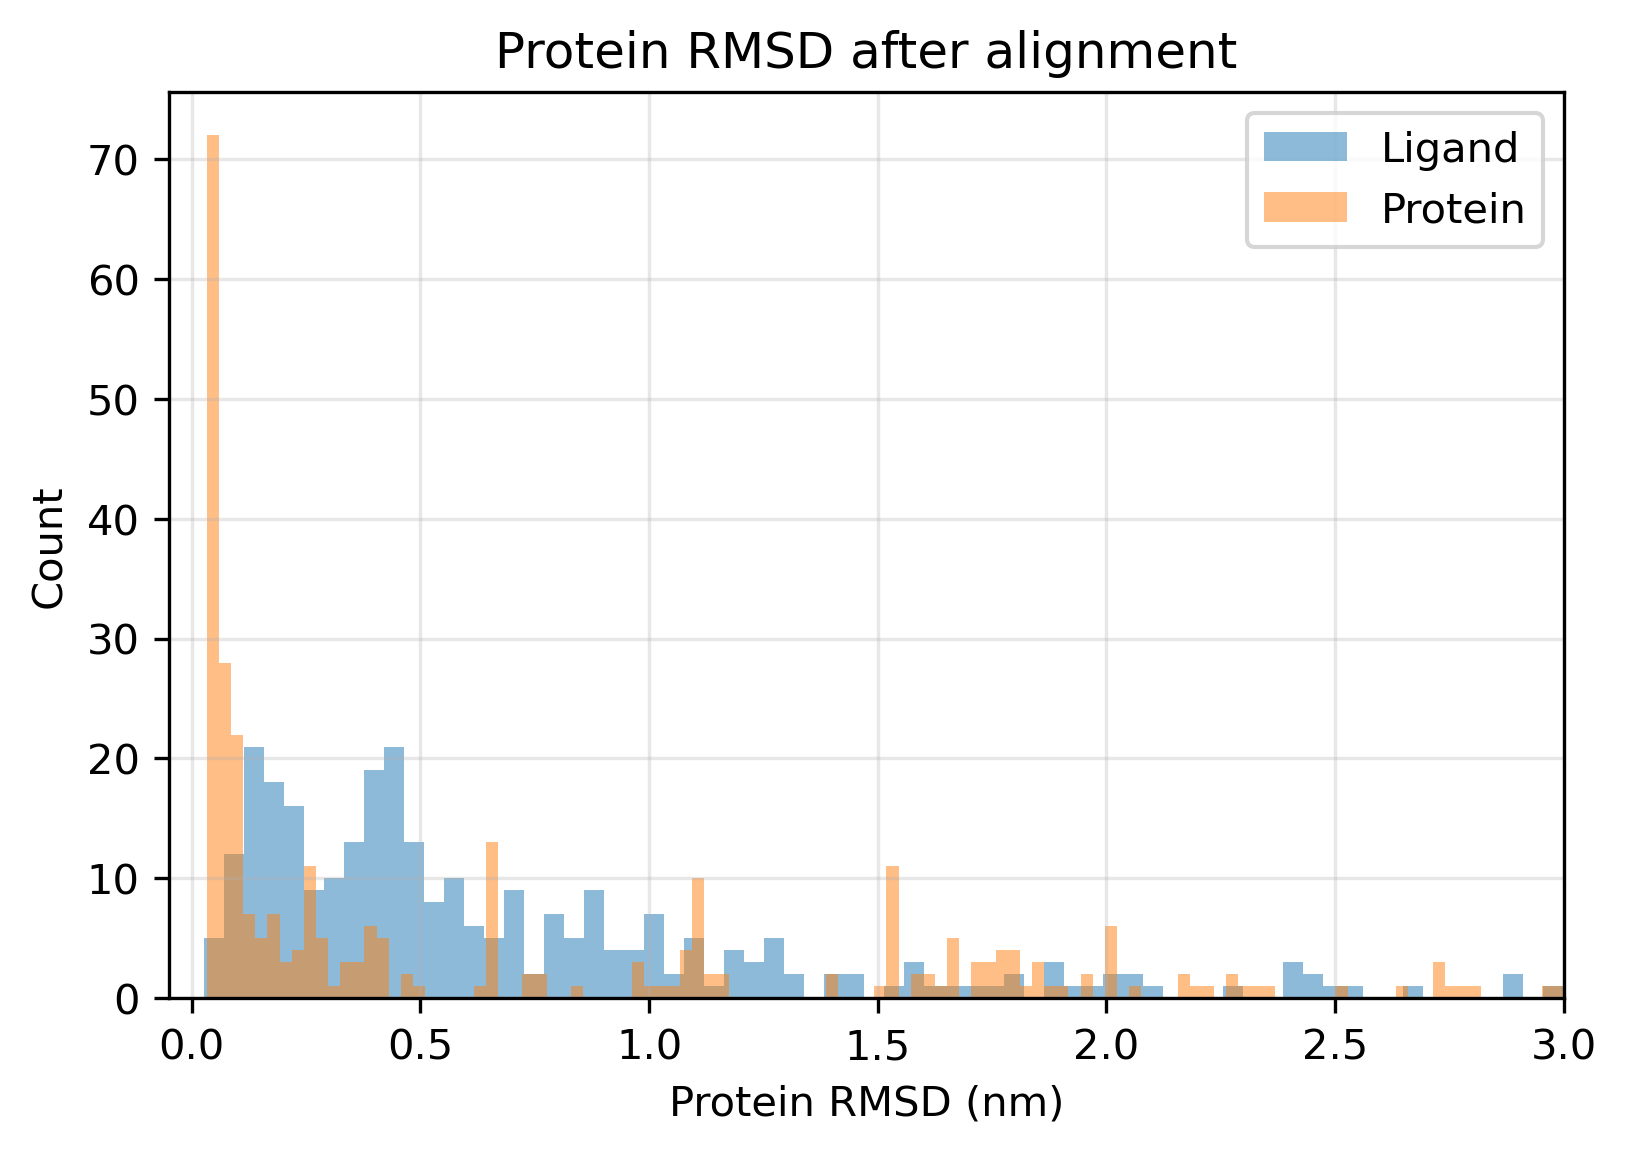

In [22]:
# Checkpoint 79200
import matplotlib.pyplot as plt
plt.figure(dpi=300)
plt.grid(alpha=0.3)
plt.hist(ligand_RMSD, bins=150, alpha=0.5, label='Ligand')
plt.hist(receptor_RMSD, bins=150, alpha=0.5, label='Protein')

plt.title('Protein RMSD after alignment')
plt.xlabel('Protein RMSD (nm)')
plt.ylabel('Count')
plt.xlim([-0.05, 3])
plt.legend()
# plt.xscale('log')
print(np.mean(receptor_RMSD), np.median(receptor_RMSD))
print(np.mean(ligand_RMSD), np.median(ligand_RMSD))

In [420]:
#the_term = np.array(ld_rmsd)[np.array(ld_rmsd)[:,0] > 0][:,1]
the_term = ligand_kabsch_RMSD
print(len(the_term))
print(np.mean(the_term))
print(np.percentile(the_term, 25))
print(np.percentile(the_term, 50))
print(np.percentile(the_term, 75))
print(np.sum(np.array(the_term) < 0.5) / len(the_term))
print(np.sum(np.array(the_term) < 0.2) / len(the_term))

301
0.1911552257368145
0.11093259403531712
0.16389450605982336
0.22759871777138424
0.973421926910299
0.654485049833887


In [130]:
the_term = np.array(ld_rmsd)[np.array(ld_rmsd)[:,0] > 0][:,1]
print(np.mean(the_term))
print(np.percentile(the_term, 25))
print(np.percentile(the_term, 50))
print(np.percentile(the_term, 75))
print(np.sum(np.array(the_term) < 0.5) / len(the_term))
print(np.sum(np.array(the_term) < 0.2) / len(the_term))

0.8857368953478171
0.11750730668246763
0.646533426055488
1.5733666753659994
0.49344978165938863
0.31877729257641924


0.40540540540540543


0.6855337327315951 0.24932652030310712
0.7983262052816463 0.47813881040120565


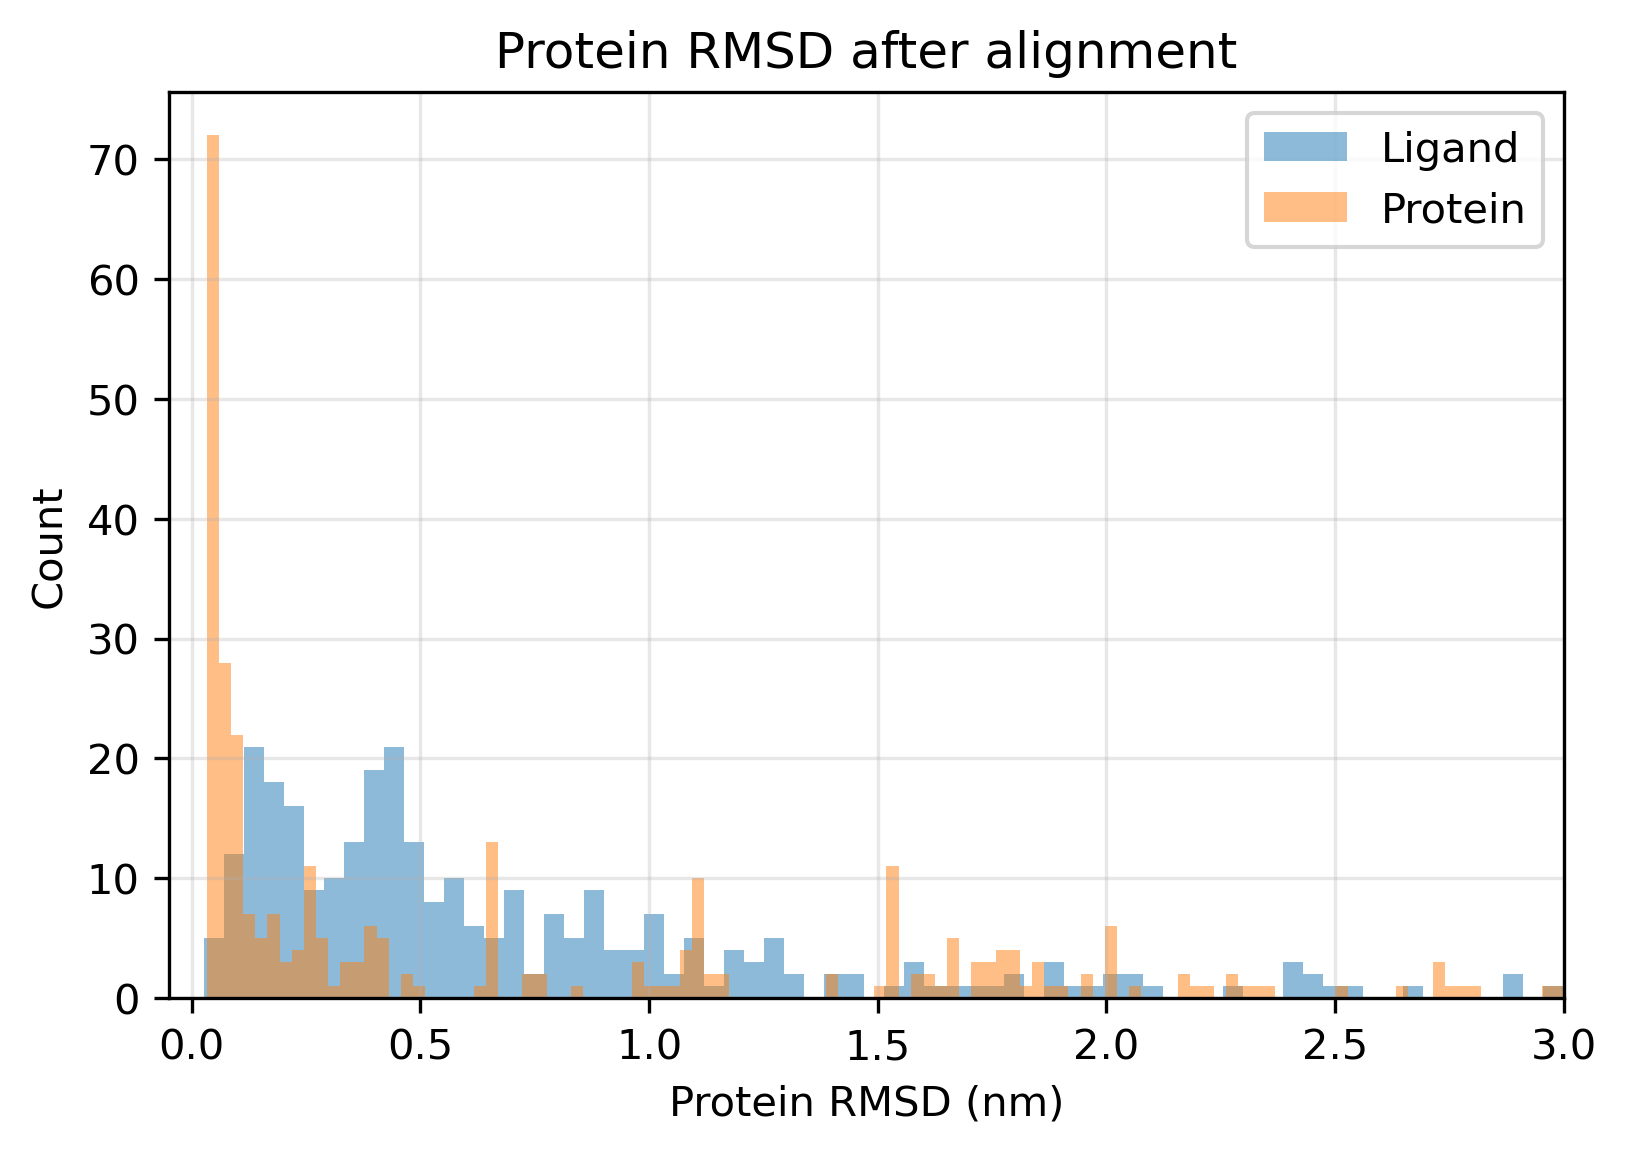

In [23]:
# Checkpoint 97700
import matplotlib.pyplot as plt
plt.figure(dpi=300)
plt.grid(alpha=0.3)
plt.hist(ligand_RMSD, bins=150, alpha=0.5, label='Ligand')
plt.hist(receptor_RMSD, bins=150, alpha=0.5, label='Protein')

plt.title('Protein RMSD after alignment')
plt.xlabel('Protein RMSD (nm)')
plt.ylabel('Count')
plt.xlim([-0.05, 3])
plt.legend()
# plt.xscale('log')
print(np.mean(receptor_RMSD), np.median(receptor_RMSD))
print(np.mean(ligand_RMSD), np.median(ligand_RMSD))

0.1893687707641196
0.7931444174227851 0.4675649181210181


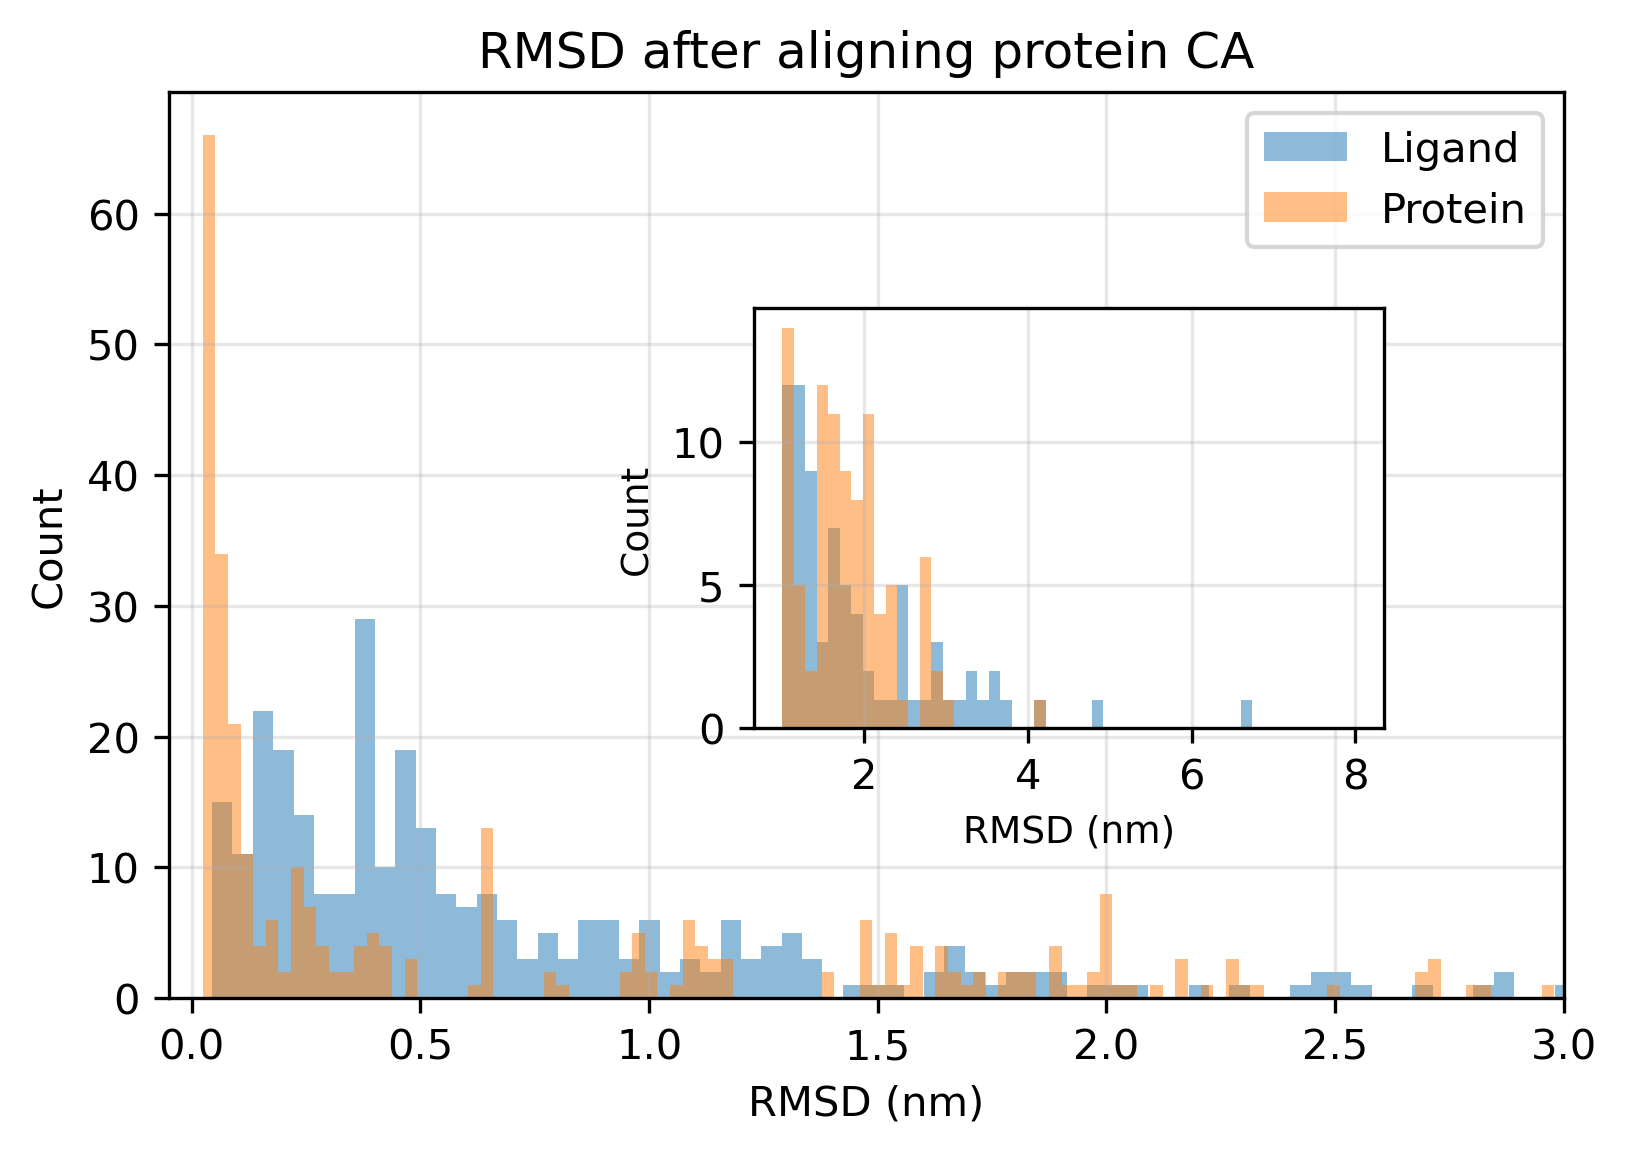

In [100]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(dpi=300)
ax.grid(alpha=0.3)
ax.hist(ligand_RMSD, bins=150, alpha=0.5, label='Ligand')
ax.hist(receptor_RMSD, bins=150, alpha=0.5, label='Protein')
ax.set_title('RMSD after aligning protein CA')
ax.set_xlabel('RMSD (nm)')
ax.set_ylabel('Count')
ax.set_xlim([-0.05, 3])#np.max(ligand_RMSD)])
ax.legend()
print(np.sum((np.array(ligand_RMSD) < 0.2)) / len(ligand_RMSD))
print(np.mean(ligand_RMSD), np.median(ligand_RMSD))

ax2 = fig.add_axes([0.45, 0.35, 0.35, 0.35])
ax2.grid(alpha=0.3)
ax2.hist(ligand_RMSD, bins=50, range=[1, 8], alpha=0.5)
ax2.hist(receptor_RMSD, bins=50, range=[1, 8], alpha=0.5)
# ax2.set_title('Ligand RMSD after aligning protein')
ax2.set_xlabel('RMSD (nm)', fontsize=9)
ax2.set_ylabel('Count', fontsize=9)
plt.savefig(f'histogram-RMSD-{step_num}.png')

In [101]:
RMSD_list = {}
for i,j,k in zip(complex_name, receptor_RMSD, ligand_RMSD):
    RMSD_list[i] = [j, k]

In [102]:
from rdkit import DataStructs
def tanimoto_similarity(s1, s2):
    return DataStructs.TanimotoSimilarity(s1, s2)

In [103]:
f1 = Chem.RDKFingerprint(Chem.MolFromSmiles('CCCCC'))
f2 = Chem.RDKFingerprint(Chem.MolFromSmiles('CCCCCC'))
f3 = Chem.RDKFingerprint(Chem.MolFromSmiles('CCCCCCC'))
DataStructs.TanimotoSimilarity(f1, f3)

0.6666666666666666

In [104]:
import pickle
fp_exists = True
if os.path.exists('test_fp.pkl'):
    fi = pickle.load(open('test_fp.pkl','rb'))
else:
    fp_exists = False
if os.path.exists('train_fp.pkl'):
    fj = pickle.load(open('train_fp.pkl','rb'))
else:
    fp_exists = False
if os.path.exists('max_tm.pkl'):
    max_tm = pickle.load(open('max_tm.pkl','rb'))
else:
    fp_exists = False
if fp_exists:
    print('Pre-calculated fingerprints and max Tanimoto similarities exist; simply load them')
else:
    print('Pre-calculated fingerprints and max Tanimoto similarities do not exist; calculate them in the next step')

Pre-calculated fingerprints and max Tanimoto similarities exist; simply load them


In [105]:
if not fp_exists:
    print("Let's calculate fingerprint / max Tanimoto similarities between train/test sets")
    max_tm = {}
    fi = {}
    fj = {}

    for item in iter(test_data):
        fi[item['name.txt']] = Chem.RDKFingerprint(Chem.MolFromSmiles(item['smiles.txt']))
    print('Done with test fingerprinting')
    for item in iter(train_data):
        try:
            fj[item['name.txt']] = Chem.RDKFingerprint(Chem.MolFromSmiles(item['smiles.txt']))
        except:
            pass
    print('Done with train fingerprinting')

    for key in fi.keys():
        print(key, end=' ')
        max_tm[key] = 0
        for jey in fj:
            try:
                tm = tanimoto_similarity(fi[key], fj[jey])
                max_tm[key] = max(tm, max_tm[key])
            except:
                pass

In [106]:
if not fp_exists:
    pickle.dump(fi, open('test_fp.pkl','wb'))
    pickle.dump(fj, open('train_fp.pkl','wb'))
    pickle.dump(max_tm, open('max_tm.pkl','wb'))

In [107]:
tm_rmsd = []
for i in max_tm.keys():
    tm_rmsd.append([max_tm[i], RMSD_list[i][0], RMSD_list[i][1]])

In [108]:
tm_violin = []
tm_idx = []
tm_k = 25
tm_x = list(np.linspace(0, 1, tm_k+1))
print(tm_x)
for x in tm_x:
    tm_idx.append(x)
    tm_violin.append([])
for i in tm_rmsd:
    tm_violin[np.floor(i[0] * tm_k).astype(int)].append(i[2])

empty_idx = []
for idx, i in enumerate(tm_violin):
    if len(i) == 0:
        empty_idx.append(idx)
for i in empty_idx[::-1]:
    tm_violin.pop(i)
    tm_x.pop(i)
    tm_idx.pop(i)
print(tm_x)

[0.0, 0.04, 0.08, 0.12, 0.16, 0.2, 0.24, 0.28, 0.32, 0.36, 0.4, 0.44, 0.48, 0.52, 0.56, 0.6, 0.64, 0.68, 0.72, 0.76, 0.8, 0.84, 0.88, 0.92, 0.96, 1.0]
[0.28, 0.36, 0.4, 0.44, 0.48, 0.52, 0.56, 0.6, 0.64, 0.68, 0.72, 0.76, 0.8, 0.84, 0.88, 0.92, 0.96, 1.0]


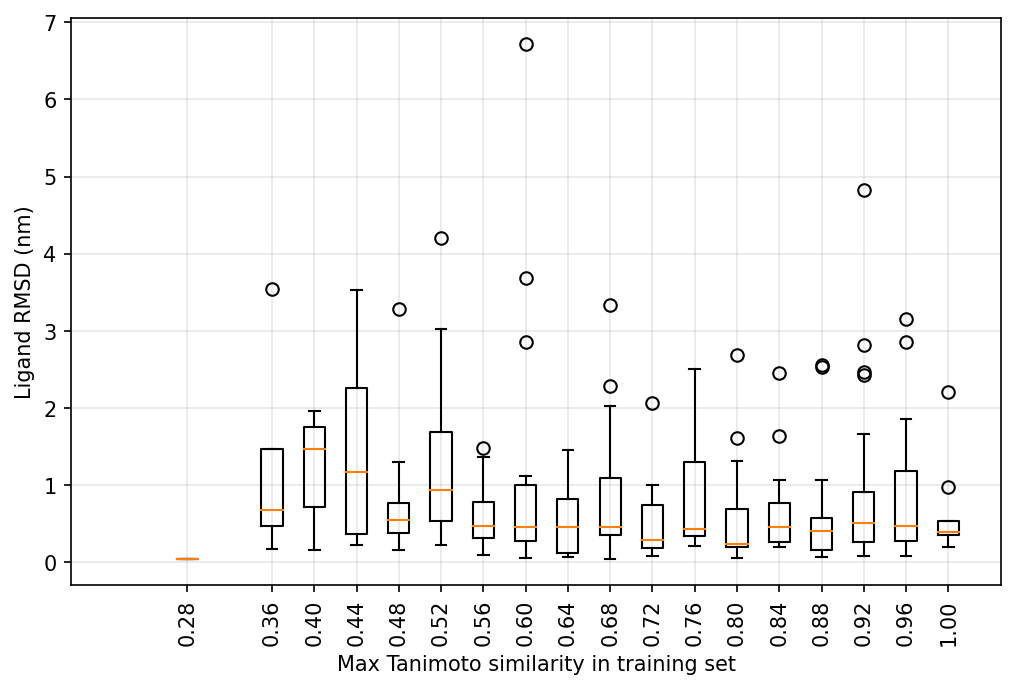

In [109]:
import matplotlib.pyplot as plt
plt.figure(dpi=150, figsize=(8,5))
plt.grid(alpha=0.3)
plt.boxplot(tm_violin, positions=tm_x, notch=False, widths=0.02)
plt.xlabel('Max Tanimoto similarity in training set')
plt.ylabel('Ligand RMSD (nm)')
# plt.ylim([0, 1])
plt.xlim([0.17, 1.05])
plt.xticks(ticks=tm_x, labels=[str(f'{x:.2f}') for x in tm_x], rotation=90)
print()

# plt.savefig(f'ligandRMSD-Tanimoto-boxplot-{step_num}.png')

Text(0, 0.5, 'Protein RMSD (nm)')

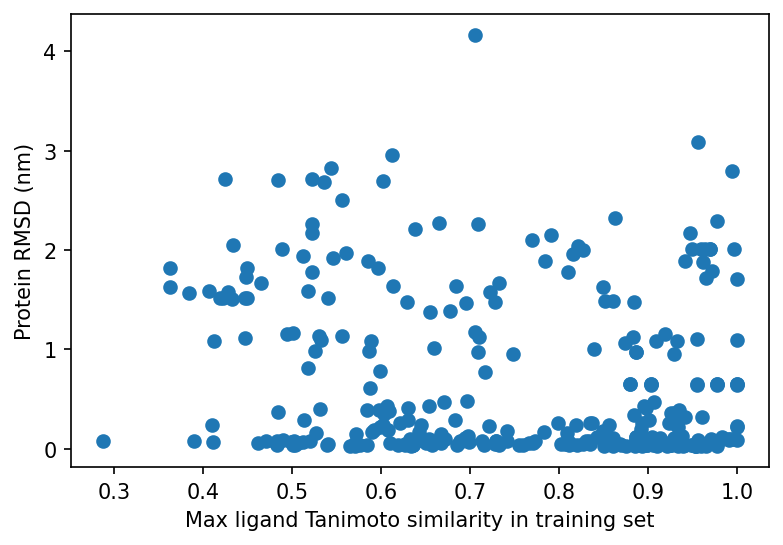

In [110]:
plt.figure(dpi=150)
plt.scatter(np.array(tm_rmsd)[:,0], np.array(tm_rmsd)[:,1])
plt.xlabel('Max ligand Tanimoto similarity in training set')
plt.ylabel('Protein RMSD (nm)')
# plt.ylim([0, 1.5])

-0.644525795385211 1.2731378669702693


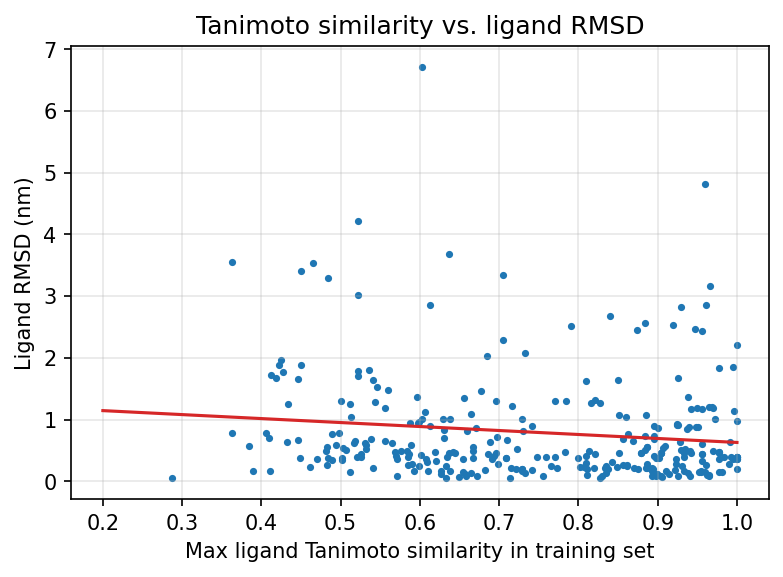

In [111]:
plt.figure(dpi=150)
plt.grid(alpha=0.3)
plt.scatter(np.array(tm_rmsd)[:,0], np.array(tm_rmsd)[:,2], s=6)
plt.title('Tanimoto similarity vs. ligand RMSD')
plt.xlabel('Max ligand Tanimoto similarity in training set')
plt.ylabel('Ligand RMSD (nm)')


# x
m, c = np.linalg.lstsq(np.vstack([np.array(tm_rmsd)[:,0], np.ones(len(tm_rmsd))]).T, np.array(tm_rmsd)[:,2], rcond=None)[0]
plt.plot([0.2, 1.0], [0.2 * m + c, 1.0 * m + c], 'tab:red')
print(m,c)
# plt.ylim([0, 1.5])

In [112]:
import matplotlib.pyplot as plt
plt.figure(dpi=150)
plt.scatter(np.array(protein_len), np.array(protein_RMSD))
plt.xlabel('Protein length')
plt.ylabel('Protein RMSD (nm)')
# plt.ylim([0, 1.5])

NameError: name 'protein_RMSD' is not defined

<Figure size 900x600 with 0 Axes>

Text(0, 0.5, 'Protein RMSD (nm)')

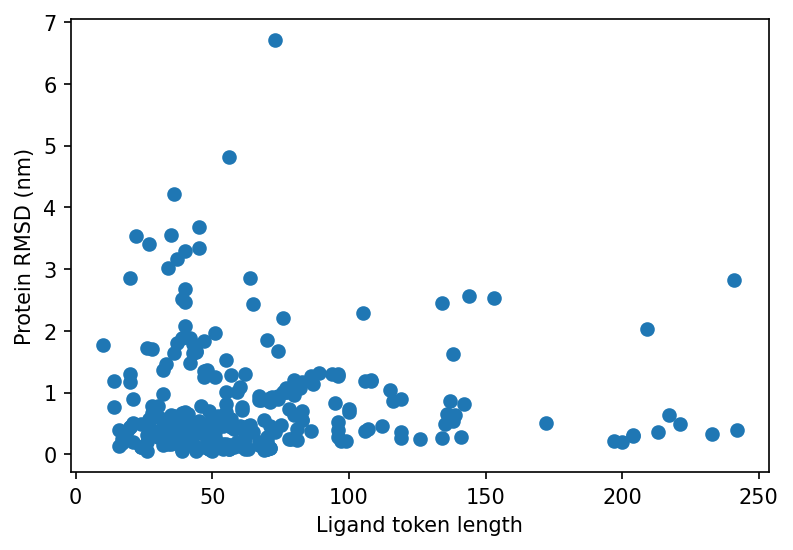

In [113]:
import matplotlib.pyplot as plt
plt.figure(dpi=150)
plt.scatter(np.array(ligand_len), np.array(ligand_RMSD))
plt.xlabel('Ligand token length')
plt.ylabel('Protein RMSD (nm)')
# plt.ylim([0, 1.5])

In [114]:
!pip install edlib

  Using cached edlib-1.3.9-cp38-cp38-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (359 kB)


In [115]:
import pickle
ld_exists = True
if os.path.exists('test_seq.pkl'):
    li = pickle.load(open('test_seq.pkl','rb'))
else:
    ld_exists = False
if os.path.exists('train_seq.pkl'):
    lj = pickle.load(open('train_seq.pkl','rb'))
else:
    ld_exists = False
if os.path.exists('min_ld.pkl'):
    min_ld = pickle.load(open('min_ld.pkl','rb'))
else:
    ld_exists = False
if ld_exists:
    print('Pre-calculated sequences and min Levenshtein distances exist; simply load them')
else:
    print('Pre-calculated sequences and min Levenshtein distances do not exist; calculate them in the next step')

Pre-calculated sequences and min Levenshtein distances exist; simply load them


In [116]:
import edlib

In [117]:
k = 30
if not ld_exists:
    min_ld = {}
    li = {}
    lj = {}
    for item in iter(test_data):
        li[item['name.txt']] = item['seq.txt']
    print('Done with test seq logging')
    for item in iter(train_data):
        try:
            lj[item['name.txt']] = item['seq.txt']
        except:
            pass
    print('Done with train seq logging')

    for key in li.keys():
        print(key, end=' ')

        min_ld[key] = k+1
        for jey in lj:
            # try:
                ld = edlib.align(li[key], lj[jey], task="distance", k=k)
                if ld['editDistance'] >= 0:
                    min_ld[key] = min(ld['editDistance'], min_ld[key])
            # except:
            #     pass

In [118]:
if not ld_exists:
    pickle.dump(li, open('test_seq.pkl','wb'))
    pickle.dump(lj, open('train_seq.pkl','wb'))
    pickle.dump(min_ld, open('min_ld.pkl','wb'))

In [119]:
ld_rmsd = []
for i in min_ld.keys():
    ld_rmsd.append([min_ld[i], RMSD_list[i][0], RMSD_list[i][1]])

Text(0, 0.5, 'Protein RMSD (nm)')

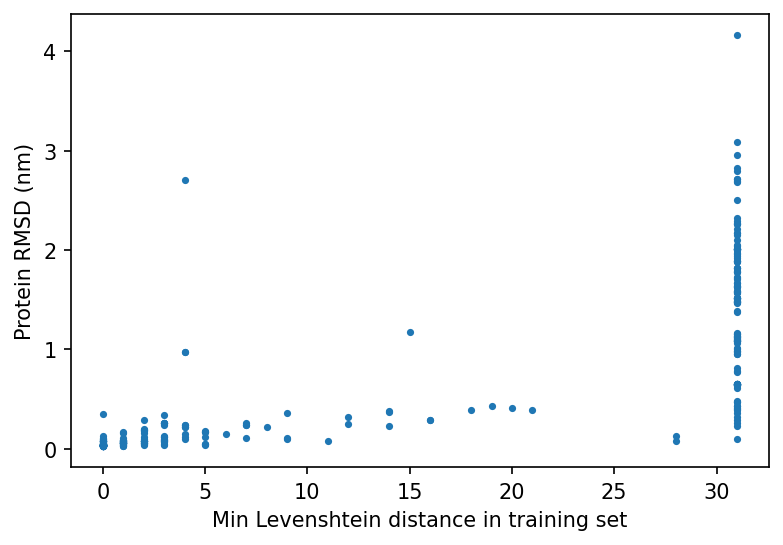

In [120]:
plt.figure(dpi=150)
plt.scatter(np.array(ld_rmsd)[:,0], np.array(ld_rmsd)[:,1], s=6)
plt.xlabel('Min Levenshtein distance in training set')
plt.ylabel('Protein RMSD (nm)')
# plt.ylim([0, 1.5])

In [121]:
ld_violin = []
ld_idx = list(range(np.max(np.unique(np.array(ld_rmsd)[:,0])).astype(int)+1))
for _ in ld_idx:
    ld_violin.append([])

In [122]:
len(ld_violin)

32

In [123]:
len(ld_rmsd)

301

In [124]:
for i in ld_rmsd:
    # print(i)
    ld_violin[i[0]].append(i[1])

empty_idx = []
for idx, i in enumerate(ld_violin):
    if len(i) == 0:
        empty_idx.append(idx)
    else:
        ld_violin[idx].sort()
for i in empty_idx[::-1]:
    ld_violin.pop(i)
    ld_idx.pop(i)

In [125]:
k

30

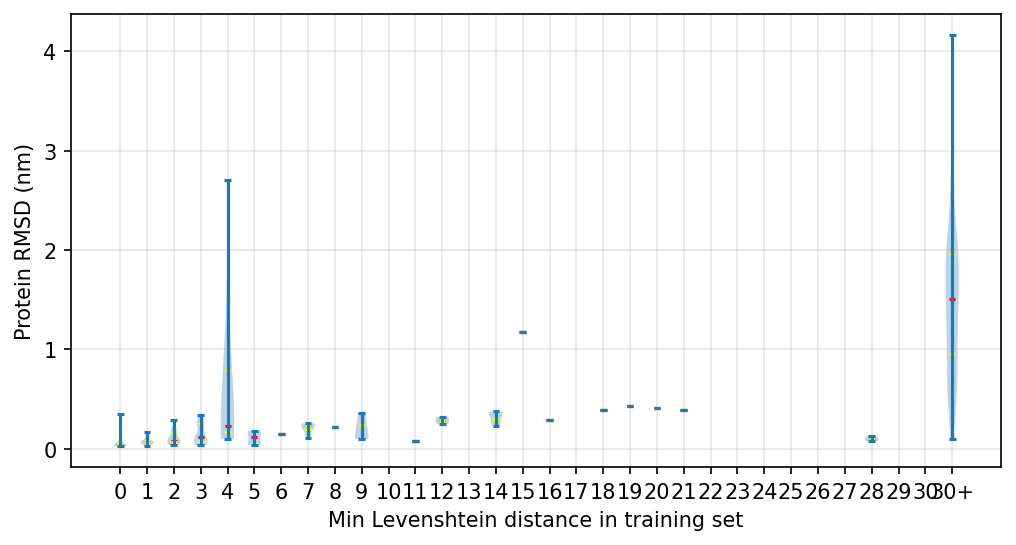

In [126]:
plt.figure(dpi=150, figsize=(8,4))
plt.grid(alpha=0.3)
plt.violinplot(ld_violin, ld_idx)#, showmedians=True, quantiles=[[0.25, 0.75]] * len(ld_idx), )
for i,j in zip(ld_violin, ld_idx):
    plt.scatter(j, np.median(i), s=8, c='r', marker='_')
    plt.scatter(j, np.quantile(i, 0.25), s=8, c='yellow', marker='_')
    plt.scatter(j, np.quantile(i, 0.75), s=8, c='yellow', marker='_')
plt.xlabel('Min Levenshtein distance in training set')
plt.ylabel('Protein RMSD (nm)')
# plt.ylim([0, 3])
plt.xticks(ticks=range(k+2), labels=list(range(k+1))+ [f'{k}+'])
print()

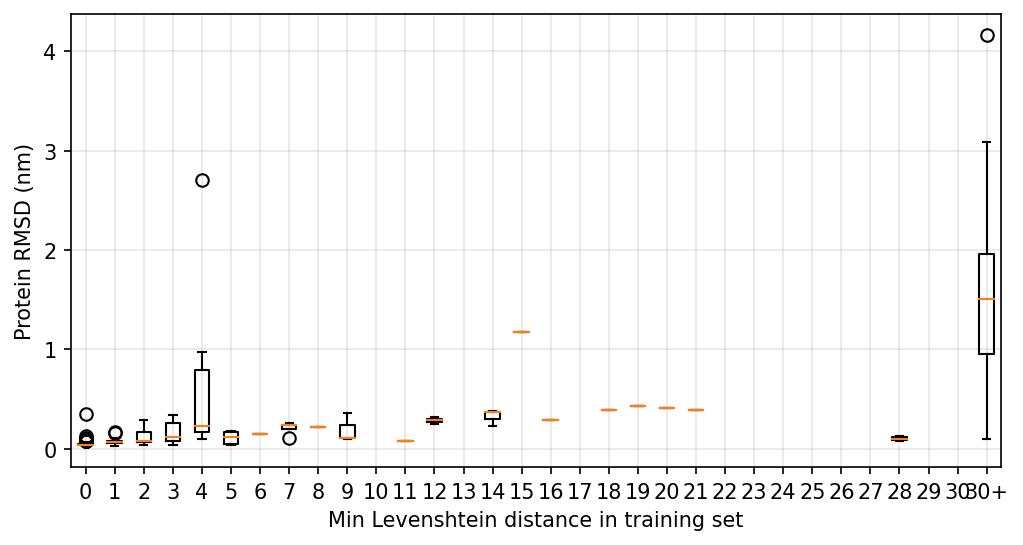

In [127]:
plt.figure(dpi=150, figsize=(8,4))
plt.grid(alpha=0.3)
plt.boxplot(ld_violin, positions=ld_idx, notch=False)
plt.xlabel('Min Levenshtein distance in training set')
plt.ylabel('Protein RMSD (nm)')
# plt.ylim([0, 1])
plt.xticks(ticks=np.array(range(k+2)), labels=list(range(k+1))+ [f'{k}+'])
print()

plt.savefig(f'proteinRMSD-Levenshtein-boxplot-{step_num}.png')

In [131]:
RMSD_list

{'6mja': [2.0399417684440784, 1.311169274099948],
 '5zcu': [1.892072169798102, 0.388822319402517],
 '6jaq': [0.6467061718821083, 0.448817271095475],
 '6ahs': [0.03539414682072774, 0.49634262505091353],
 '6hza': [0.041163497563304466, 0.739705430348249],
 '5zr3': [0.13408605611317298, 0.7193018132251864],
 '6jap': [0.6517108579284377, 0.4675649181210181],
 '6np3': [1.4817333058382585, 1.0056101375873863],
 '6qlu': [0.028161830286449297, 0.16032337288445703],
 '6jb0': [0.6472763168986406, 0.45202735899057284],
 '6qgf': [0.023875490535925543, 0.1419693667467709],
 '6jbe': [0.6483885044677415, 0.43910261991517396],
 '6i66': [0.29532658377103477, 0.18084697327356658],
 '6a1c': [0.09217974852092772, 0.34012132781477156],
 '6n8x': [0.03045048624796637, 0.1583134033039429],
 '6cyh': [0.100229840753193, 0.38558877940930086],
 '6e3o': [0.07319760301602755, 0.16597722991529237],
 '6s56': [0.04359580065882083, 0.44217660857186125],
 '6i62': [0.2578728048383799, 0.3204374897237903],
 '6g2f': [1.140

### Predict the small domain of Mpro

In [143]:
# Andrii's Mpro1-199
df = pd.DataFrame({'seq': [
    # 'SGFRKMAFPSGKVEGCMVQVTCGTTTLNGLWLDDVVYCPRHVICTSEDMLNPNYEDLLIRKSNHNFLVQAGNVQLRVIGHSMQNCVLKLKVDTANPKTPKYKFVRIQPGQTFSVLACYNGSPSGVYQCAMRPNFTIKGSFLNGSCGSVGFNIDYDCVSFCYMHHMELPTGVHAGTDLEGNFYGPFVDRQTAQAAGTDTT' # Mpro1-199
    # 'SGFRKMAFPSGKVEGCMVQVTCGTTTLNGLWLDDVVYCPRHVICTSEDMLNPNYEDLLIRKSNHNFLVQAGNVQLRVIGHSMQNCVLKLKVDTANPKTPKYKFVRIQPGQTFSVLACYNGSPSGVYQCAMRPNFTIKGSFLNGSCGSVGFNIDYDCVSFCYMHHMELPTGVHAGTDLEGNFYGPFVDRQTAQAAGTDTTITVNVLAWLYAAVINGDRWFLNRFTTTLNDFNLVAMKYNYEPLTQDHVDILGPLSAQTGIAVLDMCASLKELLQNGMNGRTILGSALLEDEFTPFDVVRQCSGVTFQ' #Full Mpro
    'VNVLAWLYAAVINGDRWFLNRFTTTLNDFNLVAMKYNYEPLTQDHVDILGPLSAQTGIAVLDMCASLKELLQNGMNGRTILGSALLEDEFTPFDVVRQCSGVTFQ' # Mpro200-306
], 
                   'smiles': ['']})


In [144]:
dataset = ProteinLigandDataset(df)

In [145]:
models[0].model.enable_cross = False

In [146]:
output = list(models[0](dataset))
pred = output[0]

In [126]:
with open(f'../examples/pred_Mpro1-199_ligand_7s3s.pdb','w') as f:
    feat = pred['receptor_xyz']
    write_pdb_no_ref(f, df['seq'][0], feat)
    

KeyError: 'receptor_xyz'

In [135]:
def write_Calpha_no_ref(f, seq, feat):
    k = 0
    resid = 1
    i = 1
    for s in seq:
        res = restype_1to3[s]
        xyz = feat[0,k+1]
        write_pdb_line(f,'ATOM', str(i), 'CA', res, 'A', str(resid), *xyz, 1.0, 1.0, 'C')
        i+=1
        k+=1
        resid+=1

In [147]:
with open(f'../examples/pred_Mpro200-306_calpha.pdb','w') as f:
    calpha_xyz = pred['receptor_frames_xyz']
    write_Calpha_no_ref(f, df['seq'][0], calpha_xyz)
    

In [26]:
from rdkit.Geometry import Point3D
ligand_xyz = pred['ligand_frames_xyz']
mol = Chem.MolFromSmiles(df['smiles'][0])
Chem.AllChem.EmbedMolecule(mol)
smi, ligand_xyz_ref, tokens, atom_map = get_token_coords(mol) 
conf = mol.GetConformer()
#assert pred['ligand_frames_xyz'].shape[1] == len(atom_map) + 2
for i, xyz in enumerate(ligand_xyz.squeeze(0)[1:-1]):
    idx = atom_map[i]

    if idx is not None:
        conf.SetAtomPosition(idx,Point3D(*xyz.astype(np.double)))

# with Chem.SDWriter('../examples/ligand_pred_Mpro1-199_ligand_7s3s.sdf') as w:

#     w.write(mol)

[17:32:43] Molecule does not have explicit Hs. Consider calling AddHs()


In [32]:
mol.GetConformer().GetPositions()

array([[ -5.77057648,  -7.92850494,   6.60404921],
       [ -6.27080441,  -7.57523346,   6.50301933],
       [ -6.40015984,  -7.22153378,   6.51033688],
       [ -6.10368395,  -7.01297188,   6.49433517],
       [ -7.29807568,  -7.86094284,   6.25681925],
       [ -8.50226974,  -9.61104012,   6.2806592 ],
       [ -9.52219105,  -9.5568676 ,   5.96644354],
       [ -9.36443043,  -8.65210056,   6.07201004],
       [-10.2728672 , -10.91296864,   6.06625366],
       [-10.88458252, -10.54816151,   6.41200495],
       [-10.33104324, -12.37953472,   5.76540184],
       [ -9.93062496, -12.85931778,   5.86660194],
       [-10.56882   , -13.233675  ,   7.56677914],
       [-10.64857292, -13.40362358,   7.66817856],
       [ -9.82130051, -14.47603703,   6.62349272],
       [ -6.82881641,  -7.91845083,   5.53723764],
       [ -6.94521379,  -8.33654213,   5.54103518],
       [ -5.60365772,  -6.50262213,   5.11958504],
       [ -5.08074284,  -6.83270788,   4.34065485],
       [ -5.09096813,  -6.72493

**Mpro**

In [41]:
from Bio.PDB import PDBParser
from Bio.PDB import PDBList
from Bio.PDB import CaPPBuilder

parser = PDBParser()
# structure = parser.get_structure('protein','../examples/1a3n_protein.pdb')
structure = parser.get_structure('protein','../examples/7s3s_protein.pdb')
# structure = parser.get_structure('protein','../examples/4mds_protein_noHET.pdb')
# structure = parser.get_structure('protein','../examples/2x38_protein.pdb')
#structure = parser.get_structure('protein','../examples/4ibe_protein.pdb')

#structure = parser.get_structure('protein',PDBList().retrieve_pdb_file('1gfl',file_format='pdb'))

ppb = CaPPBuilder()
xyz_receptor = []
R_receptor = []
seq = ''

for pp in ppb.build_peptides(structure[0]):
    seq += str(pp.get_sequence())
    xyz_receptor += [tuple(a.get_vector()) for a in pp.get_ca_list()]
    
seq*=2
xyz_receptor = np.array(xyz_receptor).astype(np.float32)

/opt/conda/lib/python3.8/site-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'TER' at line 2370
  warnings.warn(


In [42]:
seq

'SGFRKMAFPSGKVEGCMVQVTCGTTTLNGLWLDDVVYCPRHVICTSEDMLNPNYEDLLIRKSNHNFLVQAGNVQLRVIGHSMQNCVLKLKVDTANPKTPKYKFVRIQPGQTFSVLACYNGSPSGVYQCAMRPNFTIKGSFLNGSCGSVGFNIDYDCVSFCYMHHMELPTGVHAGTDLEGNFYGPFVDRQTAQAAGTDTTITVNVLAWLYAAVINGDRWFLNRFTTTLNDFNLVAMKYNYEPLTQDHVDILGPLSAQTGIAVLDMCASLKELLQNGMNGRTILGSALLEDEFTPFDVVRQCSGVTFQSGFRKMAFPSGKVEGCMVQVTCGTTTLNGLWLDDVVYCPRHVICTSEDMLNPNYEDLLIRKSNHNFLVQAGNVQLRVIGHSMQNCVLKLKVDTANPKTPKYKFVRIQPGQTFSVLACYNGSPSGVYQCAMRPNFTIKGSFLNGSCGSVGFNIDYDCVSFCYMHHMELPTGVHAGTDLEGNFYGPFVDRQTAQAAGTDTTITVNVLAWLYAAVINGDRWFLNRFTTTLNDFNLVAMKYNYEPLTQDHVDILGPLSAQTGIAVLDMCASLKELLQNGMNGRTILGSALLEDEFTPFDVVRQCSGVTFQ'

In [43]:
from rdkit import Chem
from rdkit.Chem import AllChem

path = '../utils'
if path not in sys.path:
    sys.path.append(path)
from token_coords import get_token_coords
with Chem.SDMolSupplier('../examples/7s3s_860_ligand.sdf') as suppl:
    # O=C(Cc1cccc(Cl)c1)Nc1cncc2ccccc12
# with Chem.SDMolSupplier('../examples/7s3k_Z26_ligand.sdf') as suppl:
# with Chem.SDMolSupplier('../examples/4mds_23H_ligand.sdf') as suppl:
# with Chem.SDMolSupplier('../examples/2x38_IC8_ligand.sdf') as suppl:
#with Chem.SDMolSupplier('../examples/4ibe_11Y_ligand.sdf') as suppl:
    mol = next(suppl)

# mol = Chem.MolFromSmiles('CCC1=NC=CN1CC2=CN(N=N2)C=3C=CC(F)=C(Br)C3') #cpd39
# mol = Chem.MolFromSmiles('CCC(CC)COC(=O)C(C)NP(=O)(OCC1C(C(C(O1)(C#N)C2=CC=C3N2N=CN=C3N)O)O)OC4=CC=CC=C4') # remdesivir

# Chem.AllChem.EmbedMolecule(mol)

smi, ligand_xyz_ref, tokens, atom_map = get_token_coords(mol) 
ligand_xyz_ref = np.pad(ligand_xyz_ref,((1,1),(0,0)),constant_values=np.nan)

In [44]:
smi

'O=C(Cc1cccc(Cl)c1)Nc1cncc2ccccc12'

In [45]:
df = pd.DataFrame({'seq': [seq], 'smiles': [smi]})

In [46]:
dataset = ProteinLigandDataset(df)

In [47]:
models[0].model.enable_cross = True

In [48]:
output = list(models[0](dataset))
pred = output[0]

/opt/conda/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
/gpfs/alpine/bif136/world-shared/djh992/contact_pred_torsion_CNdist11/eval_notebooks/../contact_pred/models.py:304: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  aatypes = torch.tensor(self.input_ids_to_aatype[input_ids_1], device=input_ids_1.device)#, requires_grad=False)


In [49]:
xyz_receptor[None].shape, pred['receptor_xyz'].shape

((1, 306, 3), (1, 614, 14, 3))

In [50]:
#C, t, receptor_rmsd = align(xyz_receptor[None],pred['receptor_frames_xyz'][:,1:-1])
# C = pred['receptor_xyz'][:,1:-1,1]
C, t, receptor_rmsd = align(xyz_receptor[None],pred['receptor_xyz'][:,1:(1+len(xyz_receptor)),1])
receptor_rmsd/10

0.3789663784844556

In [51]:
smi

'O=C(Cc1cccc(Cl)c1)Nc1cncc2ccccc12'

In [52]:
ligand_xyz = pred['ligand_frames_xyz']
ligand_xyz = np.einsum('bij,bnj->bni',C,ligand_xyz)+t
ligand_rmsd = np.nanmean(np.linalg.norm(ligand_xyz_ref-ligand_xyz,axis=-1)[:,1:-1])
ligand_rmsd/10

0.5341560985741236

In [53]:
# update molecule coordinates using prediction
from rdkit.Geometry import Point3D

conf = mol.GetConformer()
#assert pred['ligand_frames_xyz'].shape[1] == len(atom_map) + 2
for i, xyz in enumerate(ligand_xyz.squeeze(0)[1:-1]):
    idx = atom_map[i]

    if idx is not None:
        conf.SetAtomPosition(idx,Point3D(*xyz.astype(np.double)))

with Chem.SDWriter('../examples/ligand_pred_7s3s_dimer.sdf') as w:
# with Chem.SDWriter('../examples/ligand_pred_2x38.sdf') as w:
#with Chem.SDWriter('../examples/ligand_pred_7s3k.sdf') as w:
# with Chem.SDWriter('../examples/ligand_pred_4mds.sdf') as w:
#with Chem.SDWriter('../examples/ligand_pred_cpd39.sdf') as w:
#with Chem.SDWriter('../examples/ligand_pred_remdesivir.sdf') as w:
    w.write(mol)

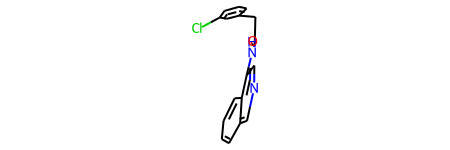

In [54]:
mol

In [55]:
len(seq)

612

In [56]:
from contact_pred.residue_constants import restype_name_to_atom14_names, restype_1to3

In [57]:
def write_pdb_line(f,*j):
    j = list(j)
    j[0] = j[0].ljust(6)#atom#6s
    j[1] = j[1].rjust(5)#aomnum#5d
    j[2] = j[2].center(4)#atomname$#4s
    j[3] = j[3].ljust(3)#resname#1s
    j[4] = j[4].rjust(1) #Astring
    j[5] = j[5].rjust(4) #resnum
    j[6] = str('%8.3f' % (float(j[6]))).rjust(8) #x
    j[7] = str('%8.3f' % (float(j[7]))).rjust(8)#y
    j[8] = str('%8.3f' % (float(j[8]))).rjust(8) #z\
    j[9] =str('%6.2f'%(float(j[9]))).rjust(6)#occ
    j[10]=str('%6.2f'%(float(j[10]))).ljust(6)#temp
    j[11]=j[11].rjust(12)#elname
    f.write("%s%s %s %s %s%s    %s%s%s%s%s%s\n"% (j[0],j[1],j[2],j[3],j[4],j[5],j[6],j[7],j[8],j[9],j[10],j[11]))

def write_pdb_no_ref(f, seq, feat):
    k = 0
    resid = 1
    i = 1
    for s in seq:
        res = restype_1to3[s]
        for idx, atom in enumerate(restype_name_to_atom14_names[res]):
            if atom != '':
                xyz = feat[0,k+1,idx]
                write_pdb_line(f,'ATOM', str(i), atom, res, 'A', str(resid), *xyz, 1.0, 1.0, atom[0])
                i+=1
        k+=1
        resid+=1    
    
def write_pdb(f, structure, feat):
    k = 0
    resid = 1
    idx = 1
    for pp in ppb.build_peptides(structure):
        for s,res in zip(pp.get_sequence(),pp):
            reflabels = [l.split()[0] for l in aa[s].reflabels]
            reflabels.remove('OXT')
            atoms_idx = sorted([(a,reflabels.index(a.name)) for a in res if a.name in reflabels], key=lambda t: t[1])
            for a,i in atoms_idx:
                xyz = feat[0,k+1,i]
                # write_pdb_line(f,'ATOM',str(a.get_serial_number()), a.name, res.get_resname(), 'A', str(resid), *xyz, 1.0, 1.0, a.element)
                write_pdb_line(f,'ATOM',str(idx), a.name, res.get_resname(), 'A', str(resid), *xyz, 1.0, 1.0, a.element)
                idx += 1
            k+=1
            resid+=1    

with open('../examples/pred_7s3s_dimer.pdb','w') as f:
# with open('../examples/pred_2x38.pdb','w') as f:
# with open('../examples/pred_4mds.pdb','w') as f:
    feat =  np.einsum('bij,bnaj->bnai',C,pred['receptor_xyz'])+t
    #feat = pred['receptor_xyz']
    # write_pdb(f, structure, feat)
    write_pdb_no_ref(f, seq, feat)



In [128]:
# write Calpha trace 
def write_calpha_pdb(f, structure, calpha_xyz): 
    k = 0 
    resid = 1 
 
    for pp in ppb.build_peptides(structure): 
        for s,res in zip(pp.get_sequence(),pp): 
            reflabels = [l.split()[0] for l in aa[s].reflabels] 
            atoms_idx = sorted([(a,reflabels.index(a.name)) for a in res if a.name in reflabels and a.name == 'CA'], key=lambda t: t[1]) 
            for a,i in atoms_idx: 
                xyz = calpha_xyz[0,k+1] 
                write_pdb_line(f,'ATOM',str(a.get_serial_number()), a.name, res.get_resname(), 'A', str(resid), *xyz, 1.0, 1.0, a.element) 
            k+=1 
            resid+=1 
#        break 
             
with open('../examples/pred_4mds_Calpha.pdb','w') as f: 
    calpha_xyz = pred['receptor_frames_xyz']
    # calpha_xyz = np.einsum('bij,bnj->bni',C,pred['receptor_frames_xyz'])+t 
    write_calpha_pdb(f, structure, calpha_xyz) 

In [40]:
aa['A'].reflabels

['N', 'CA', 'C', 'O', 'CB', 'OXT']

**Fragalysis dataset**

In [32]:
df = pd.read_parquet('/gpfs/alpine/world-shared/bif136/fragalysis/data/fragalysis.parquet')
dataset = ProteinLigandDataset(df)

In [33]:
for idx, i in enumerate(iter(dataset)):
    if idx < 1:
        print(i, i['ligand'], i['protein'], len(i['ligand']), len(i['protein']))

{'ligand': 'CC(C)N(Cc1ccccc1)C(=O)Cn1nnc2ccccc21', 'protein': 'SGFRKMAFPSGKVEGCMVQVTCGTTTLNGLWLDDVVYCPRHVICTSEDMLNPNYEDLLIRKSNHNFLVQAGNVQLRVIGHSMQNCVLKLKVDTANPKTPKYKFVRIQPGQTFSVLACYNGSPSGVYQCAMRPNFTIKGSFLNGSCGSVGFNIDYDCVSFCYMHHMELPTGVHAGTDLEGNFYGPFVDRQTAQAAGTDTTITVNVLAWLYAAVINGDRWFLNRFTTTLNDFNLVAMKYNYEPLTQDHVDILGPLSAQTGIAVLDMCASLKELLQNGMNGRTILGSALLEDEFTPFDVVRQCSGVTFQSGFRKMAFPSGKVEGCMVQVTCGTTTLNGLWLDDVVYCPRHVICNYEDLLIRKSNHNFLVQAGNVQLRVIGHSMQNCVLKLKVDTANPKTPKYKFVRIQPGQTFSVLACYNGSPSGVYQCAMRPNFTIKGSFLNGSCGSVGFNIDYDCVSFCYMHHMELPTGVHAGTDLEGNFYGPFVDRQTAQAAGTDTTITVNVLAWLYAAVINGDRWFLNRFTTTLNDFNLVAMKYNYEPLTQDHVDILGPLSAQTGIAVLDMCASLKELLQNGMNGRTILGSALLEDEFTPFDVVRQCSGVTF'} CC(C)N(Cc1ccccc1)C(=O)Cn1nnc2ccccc21 SGFRKMAFPSGKVEGCMVQVTCGTTTLNGLWLDDVVYCPRHVICTSEDMLNPNYEDLLIRKSNHNFLVQAGNVQLRVIGHSMQNCVLKLKVDTANPKTPKYKFVRIQPGQTFSVLACYNGSPSGVYQCAMRPNFTIKGSFLNGSCGSVGFNIDYDCVSFCYMHHMELPTGVHAGTDLEGNFYGPFVDRQTAQAAGTDTTITVNVLAWLYAAVINGDRWFLNRFTTTLNDFNLVAMKYNYEPLTQDHVDILGPLSAQTGIAVLDMCASLKELLQNGMNGRTILGSALLEDEFTPF

In [34]:
%%time
output = models[0](dataset)
pred = list(output)

/opt/conda/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
/gpfs/alpine/bif136/world-shared/djh992/contact_pred_torsion_CNdist11/eval_notebooks/../contact_pred/models.py:304: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  aatypes = torch.tensor(self.input_ids_to_aatype[input_ids_1], device=input_ids_1.device)#, requires_grad=False)


CPU times: user 1min 36s, sys: 12.9 s, total: 1min 49s
Wall time: 1min 50s


In [35]:
ligand_xyz_pad = [np.pad(np.array(xyz.tolist()),((1,1),(0,0)),constant_values=None).astype(np.float32) for xyz in df['ligand_xyz']]
receptor_xyz_pad = [np.pad(np.array(xyz.tolist()),((1,1),(0,0)),constant_values=None).astype(np.float32) for xyz in df['receptor_xyz']]

In [97]:
C, t, receptor_rmsd = np.moveaxis([align(xyz[None,1:-1],p['receptor_xyz'][:,1:len(xyz)-1,1]) for xyz, p in zip(receptor_xyz_pad,pred)],source=1,destination=0)
np.mean(receptor_rmsd/10)

/opt/conda/lib/python3.8/site-packages/numpy/core/numeric.py:1457: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  a = asarray(a)


0.43788225179616586

In [126]:
receptor_xyz = [np.einsum('ik,njk->nji',rot[0],p['receptor_xyz'][0])+trans[0] for rot,trans,p in zip(C,t,pred)]

In [98]:
ligand_xyz = [np.einsum('ij,nj->ni',rot[0],p['ligand_frames_xyz'][0])+trans[0] for rot,trans,p in zip(C,t,pred)]
ligand_rmsd = np.array([np.nanmean(np.linalg.norm(ref[1:-1]-xyz[1:len(ref)-1],axis=-1),axis=-1) for ref,xyz in zip(ligand_xyz_pad,ligand_xyz)])
np.mean(ligand_rmsd/10)

0.6135311347261505

In [38]:
JG_result = pd.read_csv('/gpfs/alpine/world-shared/bif136/fragalysis_ligands_gp.csv')

In [39]:
JG_result[['ligand_rmsd', 'receptor_rmsd']]

,ligand_rmsd,receptor_rmsd
0,17.082364,6.856960
1,17.082390,6.856985
2,15.333435,3.971780
3,15.333418,3.971764
4,13.748987,4.430261
...,...,...
512,5.544504,2.599608
513,11.039789,4.168117
514,8.028419,2.572753
515,6.440600,4.294890


In [40]:
len(JG_result)

517

In [31]:

# the_term = JG_result['receptor_rmsd']/10
the_term = receptor_rmsd/10
print(len(the_term))
print(np.nanmean(the_term))
print(np.nanpercentile(the_term, 25))
print(np.nanpercentile(the_term, 50))
print(np.nanpercentile(the_term, 75))
print(np.sum(np.array(the_term) < 0.5) / len(the_term))
print(np.sum(np.array(the_term) < 0.2) / len(the_term))

733
0.43788225179616586
0.23173219622589128
0.31749156965954006
0.5576699189691253
0.6957708049113234
0.020463847203274217


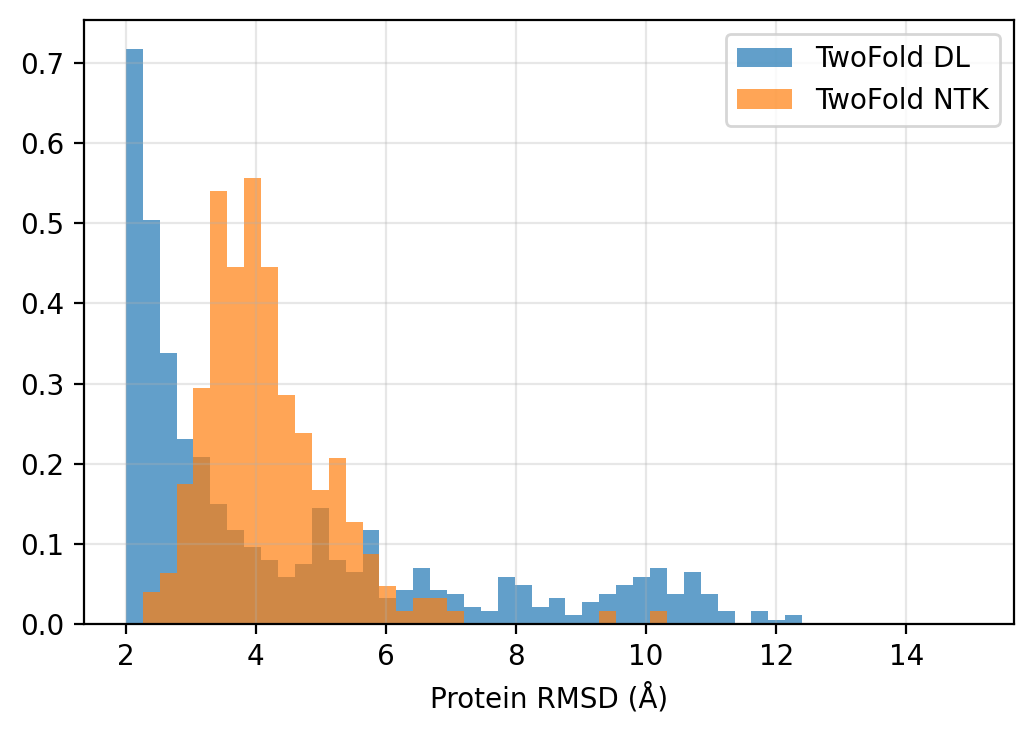

In [195]:
plt.figure(dpi=200)
plt.grid(alpha=0.3)
plt.hist(receptor_rmsd, range=[2,15], bins=50, label='TwoFold DL', alpha=0.7, density=True)
plt.hist(JG_result['receptor_rmsd'], range=[2,15], bins=50, label='TwoFold NTK', alpha=0.7, density=True)
plt.xlabel('Protein RMSD (Å)')
plt.legend()
plt.savefig('Compare_DL_NTK_Mpro_protein.png')

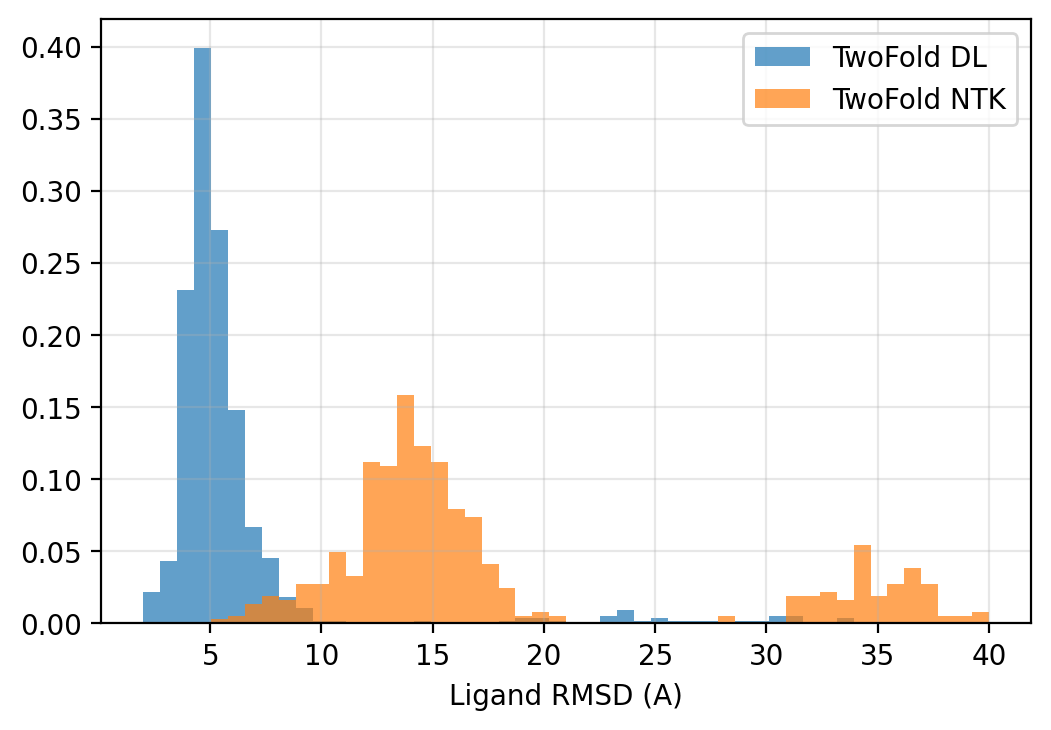

In [196]:
plt.figure(dpi=200)
plt.grid(alpha=0.3)
plt.hist(ligand_rmsd, range=[2,40], bins=50, label='TwoFold DL', alpha=0.7, density=True)
plt.hist(JG_result['ligand_rmsd'], range=[2,40], bins=50, label='TwoFold NTK', alpha=0.7, density=True)
plt.xlabel('Ligand RMSD (A)')
plt.legend()
plt.savefig('Compare_DL_NTK_Mpro_ligand.png')

In [44]:
df.describe()

,name,seq,smiles,receptor_xyz,ligand_xyz
count,733,733,733,733,733
unique,733,56,538,733,733
top,Mpro-J0013_0A,SGFRKMAFPSGKVEGCMVQVTCGTTTLNGLWLDDVVYCPRHVICTS...,CCC(=O)N(C(=O)[C@@H]1CCOc2ccc(Cl)cc21)c1cncc2c...,"[[-2.533, 5.565, -15.985], [-2.538, 6.554, -12...","[[10.104, -2.45, 24.17], [8.944, -1.593, 23.67..."
freq,1,346,5,1,1


In [128]:
df['receptor_rmsd'] = receptor_rmsd
df['ligand_rmsd'] = ligand_rmsd
df['pred_lig_xyz'] = ligand_xyz #[x['ligand_frames_xyz'][0] for x in pred]
df['pred_rec_xyz'] = receptor_xyz #[x['receptor_xyz'][0] for x in pred]

In [130]:
# idx = 0
from rdkit.Chem import AllChem

os.makedirs(f'../examples/fragalysis{step_num}/', exist_ok=True)
for idx, row in df.iterrows():
    try:
    # if idx < 1:
        mol = Chem.MolFromSmiles(row['smiles'])
        Chem.AllChem.EmbedMolecule(mol)
        smi, _, tokens, atom_map = get_token_coords(mol)
        conf = mol.GetConformer()
        for i, xyz in enumerate(row['pred_lig_xyz'][1:-1]):
            idx = atom_map[i]
            if idx is not None:
                conf.SetAtomPosition(idx,Point3D(*xyz.astype(np.double)))
        with Chem.SDWriter(f"../examples/fragalysis{step_num}/ligand_pred_{row['name']}.sdf") as w:
            w.write(mol)
            
        for i, xyz in enumerate(np.array(list(row['ligand_xyz']))):
            idx = atom_map[i]
            if idx is not None:
                conf.SetAtomPosition(idx,Point3D(*xyz.astype(np.double)))
        with Chem.SDWriter(f"../examples/fragalysis{step_num}/ligand_{row['name']}.sdf") as w:
            w.write(mol)
            
        with open(f"../examples/fragalysis{step_num}/pred_{row['name']}.pdb",'w') as f:
            feat =  row['pred_rec_xyz']
            write_pdb_no_ref(f, row['seq'], feat[None])
    except Exception as e:
        print(e)
    # idx += 1


[14:51:55] Molecule does not have explicit Hs. Consider calling AddHs()
[14:51:55] Molecule does not have explicit Hs. Consider calling AddHs()
[14:51:55] Molecule does not have explicit Hs. Consider calling AddHs()
[14:51:55] Molecule does not have explicit Hs. Consider calling AddHs()
[14:51:55] Molecule does not have explicit Hs. Consider calling AddHs()
[14:51:55] Molecule does not have explicit Hs. Consider calling AddHs()
[14:51:55] Molecule does not have explicit Hs. Consider calling AddHs()
[14:51:55] Molecule does not have explicit Hs. Consider calling AddHs()
[14:51:55] Molecule does not have explicit Hs. Consider calling AddHs()
[14:51:56] Molecule does not have explicit Hs. Consider calling AddHs()
[14:51:56] Molecule does not have explicit Hs. Consider calling AddHs()
[14:51:56] Molecule does not have explicit Hs. Consider calling AddHs()
[14:51:56] Molecule does not have explicit Hs. Consider calling AddHs()
[14:51:56] Molecule does not have explicit Hs. Consider calling 

Bad Conformer Id


[14:52:26] Molecule does not have explicit Hs. Consider calling AddHs()
[14:52:27] Molecule does not have explicit Hs. Consider calling AddHs()
[14:52:27] Molecule does not have explicit Hs. Consider calling AddHs()
[14:52:27] Molecule does not have explicit Hs. Consider calling AddHs()
[14:52:27] Molecule does not have explicit Hs. Consider calling AddHs()
[14:52:27] Molecule does not have explicit Hs. Consider calling AddHs()
[14:52:27] Molecule does not have explicit Hs. Consider calling AddHs()
[14:52:27] Molecule does not have explicit Hs. Consider calling AddHs()
[14:52:27] Molecule does not have explicit Hs. Consider calling AddHs()
[14:52:27] Molecule does not have explicit Hs. Consider calling AddHs()
[14:52:27] Molecule does not have explicit Hs. Consider calling AddHs()
[14:52:27] Molecule does not have explicit Hs. Consider calling AddHs()
[14:52:27] Molecule does not have explicit Hs. Consider calling AddHs()
[14:52:27] Molecule does not have explicit Hs. Consider calling 

In [95]:
df[df['ligand_rmsd'] < 3]

,name,seq,smiles,receptor_xyz,ligand_xyz,receptor_rmsd,ligand_rmsd,pred_lig_xyz,pred_rec_xyz
3,Mpro-J0049_0A,SGFRKMAFPSGKVEGCMVQVTCGTTTLNGLWLDDVVYCPRHVICTS...,O=C(Cn1nnc2ccccc21)N1CCCCC[C@@H]1c1ccccc1,"[[-2.443, 5.801, -16.297], [-2.504, 6.663, -12...","[[9.166, 1.239, 21.37], [nan, nan, nan], [8.80...",3.972255,2.523328,"[[4.2890215, -11.947721, -0.30095387], [4.2856...","[[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0,..."
4,Mpro-J0049_0B,SGFRKMAFPSGKVEGCMVQVTCGTTTLNGLWLDDVVYCPRHVICTS...,O=C(Cn1nnc2ccccc21)N1CCCCC[C@@H]1c1ccccc1,"[[1.786, 6.218, 16.219], [1.794, 7.009, 12.501...","[[-9.824, 0.468, -21.285], [nan, nan, nan], [-...",3.972263,2.523266,"[[4.2890215, -11.947721, -0.30095387], [4.2856...","[[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0,..."
60,Mpro-P0057_0A,SGFRKMAFPSGKVEGCMVQVTCGTTTLNGLWLDDVVYCPRHVICTS...,CN(C)c1ccc(N(Cc2cccc(Cl)c2)C(=O)Cc2cncc3ccccc2...,"[[-2.198, 5.258, -16.086], [-2.366, 6.291, -12...","[[8.706, -4.95, 26.847], [9.105, -4.81, 25.456...",3.103105,2.588831,"[[3.9755971, -18.53127, -1.2578523], [3.989535...","[[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0,..."
61,Mpro-P0057_0B,SGFRKMAFPSGKVEGCMVQVTCGTTTLNGLWLDDVVYCPRHVICTS...,CN(C)c1ccc(N(Cc2cccc(Cl)c2)C(=O)Cc2cncc3ccccc2...,"[[1.947, 6.185, 15.963], [2.037, 7.097, 12.273...","[[-9.037, -5.878, -26.465], [-9.426, -5.705, -...",3.103099,2.588905,"[[3.9755971, -18.53127, -1.2578523], [3.989535...","[[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0,..."
125,Mpro-P0186_0A,SGFRKMAFPSGKVEGCMVQVTCGTTTLNGLWLDDVVYCPRHVICTS...,CC(=O)Nc1ccc(N(Cc2cccc(Cl)c2)C(=O)Cc2cncc3cccc...,"[[-1.432, 5.384, -16.552], [-1.784, 6.591, -12...","[[5.135, -4.731, 27.384], [5.323, -3.522, 26.5...",3.214887,2.643007,"[[3.0662665, -18.636574, -2.4231534], [2.51139...","[[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0,..."
126,Mpro-P0186_0B,SGFRKMAFPSGKVEGCMVQVTCGTTTLNGLWLDDVVYCPRHVICTS...,CC(=O)Nc1ccc(N(Cc2cccc(Cl)c2)C(=O)Cc2cncc3cccc...,"[[1.752, 6.019, 16.277], [1.954, 7.15, 12.643]...","[[-5.53, -5.469, -27.206], [-5.748, -4.248, -2...",3.214885,2.642915,"[[3.0662665, -18.636574, -2.4231534], [2.51139...","[[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0,..."
413,Mpro-x0708_0A,SGFRKMAFPSGKVEGCMVQVTCGTTTLNGLWLDDVVYCPRHVICTS...,CC(=O)NNC(=O)c1cc2c(s1)CCCC2,"[[-1.895, 5.751, -16.326], [-2.206, 6.892, -12...","[[7.903, -2.703, 19.487], [6.839, -3.704, 19.8...",2.428575,2.928410,"[[2.1784048, -13.373261, -1.8253105], [2.18929...","[[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0,..."
506,Mpro-x10820_0A,SGFRKMAFPSGKVEGCMVQVTCGTTTLNGLWLDDVVYCPRHVICTS...,CNc1ccc(N(Cc2ccsc2)C(=O)Cn2nnc3ccccc32)cc1,"[[-1.679, 5.577, -16.195], [-2.046, 6.781, -12...","[[7.773, -5.219, 26.971], [8.817, -4.95, 26.00...",2.256615,2.080730,"[[5.1610594, -19.027874, -0.9625655], [4.92717...","[[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0,..."
512,Mpro-x10870_0A,SGFRKMAFPSGKVEGCMVQVTCGTTTLNGLWLDDVVYCPRHVICTS...,O=C(Nc1ccc(N(Cc2ccsc2)C(=O)Cn2nnc3ccccc32)cc1)...,"[[-1.7, 5.552, -16.289], [-2.027, 6.839, -12.6...","[[6.711, -3.573, 27.65], [nan, nan, nan], [6.9...",2.246505,2.167489,"[[3.6186113, -18.16763, -0.62972134], [3.32007...","[[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0,..."
513,Mpro-x10871_0A,SGFRKMAFPSGKVEGCMVQVTCGTTTLNGLWLDDVVYCPRHVICTS...,CCC(=O)Nc1ccc(N(Cc2ccsc2)C(=O)Cn2nnc3ccccc32)cc1,"[[-1.714, 5.612, -16.26], [-2.033, 6.874, -12....","[[6.972, -6.24, 28.75], [8.197, -5.66, 28.08],...",2.229409,1.975688,"[[3.3856037, -19.488869, -0.44938287], [2.7594...","[[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0,..."


### Marti Head's compounds

In [359]:
df = pd.read_csv('jm1c01475_si_002.csv')

In [360]:
df['smiles'] = df.apply(lambda x: Chem.MolToSmiles(Chem.MolFromSmiles(x['SMILES'])), axis=1)

In [361]:
df['seq'] = 2*'SGFRKMAFPSGKVEGCMVQVTCGTTTLNGLWLDDVVYCPRHVICTSEDMLNPNYEDLLIRKSNHNFLVQAGNVQLRVIGHSMQNCVLKLKVDTANPKTPKYKFVRIQPGQTFSVLACYNGSPSGVYQCAMRPNFTIKGSFLNGSCGSVGFNIDYDCVSFCYMHHMELPTGVHAGTDLEGNFYGPFVDRQTAQAAGTDTTITVNVLAWLYAAVINGDRWFLNRFTTTLNDFNLVAMKYNYEPLTQDHVDILGPLSAQTGIAVLDMCASLKELLQNGMNGRTILGSALLEDEFTPFDVVRQCSGVTFQ'

In [362]:
df

,Compound_ID,SMILES,"IC50, microM",smiles,seq
0,Compound 1 (Mcule-5948770040),O=C(C1=CC(NC(N1)=O)=O)N2CCN(C3=CC=C(Cl)C(Cl)=C...,0.68,O=C(c1cc(=O)[nH]c(=O)[nH]1)N1CCN(c2ccc(Cl)c(Cl...,SGFRKMAFPSGKVEGCMVQVTCGTTTLNGLWLDDVVYCPRHVICTS...
1,HL-3-68,O=C(C1=CC(NC(N1)=O)=O)N2CCN(C3=CC(Cl)=C(Cl)C(C...,0.29,O=C(c1cc(=O)[nH]c(=O)[nH]1)N1CCN(c2cc(Cl)c(Cl)...,SGFRKMAFPSGKVEGCMVQVTCGTTTLNGLWLDDVVYCPRHVICTS...
2,Mcule-CSR-494190-S1,O=C(C1=CC(NC(N1)=O)=O)N2CCN(C3=CC(Cl)=C(C)C(Cl...,0.29,Cc1c(Cl)cc(N2CCN(C(=O)c3cc(=O)[nH]c(=O)[nH]3)C...,SGFRKMAFPSGKVEGCMVQVTCGTTTLNGLWLDDVVYCPRHVICTS...
3,HL-3-78,O=C(C1=CC(NC(N1)=O)=O)N2CCN(C3=CC=C(Br)C(Cl)=C...,0.61,O=C(c1cc(=O)[nH]c(=O)[nH]1)N1CCN(c2ccc(Br)c(Cl...,SGFRKMAFPSGKVEGCMVQVTCGTTTLNGLWLDDVVYCPRHVICTS...
4,HL-3-52,O=C(C1=CC(NC(N1)=O)=O)N2CCN(C3=CC=C(Cl)C(C(F)(...,1.4,O=C(c1cc(=O)[nH]c(=O)[nH]1)N1CCN(c2ccc(Cl)c(C(...,SGFRKMAFPSGKVEGCMVQVTCGTTTLNGLWLDDVVYCPRHVICTS...
5,HL-3-87,O=C(C1=CC(NC(N1)=O)=O)N2CCN(C3=CC(Cl)=C(C(F)(F...,1.4,O=C(c1cc(=O)[nH]c(=O)[nH]1)N1CCN(c2cc(Cl)c(C(F...,SGFRKMAFPSGKVEGCMVQVTCGTTTLNGLWLDDVVYCPRHVICTS...
6,HL-3-70,O=C(C1=CC(NC(N1)=O)=O)N2CCN(C3=CC=C(C=O)C(Cl)=...,6.2,O=Cc1ccc(N2CCN(C(=O)c3cc(=O)[nH]c(=O)[nH]3)CC2...,SGFRKMAFPSGKVEGCMVQVTCGTTTLNGLWLDDVVYCPRHVICTS...
7,HL-3-63,O=C(C1=CC(NC(N1)=O)=O)N2CCN(C3=CC=C(C(F)(F)F)C...,6.4,O=C(c1cc(=O)[nH]c(=O)[nH]1)N1CCN(c2ccc(C(F)(F)...,SGFRKMAFPSGKVEGCMVQVTCGTTTLNGLWLDDVVYCPRHVICTS...
8,HL-3-69,O=C(C1=CC(NC(N1)=O)=O)N2CCC(C3=CC=C(Cl)C(Cl)=C...,8.8,O=C(c1cc(=O)[nH]c(=O)[nH]1)N1CCC(c2ccc(Cl)c(Cl...,SGFRKMAFPSGKVEGCMVQVTCGTTTLNGLWLDDVVYCPRHVICTS...
9,HL-3-45,O=C(C1=CC(NC(N1)=O)=O)N2CCN(C3=CC=C(Cl)C=C3)CC2,>20,O=C(c1cc(=O)[nH]c(=O)[nH]1)N1CCN(c2ccc(Cl)cc2)CC1,SGFRKMAFPSGKVEGCMVQVTCGTTTLNGLWLDDVVYCPRHVICTS...


In [363]:
df['Compound_ID'][0] = 'Mcule-5948770040'

In [364]:
dataset = ProteinLigandDataset(df)

In [365]:
%%time
output = models[0](dataset)
pred = list(output)

/opt/conda/lib/python3.8/site-packages/transformers/pipelines/base.py:1043: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
/opt/conda/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
/gpfs/alpine/bif136/world-shared/djh992/contact_pred_torsion_CNdist11/eval_notebooks/../contact_pred/models.py:304: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  aatypes = torch.tensor(self.input_ids_to_aatype[input_ids_1], device=input_ids_1.device)#, requires_grad=False)


CPU times: user 2.77 s, sys: 376 ms, total: 3.14 s
Wall time: 3.16 s


In [366]:
df['pred_lig_xyz'] = [x['ligand_frames_xyz'][0] for x in pred]
df['pred_rec_xyz'] = [x['receptor_xyz'][0] for x in pred]

In [367]:
df

,Compound_ID,SMILES,"IC50, microM",smiles,seq,pred_lig_xyz,pred_rec_xyz
0,Mcule-5948770040,O=C(C1=CC(NC(N1)=O)=O)N2CCN(C3=CC=C(Cl)C(Cl)=C...,0.68,O=C(c1cc(=O)[nH]c(=O)[nH]1)N1CCN(c2ccc(Cl)c(Cl...,SGFRKMAFPSGKVEGCMVQVTCGTTTLNGLWLDDVVYCPRHVICTS...,"[[4.0153856, -9.609241, -1.7232862], [4.08455,...","[[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0,..."
1,HL-3-68,O=C(C1=CC(NC(N1)=O)=O)N2CCN(C3=CC(Cl)=C(Cl)C(C...,0.29,O=C(c1cc(=O)[nH]c(=O)[nH]1)N1CCN(c2cc(Cl)c(Cl)...,SGFRKMAFPSGKVEGCMVQVTCGTTTLNGLWLDDVVYCPRHVICTS...,"[[4.4711127, -10.594829, -1.6165487], [4.54076...","[[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0,..."
2,Mcule-CSR-494190-S1,O=C(C1=CC(NC(N1)=O)=O)N2CCN(C3=CC(Cl)=C(C)C(Cl...,0.29,Cc1c(Cl)cc(N2CCN(C(=O)c3cc(=O)[nH]c(=O)[nH]3)C...,SGFRKMAFPSGKVEGCMVQVTCGTTTLNGLWLDDVVYCPRHVICTS...,"[[2.5819802, -14.356897, -3.2909148], [2.14465...","[[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0,..."
3,HL-3-78,O=C(C1=CC(NC(N1)=O)=O)N2CCN(C3=CC=C(Br)C(Cl)=C...,0.61,O=C(c1cc(=O)[nH]c(=O)[nH]1)N1CCN(c2ccc(Br)c(Cl...,SGFRKMAFPSGKVEGCMVQVTCGTTTLNGLWLDDVVYCPRHVICTS...,"[[4.3926463, -9.392147, -1.8045254], [4.459556...","[[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0,..."
4,HL-3-52,O=C(C1=CC(NC(N1)=O)=O)N2CCN(C3=CC=C(Cl)C(C(F)(...,1.4,O=C(c1cc(=O)[nH]c(=O)[nH]1)N1CCN(c2ccc(Cl)c(C(...,SGFRKMAFPSGKVEGCMVQVTCGTTTLNGLWLDDVVYCPRHVICTS...,"[[4.6864195, -9.829351, -1.7684195], [4.860441...","[[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0,..."
5,HL-3-87,O=C(C1=CC(NC(N1)=O)=O)N2CCN(C3=CC(Cl)=C(C(F)(F...,1.4,O=C(c1cc(=O)[nH]c(=O)[nH]1)N1CCN(c2cc(Cl)c(C(F...,SGFRKMAFPSGKVEGCMVQVTCGTTTLNGLWLDDVVYCPRHVICTS...,"[[4.563903, -10.365231, -1.4662375], [4.782962...","[[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0,..."
6,HL-3-70,O=C(C1=CC(NC(N1)=O)=O)N2CCN(C3=CC=C(C=O)C(Cl)=...,6.2,O=Cc1ccc(N2CCN(C(=O)c3cc(=O)[nH]c(=O)[nH]3)CC2...,SGFRKMAFPSGKVEGCMVQVTCGTTTLNGLWLDDVVYCPRHVICTS...,"[[2.503896, -18.503876, -6.3875847], [2.636051...","[[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0,..."
7,HL-3-63,O=C(C1=CC(NC(N1)=O)=O)N2CCN(C3=CC=C(C(F)(F)F)C...,6.4,O=C(c1cc(=O)[nH]c(=O)[nH]1)N1CCN(c2ccc(C(F)(F)...,SGFRKMAFPSGKVEGCMVQVTCGTTTLNGLWLDDVVYCPRHVICTS...,"[[4.5264587, -9.655653, -1.3206134], [4.700840...","[[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0,..."
8,HL-3-69,O=C(C1=CC(NC(N1)=O)=O)N2CCC(C3=CC=C(Cl)C(Cl)=C...,8.8,O=C(c1cc(=O)[nH]c(=O)[nH]1)N1CCC(c2ccc(Cl)c(Cl...,SGFRKMAFPSGKVEGCMVQVTCGTTTLNGLWLDDVVYCPRHVICTS...,"[[4.264697, -9.684212, -1.7191893], [4.412143,...","[[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0,..."
9,HL-3-45,O=C(C1=CC(NC(N1)=O)=O)N2CCN(C3=CC=C(Cl)C=C3)CC2,>20,O=C(c1cc(=O)[nH]c(=O)[nH]1)N1CCN(c2ccc(Cl)cc2)CC1,SGFRKMAFPSGKVEGCMVQVTCGTTTLNGLWLDDVVYCPRHVICTS...,"[[2.8261764, -11.780619, -1.380275], [2.728733...","[[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0,..."


In [368]:
df.loc[0]['pred_rec_xyz'].shape

(614, 14, 3)

In [369]:
# idx = 0
from rdkit.Chem import AllChem

os.makedirs(f'../examples/MH_JCIM{step_num}/', exist_ok=True)
for idx, row in df.iterrows():
    try:
    # if idx < 1:
        rname = row['Compound_ID'].replace(' ','_')
        print(rname)
        mol = Chem.MolFromSmiles(row['smiles'])
        Chem.AllChem.EmbedMolecule(mol)
        smi, _, tokens, atom_map = get_token_coords(mol)
        conf = mol.GetConformer()
        for i, xyz in enumerate(row['pred_lig_xyz'][1:-1]):
            idx = atom_map[i]
            if idx is not None:
                conf.SetAtomPosition(idx,Point3D(*xyz.astype(np.double)))
        with Chem.SDWriter(f"../examples/MH_JCIM{step_num}/ligand_pred_{rname}.sdf") as w:
            w.write(mol)
            
        with open(f"../examples/MH_JCIM{step_num}/pred_{rname}.pdb",'w') as f:
            feat =  row['pred_rec_xyz']
            write_pdb_no_ref(f, row['seq'], feat[None])
    except Exception as e:
        print(e)
    # idx += 1


Mcule-5948770040
HL-3-68
Mcule-CSR-494190-S1
HL-3-78


[18:20:22] Molecule does not have explicit Hs. Consider calling AddHs()
[18:20:22] Molecule does not have explicit Hs. Consider calling AddHs()
[18:20:22] Molecule does not have explicit Hs. Consider calling AddHs()
[18:20:22] Molecule does not have explicit Hs. Consider calling AddHs()


HL-3-52
HL-3-87
HL-3-70
HL-3-63


[18:20:22] Molecule does not have explicit Hs. Consider calling AddHs()
[18:20:22] Molecule does not have explicit Hs. Consider calling AddHs()
[18:20:22] Molecule does not have explicit Hs. Consider calling AddHs()
[18:20:22] Molecule does not have explicit Hs. Consider calling AddHs()


HL-3-69
HL-3-45
HL-3-71
HL-3-46
HL-3-43


[18:20:22] Molecule does not have explicit Hs. Consider calling AddHs()
[18:20:22] Molecule does not have explicit Hs. Consider calling AddHs()
[18:20:22] Molecule does not have explicit Hs. Consider calling AddHs()
[18:20:22] Molecule does not have explicit Hs. Consider calling AddHs()
[18:20:22] Molecule does not have explicit Hs. Consider calling AddHs()


HL-3-44
HL-3-49
HL-3-62
HL-3-50
HL-3-51


[18:20:22] Molecule does not have explicit Hs. Consider calling AddHs()
[18:20:22] Molecule does not have explicit Hs. Consider calling AddHs()
[18:20:22] Molecule does not have explicit Hs. Consider calling AddHs()
[18:20:22] Molecule does not have explicit Hs. Consider calling AddHs()
[18:20:23] Molecule does not have explicit Hs. Consider calling AddHs()


HL-3-53
HL-3-65


[18:20:23] Molecule does not have explicit Hs. Consider calling AddHs()
[18:20:23] Molecule does not have explicit Hs. Consider calling AddHs()


#### Correspondonce between name and pdb

In [370]:
name_pdb = [['HL-3-45', '7RNH'],['HL-3-52', '7RME'], ['HL-3-63', '7RMZ'], ['HL-3-68', '7RLS'], 
            ['HL-3-69', '7RN4'], ['HL-3-70', '7RMT'], ['HL-3-71', '7RNK'], ['HL-3-78', '7RMB'], 
            ['Mcule-CSR-494190-S1', '7RM2'], ['Mcule-5948770040', '7N8C']]
df_name_pdb = pd.DataFrame(name_pdb, columns=['Compound_ID','PDB'])

In [371]:
df_name_pdb

,Compound_ID,PDB
0,HL-3-45,7RNH
1,HL-3-52,7RME
2,HL-3-63,7RMZ
3,HL-3-68,7RLS
4,HL-3-69,7RN4
5,HL-3-70,7RMT
6,HL-3-71,7RNK
7,HL-3-78,7RMB
8,Mcule-CSR-494190-S1,7RM2
9,Mcule-5948770040,7N8C


In [372]:
df = df.merge(df_name_pdb, on='Compound_ID')

In [373]:
df.loc[df['Compound_ID'] == 'Mcule-5948770040']

,Compound_ID,SMILES,"IC50, microM",smiles,seq,pred_lig_xyz,pred_rec_xyz,PDB
0,Mcule-5948770040,O=C(C1=CC(NC(N1)=O)=O)N2CCN(C3=CC=C(Cl)C(Cl)=C...,0.68,O=C(c1cc(=O)[nH]c(=O)[nH]1)N1CCN(c2ccc(Cl)c(Cl...,SGFRKMAFPSGKVEGCMVQVTCGTTTLNGLWLDDVVYCPRHVICTS...,"[[4.0153856, -9.609241, -1.7232862], [4.08455,...","[[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0,...",7N8C


In [374]:
df['Compound_ID']

0       Mcule-5948770040
1                HL-3-68
2    Mcule-CSR-494190-S1
3                HL-3-78
4                HL-3-52
5                HL-3-70
6                HL-3-63
7                HL-3-69
8                HL-3-45
9                HL-3-71
Name: Compound_ID, dtype: object

#### Process ground truth

In [375]:
def separate_PDB(pdb):
    protein = []
    ligand = []
    pdb_base = pdb[:-4]
    with open(pdb, 'r') as f:
        cont = f.readlines()
    for line in cont:
        if line[:4] == 'ATOM':
            protein.append(line)
        elif 'HETATM' in line and 'DOD' not in line and 'HOH' not in line and line.split()[-1] not in ['H','D']:
            ligand.append(line)
    with open(pdb_base + '_protein.pdb','w') as f:
        f.writelines(protein)
    with open(pdb_base + '_ligand.pdb','w') as f:
        f.writelines(ligand)
    mol = Chem.MolFromPDBFile(pdb_base + '_ligand.pdb')
    with Chem.SDWriter(pdb_base + '_ligand.sdf') as w:
        w.write(mol)

In [376]:
import glob
flist = [x for x in glob.glob('../examples/MH_JMC_GT/*') if 'ligand' not in x and 'protein' not in x]

In [377]:
for f in flist:
    separate_PDB(f)

In [378]:
from Bio.PDB import PDBParser
from Bio.PDB import PDBList
from Bio.PDB import CaPPBuilder

In [379]:
ref_coords = []
for f in flist:
    pdb_base = f[:-4]
    pdb_name = pdb_base.split('/')[-1].upper()
    parser = PDBParser()
    structure = parser.get_structure('protein',pdb_base + '_protein.pdb')
    ppb = CaPPBuilder()
    xyz_receptor = []
    R_receptor = []
    seq = ''

    for pp in ppb.build_peptides(structure[0]):
        seq += str(pp.get_sequence())
        xyz_receptor += [tuple(a.get_vector()) for a in pp.get_ca_list()]

    seq*=2
    xyz_receptor = np.array(xyz_receptor).astype(np.float32)
    with Chem.SDMolSupplier(pdb_base + '_ligand.sdf') as suppl:
        mol = next(suppl)

    smi, ligand_xyz_ref, tokens, atom_map = de(mol)
    ligand_xyz_ref = np.array(ligand_xyz_ref)
    ref_coords.append([pdb_name, xyz_receptor, ligand_xyz_ref])

In [380]:
df_ref_coords = pd.DataFrame(ref_coords, columns=['PDB','rec_xyz','lig_xyz'])

In [381]:
df_ref_coords

,PDB,rec_xyz,lig_xyz
0,7RNK,"[[33.067, -8.263, -14.715], [32.016, -9.307, -...","[[4.278, 1.67, 20.722], [4.554, 0.681, 19.734]..."
1,7RNH,"[[6.683, -47.095, -14.8], [5.877, -48.413, -11...","[[-11.43, -42.187, 14.033], [-11.216, -41.978,..."
2,7RME,"[[129.244, -11.874, 76.5], [128.432, -13.147, ...","[[110.981, -6.987, 105.428], [111.222, -6.73, ..."
3,7RMB,"[[32.769, -7.946, -14.802], [31.966, -9.298, -...","[[14.813, -3.41, 14.135], [14.952, -3.07, 15.2..."
4,7N8C,"[[-35.157, -46.656, 14.458], [-34.127, -47.892...","[[-15.362, -41.92, -13.449], [-15.497, -41.66,..."
5,7RMZ,"[[128.865, -12.155, 76.047], [127.799, -13.135...","[[110.532, -7.117, 104.88], [110.746, -6.839, ..."
6,7RN4,"[[32.952, -8.026, -14.798], [32.168, -9.329, -...","[[14.822, -3.413, 14.146], [15.034, -3.088, 15..."
7,7RMT,"[[128.886, -10.447, 76.329], [127.813, -11.439...","[[100.11, -0.542, 111.913], [100.54, -1.231, 1..."
8,7RM2,"[[129.368, -10.35, 76.511], [128.305, -11.334,...","[[100.893, -1.232, 111.114], [102.352, -1.528,..."
9,7RLS,"[[32.749, -8.036, -14.798], [31.946, -9.36, -1...","[[14.68, -3.235, 14.023], [14.862, -2.983, 15...."


In [382]:
df = df.merge(df_ref_coords, on='PDB')

In [383]:
df.iloc[0]['lig_xyz'].shape

(42, 3)

In [384]:
df.iloc[0]['pred_lig_xyz'].shape

(47, 3)

In [385]:
ligand_xyz_pad = [np.pad(np.array(xyz.tolist()),((1,1),(0,0)),constant_values=None).astype(np.float32) for xyz in df['lig_xyz']]
receptor_xyz_pad = [np.pad(np.array(xyz.tolist()),((1,1),(0,0)),constant_values=None).astype(np.float32) for xyz in df['rec_xyz']]
receptor_xyz_pred = df['pred_rec_xyz']
ligand_xyz_pred = df['pred_lig_xyz']

In [386]:
C, t, receptor_rmsd = np.moveaxis([align(xyz[None,1:-1],p[1:len(xyz)-1,1]) for xyz, p in zip(receptor_xyz_pad,receptor_xyz_pred)],source=1,destination=0)
np.mean(receptor_rmsd/10)

/opt/conda/lib/python3.8/site-packages/numpy/core/numeric.py:1457: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  a = asarray(a)


0.5082085653775528

In [387]:
receptor_rmsd

array([8.762080101050222, 3.1117706779964998, 3.138185016392593,
       4.3945416426908, 3.121608833826147, 3.921504385963487,
       3.1283608536012375, 9.03596862470228, 3.836965637842969,
       8.369870763689034], dtype=object)

In [388]:
df['receptor_rmsd'] = receptor_rmsd

In [389]:
receptor_xyz = [np.einsum('ik,njk->nji',rot[0],p)+trans for rot,trans,p in zip(C,t,receptor_xyz_pred)]

In [390]:
ligand_xyz_pad[0].shape

(44, 3)

In [404]:
df['Compound_ID'][0]

'Mcule-5948770040'

In [392]:
ligand_xyz_pred[0].shape

(47, 3)

In [397]:
ligand_xyz = [np.einsum('ij,nj->ni',rot[0],p)+trans for rot,trans,p in zip(C,t,ligand_xyz_pred)]
ligand_rmsd = np.array([np.nanmean(np.linalg.norm(ref[1:-1]-xyz[1:len(ref)-1],axis=-1),axis=-1) for ref, xyz in zip(ligand_xyz_pad, ligand_xyz)])
np.mean(ligand_rmsd/10)
df['ligand_rmsd'] = ligand_rmsd

In [398]:
ligand_xyz

[array([[-11.17789333, -37.55984065, -16.6450412 ],
        [-11.14396372, -37.49403829, -16.62896289],
        [-11.19898378, -37.6255936 , -16.63192675],
        [-11.2515817 , -37.46767902, -16.49772506],
        [ -7.30989788, -30.39394101, -17.23460275],
        [-12.16613167, -37.94572694, -16.26458602],
        [-12.31991112, -38.81261603, -16.72886559],
        [-13.16699784, -38.44952845, -16.24485454],
        [-14.10652708, -38.81791261, -16.09945142],
        [-14.51289073, -39.10453069, -16.2130403 ],
        [-14.74911259, -39.18685928, -16.2034712 ],
        [-15.04351436, -39.06223617, -16.10248431],
        [ -7.92284519, -34.46883879, -15.20937892],
        [-14.00228518, -38.60695249, -16.08217428],
        [-13.38430669, -38.30837774, -16.32707211],
        [-13.63924956, -38.58378023, -16.34936575],
        [-13.55382952, -38.40169482, -16.24248758],
        [-13.63603188, -38.20720515, -15.86568373],
        [ -6.75981569, -28.93891156, -16.33579495],
        [-12

In [399]:
df['pred_rec_xyz_aligned'] = receptor_xyz
df['pred_lig_xyz_aligned'] = ligand_xyz


In [402]:
df[['Compound_ID', 'receptor_rmsd', 'ligand_rmsd', 'PDB']]

,Compound_ID,receptor_rmsd,ligand_rmsd,PDB
0,Mcule-5948770040,8.76208,6.997334,7N8C
1,HL-3-68,3.111771,5.474621,7RLS
2,Mcule-CSR-494190-S1,3.138185,5.636098,7RM2
3,HL-3-78,4.394542,6.196586,7RMB
4,HL-3-52,3.121609,5.679354,7RME
5,HL-3-70,3.921504,6.664360,7RMT
6,HL-3-63,3.128361,6.000469,7RMZ
7,HL-3-69,9.035969,7.076496,7RN4
8,HL-3-45,3.836966,6.456993,7RNH
9,HL-3-71,8.369871,7.176602,7RNK


In [265]:
# idx = 0
from rdkit.Chem import AllChem

os.makedirs(f'../examples/MH_JMC{step_num}/', exist_ok=True)
for idx, row in df.iterrows():
    try:
    # if idx < 1:
        rname = row['Compound_ID'].replace(' ','_')
        print(rname)
        mol = Chem.MolFromSmiles(row['smiles'])
        Chem.AllChem.EmbedMolecule(mol)
        smi, _, tokens, atom_map = get_token_coords(mol)
        conf = mol.GetConformer()
        for i, xyz in enumerate(row['pred_lig_xyz_aligned'][1:-1]):
            idx = atom_map[i]
            if idx is not None:
                conf.SetAtomPosition(idx,Point3D(*xyz.astype(np.double)))
        with Chem.SDWriter(f"../examples/MH_JMC{step_num}/ligand_pred_{rname}_a.sdf") as w:
            w.write(mol)
            
        with open(f"../examples/MH_JMC{step_num}/pred_{rname}_a.pdb",'w') as f:
            feat =  row['pred_rec_xyz_aligned']
            write_pdb_no_ref(f, row['seq'], feat[None])
    except Exception as e:
        print(e)
    # idx += 1


Mcule-5948770040
HL-3-68
Mcule-CSR-494190-S1
HL-3-78


[16:25:01] Molecule does not have explicit Hs. Consider calling AddHs()
[16:25:01] Molecule does not have explicit Hs. Consider calling AddHs()
[16:25:01] Molecule does not have explicit Hs. Consider calling AddHs()
[16:25:01] Molecule does not have explicit Hs. Consider calling AddHs()


HL-3-52
HL-3-70
HL-3-63
HL-3-69
HL-3-45


[16:25:01] Molecule does not have explicit Hs. Consider calling AddHs()
[16:25:01] Molecule does not have explicit Hs. Consider calling AddHs()
[16:25:01] Molecule does not have explicit Hs. Consider calling AddHs()
[16:25:01] Molecule does not have explicit Hs. Consider calling AddHs()
[16:25:01] Molecule does not have explicit Hs. Consider calling AddHs()


HL-3-71


[16:25:01] Molecule does not have explicit Hs. Consider calling AddHs()


**Scoring**

In [66]:
! pip install git+https://github.com/jglaser/contacts.git@add_python

  Cloning https://github.com/jglaser/contacts.git (to revision add_python) to /tmp/pip-req-build-x3s_ej41
  Running command git clone --filter=blob:none -q https://github.com/jglaser/contacts.git /tmp/pip-req-build-x3s_ej41
  Running command git checkout -b add_python --track origin/add_python
  Switched to a new branch 'add_python'
  Branch 'add_python' set up to track remote branch 'add_python' from 'origin'.
  Resolved https://github.com/jglaser/contacts.git to commit 15835c748dac94ec16e22e879eed42d7beec2a20
  Preparing metadata (setup.py) ... done
  Created wheel for contacts: filename=contacts-0.1-py3-none-any.whl size=2825 sha256=9960e8f72675c25c7ebea2bd671cd3c1f0c32f9ad60fa2c298150b9b60fc9335
  Stored in directory: /tmp/pip-ephem-wheel-cache-dnnnu30a/wheels/a1/99/3f/1349be3f4f3529a9912fde2d4d62a2a77026480efd12457376
Successfully built contacts


In [67]:
!pip install oddt

  Using cached oddt-0.7-py2.py3-none-any.whl
  Using cached numpydoc-1.4.0-py3-none-any.whl (51 kB)
  Using cached Sphinx-5.0.2-py3-none-any.whl (3.1 MB)
  Using cached sphinxcontrib_qthelp-1.0.3-py2.py3-none-any.whl (90 kB)
  Using cached alabaster-0.7.12-py2.py3-none-any.whl (14 kB)
  Using cached sphinxcontrib_applehelp-1.0.2-py2.py3-none-any.whl (121 kB)
  Using cached sphinxcontrib_devhelp-1.0.2-py2.py3-none-any.whl (84 kB)
  Using cached imagesize-1.3.0-py2.py3-none-any.whl (5.2 kB)
  Using cached sphinxcontrib_jsmath-1.0.1-py2.py3-none-any.whl (5.1 kB)
  Using cached docutils-0.18.1-py2.py3-none-any.whl (570 kB)
  Using cached snowballstemmer-2.2.0-py2.py3-none-any.whl (93 kB)
  Using cached sphinxcontrib_htmlhelp-2.0.0-py2.py3-none-any.whl (100 kB)
  Using cached sphinxcontrib_serializinghtml-1.1.5-py2.py3-none-any.whl (94 kB)


In [68]:
# update molecule coordinates using prediction
from rdkit.Geometry import Point3D
from rdkit import Chem
from rdkit.Chem import AllChem

from rdkit import RDLogger

path = '../utils'
if path not in sys.path:
    sys.path.append(path)
from token_coords import get_token_coords

def create_mol(smi, xyz):
    mol = Chem.MolFromSmiles(smi)
    AllChem.EmbedMolecule(mol)
    conf = mol.GetConformer()
    smi, _, tokens, atom_map = get_token_coords(mol) 

    for i, idx in enumerate(atom_map):
        idx = atom_map[i]
        if idx is not None:
            conf.SetAtomPosition(idx,Point3D(*xyz[1+i].astype(np.double)))

#    AllChem.UFFOptimizeMolecule(mol)
    return mol

In [69]:
import tqdm
import io
import numpy as np
import cupy as cp
import warnings
import contacts
import io

# from oddt/scoring/functions/RFScore.py
ligand_atomic_nums = [6, 7, 8, 9, 15, 16, 17, 35, 53]
protein_atomic_nums = [6, 7, 8, 16]

def score_protein_ligand(seq, smi, feat, ligand_xyz):
    # compute protein-ligand fingerprint
    mol = create_mol(smi, ligand_xyz)

    ligand_types = []
    ligand_x = []
    ligand_y = []
    ligand_z = []
    atnum = [mol.GetAtomWithIdx(i).GetAtomicNum() for i in range(mol.GetNumAtoms())]
    
    for a,xyz in zip(atnum, ligand_xyz):
        if a in ligand_atomic_nums:
            ligand_x.append(xyz[0])
            ligand_y.append(xyz[1])
            ligand_z.append(xyz[2])
            ligand_types.append(ligand_atomic_nums.index(a))

    ligand_x = cp.array(ligand_x,dtype=cp.float32)
    ligand_y = cp.array(ligand_y,dtype=cp.float32)
    ligand_z = cp.array(ligand_z,dtype=cp.float32)
    ligand_types = cp.array(ligand_types,dtype=cp.int32)

    # set atom coords on protein
    x_receptor = []
    y_receptor = []
    z_receptor = []
    receptor_types = []

    k = 0
    for s in seq:
        atnum = [aa[s].ref.GetAtomWithIdx(i).GetAtomicNum() for i in range(len(aa[s].reflabels))]
        for i, a in enumerate(atnum):
            xyz = feat[k+1,i]

            if a in protein_atomic_nums:
                t = protein_atomic_nums.index(a)
                x_receptor.append(xyz[0])
                y_receptor.append(xyz[1])
                z_receptor.append(xyz[2])
                receptor_types.append(t)
        k += 1   
    receptor_types = cp.array(receptor_types,dtype=cp.int32)
    x_receptor = cp.array(x_receptor,dtype=cp.float32)
    y_receptor = cp.array(y_receptor,dtype=cp.float32)
    z_receptor = cp.array(z_receptor,dtype=cp.float32)

    ligand_types = cp.array(ligand_types[ligand_types!=(-1)],dtype=cp.int32)        
    begin_offsets = cp.array([0,len(ligand_x)],dtype=cp.int32)

    return contacts.kernel.compute(ligand_x, ligand_y, ligand_z, ligand_types, begin_offsets,
        x_receptor, y_receptor, z_receptor, receptor_types).get()

In [70]:
from oddt.scoring.functions.RFScore import rfscore
scorer = rfscore(version=2)
scorer.train()

Training RFScore v2 on PDBBind v2016
Test set:	R2_score: 0.5708	Rp: 0.8089	RMSE: 1.4238	SD: 1.2801
Train set:	R2_score: 0.8946	Rp: 0.9611	RMSE: 0.6478	SD: 0.5510
OOB set:	R2_score: 0.5450	Rp: 0.7418	RMSE: 1.3459	SD: 1.3382


'RFScore_v2_pdbbind2016.pickle'

In [16]:
#scorer.load('RFScoreVS_v2_dude.pickle')

In [254]:
df_postera = pd.read_csv('/ccs/home/glaser/activity_data.csv')

In [255]:
from Bio.PDB import PDBParser
#ref_fn = '../examples/4mds_protein_noHET.pdb'
ref_fn = '../examples/7s3s_protein.pdb'
ref_structure = PDBParser().get_structure('protein',ref_fn)

/opt/conda/lib/python3.8/site-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'TER' at line 2370
  warnings.warn(


In [256]:
from Bio.PDB import CaPPBuilder
ppb = CaPPBuilder()
seq = ''
for pp in ppb.build_peptides(ref_structure):
    for s,res in zip(pp.get_sequence(),pp):
        seq += s
print(len(seq))

306


In [257]:
df = pd.DataFrame({'seq': [seq]*len(df_postera),
                   'smiles': df_postera.SMILES,
                   'activity': 6-np.log10(df_postera['f_avg_IC50']),
                   'name': df_postera['CID']})
df = df.reset_index(drop=True)

In [258]:
dataset = ProteinLigandDataset(df)

In [259]:
%%time
output = list(models[0](dataset))
df['ligand_xyz'] = [o['ligand_frames_xyz'][0] for o in output]
df['receptor_feat'] = [o['receptor_xyz'][0] for o in output]

/opt/conda/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")


CPU times: user 42.5 s, sys: 26 s, total: 1min 8s
Wall time: 1min 8s


In [260]:
RDLogger.DisableLog('rdApp.*')
warnings.filterwarnings('ignore')

scores = []
for seq, smi, ligand_xyz, feat in tqdm.auto.tqdm(list(zip(df['seq'], df['smiles'], df['ligand_xyz'], df['receptor_feat']))):
    try:
        c = score_protein_ligand(seq, smi, feat, ligand_xyz)
        scores.append(scorer.model.predict(c))
    except KeyboardInterrupt:
        raise
    except:
        scores.append(None)

warnings.filterwarnings('once')
RDLogger.EnableLog('rdApp.*')

  0%|          | 0/1396 [00:00<?, ?it/s]

In [261]:
df['score'] = scores

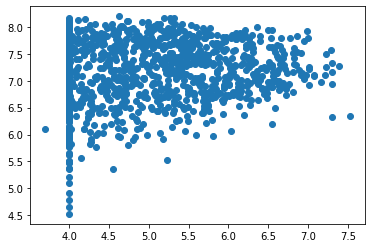

In [262]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()

x = df.dropna()['activity']
y = df.dropna()['score']
ax.scatter(x,y)

In [263]:
from scipy.stats import spearmanr
x = df.dropna()['activity']
y = df.dropna()['score']

spearmanr(x,y)
#mean_squared_error(x,y)

SpearmanrResult(correlation=0.03033530303734797, pvalue=0.2819382946694399)

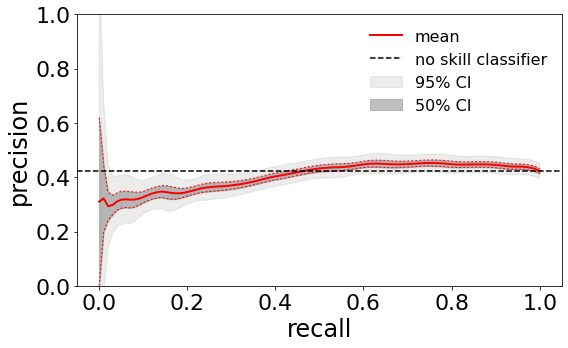

In [264]:
import matplotlib.pyplot as plt
import matplotlib
from scipy.stats import linregress
from scipy.constants import golden

thresh = 5
nbootstrap = 500

x = np.linspace(0,1,100)
field = 'activity'

fig, ax = plt.subplots()
fig.set_size_inches(8,8/golden)
df_select = df[~df[field].isnull()]

samplesize = len(df_select)

ps = []
np.random.seed(42)
for i in range(nbootstrap):
    df_sample = df_select.sample(n=samplesize,replace=True)
    yr = df_sample[field] >= thresh
    #samples = np.random.normal(df_sample['affinity_mean'],np.sqrt(df_sample['affinity_var']))
    samples = df_sample['score']
    p, r, _ = precision_recall_curve(yr,samples)#,sample_weight=1/df_sample['affinity_var'])
    ps.append(np.interp(x,r[::-1],p[::-1]))
#     if i % 100 == 0:
#         ax.plot(r,p,'-',color='b',alpha=1,lw=.5)
    #r, p, _ = roc_curve(yr, df_sample.prediction)
    #ps.append(np.interp(x,r,p))
    
ps = np.vstack(ps)
pavg = np.mean(ps,axis=0)
perr = np.std(ps,axis=0)
auc = np.trapz(pavg[::-1],x)
alpha_err = 0.15

ci = 1.96
lower = pavg - ci*perr
upper = pavg + ci*perr
ax.plot(x,pavg,label='mean'.format(thresh),color='r',lw=2)
#ax.plot(x,lower,color='r',lw=1,dashes=[2,2])
#ax.plot(x,upper,color='r',lw=1,dashes=[2,2])
ax.fill_between(x, lower, upper, color='gray', alpha=alpha_err, label='95% CI'.format(thresh))

ci = 0.67
lower = pavg - ci*perr
upper = pavg + ci*perr
#ax.plot(x,pavg,label='mean'.format(thresh),color='r',lw=2)
ax.plot(x,lower,color='r',lw=1,dashes=[2,2])
ax.plot(x,upper,color='r',lw=1,dashes=[2,2])
ax.fill_between(x, lower, upper, color='gray', alpha=.5, label='50% CI'.format(thresh))
ax.axhline(pavg[-1],ls='--',color='black',label='no skill classifier')

ax.set_ylim(0,1)

ax.set_xlabel('recall',fontsize=24,fontfamily='Helvetica Neue')
ax.set_ylabel('precision',fontsize=24,fontfamily='Helvetica Neue')
ax.set_ylim(0,1)

ax.tick_params(labelsize=22)
l = ax.legend(frameon=False,fontsize=16,loc='upper right')
l.get_title().set_fontsize(20)
plt.setp(l.texts, family='Helvetica Neue')

fig.tight_layout()
fig.savefig('mpro.png',dpi=300)


**BindingDB solution data**

In [71]:
! pip install webdataset

In [120]:
# validation data set
import webdataset as wd
import glob
test = wd.WebDataset(glob.glob('/gpfs/alpine/world-shared/bif136/pdbbind_complexes/test/part-*.tar'),
                     nodesplitter=lambda src: (s for s in src)).shuffle(1000).decode('torch')
test_names = [item['name.txt'] for item in test]

In [72]:
n = 500
df = pd.read_parquet('/gpfs/alpine/world-shared/bif136/binding_affinity/data/bindingdb_single.parquet')
df = df.sample(frac=1)
df = df[df.seq.str.len()<1024].iloc[0:n]
smiles_name = 'Ligand SMILES'
dataset = ProteinLigandDataset(df, smiles_name=smiles_name)

In [270]:
n = 500
df = pd.read_parquet('/gpfs/alpine/world-shared/bif136/binding_affinity/data/pdbbind.parquet')
df = df[df['seq'].str.len() < 1024]
df = df[df['name'].isin(test_names)]
df = df.iloc[0:n]
smiles_name = 'smiles'
dataset = ProteinLigandDataset(df, smiles_name=smiles_name)

In [73]:
%%time
output = list(models[0](dataset))
df['ligand_xyz'] = [o['ligand_frames_xyz'][0] for o in output]
df['receptor_feat'] = [o['receptor_xyz'][0] for o in output]

/opt/conda/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")


CPU times: user 40.8 s, sys: 46 s, total: 1min 26s
Wall time: 1min 26s


In [33]:
from oddt.scoring.functions.RFScore import rfscore
scorer = rfscore(version=2)
scorer.train()

Training RFScore v2 on PDBBind v2016
Test set:	R2_score: 0.5708	Rp: 0.8089	RMSE: 1.4238	SD: 1.2801
Train set:	R2_score: 0.8946	Rp: 0.9611	RMSE: 0.6478	SD: 0.5510
OOB set:	R2_score: 0.5450	Rp: 0.7418	RMSE: 1.3459	SD: 1.3382


'RFScore_v2_pdbbind2016.pickle'

In [51]:
#scorer.load('RFScoreVS_v2_dude.pickle')

In [74]:
RDLogger.DisableLog('rdApp.*')
warnings.filterwarnings('ignore')

scores = []
for seq, smi, ligand_xyz, feat in tqdm.auto.tqdm(list(zip(df['seq'], df[smiles_name], df['ligand_xyz'], df['receptor_feat']))):
    try:
        c = score_protein_ligand(seq, smi, feat, ligand_xyz)
        scores.append(scorer.model.predict(c))
    except KeyboardInterrupt:
        raise
    except:
        scores.append(None)

warnings.filterwarnings('once')
RDLogger.EnableLog('rdApp.*')

  0%|          | 0/500 [00:00<?, ?it/s]

In [75]:
df['score'] = scores

In [76]:
from scipy.stats import spearmanr
df_select = df[~df['score'].isna() & ~df['affinity_uM'].isna()]
x = 6-np.log10(df_select['affinity_uM'])
y = df_select['score']

spearmanr(x,y)
#mean_squared_error(x,y)

SpearmanrResult(correlation=0.1281314749663965, pvalue=0.004338829468097925)

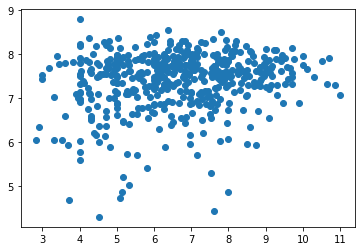

In [77]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
df_select = df[~df['score'].isna() & ~df['affinity_uM'].isna()]
x = 6-np.log10(df_select['affinity_uM'])
y = df_select['score']
ax.scatter(x,y)

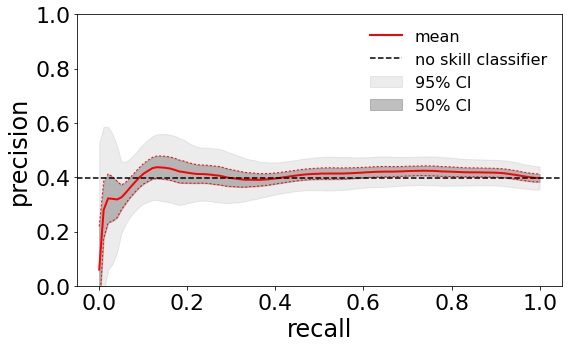

In [78]:
import matplotlib.pyplot as plt
import matplotlib
from scipy.stats import linregress
from scipy.constants import golden

thresh = .1
nbootstrap = 500

x = np.linspace(0,1,100)
field = 'affinity_uM'

fig, ax = plt.subplots()
fig.set_size_inches(8,8/golden)
df_select = df[~df['score'].isna() & ~df['affinity_uM'].isna()]

samplesize = len(df_select)

ps = []
np.random.seed(42)
for i in range(nbootstrap):
    df_sample = df_select.sample(n=samplesize,replace=True)
    yr = df_sample[field] < thresh
    samples = df_sample['score']
    p, r, _ = precision_recall_curve(yr,samples)
    ps.append(np.interp(x,r[::-1],p[::-1]))
    
ps = np.vstack(ps)
pavg = np.mean(ps,axis=0)
perr = np.std(ps,axis=0)
auc = np.trapz(pavg[::-1],x)
alpha_err = 0.15

ci = 1.96
lower = pavg - ci*perr
upper = pavg + ci*perr
ax.plot(x,pavg,label='mean'.format(thresh),color='r',lw=2)
#ax.plot(x,lower,color='r',lw=1,dashes=[2,2])
#ax.plot(x,upper,color='r',lw=1,dashes=[2,2])
ax.fill_between(x, lower, upper, color='gray', alpha=alpha_err, label='95% CI'.format(thresh))

ci = 0.67
lower = pavg - ci*perr
upper = pavg + ci*perr
#ax.plot(x,pavg,label='mean'.format(thresh),color='r',lw=2)
ax.plot(x,lower,color='r',lw=1,dashes=[2,2])
ax.plot(x,upper,color='r',lw=1,dashes=[2,2])
ax.fill_between(x, lower, upper, color='gray', alpha=.5, label='50% CI'.format(thresh))
ax.axhline(pavg[-1],ls='--',color='black',label='no skill classifier')

ax.set_ylim(0,1)

ax.set_xlabel('recall',fontsize=24,fontfamily='Helvetica Neue')
ax.set_ylabel('precision',fontsize=24,fontfamily='Helvetica Neue')
ax.set_ylim(0,1)

ax.tick_params(labelsize=22)
l = ax.legend(frameon=False,fontsize=16,loc='upper right')
l.get_title().set_fontsize(20)
plt.setp(l.texts, family='Helvetica Neue')

fig.tight_layout()
fig.savefig('pdbbind.png',dpi=300)

**PLpro**

In [280]:
df = pd.read_csv('../examples/shen_2021_biorxiv.csv',sep=',',header=None)
df = df.rename(columns={0: 'smiles', 1: 'name', 2: 'ic50'})

In [281]:
def make_numeric(ic50): 
    try:
        return float(ic50.replace('<','').replace('>','').split('-')[-1].split('~')[-1])
    except Exception as e:
        return np.nan

In [282]:
df['pIC50'] = 6-np.log10(df['ic50'].apply(make_numeric).astype('float32'))

In [283]:
# Jerry?
plpro_seq = 'VRTIKVFTTVDNINLHTQVVDMSMTYGQQFGPTYLDGADVTKIKPHNSHEGKTFYVLPNDDTLRVEAFEYYHTTDPSFLGRYMSALNHTKKWKYPQVNGLTSIKWADNNCYLATALLTLQQIELKFNPPALQDAYYRARAGEAANFCALILAYCNKTVGELGDVRETMSYLFQHANLDSCKRVLNVVCKTCGQQQTTLKGVEAVMYMGTLSYEQFKKGVQIPCTCGKQATKYLVQQESPFVMMSAPPAQYELKHGTFTCASEYTGNYQCGHYKHITSKETLYCIDGALLTKSSEYKGPITDVFYKENSYTTTI'

In [284]:
# aa 1564-1878 in https://www.uniprot.org/uniprot/P0C6X7#PRO_0000037311
plpro_seq = 'SMTYGQQFGPTYLDGADVTKIKPHVNHEGKTFFVLPSDDTLRSEAFEYYHTLDESFLGRYMSALNHTKKWKFPQVGGLTSIKWADNNCYLSSVLLALQQLEVKFNAPALQEAYYRARAGDAANFCALILAYSNKTVGELGDVRETMTHLLQHANLESAKRVLNVVCKHCGQKTTTLTGVEAVMYMGTLSYDNLKTGVSIPCVCGRDATQYLVQQESSFVMMSAPPAEYKLQQGTFLCANEYTGNYQCGHYTHITAKETLYRIDGAHLTKMSEYKGPVTDVFYKETSYTTTIKPVSYKLDGVTYTEIEPKLDGYYK'

In [285]:
df['seq'] = plpro_seq

In [286]:
dataset = ProteinLigandDataset(df)

In [287]:
%%time
output = list(models[0](dataset))
df['ligand_xyz'] = [o['ligand_frames_xyz'][0] for o in output]
df['receptor_feat'] = [o['receptor_xyz'][0] for o in output]

/opt/conda/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
[14:15:12] SMILES Parse Error: extra open parentheses for input: 'Cc2ccc(NC1CNC1)cc2C(=O)N[C@H](C)c5cccc(c4ccc(C(=O)NC[C@H]3CCCO3)s'
[14:15:12] SMILES Parse Error: extra open parentheses for input: 'Cc2ccc(NC1CNC1)cc2C(=O)N[C@H](C)c5cccc(c4ccc(C(=O)NC[C@@H]3CCCO3)'


CPU times: user 3.01 s, sys: 1.95 s, total: 4.97 s
Wall time: 4.98 s


In [288]:
RDLogger.DisableLog('rdApp.*')
warnings.filterwarnings('ignore')

scores = []
for seq, smi, ligand_xyz, feat in tqdm.auto.tqdm(list(zip(df['seq'], df['smiles'], df['ligand_xyz'], df['receptor_feat']))):
    try:
        c = score_protein_ligand(seq, smi, feat, ligand_xyz)
        scores.append(scorer.model.predict(c))
    except KeyboardInterrupt:
        raise
    except:
        scores.append(None)

warnings.filterwarnings('once')
RDLogger.EnableLog('rdApp.*')

  0%|          | 0/99 [00:00<?, ?it/s]

In [289]:
df['score'] = scores

In [290]:
from scipy.stats import spearmanr
df_select = df[~df['score'].isna() & ~df['pIC50'].isna()]
x = df_select['pIC50']
y = df_select['score']

spearmanr(x,y)
#mean_squared_error(x,y)

SpearmanrResult(correlation=0.6872759190714156, pvalue=2.7914602680477806e-14)

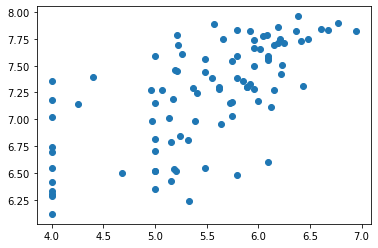

In [291]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
df_select = df[~df['score'].isna() & ~df['pIC50'].isna()]
x = df_select['pIC50']
y = df_select['score']
ax.scatter(x,y)

**Ligand vocabulary**

In [88]:
bert_tokenizer_directory = '/gpfs/alpine/world-shared/med106/blnchrd/models/bert_large_plus_clean/tokenizer/'
with open(bert_tokenizer_directory+'/config.json','r') as f:
    bert_tokenizer_config = json.load(f)
bert_tokenizer = AutoTokenizer.from_pretrained(bert_tokenizer_directory, **bert_tokenizer_config)

In [100]:
bert_tokenizer.decode(bert_tokenizer.encode(Chem.MolToSmiles(aa['S'].ref)))

'[CLS] N [ C @ @ H ] ( CO ) C ( = O ) O [SEP]'

In [93]:
bert_tokenizer.decode(bert_tokenizer.encode(Chem.MolToSmiles(aa['K'].ref)))

'[CLS] N [ C @ @ H ] ( CCCC [ NH3 + ] ) C ( = O ) O [SEP]'

In [94]:
bert_tokenizer.decode(bert_tokenizer.encode(Chem.MolToSmiles(aa['G'].ref)))

'[CLS] NCC ( = O ) O [SEP]'

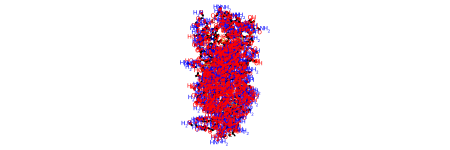

In [102]:
mol = Chem.MolFromPDBFile('../examples/7s3s_protein.pdb')
mol

In [103]:
Chem.MolToSmiles(mol)

'CC[C@H](C)[C@H](NC(=O)CNC(=O)[C@@H](NC(=O)[C@H](CCC(N)=O)NC(=O)[C@H](C)NC(=O)[C@H](CO)NC(=O)[C@H](CC(C)C)NC(=O)[C@@H]1CCCN1C(=O)CNC(=O)[C@H](CC(C)C)NC(=O)[C@@H](NC(=O)[C@H](CC(=O)O)NC(=O)[C@@H](NC(=O)[C@H](Cc1c[nH]cn1)NC(=O)[C@H](CC(=O)O)NC(=O)[C@H](CCC(N)=O)NC(=O)[C@@H](NC(=O)[C@H](CC(C)C)NC(=O)[C@@H]1CCCN1C(=O)[C@H](CCC(=O)O)NC(=O)[C@H](Cc1ccc(O)cc1)NC(=O)[C@H](CC(N)=O)NC(=O)[C@H](Cc1ccc(O)cc1)NC(=O)[C@H](CCCCN)NC(=O)[C@H](CCSC)NC(=O)[C@H](C)NC(=O)[C@@H](NC(=O)[C@H](CC(C)C)NC(=O)[C@H](CC(N)=O)NC(=O)[C@H](Cc1ccccc1)NC(=O)[C@H](CC(=O)O)NC(=O)[C@H](CC(N)=O)NC(=O)[C@H](CC(C)C)NC(=O)[C@@H](NC(=O)[C@@H](NC(=O)[C@@H](NC(=O)[C@H](Cc1ccccc1)NC(=O)[C@H](CCCNC(=N)N)NC(=O)[C@H](CC(N)=O)NC(=O)[C@H](CC(C)C)NC(=O)[C@H](Cc1ccccc1)NC(=O)[C@H](Cc1c[nH]c2ccccc12)NC(=O)[C@H](CCCNC(=N)N)NC(=O)[C@H](CC(=O)O)NC(=O)CNC(=O)[C@H](CC(N)=O)NC(=O)[C@@H](NC(=O)[C@@H](NC(=O)[C@H](C)NC(=O)[C@H](C)NC(=O)[C@H](Cc1ccc(O)cc1)NC(=O)[C@H](CC(C)C)NC(=O)[C@H](Cc1c[nH]c2ccccc12)NC(=O)[C@H](C)NC(=O)[C@H](CC(C)C)NC(=O)[C@@H]

**PostEra Mpro**

In [51]:
df = pd.read_csv('/ccs/home/glaser/activity_data.csv')

In [121]:
#mpro_seq_uniprot

In [122]:
import random

In [16]:
mpro_seq_sars1 = 'SGFRKMAFPSGKVEGCMVQVTCGTTTLNGLWLDDTVYCPRHVICTAEDMLNPNYEDLLIRKSNHSFLVQAGNVQLRVIGHSMQNCLLRLKVDTSNPKTPKYKFVRIQPGQTFSVLACYNGSPSGVYQCAMRPNHTIKGSFLNGSCGSVGFNIDYDCVSFCYMHHMELPTGVHAGTDLEGKFYGPFVDRQTAQAAGTDTTITLNVLAWLYAAVINGDRWFLNRFTTTLNDFNLVAMKYNYEPLTQDHVDILGPLSAQTGIAVLDMCAALKELLQNGMNGRTILGSTILEDEFTPFDVVRQCSGA'
mpro_seq_sars1_dimer = 'SGFRKMAFPSGKVEGCMVQVTCGTTTLNGLWLDDTVYCPRHVICTAEDMLNPNYEDLLIRKSNHSFLVQAGNVQLRVIGHSMQNCLLRLKVDTSNPKTPKYKFVRIQPGQTFSVLACYNGSPSGVYQCAMRPNHTIKGSFLNGSCGSVGFNIDYDCVSFCYMHHMELPTGVHAGTDLEGKFYGPFVDRQTAQAAGTDTTITLNVLAWLYAAVINGDRWFLNRFTTTLNDFNLVAMKYNYEPLTQDHVDILGPLSAQTGIAVLDMCAALKELLQNGMNGRTILGSTILEDEFTPFDVVRQCSGASGFRKMAFPSGKVEGCMVQVTCGTTTLNGLWLDDTVYCPRHVICTAEDMLNPNYEDLLIRKSNHSFLVQAGNVQLRVIGHSMQNCLLRLKVDTSNPKTPKYKFVRIQPGQTFSVLACYNGSPSGVYQCAMRPNHTIKGSFLNGSCGSVGFNIDYDCVSFCYMHHMELPTGVHAGTDLEGKFYGPFVDRQTAQAAGTDTTITLNVLAWLYAAVINGDRWFLNRFTTTLNDFNLVAMKYNYEPLTQDHVDILGPLSAQTGIAVLDMCAALKELLQNGMNGRTILGSTILEDEFTPFDVVRQCSGA'
mpro_seq_sars2_dimer = mpro_seq_uniprot+mpro_seq_uniprot

In [17]:
#postera_dataset = InhibDataset(df=df, smiles_name='SMILES', seq=''.join(random.sample(mpro_seq_uniprot,len(mpro_seq_uniprot))))
postera_dimer_dataset = InhibDataset(df=df, smiles_name='SMILES', seq=mpro_seq_sars2_dimer)
postera_dataset = InhibDataset(df=df, smiles_name='SMILES', seq=mpro_seq_uniprot)
[scale(r['affinity']) for r in models[0]([postera_dataset[0]])]

[array([[6.816194]], dtype=float32)]

In [18]:
# 4MDS
df_inhib = pd.DataFrame({'seq': mpro_seq_sars1_dimer, 'smiles': ['CCC(C)(C)NC(=O)C(c1cccn1C)N(C(=O)Cn1nnc2ccccc21)c1ccc(NC(C)=O)cc1']})
# pf07321332
df_inhib = pd.DataFrame({'seq': mpro_seq_uniprot, 'smiles': ['[H][C@]12CN([C@H](C(=O)N[C@@H](C[C@]3([H])CCNC3=O)C#N)[C@@]1([H])C2(C)C)C(=O)[C@@H](NC(=O)C(F)(F)F)C(C)(C)C']})
# 4WI
#df_inhib = pd.DataFrame({'seq': mpro_seq_uniprot, 'smiles': ['[H]/N=C/[C@H](C[C@@H]1CCNC1=O)NC(=O)[C@@H]2[C@@H]3[C@@H](C3(C)C)CN2C(=O)[C@H](C(C)(C)C)NC(=O)C(F)(F)F']})
# 7S4B
#df_inhib = pd.DataFrame({'seq': mpro_seq_uniprot, 'smiles': ['C[C@@H](C(=O)Nc1cncc2ccccc12)c1cccc(F)c1']})
inhib_dataset = AffinityDataset(df_inhib, smiles_name='smiles')

In [19]:
random_mpro = ''.join(random.sample(mpro_seq_uniprot,len(mpro_seq_uniprot)))
random_dataset = InhibDataset(df=df, smiles_name='SMILES', seq=random_mpro)
[scale(r['affinity']) for r in models[0]([random_dataset[0]])]

[array([[6.5528984]], dtype=float32)]

In [20]:
%matplotlib inline

In [21]:
fake_dataset = InhibDataset(df=df, smiles_name='SMILES', seq='SEQVENCE')
[scale(r['affinity'][0,0]) for r in models[0]([fake_dataset[0]])]

[6.36153252107171]

In [22]:
postera_dataset[0]

{'protein': 'SGFRKMAFPSGKVEGCMVQVTCGTTTLNGLWLDDVVYCPRHVICTSEDMLNPNYEDLLIRKSNHNFLVQAGNVQLRVIGHSMQNCVLKLKVDTANPKTPKYKFVRIQPGQTFSVLACYNGSPSGVYQCAMRPNFTIKGSFLNGSCGSVGFNIDYDCVSFCYMHHMELPTGVHAGTDLEGNFYGPFVDRQTAQAAGTDTTITVNVLAWLYAAVINGDRWFLNRFTTTLNDFNLVAMKYNYEPLTQDHVDILGPLSAQTGIAVLDMCASLKELLQNGMNGRTILGSALLEDEFTPFDVVRQCSGVTFQ',
 'ligand': 'COC(=O)CN(C)S(=O)(=O)N1Cc2ccc(Cl)cc2C(C(=O)Nc2cncc3ccccc23)C1'}

In [35]:
postera_dataset[0]

{'protein': 'SGFRKMAFPSGKVEGCMVQVTCGTTTLNGLWLDDVVYCPRHVICTSEDMLNPNYEDLLIRKSNHNFLVQAGNVQLRVIGHSMQNCVLKLKVDTANPKTPKYKFVRIQPGQTFSVLACYNGSPSGVYQCAMRPNFTIKGSFLNGSCGSVGFNIDYDCVSFCYMHHMELPTGVHAGTDLEGNFYGPFVDRQTAQAAGTDTTITVNVLAWLYAAVINGDRWFLNRFTTTLNDFNLVAMKYNYEPLTQDHVDILGPLSAQTGIAVLDMCASLKELLQNGMNGRTILGSALLEDEFTPFDVVRQCSGVTFQ',
 'ligand': 'COC(=O)CN(C)S(=O)(=O)N1Cc2ccc(Cl)cc2C(C(=O)Nc2cncc3ccccc23)C1'}

0.07403527439106783


/tmp/ipykernel_1129411/678553987.py:32: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "tight_layout" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.savefig('mpro_contacts.png',dpi=300,tight_layout=True)


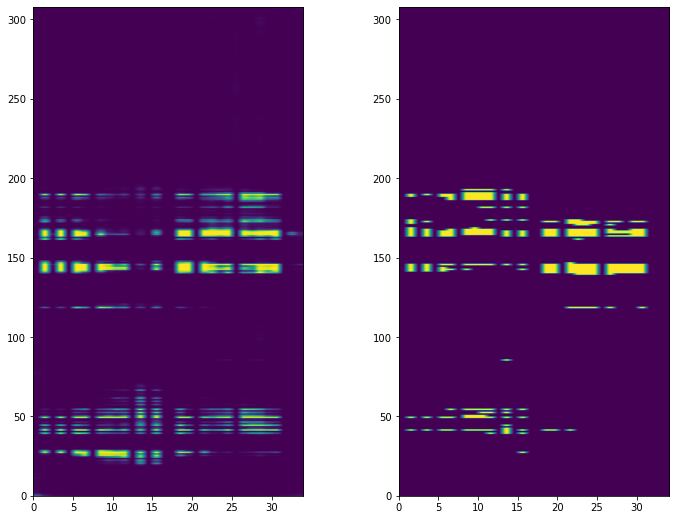

In [23]:
item = postera_dataset[1223]
X = np.pad(np.load('/home/xvg/contact_7s3s.npy'),(1,1))

#item = inhib_dataset[0]
#X = np.pad(np.load('/home/xvg/contact_7vh8.npy'),(1,1))
#X = np.pad(np.load('/home/xvg/contact_4mds.npy'),(1,1))
#X = np.pad(np.load('/home/xvg/contact_7s4b_8A.npy'),(1,1))

inp = item
out = models[0]([inp])[0]
contacts = out['contacts_1'].squeeze(0).squeeze(0)

import matplotlib.pyplot as plt
from scipy.special import expit
fig, axes = plt.subplots(1,2)
fig.set_size_inches(12,9)
it = models[0].tokenizer(features=inp)
nseq, nsmi = len(it['input_ids_1']), len(it['input_ids_2'])
extent = (0,nsmi,nseq,0)
p= axes[0].imshow(expit(contacts),extent=extent)
p.set_clim(0,1)

q = axes[1].imshow(X,extent=[0,512,2048,0])

from sklearn.metrics import log_loss
print(log_loss(X.reshape(2048,512)[:nseq,:nsmi].flatten(),expit(contacts[:nseq,:nsmi].flatten())))
for ax in axes:
    ax.set_xlim(0,nsmi)
    ax.set_ylim(0,nseq)
    ax.set_aspect(.2
                 )
fig.savefig('mpro_contacts.png',dpi=300,tight_layout=True)

In [24]:
for i,model in enumerate(tqdm.auto.tqdm(models)):
    y_pred=model(random_dataset)
    df[f'affinity_random_{i}'] = [scale(r['affinity'][0,0]) for r in y_pred]
df['affinity_random_mean'] = np.mean([df[f'affinity_random_{i}'] for i in range(len(models))],axis=0)
df['affinity_random_var'] = np.var([df[f'affinity_random_{i}'] for i in range(len(models))],axis=0)

  0%|          | 0/1 [00:00<?, ?it/s]

In [25]:
for i,model in enumerate(tqdm.auto.tqdm(models)):
    y_pred=model(fake_dataset)
    df[f'affinity_fake_{i}'] = [scale(r['affinity'][0,0]) for r in y_pred]
df['affinity_fake_mean'] = np.mean([df[f'affinity_fake_{i}'] for i in range(len(models))],axis=0)
df['affinity_fake_var'] = np.var([df[f'affinity_fake_{i}'] for i in range(len(models))],axis=0)

  0%|          | 0/1 [00:00<?, ?it/s]

In [26]:
for i,model in enumerate(tqdm.auto.tqdm(models)):
    y_pred=model(postera_dataset)
    #y_pred = [model([item]) for item in tqdm.auto.tqdm(postera_dataset)]
    df[f'affinity_{i}'] = [scale(r['affinity'][0,0]) for r in y_pred]
df['affinity_mean'] = np.mean([df[f'affinity_{i}'] for i in range(len(models))],axis=0)
df['affinity_var'] = np.var([df[f'affinity_{i}'] for i in range(len(models))],axis=0)

  0%|          | 0/1 [00:00<?, ?it/s]

In [27]:
for i,model in enumerate(tqdm.auto.tqdm(models)):
    y_pred=model(postera_dimer_dataset)
    #y_pred = [model([item]) for item in tqdm.auto.tqdm(postera_dataset)]
    df[f'affinity_dimer_{i}'] = [scale(r['affinity'][0,0]) for r in y_pred]
df['affinity_dimer_mean'] = np.mean([df[f'affinity_dimer_{i}'] for i in range(len(models))],axis=0)
df['affinity_dimer_var'] = np.var([df[f'affinity_dimer_{i}'] for i in range(len(models))],axis=0)

  0%|          | 0/1 [00:00<?, ?it/s]

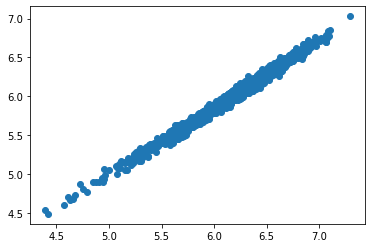

In [28]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
x = df['affinity_mean']
y = df['affinity_random_mean']
ax.scatter(x,y)
fig.savefig('affinity_mpro_vs_random.png')

In [29]:
# uncomment to load paper results

#df.to_parquet(f'postera.parquet')
#df = pd.read_parquet(f'postera.parquet')

In [30]:
from scipy.stats import spearmanr
field = 'f_avg_IC50'
filt = ~df[field].isnull()
x = df[filt]['affinity_mean']
y = 6-np.log10(df[filt][field])
print(spearmanr(x,y))
print(mean_squared_error(x,y))

SpearmanrResult(correlation=0.22409051231136562, pvalue=5.3644774385944636e-17)
2.453560664933673


In [31]:
from scipy.stats import spearmanr
field = 'f_avg_IC50'
filt = ~df[field].isnull()
x = df[filt]['affinity_dimer_mean']
y = 6-np.log10(df[filt][field])
print(spearmanr(x,y))
print(mean_squared_error(x,y))

SpearmanrResult(correlation=0.20387227828376722, pvalue=2.8411744917543986e-14)
2.369159133302715


In [32]:
from scipy.stats import spearmanr
field = 'f_avg_IC50'
filt = (~df[field].isnull())
x = df[filt]['affinity_random_mean']
y = 6-np.log10(df[filt][field])
spearmanr(x,y)
#mean_squared_error(x,y)

SpearmanrResult(correlation=0.21766172745107398, pvalue=4.2215573036482886e-16)

In [33]:
from scipy.stats import spearmanr
field = 'f_avg_IC50'
filt = (~df[field].isnull())
x = df[filt]['affinity_fake_mean']
y = 6-np.log10(df[filt][field])
spearmanr(x,y)
#mean_squared_error(x,y)

SpearmanrResult(correlation=0.2168648215385628, pvalue=5.42731588376286e-16)

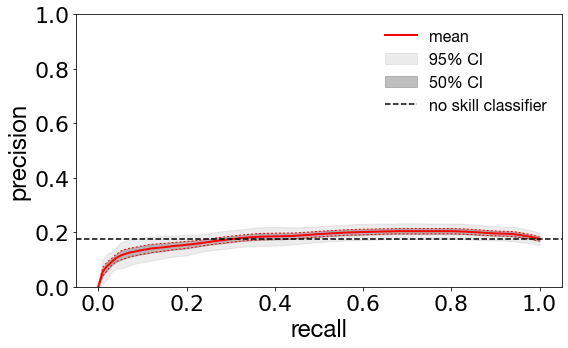

In [34]:
import matplotlib.pyplot as plt
import matplotlib
from scipy.stats import linregress
from scipy.constants import golden

thresh = 1
nbootstrap = 500

x = np.linspace(0,1,100)
field = 'f_avg_IC50'

fig, ax = plt.subplots()
fig.set_size_inches(8,8/golden)
df_select = df[~df[field].isnull()]

samplesize = len(df_select)

ps = []
np.random.seed(42)
for i in range(nbootstrap):
    df_sample = df_select.sample(n=samplesize,replace=True)#, weights=1/df_select['affinity_var']) 
    yr = df_sample[field] < thresh
    #samples = np.random.normal(df_sample['affinity_mean'],np.sqrt(df_sample['affinity_var']))
    samples = df_sample['affinity_mean']
    p, r, _ = precision_recall_curve(yr,samples)#,sample_weight=1/df_sample['affinity_var'])
    ps.append(np.interp(x,r[::-1],p[::-1]))
#     if i % 100 == 0:
#         ax.plot(r,p,'-',color='b',alpha=1,lw=.5)
    #r, p, _ = roc_curve(yr, df_sample.prediction)
    #ps.append(np.interp(x,r,p))
    
ps = np.vstack(ps)
pavg = np.mean(ps,axis=0)
perr = np.std(ps,axis=0)
auc = np.trapz(pavg[::-1],x)
alpha_err = 0.15

ci = 1.96
lower = pavg - ci*perr
upper = pavg + ci*perr
ax.plot(x,pavg,label='mean'.format(thresh),color='r',lw=2)
#ax.plot(x,lower,color='r',lw=1,dashes=[2,2])
#ax.plot(x,upper,color='r',lw=1,dashes=[2,2])
ax.fill_between(x, lower, upper, color='gray', alpha=alpha_err, label='95% CI'.format(thresh))

ci = 0.67
lower = pavg - ci*perr
upper = pavg + ci*perr
#ax.plot(x,pavg,label='mean'.format(thresh),color='r',lw=2)
ax.plot(x,lower,color='r',lw=1,dashes=[2,2])
ax.plot(x,upper,color='r',lw=1,dashes=[2,2])
ax.fill_between(x, lower, upper, color='gray', alpha=.5, label='50% CI'.format(thresh))
ax.axhline(pavg[-1],ls='--',color='black',label='no skill classifier')

ax.set_ylim(0,1)

ax.set_xlabel('recall',fontsize=24,fontfamily='Helvetica Neue')
ax.set_ylabel('precision',fontsize=24,fontfamily='Helvetica Neue')
ax.set_ylim(0,1)

ax.tick_params(labelsize=22)
l = ax.legend(frameon=False,fontsize=16,loc='upper right')
l.get_title().set_fontsize(20)
plt.setp(l.texts, family='Helvetica Neue')

# ax2 = ax.inset_axes(bounds=(0.6,0.6,0.4,0.4))
# df_select = df#[df['f_avg_IC50']<90]
# y = 6-np.log(df_select['f_avg_IC50'])/np.log(10)
# x = df_select['affinity_mean']
# c = -np.log(df_select['affinity_var'])
# ax2.scatter(x,y,c=c)
# res = linregress(x,y)
# xfit = np.linspace(x.min(),x.max(),2)
# ax2.plot(xfit,res.intercept + res.slope*xfit, 'r', label=f"{res.slope :.2f}*x+{res.intercept:.2f}")
# ax2.set_ylabel('experimental pIC50',fontsize=14)
# ax2.set_xlabel('predicted pIC50',fontsize=14)
# ax2.legend(frameon=False)
# ax2.tick_params(labelsize=16)

# df_select = df[df['f_avg_IC50'] < thresh]
# ax2.scatter(df_select['affinity_mean'],np.log(df_select['affinity_var']),s=25,alpha=0.5,zorder=2,lw=0.5,edgecolor='k')
# df_select = df[df['f_avg_IC50'] >= thresh]
# ax2.scatter(df_select['affinity_mean'],np.log(df_select['affinity_var']),s=25,alpha=0.5,zorder=1,lw=0.5,edgecolor='k')
# ax2.set_xlabel('-log[Affinity] $\mu$',fontsize=22)
# ax2.set_ylabel('log $\sigma^2$',fontsize=22)
# ax2.axvline(6-np.log(thresh)/np.log(10),dashes=[1,1])

fig.tight_layout()
fig.savefig('mpro.png',dpi=300)
# fig.savefig('mpro_new_pretrain.pdf')
# fig.savefig('mpro_new_pretrain.svg')

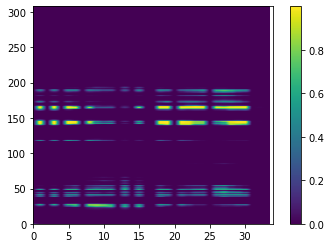

In [40]:
inp = postera_dataset[1223]
contacts = models[0]([inp])[0]['contacts_1'].squeeze(0).squeeze(0)

import matplotlib.pyplot as plt
from scipy.special import expit
fig, ax = plt.subplots()
item = models[0].tokenizer(features=inp)
nseq, nsmi = len(item['input_ids_1']), len(item['input_ids_2'])
p= ax.imshow(expit(contacts))
ax.set_xlim(0,nsmi)
ax.set_ylim(0,nseq)
ax.set_aspect(.1)
fig.colorbar(p)

**NCATS Mpro**

In [235]:
df = pd.read_csv('/home/xvg/affinity_pred/affinity_pred/data/3CL_enzymatic_activity.tsv',sep='\t')
#df = df[df['LOG_AC50'].notnull()].reset_index(drop=True)

In [236]:
ncats_dataset = InhibDataset(df=df, seq=mpro_seq_uniprot,smiles_name='SMILES')

In [237]:
for i,model in enumerate(tqdm.auto.tqdm(models)):
    y_pred=model(ncats_dataset)
    #y_pred = [model([item]) for item in tqdm.auto.tqdm(postera_dataset)]
    df[f'affinity_{i}'] = [scale(r['affinity'][0,0]) for r in y_pred]
df['affinity_mean'] = np.mean([df[f'affinity_{i}'] for i in range(len(models))],axis=0)
df['affinity_var'] = np.var([df[f'affinity_{i}'] for i in range(len(models))],axis=0)

  0%|          | 0/1 [00:00<?, ?it/s]

RDKit ERROR: [13:48:04] Can't kekulize mol.  Unkekulized atoms: 4 5 6 7 8 9 10 16 17
[13:48:04] Can't kekulize mol.  Unkekulized atoms: 4 5 6 7 8 9 10 16 17

RDKit ERROR: 
RDKit ERROR: [13:48:05] Can't kekulize mol.  Unkekulized atoms: 5 6 7 8 9 10 11 12 13
[13:48:05] Can't kekulize mol.  Unkekulized atoms: 5 6 7 8 9 10 11 12 13

RDKit ERROR: 
RDKit ERROR: [13:48:06] Can't kekulize mol.  Unkekulized atoms: 25 26 27 28 29
[13:48:06] Can't kekulize mol.  Unkekulized atoms: 25 26 27 28 29

RDKit ERROR: 
RDKit ERROR: [13:48:06] Can't kekulize mol.  Unkekulized atoms: 13 14 15 16 17 18 19 20 21
[13:48:06] Can't kekulize mol.  Unkekulized atoms: 13 14 15 16 17 18 19 20 21

RDKit ERROR: 
RDKit ERROR: [13:48:06] Can't kekulize mol.  Unkekulized atoms: 13 14 15 16 17 18 19 20 21
[13:48:06] Can't kekulize mol.  Unkekulized atoms: 13 14 15 16 17 18 19 20 21

RDKit ERROR: 
RDKit ERROR: [13:48:07] Can't kekulize mol.  Unkekulized atoms: 10 11 12 13 14 15 16 17 18
[13:48:07] Can't kekulize mol.  Unk

In [239]:
#df.to_parquet('ncats_mpro.parquet')
#df = pd.read_parquet('ncats_mpro.parquet')

In [240]:
from scipy.stats import spearmanr

filt = ~df['EFFICACY'].isnull()# & (~df['LOG_AC50'].isnull())
x = -df[filt]['EFFICACY']
y = df[filt]['affinity_mean']

spearmanr(x,y)

SpearmanrResult(correlation=0.012001192390913318, pvalue=0.19125255796480398)

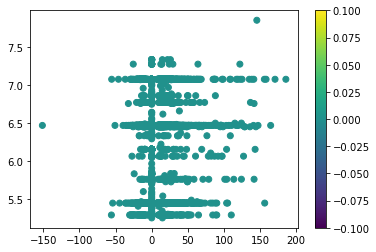

In [241]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
x = -df[filt]['EFFICACY']
y = df[filt]['affinity_mean']
z = df[filt]['affinity_var']
p = ax.scatter(x,y,c=z)
fig.colorbar(p)

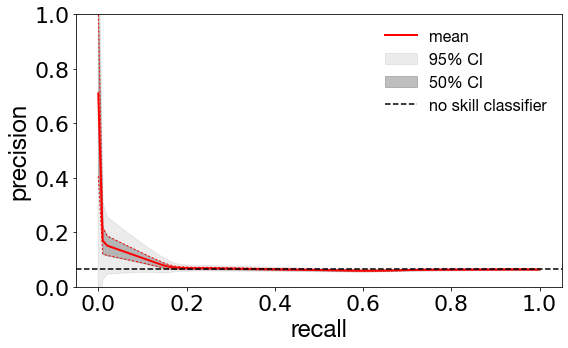

In [244]:
import matplotlib.pyplot as plt
import matplotlib
from scipy.stats import linregress
from scipy.constants import golden

thresh = -25
nbootstrap = 1000

x = np.linspace(0,1,100)
field = 'EFFICACY'

fig, ax = plt.subplots()
fig.set_size_inches(8,8/golden)
df_select = df[~df[field].isnull()]# & (df['EFFICACY'] < 0)]
samplesize = len(df_select)
ps = []
np.random.seed(42)
for i in range(nbootstrap):
    df_sample = df_select.sample(n=samplesize,replace=True) 
    yr = df_sample[field] < thresh
    samples = np.random.normal(df_sample['affinity_mean'],np.sqrt(df_sample['affinity_var']))
    #samples = df_sample['affinity_mean']
    p, r, _ = precision_recall_curve(yr,samples)#,sample_weight=1/df_sample['affinity_var'])
    ps.append(np.interp(x,r[::-1],p[::-1]))
    
ps = np.vstack(ps)
pavg = np.mean(ps,axis=0)
perr = np.std(ps,axis=0)
auc = np.trapz(pavg[::-1],x)
alpha_err = 0.15

ci = 1.96
lower = pavg - ci*perr
upper = pavg + ci*perr
ax.plot(x,pavg,label='mean'.format(thresh),color='r',lw=2)
#ax.plot(x,lower,color='r',lw=1,dashes=[2,2])
#ax.plot(x,upper,color='r',lw=1,dashes=[2,2])
ax.fill_between(x, lower, upper, color='gray', alpha=alpha_err, label='95% CI'.format(thresh))

ci = 0.67
lower = pavg - ci*perr
upper = pavg + ci*perr
#ax.plot(x,pavg,label='mean'.format(thresh),color='r',lw=2)
ax.plot(x,lower,color='r',lw=1,dashes=[2,2])
ax.plot(x,upper,color='r',lw=1,dashes=[2,2])
ax.fill_between(x, lower, upper, color='gray', alpha=.5, label='50% CI'.format(thresh))
ax.axhline(pavg[-1],ls='--',color='black',label='no skill classifier')

ax.set_ylim(0,1)

ax.set_xlabel('recall',fontsize=24,fontfamily='Helvetica Neue')
ax.set_ylabel('precision',fontsize=24,fontfamily='Helvetica Neue')
ax.set_ylim(0,1)

ax.tick_params(labelsize=22)
l = ax.legend(frameon=False,fontsize=16,loc='upper right')
l.get_title().set_fontsize(20)
plt.setp(l.texts, family='Helvetica Neue')

fig.tight_layout()
fig.savefig('ncats_mpro.png',dpi=300)

**Mpro inhibitors predicted by sparse attention model, uniform distribution**

In [171]:
df_uniform = pd.read_csv('/home/xvg/uniform.csv')

In [172]:
df_uniform['mean'].describe()

count    105.000000
mean       7.690395
std        0.697836
min        6.517365
25%        7.111833
50%        7.649643
75%        8.201719
max        9.097073
Name: mean, dtype: float64

In [173]:
uniform_dataset = InhibDataset(df_uniform,seq=mpro_seq_5r84)

In [174]:
for i,model in enumerate(tqdm.auto.tqdm(models)):
    y_pred=model(uniform_dataset)
    df_uniform[f'affinity_{i}'] = [scale(r['affinity'][0,0]) for r in y_pred]
df_uniform['affinity_mean'] = np.mean([df_uniform[f'affinity_{i}'] for i in range(len(models))],axis=0)
df_uniform['affinity_var'] = np.var([df_uniform[f'affinity_{i}'] for i in range(len(models))],axis=0)

  0%|          | 0/1 [00:00<?, ?it/s]

In [175]:
#df_order[['ID','Smile']].to_csv('/home/xvg/DeepSCAMs/test.txt',sep='\t', index=False)
#! cd /home/xvg/DeepSCAMs; python DeepSCAMs.py
df_agg = pd.read_csv('/home/xvg/DeepSCAMs/test_preds.txt',sep='\t')

In [176]:
df_order = pd.read_csv('/home/xvg/order_enamine_z178890-108-1398601.csv')
df_order = df_order.merge(df_agg,on='ID')
df_order['cno'] = df_order.index + 1

In [177]:
df_order

,ID,CatalogID,Formula,Barcode_1,MW,Purity,PO,Salt_Name,Salt_ratio,MW_salt,...,Stereochem.data,Geometric.isomer,Smile,Name,index,CXSMILES,Preds,Prob_0,Prob_1,cno
0,PV-004106684588,Z5197597801,C19H29FN4O2,1215699846,364.457,96,NaN,NaN,NaN,0,...,Diastereomeric mixture,None,CC(C)C1=CC(=NN1)C(=O)NC2CCN(C2)C(=O)C(F)C3CCCCC3,N-[1-(2-cyclohexyl-2-fluoroacetyl)pyrrolidin-3...,141,CC(C)c1cc(n[nH]1)C(=O)NC2CCN(C2)C(=O)C(F)C3CCCCC3,0,0.997828,0.002172,1
1,Z4051673002,Z4051673002,C21H30N6O2,1215699847,398.501,97,NaN,NaN,NaN,0,...,Achiral,None,CC(C)C1=CC(=NN1)C(=O)N2CCN(CC3(CC3)C2)C(=O)C=4...,"5,8-bis[5-(propan-2-yl)-1H-pyrazole-3-carbonyl...",113,CC(C)c1cc(n[nH]1)C(=O)N2CCN(CC3(CC3)C2)C(=O)c4...,0,0.999891,0.000109,2
2,Z2832518906,Z2832518906,C15H16FN5,1215699848,285.319,100,NaN,NaN,NaN,0,...,Achiral,None,CCC1=NC=CN1CC2=CN(N=N2)C=3C=CC(F)=C(C)C3,4-[(2-ethyl-1H-imidazol-1-yl)methyl]-1-(4-fluo...,112,CCc1nccn1Cc2cn(nn2)c3ccc(F)c(C)c3,0,0.992810,0.007190,3
3,Z4151005893,Z4151005893,C15H16FN5O,1215699849,301.318,100,NaN,NaN,NaN,0,...,Achiral,None,CCC1=NC=CN1CC2=CN(N=N2)C=3C=CC(F)=C(CO)C3,"(5-{4-[(2-ethyl-1H-imidazol-1-yl)methyl]-1H-1,...",81,CCc1nccn1Cc2cn(nn2)c3ccc(F)c(CO)c3,0,0.995791,0.004209,4
4,PV-003687523072,Z5197597811,C14H13ClFN5,1215699851,305.737,100,NaN,NaN,NaN,0,...,Achiral,None,CCC1=NC=CN1CC2=CN(N=N2)C=3C=C(F)C=C(Cl)C3,1-(3-chloro-5-fluorophenyl)-4-[(2-ethyl-1H-imi...,4,CCc1nccn1Cc2cn(nn2)c3cc(F)cc(Cl)c3,0,0.980981,0.019019,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
154,PV-001418455359,Z5197596837,C21H31N3O2,1215699543,357.489,96,NaN,NaN,NaN,0,...,Racemic or presumed racemic or meso,None,O=C(CCC1CCCC1)NC2CCN(C2)C(=O)C=3C=CNC3C4CCC4,N-[1-(2-cyclobutyl-1H-pyrrole-3-carbonyl)pyrro...,84,O=C(CCC1CCCC1)NC2CCN(C2)C(=O)c3cc[nH]c3C4CCC4,0,0.997462,0.002538,155
155,PV-004075616921,Z5197596851,C21H32N2O3,1215699544,360.490,93,NaN,NaN,NaN,0,...,Diastereomeric mixture,None,CCC=1C=CC=CC1CC(=O)NC2CCN(C2)C(=O)C(O)C(C)(C)CC,"2-(2-ethylphenyl)-N-[1-(2-hydroxy-3,3-dimethyl...",15,CCc1ccccc1CC(=O)NC2CCN(C2)C(=O)C(O)C(C)(C)CC,0,0.993330,0.006670,156
156,PV-004084061887,Z5197596841,C18H28N6O2,1215699545,360.453,98,NaN,NaN,NaN,0,...,Diastereomeric mixture,None,CC(C)C(NC(=O)CN1C=CC=N1)C(C)NC(=O)C=2C=C(NN2)C...,N-(2-methyl-4-{[5-(propan-2-yl)-1H-pyrazol-3-y...,130,CC(C)C(NC(=O)Cn1cccn1)C(C)NC(=O)c2cc([nH]n2)C(C)C,0,0.998357,0.001643,157
157,PV-001258276914,Z5197596892,C18H28N2O3S,1215699547,352.491,100,NaN,NaN,NaN,0,...,Diastereomeric mixture,None,CCC(C)CCC(=O)NC1CC(CNC(=O)C2=CC(OC)=CS2)C1,4-methoxy-N-{[3-(4-methylhexanamido)cyclobutyl...,136,CCC(C)CCC(=O)NC1CC(CNC(=O)c2cc(OC)cs2)C1,0,0.993624,0.006376,158


<AxesSubplot:>

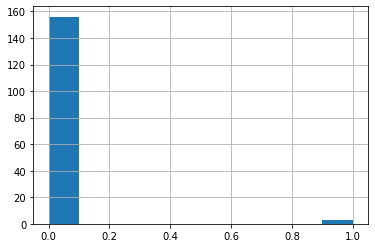

In [178]:
df_order['Preds'].hist()

In [179]:
df_llnl = pd.read_csv('/home/xvg/cpds_llnl.csv')

In [180]:
cpd_39 = 'PV-003161999098'
cpd_39_catalog = 'Z5197597843'
cpd_37 = 'PV-000465323374'
cpd_37 = 'Z4151005893' # Ed's list
cpd_37_catalog = ['Z5197597776']
cpd_42 = 'Z1646186285'
cpd_42_catalog = 'Z1646186285'
cpd_46 = 'PV-003247654624'
cpd_46_catalog = 'Z5197597797'
cpd_61 = 'PV-003985710905'
cpd_61_catalog = 'PV-003985710905'
cpd_122 = 'PV-003965461894'
cpd_122_catalog = 'Z5197596845'
cpd_25 = 'Z2832518906'
cpd_49 = 'PV-003687523072'
cpd_61 = 'PV-003197108047'
cpd_46 = 'PV-001418610652'
cpds = {'122': cpd_122, '37': cpd_37, '39': cpd_39, '46': cpd_46, '42': cpd_42, '49': cpd_49, '61': cpd_61, '25': cpd_25, '46': cpd_46}

In [181]:
df_llnl[df_llnl['LLNL#'].astype('str').isin(cpds.keys())][['LLNL#','Smile']].to_csv('cpds_llnl_interesting.txt',index=False)

In [182]:
df_order[df_order['ID'].isin(cpds.values())]

,ID,CatalogID,Formula,Barcode_1,MW,Purity,PO,Salt_Name,Salt_ratio,MW_salt,...,Stereochem.data,Geometric.isomer,Smile,Name,index,CXSMILES,Preds,Prob_0,Prob_1,cno
2,Z2832518906,Z2832518906,C15H16FN5,1215699848,285.319,100,NaN,NaN,NaN,0,...,Achiral,None,CCC1=NC=CN1CC2=CN(N=N2)C=3C=CC(F)=C(C)C3,4-[(2-ethyl-1H-imidazol-1-yl)methyl]-1-(4-fluo...,112,CCc1nccn1Cc2cn(nn2)c3ccc(F)c(C)c3,0,0.992810,0.007190,3
3,Z4151005893,Z4151005893,C15H16FN5O,1215699849,301.318,100,NaN,NaN,NaN,0,...,Achiral,None,CCC1=NC=CN1CC2=CN(N=N2)C=3C=CC(F)=C(CO)C3,"(5-{4-[(2-ethyl-1H-imidazol-1-yl)methyl]-1H-1,...",81,CCc1nccn1Cc2cn(nn2)c3ccc(F)c(CO)c3,0,0.995791,0.004209,4
4,PV-003687523072,Z5197597811,C14H13ClFN5,1215699851,305.737,100,NaN,NaN,NaN,0,...,Achiral,None,CCC1=NC=CN1CC2=CN(N=N2)C=3C=C(F)C=C(Cl)C3,1-(3-chloro-5-fluorophenyl)-4-[(2-ethyl-1H-imi...,4,CCc1nccn1Cc2cn(nn2)c3cc(F)cc(Cl)c3,0,0.980981,0.019019,5
5,PV-003197108047,Z5197597800,C14H13ClFN5,1215699852,305.737,100,NaN,NaN,NaN,0,...,Achiral,None,CCC1=NC=CN1CC2=CN(N=N2)C=3C=CC(Cl)=C(F)C3,1-(4-chloro-3-fluorophenyl)-4-[(2-ethyl-1H-imi...,44,CCc1nccn1Cc2cn(nn2)c3ccc(Cl)c(F)c3,0,0.978375,0.021625,6
17,PV-003161999098,Z5197597843,C14H13BrFN5,1215699865,350.188,99,NaN,NaN,NaN,0,...,Achiral,None,CCC1=NC=CN1CC2=CN(N=N2)C=3C=CC(F)=C(Br)C3,1-(3-bromo-4-fluorophenyl)-4-[(2-ethyl-1H-imid...,67,CCc1nccn1Cc2cn(nn2)c3ccc(F)c(Br)c3,0,0.942747,0.057253,18
38,Z1646186285,Z1646186285,C14H13ClFN5,1215699889,305.737,100,NaN,NaN,NaN,0,...,Achiral,None,CCC1=NC=CN1CC2=CN(N=N2)C=3C=CC(F)=C(Cl)C3,1-(3-chloro-4-fluorophenyl)-4-[(2-ethyl-1H-imi...,111,CCc1nccn1Cc2cn(nn2)c3ccc(F)c(Cl)c3,0,0.983828,0.016172,39
66,PV-001418610652,Z5197597786,C15H24N4O2S,1215699921,324.441,100,NaN,NaN,NaN,0,...,Racemic or presumed racemic or meso,None,CSCCC(=O)NC1CCN(C1)C(=O)C=2C=C(NN2)C(C)C,3-(methylsulfanyl)-N-{1-[5-(propan-2-yl)-1H-py...,120,CSCCC(=O)NC1CCN(C1)C(=O)c2cc([nH]n2)C(C)C,0,0.999734,0.000266,67
121,PV-003965461894,Z5197596845,C20H22N6O,1215699505,362.428,100,NaN,NaN,NaN,0,...,Diastereomeric mixture,Unknown,CC1=NC=CN1CC2=CN(N=N2)C=3C=CC=C(C3)C(=O)N4CC5C...,6-(3-{4-[(2-methyl-1H-imidazol-1-yl)methyl]-1H...,114,Cc1nccn1Cc2cn(nn2)c3cccc(c3)C(=O)N4CC5CCCC54,0,0.804937,0.195063,122


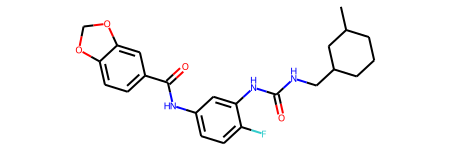

In [183]:
from rdkit import Chem
Chem.MolFromSmiles(df_order.sort_values(by='Prob_1',ascending=False).iloc[0]['Smile'])

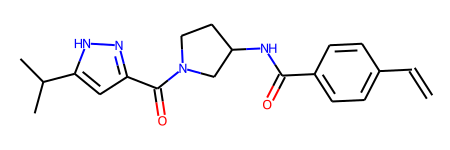

In [184]:
Chem.MolFromSmiles(df_order.iloc[37]['Smile'])

In [185]:
df_order[df_order['Preds']==1]

,ID,CatalogID,Formula,Barcode_1,MW,Purity,PO,Salt_Name,Salt_ratio,MW_salt,...,Stereochem.data,Geometric.isomer,Smile,Name,index,CXSMILES,Preds,Prob_0,Prob_1,cno
84,Z1276053077,Z1276053077,C22H25F2NO2,1215699463,373.436,100,NaN,NaN,NaN,0,...,Racemic or presumed racemic or meso,None,COC=1C=CC=C(C1)C2(CCCC2)C(=O)NCC(C)C=3C=CC(F)=...,"N-[2-(3,4-difluorophenyl)propyl]-1-(3-methoxyp...",47,COc1cccc(c1)C2(CCCC2)C(=O)NCC(C)c3ccc(F)c(F)c3,1,0.485646,0.514354,85
88,PV-002725055409,Z5197596902,C15H13ClN2O3S,1215699468,336.793,99,NaN,NaN,NaN,0,...,Achiral,None,NS(=O)(=O)C=1C=CC(=CC1)C=2C=C(Cl)C=C3C(=O)NCCC23,"4-(7-chloro-1-oxo-1,2,3,4-tetrahydroisoquinoli...",74,NS(=O)(=O)c1ccc(cc1)c2cc(Cl)cc3C(=O)NCCc23,1,0.383287,0.616713,89
96,Z813369256,Z813369256,C23H26FN3O4,1215699477,427.468,100,NaN,NaN,NaN,0,...,Diastereomeric mixture,Unequal mixture of geometric isomers,CC1CCCC(CNC(=O)NC=2C=C(NC(=O)C=3C=CC=4OCOC4C3)...,N-[4-fluoro-3-({[(3-methylcyclohexyl)methyl]ca...,110,CC1CCCC(CNC(=O)Nc2cc(NC(=O)c3ccc4OCOc4c3)ccc2F)C1,1,0.258791,0.741209,97


In [186]:
from rdkit.Chem.Crippen import MolLogP
from rdkit import Chem
df_order['logp'] = [MolLogP(Chem.MolFromSmiles(s)) for s in df_order.CXSMILES]

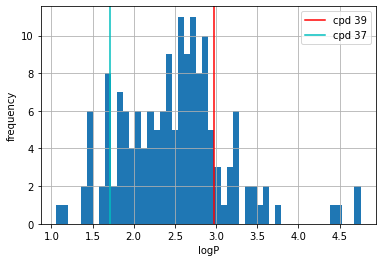

In [187]:
ax = df_order['logp'].hist(bins=50)
ax.axvline(df_order[df_order.ID==cpd_39].iloc[0]['logp'],color='r',label='cpd 39')
ax.axvline(df_order[df_order.ID==cpd_37].iloc[0]['logp'],color='c',label='cpd 37')
ax.legend()
ax.set_xlabel('logP')
ax.set_ylabel('frequency')
ax.get_figure().savefig('logP.png')

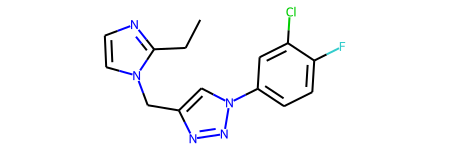

In [188]:
from rdkit.Chem import Draw
m = Chem.MolFromSmiles(df_order[df_order.ID==cpd_42].iloc[0].CXSMILES)
Draw.MolToFile(m,'cpd_42.png')
with Chem.SDWriter('/home/xvg/cpd_42.sdf') as writer:
    writer.write(m)
Chem.Draw.MolToFile(m,'cpd_{}.png'.format(cpd_42))
m

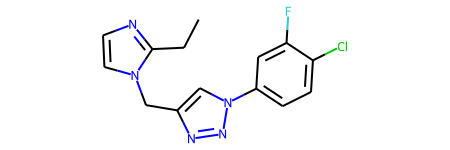

In [189]:
from rdkit.Chem import Draw
m = Chem.MolFromSmiles(df_order[df_order.ID==cpd_61].iloc[0].CXSMILES)
Draw.MolToFile(m,'cpd_61.png')
with Chem.SDWriter('/home/xvg/cpd_61.sdf') as writer:
    writer.write(m)
Chem.Draw.MolToFile(m,'cpd_{}.png'.format(cpd_61))
m

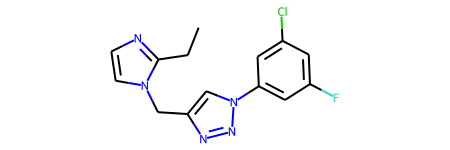

In [190]:
from rdkit.Chem import Draw
m = Chem.MolFromSmiles(df_order[df_order.ID==cpd_49].iloc[0].CXSMILES)
Draw.MolToFile(m,'cpd_49.png')
with Chem.SDWriter('/home/xvg/cpd_49.sdf') as writer:
    writer.write(m)
Chem.Draw.MolToFile(m,'cpd_{}.png'.format(cpd_49))
m

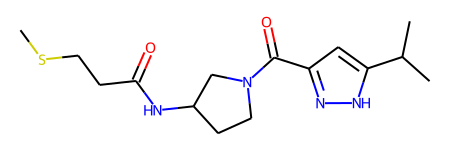

In [191]:
from rdkit.Chem import Draw
m = Chem.MolFromSmiles(df_order[df_order.ID==cpd_46].iloc[0].CXSMILES)
Draw.MolToFile(m,'cpd_46.png')
with Chem.SDWriter('/home/xvg/cpd_46.sdf') as writer:
    writer.write(m)
Chem.Draw.MolToFile(m,'cpd_{}.png'.format(cpd_46))
m

In [192]:
cpd_37

'Z4151005893'

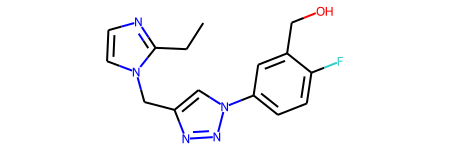

In [193]:
from rdkit.Chem import Draw
m = Chem.MolFromSmiles(df_order[df_order.ID==cpd_37].iloc[0].CXSMILES)
Draw.MolToFile(m,'cpd_37.png')
with Chem.SDWriter('/home/xvg/cpd_37.sdf') as writer:
    writer.write(m)
Chem.Draw.MolToFile(m,'cpd_{}.png'.format(cpd_37))
m

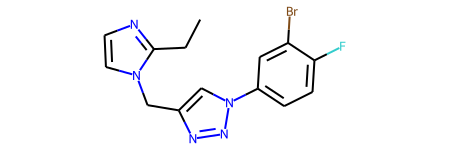

In [194]:
from rdkit.Chem import Draw
m = Chem.MolFromSmiles(df_order[df_order.ID==cpd_39].iloc[0].CXSMILES)
Draw.MolToFile(m,'cpd_39.png')
with Chem.SDWriter('/home/xvg/cpd_39.sdf') as writer:
    writer.write(m)
Chem.Draw.MolToFile(m,'cpd_{}.png'.format(cpd_39))
m

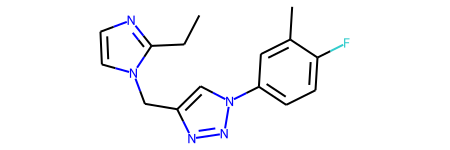

In [195]:
from rdkit.Chem import Draw
m = Chem.MolFromSmiles(df_order[df_order.ID==cpd_25].iloc[0].CXSMILES)
Draw.MolToFile(m,'cpd_25.png')
with Chem.SDWriter('/home/xvg/cpd_25.sdf') as writer:
    writer.write(m)
Chem.Draw.MolToFile(m,'cpd_{}.png'.format(cpd_25))
m

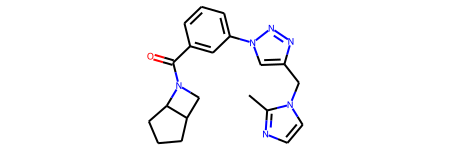

In [196]:
from rdkit.Chem import Draw
m = Chem.MolFromSmiles(df_order[df_order.ID==cpd_122].iloc[0].CXSMILES)
Draw.MolToFile(m,'cpd_122.png')
with Chem.SDWriter('/home/xvg/cpd_122.sdf') as writer:
    writer.write(m)
m

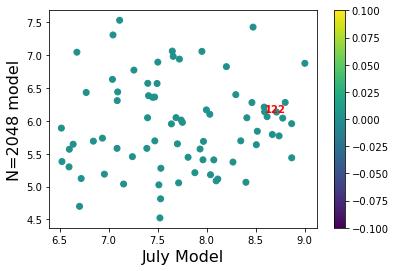

In [197]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
df_select = df_uniform[df_uniform['idnumber'].isin(df_order['ID'])]
x = df_select['mean']
y = df_select['affinity_mean']
z = df_select['affinity_var']
p = ax.scatter(x,y,c=z,label='top')

for no,cpd in cpds.items():
    try:
        x = df_select[df_select['idnumber']==cpd].iloc[0]['mean']
        y = df_select[df_select['idnumber']==cpd].iloc[0]['affinity_mean']
        ax.text(x+0.005,y,no,color='r',weight='bold')
    except:
        pass
        
fig.colorbar(p)
ax.set_xlabel('July Model',fontsize=16)
ax.set_ylabel('N=2048 model',fontsize=16)
fig.savefig('sparse_attention_vs_regex_uniform.png',dpi=300)

**Mpro inhibitors predicted by sparse attention model, top inhibs**

In [198]:
df_top = pd.read_csv('/home/xvg/mpro_candidates_top.csv')

In [199]:
df_top['mean'].min()

9.31749915185645

In [200]:
#df_order = pd.read_csv('/home/xvg/order_enamine_z178890-108-1398601.csv')

In [201]:
#df_order = pd.read_csv('/home/xvg/ORNL_August31.csv')

In [202]:
top_dataset = InhibDataset(df_top,seq=mpro_seq_5r84)

In [203]:
for i,model in enumerate(tqdm.auto.tqdm(models)):
    y_pred=model(top_dataset)
    df_top[f'affinity_{i}'] = [scale(r['affinity'][0,0]) for r in y_pred]
df_top['affinity_mean'] = np.mean([df_top[f'affinity_{i}'] for i in range(len(models))],axis=0)
df_top['affinity_var'] = np.var([df_top[f'affinity_{i}'] for i in range(len(models))],axis=0)

  0%|          | 0/1 [00:00<?, ?it/s]

/home/xvg/miniconda3/envs/affinity/lib/python3.8/site-packages/transformers/pipelines/base.py:979: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(


37 mean = 4.151761153100391 var = 0.0
39 mean = 4.260785153266816 var = 0.0
46 mean = 5.213204998729418 var = 0.0
42 mean = 4.068134429504791 var = 0.0
49 mean = 4.255242507376744 var = 0.0
61 mean = 4.419957556623006 var = 0.0
25 mean = 3.9880738135787968 var = 0.0


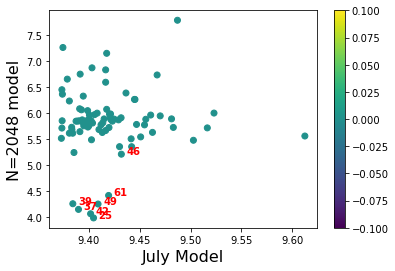

In [204]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
df_select = df_top[df_top['idnumber'].isin(df_order['ID'])]

x = df_select['mean']
y = df_select['affinity_mean']
z = df_select['affinity_var']
p = ax.scatter(x,y,c=z,label='top')

for no,cpd in cpds.items():
    try:
        x = df_select[df_select['idnumber']==cpd].iloc[0]['mean']
        y = df_select[df_select['idnumber']==cpd].iloc[0]['affinity_mean']
        ax.text(x+0.005,y,no,weight='bold',color='r')
        print('{} mean = {} var = {}'.format(no,y,df_select[df_select['idnumber']==cpd].iloc[0]['affinity_var']))
    except:
        pass
fig.colorbar(p)
ax.set_xlabel('July Model',fontsize=16)
ax.set_ylabel('N=2048 model',fontsize=16)
fig.savefig('sparse_attention_vs_regex_top.png',dpi=300)

In [205]:
df_select.sort_values(by='affinity_mean',ascending=False)['affinity_mean']

7     7.787896
95    7.264199
42    7.152417
58    6.873203
46    6.834182
        ...   
85    4.260785
52    4.255243
80    4.151761
61    4.068134
55    3.988074
Name: affinity_mean, Length: 83, dtype: float64

In [206]:
df_merge = df_llnl.merge(df_top,left_on='ID',right_on='idnumber')
#df_merge.sort_values(by='affinity_mean',ascending=False).iloc[0]
df_merge.sort_values(by='affinity_mean',ascending=False)[['LLNL#','affinity_mean','affinity_var']].head(10)
#df_merge.sort_values(by='affinity_var',ascending=True)[['cno','affinity_var','affinity_mean']]

,LLNL#,affinity_mean,affinity_var
71,72,7.787896,0.0
67,68,7.264199,0.0
0,1,7.152417,0.0
28,29,6.873203,0.0
70,71,6.834182,0.0
3,4,6.752096,0.0
14,15,6.736046,0.0
57,58,6.656194,0.0
65,66,6.596207,0.0
12,13,6.452426,0.0


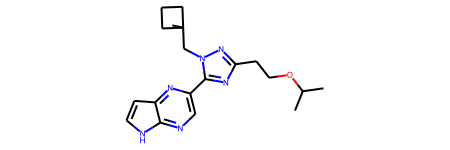

In [207]:
smi = df_select.sort_values(by='affinity_mean',ascending=False)['smiles'].iloc[0]
#smi = df_select.sort_values(by='affinity_var',ascending=True)['smiles'].iloc[0]

mol = Chem.MolFromSmiles(smi)
mol

<AxesSubplot:>

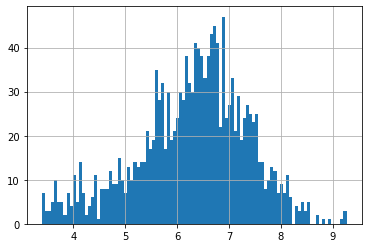

In [208]:
df['affinity_mean'].hist(bins=100)

**Kneller et al** https://pubs.acs.org/doi/abs/10.1021/acs.jmedchem.1c01475

In [312]:
df = pd.read_csv('/home/xvg/jm1c01475_si_002.csv')

In [313]:
def to_png(name_smi):
    name, smi = name_smi
    from rdkit import Chem
    from rdkit.Chem import Draw

    m = Chem.MolFromSmiles(smi)
    Draw.MolToFile(m,'{}.png'.format(name))

In [314]:
df[['Compound_ID','SMILES']].apply(to_png, axis=1)

0     None
1     None
2     None
3     None
4     None
5     None
6     None
7     None
8     None
9     None
10    None
11    None
12    None
13    None
14    None
15    None
16    None
17    None
18    None
19    None
dtype: object

In [315]:
kneller_dataset = InhibDataset(df, seq=mpro_seq_uniprot, smiles_name='SMILES')

In [316]:
def make_numeric(ic50): 
    try:
        return float(ic50.replace('<','').replace('>','').split('-')[-1].split('~')[-1])
    except Exception as e:
        return np.nan

In [317]:
df['pIC50'] = 6-np.log(df['IC50, microM'].apply(make_numeric).astype('float32'))/np.log(10)

In [318]:
for i,model in enumerate(tqdm.auto.tqdm(models)):
    y_pred=model(kneller_dataset)
    df[f'affinity_{i}'] = [scale(r['affinity'][0,0]) for r in y_pred]
df['affinity_mean'] = np.mean([df[f'affinity_{i}'] for i in range(len(models))],axis=0)
df['affinity_var'] = np.var([df[f'affinity_{i}'] for i in range(len(models))],axis=0)

  0%|          | 0/1 [00:00<?, ?it/s]

In [319]:
from scipy.stats import spearmanr
x = df['pIC50']
y = df['affinity_mean']
spearmanr(x,y)

SpearmanrResult(correlation=0.12240536794934682, pvalue=0.6071778227492755)

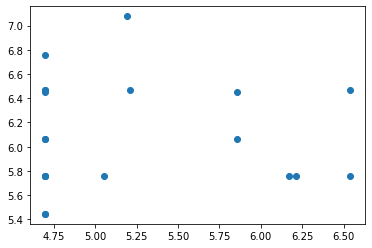

In [320]:
import matplotlib.pyplot as plt
fig,ax = plt.subplots()
x = df['pIC50']
y = df['affinity_mean']
ax.scatter(x,y)

**KRAS G12V**

In [321]:
kras_wildtype_seq = 'MTEYKLVVVGAGGVGKSALTIQLIQNHFVDEYDPTIEDSYRKQVVIDGETCLLDILDTAGQEEYSAMRDQYMRTGEGFLCVFAINNTKSFEDIHHYREQIKRVKDSEDVPMVLVGNKCDLPSRTVDTKQAQDLARSYGIPFIETSAKTRQRVEDAFYTLVREIRQYRLKKISKEEKTPGCVKIKKCIIM'
kras_g12v_seq = 'MTEYKLVVVGAVGVGKSALTIQLIQNHFVDEYDPTIEDSYRKQVVIDGETCLLDILDTAGQEEYSAMRDQYMRTGEGFLCVFAINNTKSFEDIHHYREQIKRVKDSEDVPMVLVGNKCDLPSRTVDTKQAQDLARSYGIPFIETSAKTRQRVEDAFYTLVREIRQYRLKKISKEEKTPGCVKIKKCIIM'
kras_g12d_seq = 'MTEYKLVVVGADGVGKSALTIQLIQNHFVDEYDPTIEDSYRKQVVIDGETCLLDILDTAGQEEYSAMRDQYMRTGEGFLCVFAINNTKSFEDIHHYREQIKRVKDSEDVPMVLVGNKCDLPSRTVDTKQAQDLARSYGIPFIETSAKTRQRVEDAFYTLVREIRQYRLKKISKEEKTPGCVKIKKCIIM'

In [336]:
kras_g12d_seq = 'MTEYKLVVVGADGVGKSALTIQLIQNHFVDEYDPTIEDSYRKQVVIDGETCLLDILDTAGQEEYSAMRDQYMRTGEGFLCVFAINNTKSFEDIHHYREQIKRVKDSEDVPMVLVGNKCDLPSRTVDTKQAQDLARSYGIPFIETSAKTRQRVEDAFYTLVREIRQYRLK'
kras_wildtype_seq_short = 'MTEYKLVVVGAGGVGKSALTIQLIQNHFVDEYDPTIEDSYRKQVVIDGETCLLDILDTAGQEEYSAMRDQYMRTGEGFLCVFAINNTKSFEDIHHYREQIKRVKDSEDVPMVLVGNKCDLPSRTVDTKQAQDLARSYGIPFIETSAKTRQRVEDAFYTLVREIRQYRLK'


In [323]:
len(kras_g12d_seq)

169

In [324]:
smiles = ['CC(C)NCC(COC1=CC=CC2=C1NC=C2)O',
          'C1CNC(CC1NC(=O)C2=CNC3=C2C=C(C=C3)Br)CC4=CC=C(C=C4)Cl',
          'ClC4=CC=C(C[C@@H]3N(CC[C@@H](N(CC1=C[N](C2=C1C=CC=C2)[H])[H])C3)[H])C=C4',
          'O=C(N([H])[C@@H]1CCN(C1)CC2=CC=C(N=C2)O)C3=C[N](C4=C3C=C(C=C4)Cl)[H]',
          'CC1=C(C2=C(N1)C=C(C=C2Cl)Cl)CCN',
          'C1CC(NC1)C(=O)NC2=CC3=C(C=C2)N=C(N3)CC4=CNC5=CC=CC=C54']
names = ['Cpd1','Cpd2','Cpd3','Cpd4','Cpd5','Cpd6']
df = pd.DataFrame({'cpd': names, 'smiles': smiles})

In [325]:
df = pd.read_csv('/home/xvg/G12V_cpd_list.csv')
df = df[~df['SMILES'].isnull()]

In [326]:
df['smiles_can'] = df['SMILES'].apply(lambda smi: Chem.MolToSmiles(Chem.MolFromSmiles(smi)))

In [337]:
kras_wildtype_dataset = InhibDataset(df,seq=kras_wildtype_seq,smiles_name='SMILES')
kras_g12v_dataset = InhibDataset(df,seq=kras_g12v_seq,smiles_name='SMILES')
kras_g12d_dataset = InhibDataset(df,seq=kras_g12d_seq,smiles_name='SMILES')

In [333]:
for i,model in enumerate(models):
    y_pred=model(kras_wildtype_dataset)
    df[f'affinity_wt_{i}'] = [scale(r['affinity'][0,0]) for r in y_pred]
df['affinity_wt_mean'] = np.mean([df[f'affinity_wt_{i}'] for i in range(len(models))],axis=0)
df['affinity_wt_var'] = np.var([df[f'affinity_wt_{i}'] for i in range(len(models))],axis=0)

In [334]:
for i,model in enumerate(models):
    y_pred=model(kras_g12v_dataset)
    df[f'affinity_g12v_{i}'] = [scale(r['affinity'][0,0]) for r in y_pred]
df['affinity_g12v_mean'] = np.mean([df[f'affinity_g12v_{i}'] for i in range(len(models))],axis=0)
df['affinity_g12v_var'] = np.var([df[f'affinity_g12v_{i}'] for i in range(len(models))],axis=0)

In [338]:
for i,model in enumerate(models):
    y_pred=model(kras_g12d_dataset)
    df[f'affinity_g12d_{i}'] = [scale(r['affinity'][0,0]) for r in y_pred]
df['affinity_g12d_mean'] = np.mean([df[f'affinity_g12d_{i}'] for i in range(len(models))],axis=0)
df['affinity_g12d_var'] = np.var([df[f'affinity_g12d_{i}'] for i in range(len(models))],axis=0)

In [339]:
df.sort_values(by='affinity_wt_mean',ascending=False)

,Unnamed: 0,Formula,SMILES,PUBCHEM_URL,Citation,Target,Name,IC50 (uM),Kd (uM),Unnamed: 9,...,smiles_can,affinity_wt_0,affinity_wt_mean,affinity_wt_var,affinity_g12v_0,affinity_g12v_mean,affinity_g12v_var,affinity_g12d_0,affinity_g12d_mean,affinity_g12d_var
2,Compound3,NaN,ClC4=CC=C(C[C@@H]3N(CC[C@@H](N(CC1=C[N](C2=C1C...,NaN,https://doi.org/10.1371/journal.pone.0174706.g003,G12V,NaN,1.2+/-0.4,2.6+/-0.8,NaN,...,Clc1ccc(C[C@H]2C[C@H](NCc3c[nH]c4ccccc34)CCN2)cc1,6.468970,6.468970,0.0,6.468970,6.468970,0.0,6.468970,6.468970,0.0
3,Compound4,NaN,O=C(N([H])[C@@H]1CCN(C1)CC2=CC=C(N=C2)O)C3=C[N...,NaN,https://doi.org/10.1371/journal.pone.0174706.g003,G12V,NaN,49+/-24,>10,NaN,...,O=C(N[C@@H]1CCN(Cc2ccc(O)nc2)C1)c1c[nH]c2ccc(C...,6.468970,6.468970,0.0,6.468970,6.468970,0.0,6.468970,6.468970,0.0
11,10,NaN,Cc1nn2c(cc(nc2c1c3ccccc3)c4ccccc4)N5CCN(CCO)CC5,https://www.dcchemicals.com/product_show-DC238...,NaN,"Noncovalent, KRASG12D and KRASG12V",inhibitor 11,NaN,1.2,NaN,...,Cc1nn2c(N3CCN(CCO)CC3)cc(-c3ccccc3)nc2c1-c1ccccc1,6.468970,6.468970,0.0,6.468970,6.468970,0.0,6.468970,6.468970,0.0
13,12,NaN,N1C2=C(C=CC(C(OC)=O)=C2)C(CN[C@H]2CCN[C@H](CC3...,NaN,10.1016/j.chembiol.2018.07.009,G12V,in vitro inhibitor C6ME,14,NaN,NaN,...,COC(=O)c1ccc2c(CN[C@H]3CCN[C@H](Cc4ccccc4)C3)c...,6.468970,6.468970,0.0,6.468970,6.468970,0.0,6.468970,6.468970,0.0
23,22,NaN,O=C1N[C@@H](c2ccccc12)c3c([nH]c4ccccc34)[C@H]5...,NaN,10.1073/pnas.1904529117,T35S GCP KRAS,comp 16,NaN,340,NaN,...,O=C1N[C@H](c2c([C@H]3CCCCN3)[nH]c3ccccc23)c2cc...,6.450845,6.450845,0.0,6.450845,6.450845,0.0,6.450845,6.450845,0.0
9,8,NaN,O=C1C2C([H])=C([H])C(=C([H])C=2[C@@]([H])(C2C3...,https://www.dcchemicals.com/product_show-BI-28...,10.1073/pnas.1904529116,GTP-KRAS G12D,"BI-2852,",0.45,0.75,NaN,...,Cn1cnc(Cn2ccc3ccc(CNCc4[nH]c5ccccc5c4[C@H]4NC(...,6.450845,6.450845,0.0,6.450845,6.450845,0.0,6.450845,6.450845,0.0
10,9,NaN,O=C(N1C(C2=CC=C(OC)C=C2C)C3=C(C=C(OC)C(OCCC4=C...,NaN,KRAS inhibitor-10 is a tetrahydroisoquinoline ...,NaN,inhibitor 10,NaN,NaN,NaN,...,CCNC(=O)N1CCc2cc(OC)c(OCCc3ccc(OC)c(N)c3)cc2C1...,6.450845,6.450845,0.0,6.450845,6.450845,0.0,6.450845,6.450845,0.0
22,21,NaN,O=C1N[C@@H](c2ccccc12)c3c([nH]c4ccccc34)C5CCCN5,NaN,10.1073/pnas.1904529117,T35S GCP KRAS,comp 15,NaN,440,NaN,...,O=C1N[C@H](c2c(C3CCCN3)[nH]c3ccccc23)c2ccccc21,6.450845,6.450845,0.0,6.450845,6.450845,0.0,6.450845,6.450845,0.0
1,Compound2,C21H21BrClN3O,C1CNC(CC1NC(=O)C2=CNC3=C2C=C(C=C3)Br)CC4=CC=C(...,https://pubchem.ncbi.nlm.nih.gov/compound/1348...,https://doi.org/10.1371/journal.pone.0174706.g003,G12V,cmpd2,0.8+/-0.7,0.8,NaN,...,O=C(NC1CCNC(Cc2ccc(Cl)cc2)C1)c1c[nH]c2ccc(Br)cc12,6.132012,6.132012,0.0,6.467531,6.467531,0.0,6.468970,6.468970,0.0
25,24,NaN,CN(C)c1[nH]c2ccccc2c1[C@H]3NC(=O)c4ccc(O)cc34,NaN,10.1073/pnas.1904529119,G12D GCP-KRAS,comp 18,33,20,NaN,...,CN(C)c1[nH]c2ccccc2c1[C@H]1NC(=O)c2ccc(O)cc21,6.063457,6.063457,0.0,6.063457,6.063457,0.0,6.063457,6.063457,0.0


In [340]:
df[['Name','affinity_g12v_mean','affinity_g12v_var','affinity_wt_mean','affinity_wt_var']]

,Name,affinity_g12v_mean,affinity_g12v_var,affinity_wt_mean,affinity_wt_var
0,NaN,5.445462,0.0,5.445462,0.0
1,cmpd2,6.467531,0.0,6.132012,0.0
2,NaN,6.468970,0.0,6.468970,0.0
3,NaN,6.468970,0.0,6.468970,0.0
4,NaN,5.445462,0.0,5.445462,0.0
5,NaN,5.445462,0.0,5.445462,0.0
8,Inhibitor 9 (0375-0604); H358 cellines,5.445462,0.0,5.445462,0.0
9,"BI-2852,",6.450845,0.0,6.450845,0.0
10,inhibitor 10,6.450845,0.0,6.450845,0.0
11,inhibitor 11,6.468970,0.0,6.468970,0.0


In [341]:
smiles_mrtx849 = 'CN1CCCC1COC2=NC3=C(CCN(C3)C4=CC=CC5=C4C(=CC=C5)Cl)C(=N2)N6CCN(C(C6)CC#N)C(=O)C(=C)F'
smiles_mrtx849 = Chem.MolToSmiles(Chem.MolFromSmiles(smiles_mrtx849))
smiles_amg510 = 'CC1CN(CCN1C2=NC(=O)N(C3=NC(=C(C=C32)F)C4=C(C=CC=C4F)O)C5=C(C=CN=C5C(C)C)C)C(=O)C=C'
smiles_amg510 = Chem.MolToSmiles(Chem.MolFromSmiles(smiles_amg510))

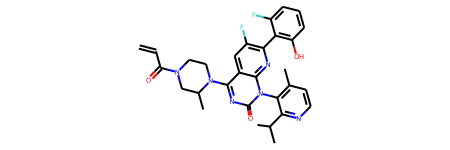

In [342]:
Chem.MolFromSmiles(smiles_amg510)

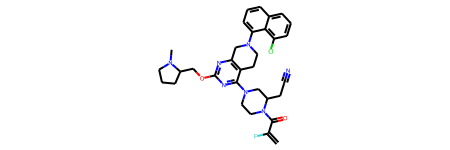

In [343]:
Chem.MolFromSmiles(smiles_mrtx849)

In [344]:
df = pd.DataFrame({'name': ['MRTX849','AMG510'],'smiles': [smiles_mrtx849,smiles_amg510]})

In [345]:
mrtx_dataset = InhibDataset(df,seq=kras_wildtype_seq)
mrtx_dataset_g12c = InhibDataset(df,seq=kras_g12c_seq)

NameError: name 'kras_g12c_seq' is not defined

In [377]:
for i in range(len(model_files)):
    load_ensemble(i)
    y_pred=trainer.predict(mrtx_dataset)
    df[f'affinity_wt_{i}'] = scale(y_pred.predictions)
df['affinity_wt_mean'] = np.mean([df[f'affinity_wt_{i}'] for i in range(len(model_files))],axis=0)
df['affinity_wt_var'] = np.var([df[f'affinity_wt_{i}'] for i in range(len(model_files))],axis=0)

Tokenizer lower_case: False
Tokenizer lower_case: False


In [378]:
for i in range(len(model_files)):
    load_ensemble(i)
    y_pred=trainer.predict(mrtx_dataset_g12c)
    df[f'affinity_g12c_{i}'] = scale(y_pred.predictions)
df['affinity_g12c_mean'] = np.mean([df[f'affinity_g12c_{i}'] for i in range(len(model_files))],axis=0)
df['affinity_g12c_var'] = np.var([df[f'affinity_g12c_{i}'] for i in range(len(model_files))],axis=0)

Tokenizer lower_case: False
Tokenizer lower_case: False


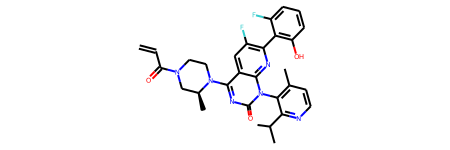

In [380]:
smiles_amg510_sotorasib = 'c1(cc(F)c(c2c(F)cccc2O)n3)c3N(c4c(C)ccnc4C(C)C)C(=O)N=C1N5[C@@H](C)CN(C(=O)C=C)CC5'
smiles_amg510_sotorasib = Chem.MolToSmiles(Chem.MolFromSmiles(smiles_amg510_sotorasib))
Chem.MolFromSmiles(smiles_amg510_sotorasib)

In [381]:
smiles_amg510_sotorasib

'C=CC(=O)N1CCN(c2nc(=O)n(-c3c(C)ccnc3C(C)C)c3nc(-c4c(O)cccc4F)c(F)cc23)[C@@H](C)C1'

In [382]:
df_all = pd.read_parquet('/home/xvg/binding_affinity/data/all_nokras.parquet')

In [441]:
df_all[df_all['seq'].str.upper()!=df_all.seq]

,seq,smiles,affinity_uM,neg_log10_affinity_M,smiles_can,affinity
23547,mgsskskpkdpsqrrcsleppdsthhggfpasqtpnktaapdthrt...,CNC(=O)c1c(SSc2c(C(=O)NC)c3ccccc3n2C)n(C)c2ccc...,6.7,5.173925,CNC(=O)c1c(SSc2c(C(=O)NC)c3ccccc3n2C)n(C)c2ccc...,-0.857520
23548,mgsskskpkdpsqrrcsleppdsthhggfpasqtpnktaapdthrt...,NC(Cc1c(SSc2[nH]c3ccccc3c2CC(N)C(=O)NCc2ccccc2...,1.5,5.823909,NC(Cc1c(SSc2[nH]c3ccccc3c2CC(N)C(=O)NCc2ccccc2...,-0.441240
23549,mgsskskpkdpsqrrcsleppdsthhggfpasqtpnktaapdthrt...,Cn1c([Se][Se]c2c(C(=O)OC(C)(C)C)c3ccccc3n2C)c(...,1.5,5.823909,Cn1c([Se][Se]c2c(C(=O)OC(C)(C)C)c3ccccc3n2C)c(...,-0.441240
23550,mgsskskpkdpsqrrcsleppdsthhggfpasqtpnktaapdthrt...,Cn1c([Se][Se]c2c(C(O)=O)c3ccccc3n2C)c(C(O)=O)c...,2.4,5.619789,Cn1c([Se][Se]c2c(C(=O)O)c3ccccc3n2C)c(C(=O)O)c...,-0.571968
23551,mgsskskpkdpsqrrcsleppdsthhggfpasqtpnktaapdthrt...,CNC(=O)c1c([Se][Se]c2c(C(=O)NC)c3ccccc3n2C)n(C...,0.4,6.397940,CNC(=O)c1c([Se][Se]c2c(C(=O)NC)c3ccccc3n2C)n(C...,-0.073604
...,...,...,...,...,...,...
1908700,mlngenvdsrimgkvatrasskgvkstlgtrgalenisnvarnnlq...,COCCNc1nc(nc2n(cnc12)C(C)C)-c1ccc(NC(=O)OC)cc1,4.4,5.356547,COCCNc1nc(-c2ccc(NC(=O)OC)cc2)nc2c1ncn2C(C)C,-0.740560
1908701,mlngenvdsrimgkvatrasskgvkstlgtrgalenisnvarnnlq...,COCCNc1nc(nc2n(cnc12)C(C)C)-c1ccc(s1)C(C)=O,3.2,5.494850,COCCNc1nc(-c2ccc(C(C)=O)s2)nc2c1ncn2C(C)C,-0.651985
1908702,mlngenvdsrimgkvatrasskgvkstlgtrgalenisnvarnnlq...,COCCNc1nc(nc2n(cnc12)C(C)C)-c1ccc(s1)C#N,2.3,5.638272,COCCNc1nc(-c2ccc(C#N)s2)nc2c1ncn2C(C)C,-0.560131
1908703,mlngenvdsrimgkvatrasskgvkstlgtrgalenisnvarnnlq...,COc1ccc(CNc2nc(nc3n(cnc23)C(C)C)-c2ccc(C=O)cc2...,1.5,5.823909,COc1ccc(CNc2nc(-c3ccc(C=O)cc3)nc3c2ncn3C(C)C)cc1,-0.441240


<AxesSubplot:>

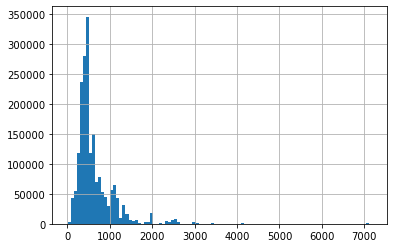

In [104]:
df_all['seq'].str.len().hist(bins=100)

**Satorasib series**

In [349]:
df = pd.read_csv('/home/xvg/jm9b01180_si_002.csv',encoding_errors='ignore')
df['smiles_can'] = df['SMILES'].apply(lambda smi: Chem.MolToSmiles(Chem.MolFromSmiles(smi)))

In [350]:
# 169 residues
kras_wildtype_seq = 'MTEYKLVVVGAGGVGKSALTIQLIQNHFVDEYDPTIEDSYRKQVVIDGETCLLDILDTAGQEEYSAMRDQYMRTGEGFLCVFAINNTKSFEDIHHYREQIKRVKDSEDVPMVLVGNKCDLPSRTVDTKQAQDLARSYGIPFIETSAKTRQRVEDAFYTLVREIRQYRLK'
# 189 residues
kras_wildtype_seq = 'MTEYKLVVVGAGGVGKSALTIQLIQNHFVDEYDPTIEDSYRKQVVIDGETCLLDILDTAGQEEYSAMRDQYMRTGEGFLCVFAINNTKSFEDIHHYREQIKRVKDSEDVPMVLVGNKCDLPSRTVDTKQAQDLARSYGIPFIETSAKTRQRVEDAFYTLVREIRQYRLKKISKEEKTPGCVKIKKCIIM'

kras_g12c_seq = kras_wildtype_seq[:11]+"C"+kras_wildtype_seq[12:]
kras_g12d_seq = kras_wildtype_seq[:11]+"D"+kras_wildtype_seq[12:]
kras_g12v_seq = kras_wildtype_seq[:11]+"V"+kras_wildtype_seq[12:]

kras_wildtype_dataset_sotorasib = InhibDataset(df,seq=kras_wildtype_seq,smiles_name='SMILES')
kras_g12c_dataset_sotorasib = InhibDataset(df,seq=kras_g12c_seq,smiles_name='SMILES')
kras_g12d_dataset_sotorasib = InhibDataset(df,seq=kras_g12d_seq,smiles_name='SMILES')
kras_g12v_dataset_sotorasib = InhibDataset(df,seq=kras_g12v_seq,smiles_name='SMILES')

In [354]:
for i,model in tqdm.auto.tqdm(enumerate(models)):
    y_pred=model(kras_wildtype_dataset_sotorasib)
    df[f'affinity_wt_{i}'] = [scale(r['affinity'][0,0]) for r in y_pred]
df['affinity_wt_mean'] = np.mean([df[f'affinity_wt_{i}'] for i in range(len(models))],axis=0)
df['affinity_wt_var'] = np.var([df[f'affinity_wt_{i}'] for i in range(len(models))],axis=0)

0it [00:00, ?it/s]

In [360]:
for i,model in tqdm.auto.tqdm(enumerate(models)):
    y_pred=model(kras_g12c_dataset_sotorasib)
    df[f'affinity_g12c_{i}'] = [scale(r['affinity'][0,0]) for r in y_pred]
df['affinity_g12c_mean'] = np.mean([df[f'affinity_g12c_{i}'] for i in range(len(models))],axis=0)
df['affinity_g12c_var'] = np.var([df[f'affinity_g12c_{i}'] for i in range(len(models))],axis=0)

0it [00:00, ?it/s]

In [361]:
for i,model in tqdm.auto.tqdm(enumerate(models)):
    y_pred=model(kras_g12v_dataset_sotorasib)
    df[f'affinity_g12v_{i}'] = [scale(r['affinity'][0,0]) for r in y_pred]
df['affinity_g12v_mean'] = np.mean([df[f'affinity_g12v_{i}'] for i in range(len(models))],axis=0)
df['affinity_g12v_var'] = np.var([df[f'affinity_g12v_{i}'] for i in range(len(models))],axis=0)

0it [00:00, ?it/s]

In [362]:
for i,model in tqdm.auto.tqdm(enumerate(models)):
    y_pred=model(kras_g12d_dataset_sotorasib)
    df[f'affinity_g12d_{i}'] = [scale(r['affinity'][0,0]) for r in y_pred]
df['affinity_g12d_mean'] = np.mean([df[f'affinity_g12d_{i}'] for i in range(len(models))],axis=0)
df['affinity_g12d_var'] = np.var([df[f'affinity_g12d_{i}'] for i in range(len(models))],axis=0)

0it [00:00, ?it/s]

In [363]:
col_name_exchange = df.columns[2]

In [364]:
(df['affinity_g12v_mean']-df['affinity_wt_mean']).abs().max()

0.0065432261063822494

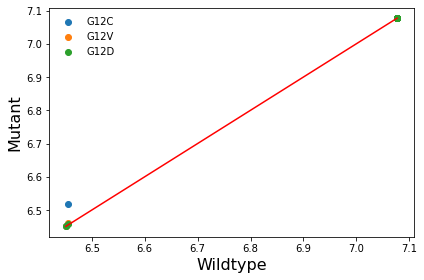

In [365]:
import matplotlib.pyplot as plt
fig,ax = plt.subplots()
x = df['affinity_wt_mean']
y = df['affinity_g12c_mean']
ax.scatter(x,y,label='G12C')


x = df['affinity_wt_mean']
y = df['affinity_g12v_mean']
ax.scatter(x,y,label='G12V')

x = df['affinity_wt_mean']
y = df['affinity_g12d_mean']
ax.scatter(x,y,label='G12D')

x = np.linspace(x.min(),x.max(),2)
y = x
ax.plot(x,y,'r')
ax.set_xlabel('Wildtype',fontsize=16)
ax.set_ylabel('Mutant',fontsize=16)
ax.legend(frameon=False)
fig.tight_layout()
#fig.savefig('kras_wt_vsg12v.png',dpi=300)

In [366]:
(df['affinity_wt_mean']-df['affinity_g12c_mean']).min()

-0.06259566390189697

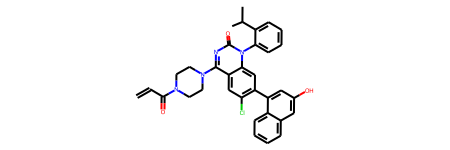

In [367]:
Chem.MolFromSmiles(df.iloc[(df['affinity_wt_mean']-df['affinity_g12c_mean']).argmin()].SMILES)

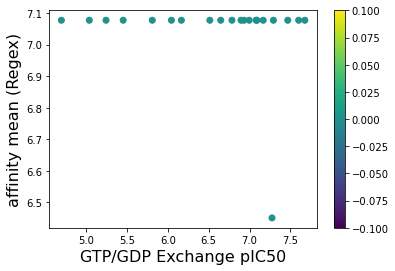

In [368]:
fig, ax = plt.subplots()
x = 6-np.log10(df[col_name_exchange])
y = df['affinity_wt_mean']
z = df['affinity_wt_var']
ax.set_xlabel('GTP/GDP Exchange pIC50',fontsize=16)
ax.set_ylabel('affinity mean (Regex)',fontsize=16)
p = ax.scatter(x,y,c=z)
fig.colorbar(p)
fig.savefig('sotorasib_series_nokras.png',dpi=300)

In [369]:
from scipy.stats import spearmanr
x = 6-np.log10(df[col_name_exchange])
y = df['affinity_wt_mean']
y = y[~x.isna()]
x = x[~x.isna()]
spearmanr(x,y)

SpearmanrResult(correlation=-0.22156468376279895, pvalue=0.33442778501073034)

**KRAS library**

In [335]:
with Chem.SDMolSupplier('/home/xvg/KRAS_15997.sdf') as suppl:
    ms = [x for x in suppl]

In [336]:
names = [m.GetProp('IDNUMBER') for m in ms]
chem_names = [m.GetProp('CHEMNAME') for m in ms]
smiles = [m.GetProp('SMILE') for m in ms]

In [337]:
df = pd.DataFrame({'name': names, 'chem_name': chem_names, 'smiles': smiles})

In [338]:
kras_wildtype_dataset_lib = InhibDataset(df,seq=kras_wildtype_seq,smiles_name='smiles')
kras_g12c_dataset_lib = InhibDataset(df,seq=kras_g12c_seq,smiles_name='smiles')
kras_g12v_dataset_lib = InhibDataset(df,seq=kras_g12v_seq,smiles_name='smiles')

In [339]:
for i in range(len(model_files)):
    load_ensemble(i)
    y_pred=trainer.predict(kras_wildtype_dataset_lib)
    df[f'affinity_wt_{i}'] = scale(y_pred.predictions)
df['affinity_wt_mean'] = np.mean([df[f'affinity_wt_{i}'] for i in range(len(model_files))],axis=0)
df['affinity_wt_var'] = np.var([df[f'affinity_wt_{i}'] for i in range(len(model_files))],axis=0)

Tokenizer lower_case: False
Tokenizer lower_case: False


In [340]:
for i in range(len(model_files)):
    load_ensemble(i)
    y_pred=trainer.predict(kras_g12v_dataset_lib)
    df[f'affinity_g12v_{i}'] = scale(y_pred.predictions)
df['affinity_g12v_mean'] = np.mean([df[f'affinity_g12v_{i}'] for i in range(len(model_files))],axis=0)
df['affinity_g12v_var'] = np.var([df[f'affinity_g12v_{i}'] for i in range(len(model_files))],axis=0)

Tokenizer lower_case: False
Tokenizer lower_case: False


In [341]:
for i in range(len(model_files)):
    load_ensemble(i)
    y_pred=trainer.predict(kras_g12c_dataset_lib)
    df[f'affinity_g12c_{i}'] = scale(y_pred.predictions)
df['affinity_g12c_mean'] = np.mean([df[f'affinity_g12c_{i}'] for i in range(len(model_files))],axis=0)
df['affinity_g12c_var'] = np.var([df[f'affinity_g12c_{i}'] for i in range(len(model_files))],axis=0)

Tokenizer lower_case: False
Tokenizer lower_case: False


In [408]:
#df.to_csv('/home/xvg/kras_library.csv')
df = pd.read_csv('/home/xvg/kras_library.csv')

In [409]:
df_library = df

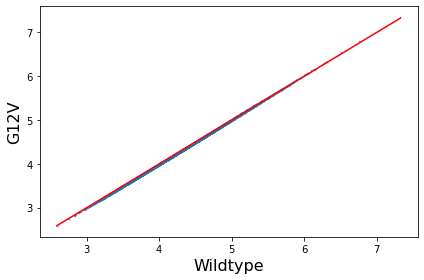

In [385]:
import matplotlib.pyplot as plt
fig,ax = plt.subplots()
x = df['affinity_wt_mean']
y = df['affinity_g12v_mean']
ax.scatter(x,y,s=0.1)
x = np.linspace(x.min(),x.max(),2)
y = x
ax.plot(x,y,'r')
ax.set_xlabel('Wildtype',fontsize=16)
ax.set_ylabel('G12V',fontsize=16)
fig.tight_layout()

In [410]:
(df['affinity_wt_mean']-df['affinity_g12c_mean']).min()

-0.12566666841405905

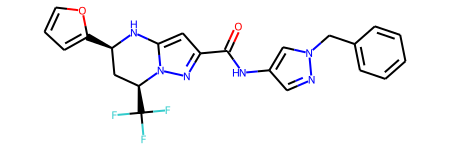

In [386]:
Chem.MolFromSmiles(df.iloc[(df['affinity_wt_mean']-df['affinity_g12c_mean']).argmin()].smiles)

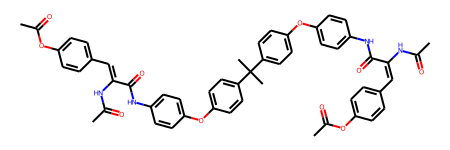

In [387]:
Chem.MolFromSmiles(df.iloc[df['affinity_g12c_mean'].argmax()].smiles)

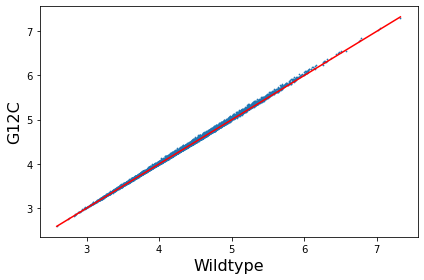

In [389]:
import matplotlib.pyplot as plt
fig,ax = plt.subplots()
x = df['affinity_wt_mean']
y = df['affinity_g12c_mean']
ax.scatter(x,y,s=0.5)
x = np.linspace(x.min(),x.max(),2)
y = x
ax.plot(x,y,'r')
ax.set_xlabel('Wildtype',fontsize=16)
ax.set_ylabel('G12C',fontsize=16)
# ax.set_xlim(6,None)
# ax.set_ylim(6,None)
fig.tight_layout()

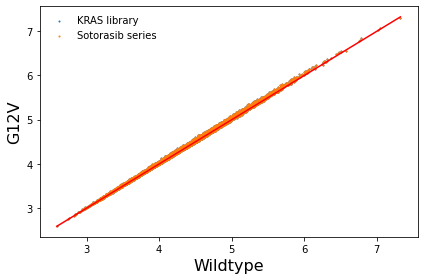

In [346]:
import matplotlib.pyplot as plt
fig,ax = plt.subplots()

df_select = df#_library[df_library['affinity_wt_mean'] > 6]
x = df_select['affinity_wt_mean']
y = df_select['affinity_g12c_mean']
ax.scatter(x,y,label='KRAS library',s=1)

x = np.linspace(x.min(),x.max(),2)
y = x
ax.plot(x,y,'r')

x = df['affinity_wt_mean']
y = df['affinity_g12c_mean']
ax.scatter(x,y,label='Sotorasib series',s=1)

ax.legend(frameon=False)
ax.set_xlabel('Wildtype',fontsize=16)
ax.set_ylabel('G12V',fontsize=16)
fig.tight_layout()

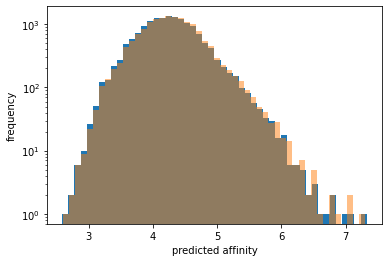

In [349]:
import matplotlib.pyplot as plt
fig,ax = plt.subplots()
x = df['affinity_wt_mean']
ax.hist(x,bins=50)
x = df['affinity_g12c_mean']
ax.hist(x,bins=50,alpha=0.5)
ax.set_yscale('log')
ax.set_xlabel('predicted affinity')
ax.set_ylabel('frequency')
ax.get_figure().savefig('/home/xvg/hist_ic50.png',dpi=300)

In [350]:
df.sort_values(by='affinity_wt_mean',ascending=False)

,Unnamed: 0,name,chem_name,smiles,affinity_wt_0,affinity_wt_mean,affinity_wt_var,affinity_g12v_0,affinity_g12v_mean,affinity_g12v_var,affinity_g12c_0,affinity_g12c_mean,affinity_g12c_var
9996,9996,8002-6009,4-[(1Z)-2-[(4-{4-[2-(4-{4-[(2E)-3-[4-(ACETYLOX...,CC(C)(c(cc1)ccc1Oc(cc1)ccc1NC(/C(/NC(C)=O)=C\c...,7.325849,7.325849,0.0,7.353957,7.353957,0.0,7.301580,7.301580,0.0
1087,1087,8010-1065,"5-[6-(5,6-DICYANO-3-PHENYLPYRAZIN-2-YL)-9-OXO-...",N#Cc1c(C#N)nc(-c(cc2)cc(-c3c4ccc(-c5nc(C#N)c(C...,7.046332,7.046332,0.0,7.060570,7.060570,0.0,7.085432,7.085432,0.0
300,300,K204-0003,"N-[(1E)-1-{N'-[(E)-[3A,5A,7-TRIHYDROXY-11A-MET...",CCc1ccc(/C=C(\C(N/N=C/C(CC[C@H](C2)O)([C@@H](C...,7.017613,7.017613,0.0,7.037972,7.037972,0.0,7.024208,7.024208,0.0
7931,7931,S952-0132,"8-[4-CYANO-3-(TRIFLUOROMETHYL)PHENYL]-N-(3,5-D...",Cc1cc(NC(N(C2)CC(CC3)(CCN3c(cc3)cc(C(F)(F)F)c3...,6.777672,6.777672,0.0,6.803624,6.803624,0.0,6.839957,6.839957,0.0
11079,11079,K781-0934,N-[2-(METHYLSULFANYL)PHENYL]-4-{6-OXO-711-DIAZ...,CSc(cccc1)c1NC(c(cc1)cc(NC(/C=C/c2ccccc2)=O)c1...,6.762759,6.762759,0.0,6.783735,6.783735,0.0,6.799824,6.799824,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
10154,10154,F327-0274,"N-CYCLOHEXYL-7,11-DIAZASPIRO[5.6]DODEC-11-EN-1...",C(CC1)CCC1NC1=NCCCNC11CCCCC1,2.833790,2.833790,0.0,2.815321,2.815321,0.0,2.839565,2.839565,0.0
10554,10554,T001-1290,N-[2-(5-METHYL-1H-INDOL-3-YL)ETHYL]ACRYLAMIDE,Cc(cc1)cc2c1[nH]cc2CCNC(C=C)=O,2.828414,2.828414,0.0,2.805738,2.805738,0.0,2.830564,2.830564,0.0
1645,1645,D443-0135,N-(2-HYDROXYETHYL)-1-BENZOXEPINE-4-CARBOXAMIDE,OCCNC(C1=Cc(cccc2)c2OC=C1)=O,2.753823,2.753823,0.0,2.733661,2.733661,0.0,2.772320,2.772320,0.0
12505,12505,Y032-1078,(E)-1-(2-METHYLPIPERIDINO)-3-PHENYL-2-PROPEN-1...,CC(CCCC1)N1C(/C=C/c1ccccc1)=O,2.742545,2.742545,0.0,2.730970,2.730970,0.0,2.745198,2.745198,0.0


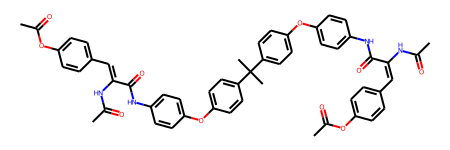

In [351]:
smi = df.sort_values(by='affinity_wt_mean',ascending=False).reset_index(drop=False).iloc[0]['smiles']
mol = Chem.MolFromSmiles(smi)
smi = Chem.MolToSmiles(mol)
mol

/home/xvg/miniconda3/envs/affinity/lib/python3.8/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


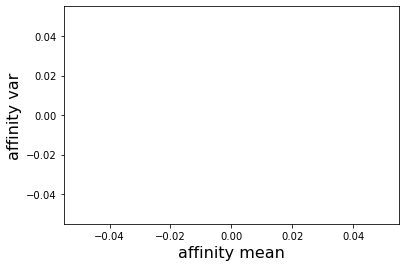

In [352]:
fig, ax = plt.subplots()
x = df['affinity_wt_mean']
y = np.log(df['affinity_wt_var'])
ax.set_xlabel('affinity mean',fontsize=16)
ax.set_ylabel('affinity var',fontsize=16)
ax.scatter(x,y,s=.1)
fig.savefig('kras_library_series.png',dpi=300)

In [353]:
df.head()

,Unnamed: 0,name,chem_name,smiles,affinity_wt_0,affinity_wt_mean,affinity_wt_var,affinity_g12v_0,affinity_g12v_mean,affinity_g12v_var,affinity_g12c_0,affinity_g12c_mean,affinity_g12c_var
0,0,T408-0175,"N5-(2,5-DIFLUOROPHENYL)-N2,N2-DIETHYL-4,5,6,7-...",CCN(CC)C(c1cc(CC(CC2)C(Nc(cc(cc3)F)c3F)=O)c2s1)=O,3.940378,3.940378,0.0,3.928727,3.928727,0.0,3.975064,3.975064,0.0
1,1,D165-0209,"4-[2-(4-TERT-BUTYLPHENYL)-1H-NAPHTHO[1,2-F][1,...",CC(C)(C)c(cc1)ccc1C1=NC(c2ccncc2)=Nc(ccc2ccccc...,5.087350,5.087350,0.0,5.101811,5.101811,0.0,5.095510,5.095510,0.0
2,2,8015-3643,"N-CYANO-4,6-BIS(PIPERIDIN-1-YL)-N-(PROP-2-EN-1...",C=CCN(c1nc(N2CCCCC2)nc(N2CCCCC2)n1)C#N,4.131747,4.131747,0.0,4.122664,4.122664,0.0,4.133771,4.133771,0.0
3,3,K832-4232,"7-(4-BROMOPHENYL)-5-(4-IODOPHENYL)-4H,5H,6H,7H...",Brc1ccc([C@H](C2)n3ncnc3N[C@H]2c(cc2)ccc2I)cc1,4.076071,4.076071,0.0,4.079904,4.079904,0.0,4.094089,4.094089,0.0
4,4,4285-1884,4-[(4Z)-4-{[5-(2-CHLORO-5-NITROPHENYL)FURAN-2-...,CC(/C(/C1=O)=C/c2ccc(-c(cc(cc3)[N+]([O-])=O)c3...,4.705652,4.705652,0.0,4.696891,4.696891,0.0,4.722431,4.722431,0.0


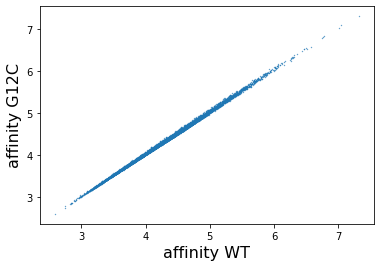

In [354]:
fig, ax = plt.subplots()
x = df['affinity_wt_mean']
y = df['affinity_g12c_mean']
ax.set_xlabel('affinity WT',fontsize=16)
ax.set_ylabel('affinity G12C',fontsize=16)
ax.scatter(x,y,s=.1)
#fig.savefig('kras_library_series.png',dpi=300)

**Pfizer Mpro**

In [65]:
# PF-07321332
smi_pf07321332 = '[H][C@]12CN([C@H](C(=O)N[C@@H](C[C@]3([H])CCNC3=O)C#N)[C@@]1([H])C2(C)C)C(=O)[C@@H](NC(=O)C(F)(F)F)C(C)(C)C'
smi_pf07304814 = 'CC(C)CC(C(=O)NC(CC1CCNC1=O)C(=O)COP(=O)(O)O)NC(=O)C2=CC3=C(N2)C=CC=C3OC'

In [66]:
Chem.MolToSmiles(Chem.MolFromSmiles(smi_pf07321332))

'CC(C)(C)[C@H](NC(=O)C(F)(F)F)C(=O)N1C[C@H]2[C@@H]([C@H]1C(=O)N[C@H](C#N)C[C@@H]1CCNC1=O)C2(C)C'

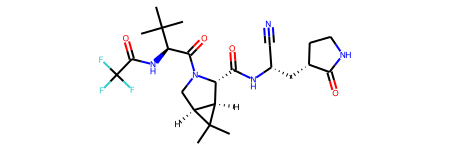

In [67]:
from rdkit import Chem
Chem.MolFromSmiles(smi_pf07321332)

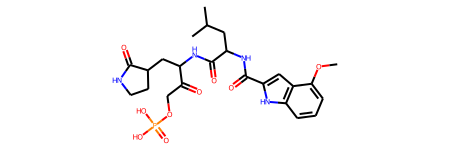

In [68]:
Chem.MolFromSmiles(smi_pf07304814)

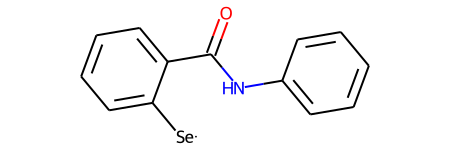

In [69]:
Chem.MolFromSmiles('NC(CS[Se]c1ccccc1C(=O)Nc1ccccc1)C(=O)O')
smi_ebselen_ringopen = '[Se]c1ccccc1C(=O)Nc1ccccc1'
#smi_ebselen_ringopen = '[c1ccccc1C(=O)Nc1ccccc1'
Chem.MolFromSmiles(smi_ebselen_ringopen)

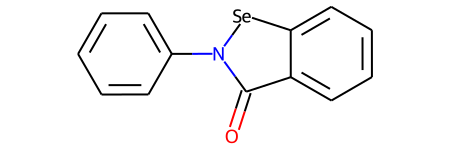

In [46]:
smi_ebselen = 'C1=CC=C(C=C1)N2C(=O)C3=CC=CC=C3[Se]2'
Chem.MolFromSmiles(smi_ebselen)

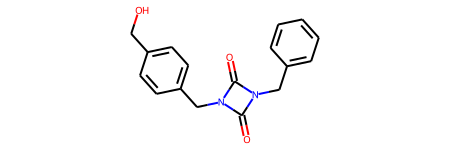

In [47]:
smi_generated = Chem.MolToSmiles(Chem.MolFromSmiles('OCC1=CC=C(C=C1)CN2C(N(C2=O)CC3=CC=CC=C3)=O'))
Chem.MolFromSmiles(smi_generated)

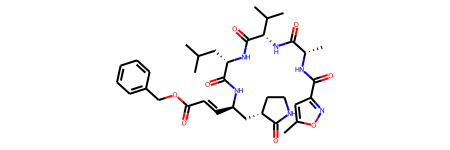

In [48]:
smi_n3 = 'CC(C[C@@H](C(N[C@H](/C=C/C(OCC1=CC=CC=C1)=O)C[C@@H]2CCNC2=O)=O)NC([C@H](C(C)C)NC([C@@H](NC(C3=NOC(C)=C3)=O)C)=O)=O)C'
Chem.MolFromSmiles(smi_n3)

In [49]:
df = pd.DataFrame({'name': ['PF-07321332','PF-07304814','Ebselen','Ebselen_ringopen','generated','n3'],
                   'smiles': [smi_pf07321332,smi_pf07304814,smi_ebselen,smi_ebselen_ringopen,smi_generated,smi_n3]})

In [50]:
pfizer_dataset = InhibDataset(df,seq=mpro_seq_uniprot, smiles_name='smiles')

In [51]:
pfizer_dataset[0]

{'protein': 'SGFRKMAFPSGKVEGCMVQVTCGTTTLNGLWLDDTVYCPRHVICTAEDMLNPNYEDLLIRKSNHSFLVQAGNVQLRVIGHSMQNCLLRLKVDTSNPKTPKYKFVRIQPGQTFSVLACYNGSPSGVYQCAMRPNHTIKGSFLNGSCGSVGFNIDYDCVSFCYMHHMELPTGVHAGTDLEGKFYGPFVDRQTAQAAGTDTTITLNVLAWLYAAVINGDRWFLNRFTTTLNDFNLVAMKYNYEPLTQDHVDILGPLSAQTGIAVLDMCAALKELLQNGMNGRTILGSTILEDEFTPFDVVRQCSGVTFQ',
 'ligand': 'CC(C)(C)[C@H](NC(=O)C(F)(F)F)C(=O)N1C[C@H]2[C@@H]([C@H]1C(=O)N[C@H](C#N)C[C@@H]1CCNC1=O)C2(C)C'}

7.040410347641103
0.2552937348402827


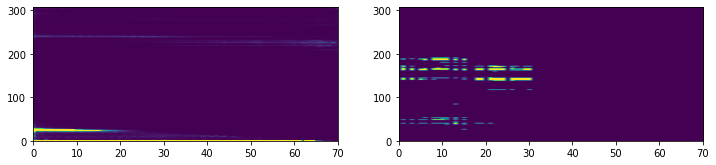

In [55]:
item = pfizer_dataset[0]

inp = item
out = models[0]([inp])[0]
contacts = out['contacts'].squeeze(0).squeeze(0)
print(scale(out['affinity'][0][0]))

import matplotlib.pyplot as plt
from scipy.special import expit
fig, axes = plt.subplots(1,2)
fig.set_size_inches(12,9)
it = models[0].tokenizer(features=inp)
nseq, nsmi = len(it['input_ids_1']), len(it['input_ids_2'])
p= axes[0].imshow(expit(contacts))
p.set_clim(0,.05)
X = np.pad(np.load('/home/xvg/contact_7s3s.npy'),(1,1))
q = axes[1].imshow(X.reshape(2048,512))

from sklearn.metrics import log_loss
print(log_loss(X.reshape(2048,512)[:nseq,:nsmi].flatten(),expit(contacts[:nseq,:nsmi].flatten())))
for ax in axes:
    ax.set_xlim(0,nsmi)
    ax.set_ylim(0,nseq)
    ax.set_aspect(.1)


In [69]:
for i,model in enumerate(tqdm.auto.tqdm(models)):
    y_pred=model.encode(pfizer_dataset)
    df[f'affinity_{i}'] = y_pred.squeeze(1)
df['affinity_mean'] = np.mean([df[f'affinity_{i}'] for i in range(len(models))],axis=0)
df['affinity_var'] = np.var([df[f'affinity_{i}'] for i in range(len(models))],axis=0)

  0%|          | 0/3 [00:00<?, ?it/s]

In [70]:
df[['name','affinity_mean','affinity_var']]

,name,affinity_mean,affinity_var
0,PF-07321332,6.357742,0.239411
1,PF-07304814,6.165491,0.068491
2,Ebselen,5.805962,0.047786
3,Ebselen_ringopen,4.410314,0.204369
4,generated,6.981710,1.485554
5,n3,4.781003,0.162346


**Ondansetron**

In [174]:
from rdkit import Chem
smi_ondansetron = Chem.MolToSmiles(Chem.MolFromSmiles('CC1=NC=CN1CC2CCC3=C(C2=O)C4=CC=CC=C4N3C'))

In [175]:
df = df_virus.copy()

In [176]:
ondansetron_dataset = ProteinDataset(df,smiles=smi_ondansetron, seq_name='seq')

In [177]:
n = len(model_files)

for i in tqdm.auto.tqdm(range(n)):
    load_ensemble(i)
    y_pred=trainer.predict(ondansetron_dataset)
    df[f'affinity_{i}'] = scale(y_pred.predictions)
df['affinity_mean'] = np.mean([df[f'affinity_{i}'] for i in range(n)],axis=0)
df['affinity_var'] = np.var([df[f'affinity_{i}'] for i in range(n)],axis=0)

  0%|          | 0/3 [00:00<?, ?it/s]

Tokenizer lower_case: False
Tokenizer lower_case: False


Tokenizer lower_case: False
Tokenizer lower_case: False


Tokenizer lower_case: False
Tokenizer lower_case: False


<BarContainer object of 38 artists>

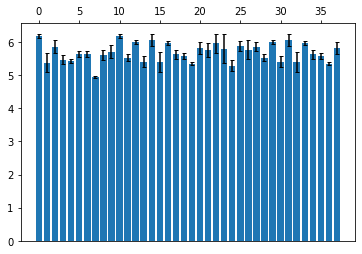

In [178]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
y = df['affinity_mean'].values
yerr = np.sqrt(df['affinity_var'].values/n)
ax.xaxis.tick_top()

ax.bar(x=np.arange(len(y)),height=y, yerr=yerr,capsize=2)

In [179]:
df['seqlen'] = df['seq'].str.len()
df.sort_values(by='affinity_mean',ascending=False).head()

,id,seq,description,affinity_0,affinity_1,affinity_2,affinity_mean,affinity_var,seqlen
0,YP_009724389.1:1-7096,MESLVPGFNEKTHVQLSLPVLQVRDVLVRGFGDSVEEVLSEARQHL...,YP_009724389.1:1-7096 ORF1ab polyprotein [orga...,6.328665,6.046002,6.167884,6.180850,0.013400,7096
10,YP_009725295.1:1-4405,MESLVPGFNEKTHVQLSLPVLQVRDVLVRGFGDSVEEVLSEARQHL...,YP_009725295.1:1-4405 ORF1a polyprotein [organ...,6.328665,6.046002,6.167884,6.180850,0.013400,4405
14,YP_009725300.1,KIVNNWLKQLIKVTLVFLFVAAIFYLITPVHVMSKHTDFSSEIIGY...,YP_009725300.1 nsp4 [polyprotein_range=YP_0097...,5.626916,6.266694,6.279111,6.057574,0.092759,500
31,YP_009742611.1,KIVNNWLKQLIKVTLVFLFVAAIFYLITPVHVMSKHTDFSSEIIGY...,YP_009742611.1 nsp4 [polyprotein_range=YP_0097...,5.626916,6.266694,6.279111,6.057574,0.092759,500
29,YP_009742609.1,AYTRYVDNNFCGPDGYPLECIKDLLARAGKASCTLSEQLDFIDTKR...,YP_009742609.1 nsp2 [polyprotein_range=YP_0097...,5.948996,5.892400,6.145204,5.995533,0.011735,638


In [56]:
df = df_virus.copy()

In [57]:
pfizer_dataset = ProteinDataset(df,smiles=smi_pf07321332, seq_name='seq')

In [58]:
n = len(model_files)

for i in tqdm.auto.tqdm(range(n)):
    load_ensemble(i)
    y_pred=trainer.predict(pfizer_dataset)
    df[f'affinity_{i}'] = scale(y_pred.predictions)
df['affinity_mean'] = np.mean([df[f'affinity_{i}'] for i in range(n)],axis=0)
df['affinity_var'] = np.var([df[f'affinity_{i}'] for i in range(n)],axis=0)

  0%|          | 0/3 [00:00<?, ?it/s]

Tokenizer lower_case: False
Tokenizer lower_case: False


Tokenizer lower_case: False
Tokenizer lower_case: False


Tokenizer lower_case: False
Tokenizer lower_case: False


<BarContainer object of 38 artists>

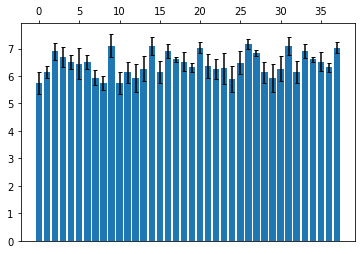

In [31]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
y = df['affinity_mean'].values
yerr = np.sqrt(df['affinity_var'].values/n)
idx = np.argsort(y)[::-1]
#y = y[idx]
#yerr = yerr[idx]
ax.xaxis.tick_top()

ax.bar(x=np.arange(len(y)),height=y, yerr=yerr,capsize=2)
#fig.savefig('pfizer_pf07321332_no_sentencepair.png',dpi=300)

In [72]:
from scipy.stats import spearmanr, pearsonr

nbootstrap = 10000
samplesize = len(df)

ps = []
for i in range(nbootstrap):
    df_sample = df#.sample(n=samplesize,replace=True)
    samples = np.random.normal(df_sample['affinity_mean'],np.sqrt(df_sample['affinity_var']))
#    samples = np.stack([df_sample['affinity_0'],df_sample['affinity_1'],df_sample['affinity_2']]).T
#    samples = np.array([s[np.random.randint(0,3)] for s in samples])
    samples = np.exp(samples)/np.sum(np.exp(samples))
    ps.append(samples)
df['pmean'] = np.mean(ps,axis=0)
df['perr'] = np.std(ps,axis=0)/np.sqrt(len(ps))

In [73]:
df.sort_values(by='pmean',ascending=False).head(10)

,id,seq,description,affinity_0,affinity_1,affinity_2,affinity_mean,affinity_var,pmean,perr
9,YP_009725255.1:1-38,MGYINVFAFPFTIYSLLLCRMNSRNYIAQVDVVNFNLT,YP_009725255.1:1-38 ORF10 protein [organism=Se...,6.054084,7.735741,7.534363,7.108063,0.562194,0.051730,0.000395
14,YP_009725300.1,KIVNNWLKQLIKVTLVFLFVAAIFYLITPVHVMSKHTDFSSEIIGY...,YP_009725300.1 nsp4 [polyprotein_range=YP_0097...,6.301206,7.566628,7.435394,7.101076,0.322766,0.045762,0.000265
31,YP_009742611.1,KIVNNWLKQLIKVTLVFLFVAAIFYLITPVHVMSKHTDFSSEIIGY...,YP_009742611.1 nsp4 [polyprotein_range=YP_0097...,6.301206,7.566628,7.435394,7.101076,0.322766,0.045709,0.000265
26,YP_009725312.1,SADAQSFLNGFAV,YP_009725312.1 nsp11 [polyprotein_range=YP_009...,6.927968,7.624085,6.965312,7.172455,0.102217,0.044797,0.000149
37,YP_009742617.1,AGNATEVPANSTVLSFCAFAVDAAKAYKDYLASGGQPITNCVKMLC...,YP_009742617.1 nsp10 [polyprotein_range=YP_009...,6.613566,7.082200,7.413899,7.036555,0.107797,0.039303,0.000134
20,YP_009725306.1,AGNATEVPANSTVLSFCAFAVDAAKAYKDYLASGGQPITNCVKMLC...,YP_009725306.1 nsp10 [polyprotein_range=YP_009...,6.611950,7.080826,7.415751,7.036176,0.108679,0.039084,0.000133
2,YP_009724391.1:1-275,MDLFMRIFTIGTVTLKQGEIKDATPSDFVRATATIPIQASLPFGWL...,YP_009724391.1:1-275 ORF3a protein [organism=S...,6.306872,7.600900,6.788527,6.898766,0.285161,0.036912,0.000202
33,YP_009742613.1,SAVKRTIKGTHHWLLLTILTSLLVLVQSTQWSLFFFLYENAFLPFA...,YP_009742613.1 nsp6 [polyprotein_range=YP_0097...,6.365254,7.486619,6.883618,6.911830,0.209975,0.036450,0.000171
16,YP_009725302.1,SAVKRTIKGTHHWLLLTILTSLLVLVQSTQWSLFFFLYENAFLPFA...,YP_009725302.1 nsp6 [polyprotein_range=YP_0097...,6.365254,7.486619,6.883618,6.911830,0.209975,0.036257,0.000170
3,YP_009724392.1:1-75,MYSFVSEETGTLIVNSVLLFLAFVVFLLVTLAILTALRLCAYCCNI...,YP_009724392.1:1-75 envelope protein [organism...,5.785920,7.245536,7.058607,6.696688,0.420572,0.032496,0.000223


In [51]:
smi_39 = Chem.MolToSmiles(Chem.MolFromSmiles(df_order[df_order.ID==cpd_39].iloc[0].Smile))
smi_37 = Chem.MolToSmiles(Chem.MolFromSmiles(df_order[df_order.ID==cpd_37].iloc[0].Smile))

In [42]:
#filt =~df_virus.description.str.contains('ORF') | df_virus['description'].str.contains('range')
#filt &= (df_virus['seq'].str.len() < max_seq_length)

In [52]:
#df = df_virus[filt].copy().reset_index(drop=True)
df = df_virus.copy()

#cpd_dataset = ProteinDataset(df,smiles='O=C(CC1=CC(Cl)=CC=C1)NC1=CN=CC2=CC=CC=C12', seq_name='seq')
#cpd_dataset = ProteinDataset(df,smiles='O=C(Nc1cncc2ccc(F)cc12)[C@H]1CCOc2cc(F)c(Cl)cc21', seq_name='seq')
cpd_dataset = ProteinDataset(df,smiles=smi_39, seq_name='seq')

In [53]:
n = len(model_files)
for i in tqdm.auto.tqdm(range(n)):
    load_ensemble(i)
    y_pred=trainer.predict(cpd_dataset)
    df[f'affinity_{i}'] = scale(y_pred.predictions)
df['affinity_mean'] = np.mean([df[f'affinity_{i}'] for i in range(n)],axis=0)
df['affinity_var'] = np.var([df[f'affinity_{i}'] for i in range(n)],axis=0)

  0%|          | 0/3 [00:00<?, ?it/s]

Tokenizer lower_case: False
Tokenizer lower_case: False


Tokenizer lower_case: False
Tokenizer lower_case: False


Tokenizer lower_case: False
Tokenizer lower_case: False


In [54]:
from scipy.stats import spearmanr, pearsonr

nbootstrap = 10000
samplesize = len(df)

avg_p = np.zeros(samplesize)
for i in range(nbootstrap):
    df_sample = df#.sample(n=samplesize,replace=True)
    samples = np.random.normal(df_sample['affinity_mean'],np.sqrt(df_sample['affinity_var']))
#    samples = np.stack([df_sample['affinity_0'],df_sample['affinity_1'],df_sample['affinity_2']]).T
#    samples = np.array([s[np.random.randint(0,3)] for s in samples])
    samples = np.exp(samples)/np.sum(np.exp(samples))
    avg_p += samples/nbootstrap
df['p'] = avg_p

In [55]:
#df.sort_values(by='affinity_mean',ascending=False).head()
df['seqlen'] = df['seq'].str.len()
#df.sort_values(by='affinity_mean',ascending=False).head()
df.sort_values(by='p',ascending=False).head(6)

,id,seq,description,affinity_0,affinity_1,affinity_2,affinity_mean,affinity_var,affinity_sem,p,seqlen
14,YP_009725300.1,KIVNNWLKQLIKVTLVFLFVAAIFYLITPVHVMSKHTDFSSEIIGY...,YP_009725300.1 nsp4 [polyprotein_range=YP_0097...,9.232116,7.822734,10.662698,9.239183,1.344258,0.669392,0.046740,500
31,YP_009742611.1,KIVNNWLKQLIKVTLVFLFVAAIFYLITPVHVMSKHTDFSSEIIGY...,YP_009742611.1 nsp4 [polyprotein_range=YP_0097...,9.232116,7.822734,10.662698,9.239183,1.344258,0.669392,0.046083,500
28,YP_009742608.1,MESLVPGFNEKTHVQLSLPVLQVRDVLVRGFGDSVEEVLSEARQHL...,YP_009742608.1 leader protein [polyprotein_ran...,8.871854,8.252221,10.492340,9.205472,0.892006,0.545285,0.038274,180
11,YP_009725297.1,MESLVPGFNEKTHVQLSLPVLQVRDVLVRGFGDSVEEVLSEARQHL...,YP_009725297.1 leader protein [polyprotein_ran...,8.871854,8.252221,10.492340,9.205472,0.892006,0.545285,0.037437,180
25,YP_009725311.1,SSQAWQPGVAMPNLYKMQRMLLEKCDLQNYGDSATLPKGIMMNVAK...,YP_009725311.1 2'-O-ribose methyltransferase [...,9.143091,8.809020,10.182362,9.378158,0.341973,0.337625,0.036030,298
2,YP_009724391.1:1-275,MDLFMRIFTIGTVTLKQGEIKDATPSDFVRATATIPIQASLPFGWL...,YP_009724391.1:1-275 ORF3a protein [organism=S...,8.694555,8.097857,10.482671,9.091694,1.026750,0.585021,0.035442,275


In [610]:
df_sample.iloc[samples.argsort()]['id'].values

array(['YP_009724394.1:1-61', 'YP_009724395.1:1-121', 'YP_009742617.1',
       'YP_009725303.1', 'YP_009725298.1', 'YP_009725297.1',
       'YP_009725255.1:1-38', 'YP_009725303.1', 'YP_009742610.1',
       'YP_009724393.1:1-222', 'YP_009742617.1', 'YP_009725304.1',
       'YP_009725318.1:1-43', 'YP_009742613.1', 'YP_009725306.1',
       'YP_009742608.1', 'YP_009725310.1', 'YP_009724396.1:1-121',
       'YP_009742617.1', 'YP_009742616.1', 'YP_009724389.1:1-7096',
       'YP_009724396.1:1-121', 'YP_009725311.1', 'YP_009725255.1:1-38',
       'YP_009725311.1', 'YP_009742609.1', 'YP_009742610.1',
       'YP_009725308.1', 'YP_009725311.1', 'YP_009725304.1',
       'YP_009724392.1:1-75', 'YP_009725303.1', 'YP_009742609.1',
       'YP_009725297.1', 'YP_009742608.1', 'YP_009724395.1:1-121',
       'YP_009724391.1:1-275', 'YP_009725299.1'], dtype=object)

In [658]:
df_sample.iloc[samples.argsort()].index

Int64Index([24, 35, 34, 16, 14, 30, 16, 17,  5, 26, 35, 29,  6,  1, 22, 12, 29,
            20, 14, 35, 30, 23, 21,  3,  5, 24, 25, 35, 10, 10,  0, 17, 25, 33,
            21, 14, 29, 12],
           dtype='int64')

In [675]:
from scipy.stats import spearmanr, pearsonr

nbootstrap = 500
samplesize = len(df)

df['count'] = 0
for i in range(nbootstrap):
    df_sample = df.sample(n=samplesize,replace=True)
    samples = np.random.normal(df_sample['affinity_mean'],np.sqrt(df_sample['affinity_var']))
    df.loc[df_sample.iloc[samples.argsort()].index,'count'] += np.arange(0,len(samples))

<BarContainer object of 38 artists>

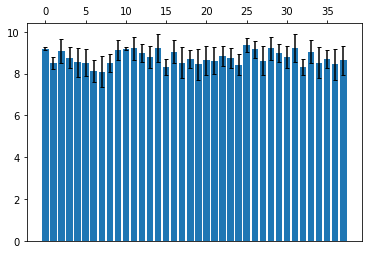

In [535]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
y = df['affinity_mean'].values
yerr = df['affinity_sem'].values
idx = np.argsort(y)[::-1]
#y = y[idx]
#yerr = yerr[idx]
ax.xaxis.tick_top()

ax.bar(x=np.arange(len(y)),height=y, yerr=yerr,capsize=2)

In [73]:
import explain
from explain import EnsembleExplainer

In [17]:
idx = df[df['CID'].str.startswith('ADA-UCB-6c2cb422-1')].index[0]
inhib_dataset = InhibDataset(df=df, smiles_name='SMILES', seq=mpro_seq_uniprot, padding='longest')

In [19]:
df.iloc[idx]

SMILES                           O=C(Cc1cccc(Cl)c1)Nc1cncc2ccccc12
CID                                             ADA-UCB-6c2cb422-1
canonical_CID                                   ADA-UCB-6c2cb422-1
r_inhibition_at_20_uM                                          NaN
r_inhibition_at_50_uM                                          NaN
r_avg_IC50                                                1.056718
f_inhibition_at_20_uM                                          NaN
f_inhibition_at_50_uM                                          NaN
f_avg_IC50                                                0.728189
f_avg_pIC50                                                    NaN
relative_solubility_at_20_uM                                   NaN
relative_solubility_at_100_uM                                  NaN
trypsin_IC50                                                  99.0
NMR_std_ratio                                                  NaN
acrylamide                                                   F

In [75]:
trainer.model.eval()
explainer = EnsembleExplainer(trainer.model)

In [76]:
loader = torch.utils.data.DataLoader([inhib_dataset[idx]],batch_size=1)

In [77]:
item = next(iter(loader))

device = torch.device("cuda:0")                
input_ids_1 = item['input_ids_1'].to(device)
input_ids_2 = item['input_ids_2'].to(device)
attention_mask_1 = item['attention_mask_1'].to(device)
attention_mask_2 = item['attention_mask_2'].to(device)

In [78]:
%%time 
n = len(model_files)
all_interactions = []
for i in tqdm.auto.tqdm(range(n)):
    load_ensemble(i)
    
    with torch.autocast('cuda'):
        interactions = explainer(
            input_ids_1=input_ids_1,
            input_ids_2=input_ids_2,
            attention_mask_1=attention_mask_1,
            attention_mask_2=attention_mask_2,
            output_indices=0,
            num_samples=2,
            use_expectation=False,
            return_attributions=False,
            batch_size=1, # > 1 gives weird results
        )
    all_interactions.append(interactions)

  0%|          | 0/3 [00:00<?, ?it/s]

Tokenizer lower_case: False
Tokenizer lower_case: False
Tokenizer lower_case: False
Tokenizer lower_case: False
Tokenizer lower_case: False
Tokenizer lower_case: False
CPU times: user 11min 26s, sys: 13.4 s, total: 11min 39s
Wall time: 6min 8s


In [79]:
interactions = np.mean(all_interactions,axis=0)

In [80]:
import pickle
with open('interactions.p','wb') as f:
    pickle.dump(interactions,f)

In [283]:
import pickle
with open('interactions.p','rb') as f:
    interactions = pickle.load(f)

In [81]:
%matplotlib inline

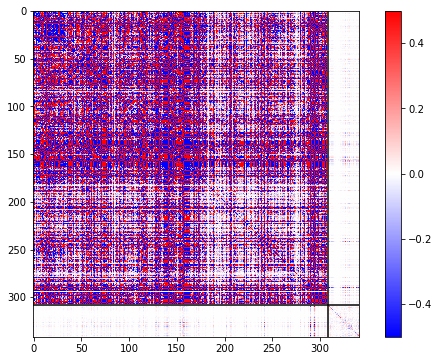

In [86]:
import matplotlib.pyplot as plt

X = interactions[0] #> 0.03
fig, ax = plt.subplots()
fig.set_size_inches(9,6)

seq_len = len(input_ids_1[0])
ax.axhline(seq_len,color='k')
ax.axvline(seq_len,color='k')

p = ax.imshow(X,interpolation='none',cmap='bwr')
p.set_clim(-.5,.5)
fig.colorbar(p)
fig.savefig('interactions_ada_ucb_dense.png',dpi=300)

In [99]:
%%time 
interactions_ligand = []

with torch.autocast('cuda'):
    for i in tqdm.auto.tqdm(range(len(input_ids_2[0]))):
        interactions = explainer(
            input_ids_1=input_ids_1,
            input_ids_2=input_ids_2,
            attention_mask_1=attention_mask_1,
            attention_mask_2=attention_mask_2,
            output_indices=(0,0),
            interaction_index=i,
            num_samples=256,
            use_expectation=False,
            return_attributions=False,
            batch_size=1, # > 1 gives weird results
        )
        interactions_ligand.append(interactions[0])
interactions_ligand = np.array(interactions_ligand)

  0%|          | 0/34 [00:00<?, ?it/s]

CPU times: user 49min 40s, sys: 1.2 s, total: 49min 41s
Wall time: 49min 41s


In [31]:
#import pickle
#with open('interactions_ligand.p','wb') as f:
#    pickle.dump(interactions_ligand,f)

In [41]:
import pickle
with open('interactions_ligand.p','rb') as f:
    interactions_ligand = pickle.load(f)

In [121]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
fig.set_size_inches(9,6)

seq_len = len(input_ids_1[0])
X = interactions[0,:seq_len,seq_len:]
r = max(np.abs(np.min(X)), np.abs(np.max(X)))
p = ax.imshow(X,interpolation='none',cmap='bwr')
ax.set_aspect(.1)
p.set_clim(-r,r)
fig.colorbar(p)
fig.savefig('interactions_ligand.png')

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [100]:
from pysmiles import read_smiles
from rdkit import Chem


def atom_smiles_map(smi):
    atom_smiles_map = {}
    cur = smi.upper()
    res = ''
    # ensure cannonical atom order
    nodes = read_smiles(Chem.MolToSmiles(Chem.MolFromSmiles(smi))).nodes(data='element')
    for n in nodes:
        l = cur.find(n[1].upper())
        atom_smiles_map[n[0]] = l + len(res)
        res += cur[:l+1]
        cur = cur[l+1:]

    return atom_smiles_map

In [101]:
tokens = [k for t in 
          input_ids_2[0].cpu().numpy() for k,v in smiles_tokenizer.vocab.items() if v == t
          and k not in ('[CLS]','[PAD]','[SEP]')]
''.join(tokens)

'O=C(Cc1cccc(Cl)c1)Nc1cncc2ccccc12'

In [117]:
# +1 because of [CLS] token
#smiles_interactions = np.array([interactions_ligand[i+1]*len(tokens[i]) for i in range(len(tokens))])
smiles_interactions = np.array([interactions[0,seq_len+i+1,:seq_len]*len(tokens[i]) for i in range(len(tokens))])

In [114]:
smiles_interactions.shape

(32, 308)

In [115]:
smi = Chem.MolToSmiles(Chem.MolFromSmiles(df.iloc[idx]['SMILES']))
atom_interactions = {a: np.argsort(smiles_interactions[s])[::-1][0] for (a,s) in atom_smiles_map(smi).items()}

In [116]:
x = atom_interactions.values()
print('sel :{}'.format(','.join([str(i) for i in x])))

sel :294,294,294,294,294,294,294,294,294,294,294,294,294,294,294,294,294,294,294,294,294


In [52]:
def mol_with_labels(mol, atom_map):
    for atom in mol.GetAtoms():
        label = str(atom_map[atom.GetIdx()])
        atom.SetProp("atomNote", label)
    return mol

m = mol_with_labels(Chem.MolFromSmiles(smi), atom_interactions)
Chem.Draw.MolToFile(m,'ADA_UCB_labeled.png')

In [94]:
%%time 
item = next(iter(loader))
smi = df.iloc[idx]['SMILES']
#smi = Chem.MolToSmiles(Chem.MolFromSmiles('CCC1=NC=CN1CC2=CN(N=N2)C=3C=CC(F)=C(Cl)C3')) #cpd39
item['smiles_can'] = [smi]
item['seq'] = [mpro_seq_uniprot]
item = encode(item,padding='longest')
device = torch.device("cuda:0")                
input_ids_1 = item['input_ids_1'][0].to(device).unsqueeze(0)
input_ids_2 = item['input_ids_2'][0].to(device).unsqueeze(0)
attention_mask_1 = item['attention_mask_1'][0].to(device).unsqueeze(0)
attention_mask_2 = item['attention_mask_2'][0].to(device).unsqueeze(0)

all_attributions = []
for i in tqdm.auto.tqdm(range(n)):
    load_ensemble(i)
    with torch.autocast('cuda'):
        attributions = explainer(
            input_ids_1=input_ids_1,
            input_ids_2=input_ids_2,
            attention_mask_1=attention_mask_1,
            attention_mask_2=attention_mask_2,
            output_indices=0,
            num_samples=512,
            use_expectation=False,
            return_attributions=True,
            return_interactions=False,
            batch_size=1, # > 1 gives weird results
        )
    all_attributions.append(attributions)

  0%|          | 0/3 [00:00<?, ?it/s]

Tokenizer lower_case: False
Tokenizer lower_case: False
Tokenizer lower_case: False
Tokenizer lower_case: False
Tokenizer lower_case: False
Tokenizer lower_case: False
CPU times: user 7min 26s, sys: 4.25 s, total: 7min 30s
Wall time: 2min 47s


In [95]:
attributions = np.mean(all_attributions, axis=0)

In [96]:
%matplotlib widget

In [97]:
fig, ax = plt.subplots()
x = np.arange(seq_len)
y = attributions[0][:seq_len]
ax.bar(x,y)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

<BarContainer object of 308 artists>

In [98]:
print('sel :{}'.format(','.join([str(i) for i in attributions[0][:seq_len].argsort()[::-1]][:5])))

sel :137,290,71,16,297


In [99]:
print('sel :{}'.format(','.join([str(i) for i in attributions[0][:seq_len].argsort()[::-1]][:15])))

sel :137,290,71,16,297,31,22,113,143,211,158,115,174,138,128


**Hit expansion**

In [257]:
df = pd.read_csv('/home/xvg/exp_merge.csv')
df['% residual activity'] = df['% residual activity'].str.split('%').str[0].astype('float32')
#df = df[df['SMILES_fp'].notnull() | df['SMILES_map4'].notnull()].reset_index()

df_rescreen = pd.read_csv('/home/xvg/20210614__Expt111_112_113Glaser_SedovaEnaminecmpddata.csv')
df_rescreen['res_activity_percent_confirmation'] = df_rescreen['% residual activity']*100
df = df_rescreen.merge(df,left_on='inhibitor',right_on='Inhibitor')
df = df[df['SMILES_map4'].notnull()].reset_index()
df['z-score_gmean'] = np.sqrt(df['z-score_x']*df['z-score_y'])
df['z-score_mean'] = 0.5*(df['z-score_x']+df['z-score_y'])
df = df[~df['z-score_gmean'].isna()].reset_index(drop=True)

In [258]:
hit_expansion_dataset = InhibDataset(df,smiles_name='SMILES_map4',seq=mpro_seq_uniprot)

In [259]:
# y_pred=trainer.predict(hit_expansion_dataset)
# df['affinity_mean'] = scale(y_pred.predictions)
# #df['affinity_var'] = scale_var(y_pred.predictions[:,1])

In [260]:
n = len(model_files)

for i in tqdm.auto.tqdm(range(n)):
    load_ensemble(i)
    y_pred=trainer.predict(hit_expansion_dataset)
    df[f'affinity_{i}'] = scale(y_pred.predictions)
df['affinity_mean'] = np.mean([df[f'affinity_{i}'] for i in range(n)],axis=0)
df['affinity_var'] = np.var([df[f'affinity_{i}'] for i in range(n)],axis=0)

  0%|          | 0/3 [00:00<?, ?it/s]

Tokenizer lower_case: False
Tokenizer lower_case: False


Tokenizer lower_case: False
Tokenizer lower_case: False


Tokenizer lower_case: False
Tokenizer lower_case: False


In [261]:
from scipy.stats import spearmanr, pearsonr

nbootstrap = 500
samplesize = len(df)
primary = True

sp = []
mse = []
for i in range(nbootstrap):
    df_sample = df.sample(n=samplesize,replace=True)#,weights=1/df['affinity_var'])
    samples = np.random.normal(df_sample['affinity_mean'],np.sqrt(df_sample['affinity_var']))
    #samples = df_sample['affinity_mean']
    x = samples
    #y = df_sample['z-score_{}'.format('x' if primary else 'y')]
    y = df_sample['z-score_gmean']

    import pickle
    s = spearmanr(x,y)
    sp.append(s.correlation)    
    mse.append(mean_squared_error(y,x))

#pickle.dump([np.mean(sp),np.std(sp)],open(f'hitexpansion_spearmanr_{tokenizer_type}.p','wb'))
print(np.mean(sp), np.std(sp))

0.35280208258638934 0.12385082649985507


In [262]:
from scipy.stats import spearmanr

x = df['affinity_mean']
#x = -df['affinity_var']

#y = df['z-score_{}'.format('x' if primary else 'y')]
y = df['z-score_gmean']

#x = x[y>6]
#y = y[y>6]
import pickle
s = spearmanr(x,y)
#pickle.dump(s,open('hitexpansion_{}_spearmanr_{}.p'.format('primary' if primary else 'confirmation',tokenizer_type),'wb'))
spearmanr(x,y)

SpearmanrResult(correlation=0.5267366422878854, pvalue=3.610042379638579e-05)

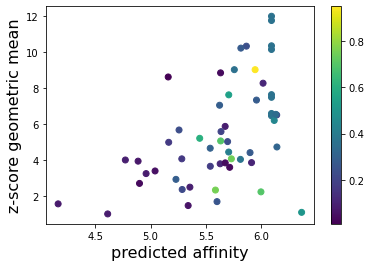

In [263]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
y = df['z-score_gmean']
x = df['affinity_mean']
z = df['affinity_var']
p = ax.scatter(x,y,c=z)
ax.set_xlabel('predicted affinity',fontsize=16)
ax.set_ylabel('z-score geometric mean',fontsize=16)
fig.colorbar(p)

In [264]:
from rdkit import Chem

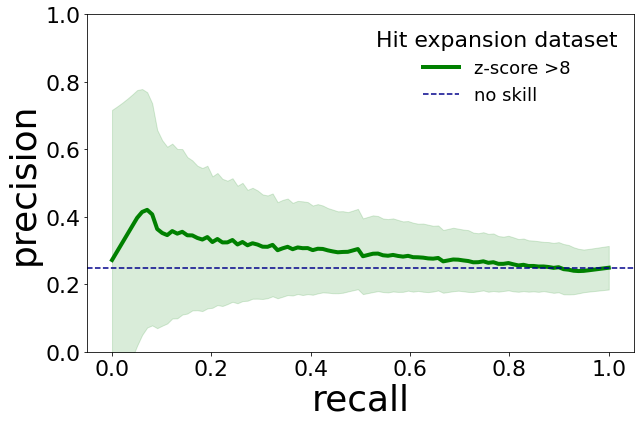

In [270]:
import matplotlib.pyplot as plt

thresh = 8
#thresh = 4.5
nbootstrap = 1000
samplesize = len(df)
x = np.linspace(0,1,100)

ps = []
for i in range(nbootstrap):
    df_sample = df.sample(n=samplesize,replace=True)
    samples = np.random.normal(df_sample['affinity_mean'],np.sqrt(df_sample['affinity_var']))
    #yr = (df_sample['113_x']> thresh) #& (df_sample['111_112'] > thresh)
    yr = df_sample['z-score_gmean'] >= thresh
    #yr = df_sample['z-score'] >= thresh
#    p, r, _ = precision_recall_curve(yr, df_sample['proba'])
#    p, r, _ = precision_recall_curve(yr, df_sample['affinity_mean'],
    p, r, _ = precision_recall_curve(yr, samples)
#                                        sample_weight=1/df_sample['affinity_var'])
    ps.append(np.interp(x,r[::-1],p[::-1]))
#     p, r, _ = roc_curve(yr, df_sample['prediction'])
#     ps.append(np.interp(x,r,p))

    
ps = np.vstack(ps)
pavg = np.mean(ps,axis=0)
perr = np.std(ps,axis=0)
auc = np.trapz(pavg[::-1],x)
alpha_err = 0.15
fig, ax = plt.subplots()
fig.set_size_inches(9,6)

ax.plot(x,pavg,label='z-score >{}'.format(thresh),color='g',lw=4)
#ax.plot(x,pavg,label='enzymatic activity at $20 \\mathrm{{\\mu{{M}}}} < $ {:.0f} %'.format(thresh),color='g',lw=4)
ax.fill_between(x, pavg - perr, pavg + perr, color='g', alpha=alpha_err)


ax.axhline(pavg[-1],ls='--',color='darkblue',label='no skill')

ax.set_ylim(0,1)

ax.set_xlabel('recall',fontsize=36)
ax.set_ylabel('precision',fontsize=36)
ax.set_ylim(0,1)
ax.tick_params(labelsize=22)
l = ax.legend(frameon=False,title='Hit expansion dataset',fontsize=18)
l.get_title().set_fontsize(22)

fig.tight_layout()
#fig.savefig('affinity_pred_hit_expansion_new_pretrain.png',dpi=300)
#fig.savefig('affinity_pred_hit_expansion_new_pretrain.pdf')

**Primary screen**

In [271]:
df = pd.read_csv('/home/xvg/primary_screen_combined.csv')
df = df[(df['smiles'].notnull())]

In [272]:
primary_screen_dataset = InhibDataset(df=df, seq=mpro_seq_5r84, smiles_name='smiles')

In [273]:
y_pred=trainer.predict(primary_screen_dataset)
df['affinity_mean'] = scale(y_pred.predictions)
#df['affinity_var'] = scale_var(y_pred.predictions[:,1])

RDKit ERROR: [20:10:01] SMILES Parse Error: syntax error while parsing: CCn1nc(C(=O)NN=Crc(nc3ccccn3c2=O)N2CCCCC2)c2ccccc2c1=O
RDKit ERROR: [20:10:01] SMILES Parse Error: Failed parsing SMILES 'CCn1nc(C(=O)NN=Crc(nc3ccccn3c2=O)N2CCCCC2)c2ccccc2c1=O' for input: 'CCn1nc(C(=O)NN=Crc(nc3ccccn3c2=O)N2CCCCC2)c2ccccc2c1=O'
[20:10:01] SMILES Parse Error: syntax error while parsing: CCn1nc(C(=O)NN=Crc(nc3ccccn3c2=O)N2CCCCC2)c2ccccc2c1=O
[20:10:01] SMILES Parse Error: Failed parsing SMILES 'CCn1nc(C(=O)NN=Crc(nc3ccccn3c2=O)N2CCCCC2)c2ccccc2c1=O' for input: 'CCn1nc(C(=O)NN=Crc(nc3ccccn3c2=O)N2CCCCC2)c2ccccc2c1=O'


In [274]:
from scipy.stats import spearmanr

x = df['affinity_mean']
y = df['z-score']
spearmanr(x,y)

SpearmanrResult(correlation=-0.007879785865527284, pvalue=0.8879884412292993)

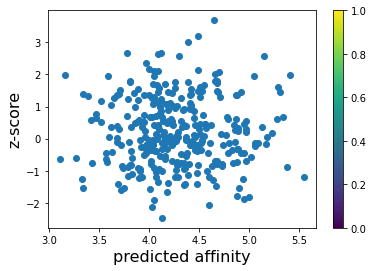

In [275]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
y = df['z-score']
x = df['affinity_mean']
#z = df['affinity_var']
p = ax.scatter(x,y)#,c=z)
ax.set_xlabel('predicted affinity',fontsize=16)
ax.set_ylabel('z-score',fontsize=16)
fig.colorbar(p)

**PLpro**

In [68]:
df = pd.read_csv('/home/xvg/shen_2021_biorxiv.csv',sep=',',header=None)
df = df.rename(columns={0: 'smiles', 1: 'name', 2: 'ic50'})

In [69]:
def make_numeric(ic50): 
    try:
        return float(ic50.replace('<','').replace('>','').split('-')[-1].split('~')[-1])
    except Exception as e:
        return np.nan

In [70]:
df['pIC50'] = 6-np.log(df['ic50'].apply(make_numeric).astype('float32'))/np.log(10)

In [71]:
# Jerry?
plpro_seq = 'VRTIKVFTTVDNINLHTQVVDMSMTYGQQFGPTYLDGADVTKIKPHNSHEGKTFYVLPNDDTLRVEAFEYYHTTDPSFLGRYMSALNHTKKWKYPQVNGLTSIKWADNNCYLATALLTLQQIELKFNPPALQDAYYRARAGEAANFCALILAYCNKTVGELGDVRETMSYLFQHANLDSCKRVLNVVCKTCGQQQTTLKGVEAVMYMGTLSYEQFKKGVQIPCTCGKQATKYLVQQESPFVMMSAPPAQYELKHGTFTCASEYTGNYQCGHYKHITSKETLYCIDGALLTKSSEYKGPITDVFYKENSYTTTI'

In [72]:
# aa 1564-1878 in https://www.uniprot.org/uniprot/P0C6X7#PRO_0000037311
plpro_seq = 'SMTYGQQFGPTYLDGADVTKIKPHVNHEGKTFFVLPSDDTLRSEAFEYYHTLDESFLGRYMSALNHTKKWKFPQVGGLTSIKWADNNCYLSSVLLALQQLEVKFNAPALQEAYYRARAGDAANFCALILAYSNKTVGELGDVRETMTHLLQHANLESAKRVLNVVCKHCGQKTTTLTGVEAVMYMGTLSYDNLKTGVSIPCVCGRDATQYLVQQESSFVMMSAPPAEYKLQQGTFLCANEYTGNYQCGHYTHITAKETLYRIDGAHLTKMSEYKGPVTDVFYKETSYTTTIKPVSYKLDGVTYTEIEPKLDGYYK'

In [73]:
#plpro_seq = df_virus.iloc[13].seq

In [74]:
shen_dataset = InhibDataset(df,seq=plpro_seq,smiles_name='smiles')

In [75]:
df_7los = pd.DataFrame({'seq':  ['SEVRTIKVFTTVDNINLHTQVVDMSMTYGQQFGPTYLDGADVTKIKPHNSHEGKTFYVLPNDDTLRVEAFEYYHTTDPSFLGRYMSALNHTKKWKYPQVNGLTSIKWADNNCYLATALLTLQQIELKFNPPALQDAYYRARAGEAANFCALILAYCNKTVGELGDVRETMSYLFQHANLDSCKRVLNVVCKTCGQQQTTLKGVEAVMYMGTLSYEQFKKGVQIPCTCGKQATKYLVQQESPFVMMSAPPAQYELKHGTFTCASEYTGNYQCGHYKHITSKETLYCIDGALLTKSSEYKGPITDVFYKENSYTTTIKSEVRTIKVFTTVDNINLHTQVVDMSMTYGQQFGPTYLDGADVTKIKPHNSHEGKTFYVLPNDDTLRVEAFEYYHTTDPSFLGRYMSALNHTKKWKYPQVNGLTSIKWADNNCYLATALLTLQQIELKFNPPALQDAYYRARAGEAANFCALILAYCNKTVGELGDVRETMSYLFQHANLDSCKRVLNVVCKTCGQQQTTLKGVEAVMYMGTLSYEQFKKGVQIPCTCGKQATKYLVQQESPFVMMSAPPAQYELKHGTFTCASEYTGNYQCGHYKHITSKETLYCIDGALLTKSSEYKGPITDVFYKENSYTTTIK'],
                        'smiles_can': ['CC1CCC(NC2CNC2)CC1[C@H](O)N[C@H](C)[C@@H]1CCCC(C2CCC(CN[C@@H]3CCOC3)S2)C1.Cc1ccc(NC2CNC2)cc1C(=O)N[C@H](C)c1cccc(-c2ccc(CN[C@@H]3CCOC3)s2)c1']})

In [76]:
pdb_7los_dataset = AffinityDataset(df_7los)

0.056099715916970036


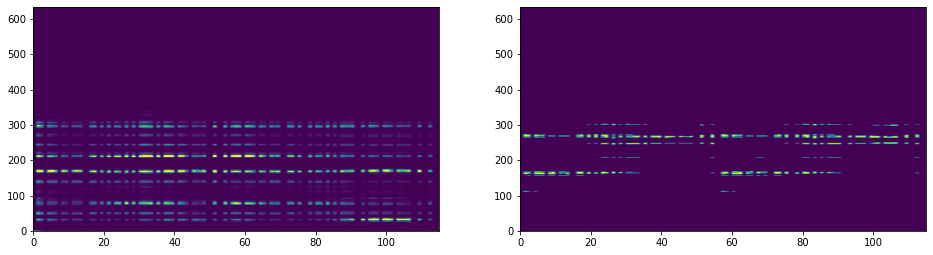

In [77]:
item = pdb_7los_dataset[0]

inp = item
out = models[0]([inp])[0]
contacts = out['contacts_1'].squeeze(0).squeeze(0)
#print(scale(out['affinity'][0][0]))

import matplotlib.pyplot as plt
from scipy.special import expit
fig, axes = plt.subplots(1,2)
fig.set_size_inches(16,12)
it = models[0].tokenizer(features=inp)
nseq, nsmi = len(it['input_ids_1']), len(it['input_ids_2'])
extent = [0,nsmi,nseq,0]
p= axes[0].imshow(expit(contacts), extent=extent)
p.set_clim(0,.25)
X = np.pad(np.load('/home/xvg/contact.npy'),(1,1))
q = axes[1].imshow(X.reshape(2048,512),extent=[0,512,2048,0])

from sklearn.metrics import log_loss
print(log_loss(X.reshape(2048,512)[:nseq,:nsmi].flatten(),expit(contacts[:nseq,:nsmi].flatten())))
for ax in axes:
    ax.set_xlim(0,nsmi)
    ax.set_ylim(0,nseq)
    ax.set_aspect(.1)
fig.savefig('plpro.png',dpi=300)

In [78]:
# y_pred=trainer.predict(shen_dataset)
# df['affinity_mean'] = scale(y_pred.predictions)
# #df['affinity_var'] = scale_var(y_pred.predictions[:,1])

In [79]:
for i,model in enumerate(tqdm.auto.tqdm(models)):
    y_pred=model(shen_dataset)
    #y_pred = [model([item]) for item in tqdm.auto.tqdm(postera_dataset)]
    df[f'affinity_{i}'] = [scale(r['affinity'][0,0]) for r in y_pred]
df['affinity_mean'] = np.mean([df[f'affinity_{i}'] for i in range(len(models))],axis=0)
df['affinity_var'] = np.var([df[f'affinity_{i}'] for i in range(len(models))],axis=0)

  0%|          | 0/1 [00:00<?, ?it/s]

RDKit ERROR: [22:47:05] SMILES Parse Error: extra open parentheses for input: 'Cc2ccc(NC1CNC1)cc2C(=O)N[C@H](C)c5cccc(c4ccc(C(=O)NC[C@H]3CCCO3)s'
[22:47:05] SMILES Parse Error: extra open parentheses for input: 'Cc2ccc(NC1CNC1)cc2C(=O)N[C@H](C)c5cccc(c4ccc(C(=O)NC[C@H]3CCCO3)s'
RDKit ERROR: [22:47:05] SMILES Parse Error: extra open parentheses for input: 'Cc2ccc(NC1CNC1)cc2C(=O)N[C@H](C)c5cccc(c4ccc(C(=O)NC[C@@H]3CCCO3)'
[22:47:05] SMILES Parse Error: extra open parentheses for input: 'Cc2ccc(NC1CNC1)cc2C(=O)N[C@H](C)c5cccc(c4ccc(C(=O)NC[C@@H]3CCCO3)'


In [80]:
# uncomment to load paper results
# tokenizer_type = 'regex'
##df.to_parquet(f'shen_{tokenizer_type}.parquet')
#df = pd.read_parquet(f'shen_{tokenizer_type}.parquet')

In [81]:
from scipy.stats import spearmanr, pearsonr

nbootstrap = 500
samplesize = len(df.dropna())

sp = []
mse = []
for i in range(nbootstrap):
    df_sample = df.dropna().sample(n=samplesize,replace=True)#,weights=1/df['affinity_var'])
    #samples = np.random.normal(df_sample['affinity_mean'],np.sqrt(df_sample['affinity_var']))
    samples = df_sample['affinity_mean']
    x = samples
    y = df_sample['pIC50']

    import pickle
    s = spearmanr(x,y)
    sp.append(s.correlation)    
    mse.append(mean_squared_error(y,x))

#pickle.dump([np.mean(sp),np.std(sp)],open(f'shen_plpro_spearmanr_{tokenizer_type}.p','wb'))
print(np.mean(sp), np.std(sp))
print(np.mean(mse), np.std(mse))

0.6919489441262511 0.05319412238265221
0.6108894788204868 0.0985582844059694


In [82]:
%matplotlib inline

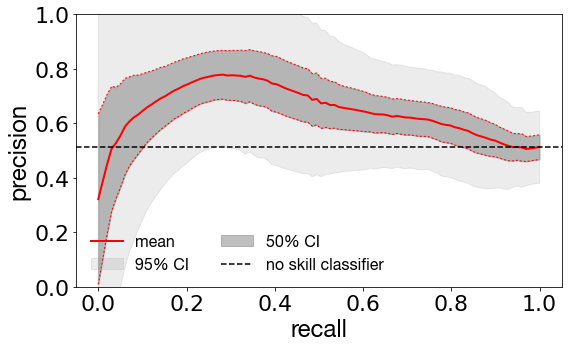

In [85]:
import matplotlib.pyplot as plt
import matplotlib
from scipy.stats import linregress
from scipy.constants import golden

thresh = 6
nbootstrap = 500
samplesize = len(df)
x = np.linspace(0,1,100)

fig, ax = plt.subplots()
fig.set_size_inches(8,8/golden)
#df_select = df[np.log(df['affinity_var'])]
ps = []
np.random.seed(41)
for i in range(nbootstrap):
    df_sample = df.sample(n=samplesize,replace=True)#,weights=1/df['affinity_var'],seed=0)
    yr = df_sample['pIC50'] > thresh
    samples = np.random.normal(df_sample['affinity_mean'],np.sqrt(df_sample['affinity_var']))
    #p, r, _ = precision_recall_curve(yr,df_sample['affinity_mean'])#, sample_weight=1/df_sample['affinity_var'])
    p, r, _ = precision_recall_curve(yr,samples)#, sample_weight=1/df_sample['affinity_var'])
    ps.append(np.interp(x,r[::-1],p[::-1]))
    #if i % 100 == 0:
    #    ax.plot(r,p,'-',color='b',alpha=1,lw=.5)
    #r, p, _ = roc_curve(yr, df_sample.prediction)
    #ps.append(np.interp(x,r,p))
    
ps = np.vstack(ps)
pavg = np.mean(ps,axis=0)
perr = np.std(ps,axis=0)
auc = np.trapz(pavg[::-1],x)
alpha_err = 0.15

ci = 1.96
lower = pavg - ci*perr
upper = pavg + ci*perr
ax.plot(x,pavg,label='mean'.format(thresh),color='r',lw=2)
#ax.plot(x,lower,color='r',lw=1,dashes=[2,2])
#ax.plot(x,upper,color='r',lw=1,dashes=[2,2])
ax.fill_between(x, lower, upper, color='gray', alpha=alpha_err, label='95% CI'.format(thresh))

ci = 0.67
lower = pavg - ci*perr
upper = pavg + ci*perr
#ax.plot(x,pavg,label='mean'.format(thresh),color='r',lw=2)
ax.plot(x,lower,color='r',lw=1,dashes=[2,2])
ax.plot(x,upper,color='r',lw=1,dashes=[2,2])
ax.fill_between(x, lower, upper, color='gray', alpha=.5, label='50% CI'.format(thresh))

ax.axhline(pavg[-1],ls='--',color='black',label='no skill classifier')

ax.set_ylim(0,1)

ax.set_xlabel('recall',fontsize=24,fontfamily='Helvetica Neue')
ax.set_ylabel('precision',fontsize=24,fontfamily='Helvetica Neue')
ax.set_ylim(0,1)

ax.tick_params(labelsize=22)
l = ax.legend(frameon=False,fontsize=16,loc='lower left',ncol=2)
l.get_title().set_fontsize(20)
plt.setp(l.texts, family='Helvetica Neue')

# ax2 = ax.inset_axes(bounds=(0.6,0.6,0.4,0.4))
# df_select = df#[df['f_avg_IC50']<90]
# y = 6-np.log(df_select['f_avg_IC50'])/np.log(10)
# x = df_select['affinity_mean']
# c = -np.log(df_select['affinity_var'])
# ax2.scatter(x,y,c=c)
# res = linregress(x,y)
# xfit = np.linspace(x.min(),x.max(),2)
# ax2.plot(xfit,res.intercept + res.slope*xfit, 'r', label=f"{res.slope :.2f}*x+{res.intercept:.2f}")
# ax2.set_ylabel('experimental pIC50',fontsize=14)
# ax2.set_xlabel('predicted pIC50',fontsize=14)
# ax2.legend(frameon=False)
# ax2.tick_params(labelsize=16)

# df_select = df[df['f_avg_IC50'] < thresh]
# ax2.scatter(df_select['affinity_mean'],np.log(df_select['affinity_var']),s=25,alpha=0.5,zorder=2,lw=0.5,edgecolor='k')
# df_select = df[df['f_avg_IC50'] >= thresh]
# ax2.scatter(df_select['affinity_mean'],np.log(df_select['affinity_var']),s=25,alpha=0.5,zorder=1,lw=0.5,edgecolor='k')
# ax2.set_xlabel('-log[Affinity] $\mu$',fontsize=22)
# ax2.set_ylabel('log $\sigma^2$',fontsize=22)
# ax2.axvline(6-np.log(thresh)/np.log(10),dashes=[1,1])

fig.tight_layout()
fig.savefig('plpro_new.png',dpi=300)
# fig.savefig('plpro_new_pretrain.pdf')
# fig.savefig('plpro_new_pretrain.svg')

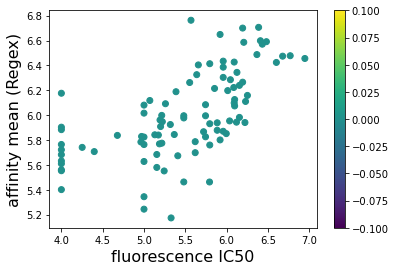

In [86]:
import matplotlib.pyplot as plt
fig, ax =plt.subplots()
field = 'pIC50'
x = df[field]
y = df['affinity_mean']
z = df['affinity_var']
ax.set_xlabel('fluorescence IC50',fontsize=16)
ax.set_ylabel('affinity mean (Regex)',fontsize=16)
p = ax.scatter(x,y,c=z)
fig.colorbar(p)